In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return term12  + term3

In [3]:
# Domain bounds
label = "Regr_smooth_unscaled_rowdy"
loss_thresh = 0.1
rowdy_terms = 8

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.omega1 = Parameter(torch.ones((len(layers)-2,1)))
        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.omega = Parameter(torch.ones(rowdy_terms,len(layers)-2))
        
        self.n = torch.tensor(10.0)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    alpha_val.append(model_NN.alpha.cpu().detach().numpy())
    omega_val.append(model_NN.alpha.cpu().detach().numpy())    
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
alpha_full = []
omega_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    alpha_val = []
    omega_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=8.0e-6)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    alpha_full.append(alpha_val)
    omega_full.append(alpha_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"alpha": alpha_full,"omega": omega_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 1.415887 Test MSE 1.3940390051483924 Test RE 0.996802863573504
1 Train Loss 1.4153597 Test MSE 1.39391348041733 Test RE 0.9967579845465585
2 Train Loss 1.4148406 Test MSE 1.3937954751730885 Test RE 0.9967157921291006
3 Train Loss 1.4143288 Test MSE 1.393681177507173 Test RE 0.9966749236421937
4 Train Loss 1.4138238 Test MSE 1.3935678155008755 Test RE 0.9966343880561365
5 Train Loss 1.4133248 Test MSE 1.3934547341577654 Test RE 0.9965939511859995
6 Train Loss 1.4128307 Test MSE 1.3933427663423592 Test RE 0.9965539108867044
7 Train Loss 1.4123411 Test MSE 1.3932328930805402 Test RE 

107 Train Loss 1.3408077 Test MSE 1.3429422890790084 Test RE 0.9783640567547071
108 Train Loss 1.3381739 Test MSE 1.3403665236492892 Test RE 0.9774253545281903
109 Train Loss 1.3354131 Test MSE 1.337688430144476 Test RE 0.9764484033418516
110 Train Loss 1.3325305 Test MSE 1.334915588087721 Test RE 0.9754358574899601
111 Train Loss 1.329536 Test MSE 1.332059461251687 Test RE 0.9743917988488757
112 Train Loss 1.3264426 Test MSE 1.3291337694074736 Test RE 0.9733211494980397
113 Train Loss 1.3232642 Test MSE 1.3261523813861258 Test RE 0.9722289053617678
114 Train Loss 1.3200139 Test MSE 1.3231271041241914 Test RE 0.9711193264806861
115 Train Loss 1.3167001 Test MSE 1.3200651208888357 Test RE 0.9699949925331656
116 Train Loss 1.3133265 Test MSE 1.3169674502791104 Test RE 0.968856226828038
117 Train Loss 1.3098903 Test MSE 1.3138293404382222 Test RE 0.9677012284277526
118 Train Loss 1.3063831 Test MSE 1.3106436930170653 Test RE 0.966527321821717
119 Train Loss 1.302795 Test MSE 1.30740446278

213 Train Loss 0.9152197 Test MSE 0.9716608927891095 Test RE 0.8322028064678219
214 Train Loss 0.91095716 Test MSE 0.9677215418942896 Test RE 0.8305141162856792
215 Train Loss 0.9066799 Test MSE 0.9637548868083108 Test RE 0.8288102450244552
216 Train Loss 0.90238917 Test MSE 0.9597612590488661 Test RE 0.8270912417072157
217 Train Loss 0.89808685 Test MSE 0.9557434904518552 Test RE 0.8253582345408774
218 Train Loss 0.8937752 Test MSE 0.9517073314221631 Test RE 0.8236136233489297
219 Train Loss 0.8894565 Test MSE 0.9476573331497253 Test RE 0.8218593077539416
220 Train Loss 0.88513356 Test MSE 0.9435937132589501 Test RE 0.8200953200488487
221 Train Loss 0.88080955 Test MSE 0.9395163996759696 Test RE 0.8183215662972919
222 Train Loss 0.876488 Test MSE 0.9354309449091677 Test RE 0.8165404062593415
223 Train Loss 0.87217224 Test MSE 0.9313480590065233 Test RE 0.8147564760258172
224 Train Loss 0.86786634 Test MSE 0.92727524586371 Test RE 0.812973046824589
225 Train Loss 0.86357385 Test MSE 0.

320 Train Loss 0.5522026 Test MSE 0.6295978604431931 Test RE 0.6698899092763412
321 Train Loss 0.5497585 Test MSE 0.6272108289589612 Test RE 0.6686188067786231
322 Train Loss 0.54732746 Test MSE 0.6248590456436743 Test RE 0.6673641063981953
323 Train Loss 0.5449095 Test MSE 0.622557842103683 Test RE 0.6661341032446576
324 Train Loss 0.542505 Test MSE 0.6202376322181025 Test RE 0.6648916374342048
325 Train Loss 0.54011416 Test MSE 0.617911854850502 Test RE 0.6636438557487002
326 Train Loss 0.53773516 Test MSE 0.6156231962384577 Test RE 0.6624136938493307
327 Train Loss 0.5353699 Test MSE 0.6133543098693942 Test RE 0.6611919004337315
328 Train Loss 0.5330175 Test MSE 0.6110783213200819 Test RE 0.659964009962381
329 Train Loss 0.530677 Test MSE 0.6088059179361003 Test RE 0.6587357702875581
330 Train Loss 0.52834994 Test MSE 0.6065651034650908 Test RE 0.6575223577922669
331 Train Loss 0.5260351 Test MSE 0.6043400611485464 Test RE 0.6563152662447237
332 Train Loss 0.5237322 Test MSE 0.60209

426 Train Loss 0.3517103 Test MSE 0.4310259083720499 Test RE 0.5542727173607837
427 Train Loss 0.35024744 Test MSE 0.4295198128522292 Test RE 0.5533034970099221
428 Train Loss 0.3488192 Test MSE 0.4280712682849609 Test RE 0.5523697081144662
429 Train Loss 0.34738332 Test MSE 0.42653298418796776 Test RE 0.5513763381654676
430 Train Loss 0.34594426 Test MSE 0.42505677054977037 Test RE 0.5504213654163267
431 Train Loss 0.3445315 Test MSE 0.42363204692373785 Test RE 0.5494981280877946
432 Train Loss 0.3431185 Test MSE 0.422102449931414 Test RE 0.5485052018380709
433 Train Loss 0.34170252 Test MSE 0.42064360504678994 Test RE 0.547556526235464
434 Train Loss 0.34030652 Test MSE 0.41924242807301826 Test RE 0.5466438015857139
435 Train Loss 0.33891547 Test MSE 0.41773014860996566 Test RE 0.5456569918313762
436 Train Loss 0.33752143 Test MSE 0.4162801433271185 Test RE 0.5447091391129223
437 Train Loss 0.33614346 Test MSE 0.41489667663586977 Test RE 0.5438032418183377
438 Train Loss 0.334773 Tes

529 Train Loss 0.23686495 Test MSE 0.30896637641855923 Test RE 0.4692750060106274
530 Train Loss 0.23603994 Test MSE 0.30805852876912265 Test RE 0.4685850545150802
531 Train Loss 0.2352192 Test MSE 0.30715450025351326 Test RE 0.46789699453115957
532 Train Loss 0.23440282 Test MSE 0.30625423661689627 Test RE 0.467210793031095
533 Train Loss 0.23359057 Test MSE 0.30535809025004856 Test RE 0.4665267274074313
534 Train Loss 0.23278232 Test MSE 0.30446585722666125 Test RE 0.46584465106181233
535 Train Loss 0.23197839 Test MSE 0.3035774505812265 Test RE 0.4651645061173597
536 Train Loss 0.23117857 Test MSE 0.3026925321873242 Test RE 0.46448604162864293
537 Train Loss 0.23038284 Test MSE 0.30181192685136105 Test RE 0.46380989873185047
538 Train Loss 0.22959115 Test MSE 0.30093453292737443 Test RE 0.463135239884727
539 Train Loss 0.22880338 Test MSE 0.3000609150161489 Test RE 0.4624625066719354
540 Train Loss 0.2280197 Test MSE 0.2991915577718656 Test RE 0.46179208153305135
541 Train Loss 0.22

635 Train Loss 0.16878383 Test MSE 0.23067598528212446 Test RE 0.4054833317721286
636 Train Loss 0.16830544 Test MSE 0.22989700056512002 Test RE 0.4047981012835592
637 Train Loss 0.16781756 Test MSE 0.2294276969906027 Test RE 0.4043847199744512
638 Train Loss 0.16731168 Test MSE 0.22874912210980022 Test RE 0.4037862557992488
639 Train Loss 0.16679813 Test MSE 0.22812827855351056 Test RE 0.4032379292726537
640 Train Loss 0.16630104 Test MSE 0.22761364438388063 Test RE 0.4027828406128533
641 Train Loss 0.1658281 Test MSE 0.2269816622839887 Test RE 0.40222327730986596
642 Train Loss 0.16536236 Test MSE 0.22644885443570736 Test RE 0.4017509183779566
643 Train Loss 0.16488317 Test MSE 0.22581547376242792 Test RE 0.40118867342858056
644 Train Loss 0.1643907 Test MSE 0.2252542937825122 Test RE 0.40068986106474286
645 Train Loss 0.16390659 Test MSE 0.22468003967414707 Test RE 0.4001787839333222
646 Train Loss 0.16344056 Test MSE 0.22409344891799848 Test RE 0.39965605260684695
647 Train Loss 0.

737 Train Loss 0.127793 Test MSE 0.1807053190314058 Test RE 0.3588866323875472
738 Train Loss 0.12747256 Test MSE 0.18030643824685935 Test RE 0.3584903184690439
739 Train Loss 0.12715335 Test MSE 0.17991034773591502 Test RE 0.3580963428498362
740 Train Loss 0.12683555 Test MSE 0.17951400830464895 Test RE 0.3577016853024926
741 Train Loss 0.126519 Test MSE 0.1791214243986537 Test RE 0.3573103376116587
742 Train Loss 0.12620386 Test MSE 0.1787258755695399 Test RE 0.35691560035947556
743 Train Loss 0.12588984 Test MSE 0.1783377270225725 Test RE 0.3565278233527234
744 Train Loss 0.12557721 Test MSE 0.1779427135839508 Test RE 0.3561327545251026
745 Train Loss 0.12526588 Test MSE 0.17755930519768015 Test RE 0.3557488727875984
746 Train Loss 0.124955826 Test MSE 0.17716408769206 Test RE 0.3553527332943363
747 Train Loss 0.12464712 Test MSE 0.17678774778188214 Test RE 0.35497510452758924
748 Train Loss 0.124340184 Test MSE 0.1763889030207114 Test RE 0.35457445486099903
749 Train Loss 0.1240349

843 Train Loss 0.0990372 Test MSE 0.1435058049879351 Test RE 0.3198206847546347
844 Train Loss 0.098805375 Test MSE 0.1432050308665071 Test RE 0.31948535253041266
845 Train Loss 0.09857437 Test MSE 0.1429038214896282 Test RE 0.31914918194027164
846 Train Loss 0.09834447 Test MSE 0.14260361440092972 Test RE 0.31881377726854804
847 Train Loss 0.09811548 Test MSE 0.14230687093647432 Test RE 0.31848189517444686
848 Train Loss 0.09788723 Test MSE 0.1420075236364776 Test RE 0.31814675013338345
849 Train Loss 0.09765999 Test MSE 0.14171369038727843 Test RE 0.31781743483422153
850 Train Loss 0.09743373 Test MSE 0.14141713307780654 Test RE 0.31748472017751234
851 Train Loss 0.097208284 Test MSE 0.14112417219047324 Test RE 0.31715569771872426
852 Train Loss 0.096983746 Test MSE 0.14083226661518625 Test RE 0.316827520631428
853 Train Loss 0.09676023 Test MSE 0.14053944241807556 Test RE 0.3164979688814887
854 Train Loss 0.09653753 Test MSE 0.1402511960106091 Test RE 0.3161732336084569
855 Train Lo

946 Train Loss 0.07908513 Test MSE 0.11727952240821589 Test RE 0.2891231777542871
947 Train Loss 0.07892121 Test MSE 0.11697560455445989 Test RE 0.2887483182133639
948 Train Loss 0.078751184 Test MSE 0.11678934156804664 Test RE 0.28851833628092993
949 Train Loss 0.078582555 Test MSE 0.1165893394330662 Test RE 0.2882711861200834
950 Train Loss 0.078420244 Test MSE 0.11631734176135089 Test RE 0.2879347279307249
951 Train Loss 0.07826002 Test MSE 0.11617176212884049 Test RE 0.2877544858656181
952 Train Loss 0.07809661 Test MSE 0.11589632453707145 Test RE 0.28741315748949914
953 Train Loss 0.07793018 Test MSE 0.11569885814280073 Test RE 0.287168203063436
954 Train Loss 0.07776578 Test MSE 0.11550477801351032 Test RE 0.28692724548084997
955 Train Loss 0.07760514 Test MSE 0.11524496799107625 Test RE 0.28660436471864154
956 Train Loss 0.077445365 Test MSE 0.1150846650851567 Test RE 0.2864049655561057
957 Train Loss 0.07728364 Test MSE 0.114828098150987 Test RE 0.2860855353158902
958 Train Los

1052 Train Loss 0.0637396 Test MSE 0.09706459856484016 Test RE 0.263028159208137
1053 Train Loss 0.06361479 Test MSE 0.09690005173047661 Test RE 0.26280511800809253
1054 Train Loss 0.06349042 Test MSE 0.09673623110938545 Test RE 0.2625828729795878
1055 Train Loss 0.06336627 Test MSE 0.09657230665412567 Test RE 0.26236029864346194
1056 Train Loss 0.06324255 Test MSE 0.0964089623029384 Test RE 0.2621383239849372
1057 Train Loss 0.06311901 Test MSE 0.09624613133319429 Test RE 0.26191685974177986
1058 Train Loss 0.062995866 Test MSE 0.09608317124448722 Test RE 0.26169503224452123
1059 Train Loss 0.06287297 Test MSE 0.09592129702185356 Test RE 0.2614744965544065
1060 Train Loss 0.06275054 Test MSE 0.0957589398214677 Test RE 0.26125311586243705
1061 Train Loss 0.06262832 Test MSE 0.09559813816156913 Test RE 0.26103367115203874
1062 Train Loss 0.0625065 Test MSE 0.09543629211343273 Test RE 0.26081261473268325
1063 Train Loss 0.06238491 Test MSE 0.09527631697059989 Test RE 0.26059392939917275


1150 Train Loss 0.052832913 Test MSE 0.08253771618781033 Test RE 0.24254819001699068
1151 Train Loss 0.05273334 Test MSE 0.08240845147896833 Test RE 0.24235818472054563
1152 Train Loss 0.05263418 Test MSE 0.08226728261484527 Test RE 0.24215051127304713
1153 Train Loss 0.052535173 Test MSE 0.08214475853692545 Test RE 0.24197012168000234
1154 Train Loss 0.05243637 Test MSE 0.08200296792868561 Test RE 0.24176119837546906
1155 Train Loss 0.05233762 Test MSE 0.0818771672163969 Test RE 0.24157568433185525
1156 Train Loss 0.05223913 Test MSE 0.08174223706818494 Test RE 0.24137654894269098
1157 Train Loss 0.05214074 Test MSE 0.08160964897352761 Test RE 0.24118070988750884
1158 Train Loss 0.052042693 Test MSE 0.08148193625927175 Test RE 0.24099192153018628
1159 Train Loss 0.051944897 Test MSE 0.08134534915909707 Test RE 0.2407898510152965
1160 Train Loss 0.05184725 Test MSE 0.08122060186564065 Test RE 0.24060514834012076
1161 Train Loss 0.051749803 Test MSE 0.08108413246384368 Test RE 0.2404029

1250 Train Loss 0.043799113 Test MSE 0.07041723583077855 Test RE 0.22403264215224122
1251 Train Loss 0.043717317 Test MSE 0.07029812067389485 Test RE 0.2238430793436309
1252 Train Loss 0.043635733 Test MSE 0.07020019768141966 Test RE 0.22368712195435708
1253 Train Loss 0.04355446 Test MSE 0.07007623701527593 Test RE 0.22348953948878428
1254 Train Loss 0.04347353 Test MSE 0.06998684751573575 Test RE 0.22334695197349033
1255 Train Loss 0.04339315 Test MSE 0.06985406462218749 Test RE 0.2231349783275846
1256 Train Loss 0.043313693 Test MSE 0.06978117441079472 Test RE 0.22301853126855906
1257 Train Loss 0.043235537 Test MSE 0.06963290023689774 Test RE 0.2227814653730077
1258 Train Loss 0.043159675 Test MSE 0.06959198348133237 Test RE 0.2227160018190909
1259 Train Loss 0.043087836 Test MSE 0.06941955046860536 Test RE 0.2224399110425438
1260 Train Loss 0.043020986 Test MSE 0.06943537409406826 Test RE 0.22246526128798338
1261 Train Loss 0.042963155 Test MSE 0.06922395214475358 Test RE 0.222126

1351 Train Loss 0.036248352 Test MSE 0.06022830920207395 Test RE 0.20719160271265102
1352 Train Loss 0.036180343 Test MSE 0.06013714241191182 Test RE 0.20703473174086284
1353 Train Loss 0.036112487 Test MSE 0.06004454664784539 Test RE 0.20687528016469192
1354 Train Loss 0.036044717 Test MSE 0.05995286834051721 Test RE 0.20671728729440822
1355 Train Loss 0.035977066 Test MSE 0.05986161689516702 Test RE 0.2065599100499855
1356 Train Loss 0.035909552 Test MSE 0.05976933852112757 Test RE 0.20640063967716663
1357 Train Loss 0.035842195 Test MSE 0.05967904291479576 Test RE 0.2062446724571247
1358 Train Loss 0.03577494 Test MSE 0.05958686926038527 Test RE 0.20608533954711086
1359 Train Loss 0.035707776 Test MSE 0.05949658577242837 Test RE 0.20592915449627355
1360 Train Loss 0.035640713 Test MSE 0.05940556105693161 Test RE 0.20577156715429543
1361 Train Loss 0.03557384 Test MSE 0.05931456278938775 Test RE 0.20561390487458686
1362 Train Loss 0.035507046 Test MSE 0.0592244143443172 Test RE 0.205

1450 Train Loss 0.030085616 Test MSE 0.051829276341893896 Test RE 0.19220265687664403
1451 Train Loss 0.030028945 Test MSE 0.051752328567691186 Test RE 0.1920599280845612
1452 Train Loss 0.029972427 Test MSE 0.051673519047391606 Test RE 0.19191363594638022
1453 Train Loss 0.029915934 Test MSE 0.051597196739819516 Test RE 0.19177185438817318
1454 Train Loss 0.029859547 Test MSE 0.05151815106655149 Test RE 0.19162490313443606
1455 Train Loss 0.029803222 Test MSE 0.05144265930401395 Test RE 0.19148445355772697
1456 Train Loss 0.029747099 Test MSE 0.051363327163931896 Test RE 0.19133674800694417
1457 Train Loss 0.02969101 Test MSE 0.051288868070812677 Test RE 0.19119801159235644
1458 Train Loss 0.029635128 Test MSE 0.05120835450108613 Test RE 0.19104788076304166
1459 Train Loss 0.0295793 Test MSE 0.05113630322957553 Test RE 0.19091342918506074
1460 Train Loss 0.029523691 Test MSE 0.051054043493287564 Test RE 0.1907598122032342
1461 Train Loss 0.029468238 Test MSE 0.05098515399022632 Test R

1550 Train Loss 0.024910457 Test MSE 0.04465158168390683 Test RE 0.17839810543586956
1551 Train Loss 0.024863437 Test MSE 0.04458530909527099 Test RE 0.17826566562071375
1552 Train Loss 0.024816537 Test MSE 0.044519028202170643 Test RE 0.17813311072394789
1553 Train Loss 0.024769682 Test MSE 0.044454315370168265 Test RE 0.17800359655132944
1554 Train Loss 0.024722952 Test MSE 0.04438726910173031 Test RE 0.1778693128476313
1555 Train Loss 0.024676273 Test MSE 0.04432309434353756 Test RE 0.17774068532462775
1556 Train Loss 0.02462974 Test MSE 0.04425660579234153 Test RE 0.17760732193851925
1557 Train Loss 0.024583196 Test MSE 0.04419175029000441 Test RE 0.17747713758512904
1558 Train Loss 0.024536822 Test MSE 0.0441266396916397 Test RE 0.1773463450491007
1559 Train Loss 0.024490515 Test MSE 0.04406105237638471 Test RE 0.1772144973024665
1560 Train Loss 0.024444308 Test MSE 0.0439965518190759 Test RE 0.17708473848472212
1561 Train Loss 0.024398185 Test MSE 0.04393105548928525 Test RE 0.17

1652 Train Loss 0.0205462 Test MSE 0.03844566130021179 Test RE 0.16553715311290335
1653 Train Loss 0.020507466 Test MSE 0.038390196695340675 Test RE 0.1654177018363114
1654 Train Loss 0.02046884 Test MSE 0.03833363100555505 Test RE 0.16529579030043795
1655 Train Loss 0.020430278 Test MSE 0.03827866271458714 Test RE 0.16517723530825282
1656 Train Loss 0.02039178 Test MSE 0.03822238787948662 Test RE 0.16505577416149497
1657 Train Loss 0.020353356 Test MSE 0.0381674952997764 Test RE 0.16493721023794616
1658 Train Loss 0.020314967 Test MSE 0.03811113743732136 Test RE 0.1648153926744393
1659 Train Loss 0.020276655 Test MSE 0.03805698916990868 Test RE 0.16469826628069462
1660 Train Loss 0.020238508 Test MSE 0.03800022625342544 Test RE 0.16457539473051558
1661 Train Loss 0.020200353 Test MSE 0.03794680664350004 Test RE 0.16445967640252263
1662 Train Loss 0.02016228 Test MSE 0.03788963706841979 Test RE 0.16433574458124717
1663 Train Loss 0.020124339 Test MSE 0.03783710004122719 Test RE 0.16422

1753 Train Loss 0.016987948 Test MSE 0.033233219817021 Test RE 0.15390687646654144
1754 Train Loss 0.0169561 Test MSE 0.03318581175993122 Test RE 0.1537970611970686
1755 Train Loss 0.016924258 Test MSE 0.033139111495389895 Test RE 0.15368880872919322
1756 Train Loss 0.016892541 Test MSE 0.03309065046193665 Test RE 0.15357639407734153
1757 Train Loss 0.016860873 Test MSE 0.033044681241332426 Test RE 0.15346968356255317
1758 Train Loss 0.01682923 Test MSE 0.032996468597059514 Test RE 0.1533576855067551
1759 Train Loss 0.01679769 Test MSE 0.032950410813585344 Test RE 0.1532506167519856
1760 Train Loss 0.016766187 Test MSE 0.032902585247129135 Test RE 0.15313935927724023
1761 Train Loss 0.016734738 Test MSE 0.03285628348919256 Test RE 0.15303156960365139
1762 Train Loss 0.016703358 Test MSE 0.03280946338494645 Test RE 0.1529224959712993
1763 Train Loss 0.016672062 Test MSE 0.03276232924306108 Test RE 0.15281261210776997
1764 Train Loss 0.016640807 Test MSE 0.03271639187861016 Test RE 0.152

1852 Train Loss 0.014116802 Test MSE 0.028902150011495126 Test RE 0.14352808474631748
1853 Train Loss 0.014090913 Test MSE 0.0288531963825026 Test RE 0.1434064813650341
1854 Train Loss 0.01406526 Test MSE 0.02882560100063683 Test RE 0.1433378875214634
1855 Train Loss 0.014039989 Test MSE 0.028772217841616307 Test RE 0.1432050997401929
1856 Train Loss 0.014015274 Test MSE 0.02875288860276908 Test RE 0.14315698890905623
1857 Train Loss 0.013991407 Test MSE 0.028693545058281526 Test RE 0.14300918060956777
1858 Train Loss 0.013968824 Test MSE 0.028687748996723272 Test RE 0.14299473603892565
1859 Train Loss 0.013948188 Test MSE 0.028620553735473436 Test RE 0.14282716970636183
1860 Train Loss 0.013930071 Test MSE 0.028637231918231493 Test RE 0.14286877880186843
1861 Train Loss 0.013915757 Test MSE 0.028557993034530958 Test RE 0.1426709837681601
1862 Train Loss 0.013904186 Test MSE 0.028601334051159846 Test RE 0.14277920497882007
1863 Train Loss 0.013895547 Test MSE 0.028499629187895253 Test 

1952 Train Loss 0.01173074 Test MSE 0.02518868610168026 Test RE 0.13399067389145553
1953 Train Loss 0.011709172 Test MSE 0.0251541154623558 Test RE 0.13389869343446106
1954 Train Loss 0.011687634 Test MSE 0.025120477839221337 Test RE 0.1338091347185173
1955 Train Loss 0.01166615 Test MSE 0.025086436470365306 Test RE 0.13371843998033858
1956 Train Loss 0.011644691 Test MSE 0.025052510433908957 Test RE 0.13362799127358108
1957 Train Loss 0.011623315 Test MSE 0.02501902806426344 Test RE 0.13353866534090553
1958 Train Loss 0.011601962 Test MSE 0.024984776042655678 Test RE 0.13344722422263128
1959 Train Loss 0.011580652 Test MSE 0.02495174229506893 Test RE 0.1333589760834629
1960 Train Loss 0.011559359 Test MSE 0.024917408484219777 Test RE 0.13326719295304187
1961 Train Loss 0.011538105 Test MSE 0.024884520802800066 Test RE 0.13317921638560218
1962 Train Loss 0.011516935 Test MSE 0.024850577577406486 Test RE 0.13308835518753795
1963 Train Loss 0.0114957895 Test MSE 0.02481752230120327 Test 

2050 Train Loss 0.009807878 Test MSE 0.0221058640701585 Test RE 0.12552365073590516
2051 Train Loss 0.009793596 Test MSE 0.022105454386843477 Test RE 0.1255224875788476
2052 Train Loss 0.009776463 Test MSE 0.02204876636498563 Test RE 0.1253614370719784
2053 Train Loss 0.009756062 Test MSE 0.02203358595643685 Test RE 0.1253182744417183
2054 Train Loss 0.009735231 Test MSE 0.022000152771007298 Test RE 0.1252231610159825
2055 Train Loss 0.009716776 Test MSE 0.02196401563717124 Test RE 0.1251202738687098
2056 Train Loss 0.0097007435 Test MSE 0.021955099631171957 Test RE 0.12509487581839532
2057 Train Loss 0.0096849175 Test MSE 0.021905412893373753 Test RE 0.12495324410182042
2058 Train Loss 0.009667349 Test MSE 0.021893060229507225 Test RE 0.12491800799165122
2059 Train Loss 0.009648232 Test MSE 0.021851952681563324 Test RE 0.12480067661622017
2060 Train Loss 0.009629163 Test MSE 0.021824955047537845 Test RE 0.12472355846645898
2061 Train Loss 0.009611458 Test MSE 0.02180477884443153 Test 

2149 Train Loss 0.008197354 Test MSE 0.01947680455726971 Test RE 0.1178231602925853
2150 Train Loss 0.008182597 Test MSE 0.019452226567857993 Test RE 0.1177487956674082
2151 Train Loss 0.008167881 Test MSE 0.019427727298053917 Test RE 0.11767462245167966
2152 Train Loss 0.00815315 Test MSE 0.019403376278566975 Test RE 0.11760085171518499
2153 Train Loss 0.008138498 Test MSE 0.019378840939896978 Test RE 0.11752647575629091
2154 Train Loss 0.0081238765 Test MSE 0.01935459924486255 Test RE 0.11745294368740987
2155 Train Loss 0.008109259 Test MSE 0.01933015796721968 Test RE 0.11737875959210177
2156 Train Loss 0.0080946535 Test MSE 0.019306032738041875 Test RE 0.11730548875814521
2157 Train Loss 0.008080109 Test MSE 0.01928157495710262 Test RE 0.11723116118350098
2158 Train Loss 0.008065602 Test MSE 0.01925767240659237 Test RE 0.11715847540147917
2159 Train Loss 0.008051105 Test MSE 0.019233275991593038 Test RE 0.11708424128490616
2160 Train Loss 0.008036608 Test MSE 0.019209438930191787 Te

2248 Train Loss 0.0068649403 Test MSE 0.01723727273646746 Test RE 0.11084244342355594
2249 Train Loss 0.006852666 Test MSE 0.01720682600652787 Test RE 0.11074450793344011
2250 Train Loss 0.0068400633 Test MSE 0.01719066324197115 Test RE 0.11069248329110346
2251 Train Loss 0.0068275174 Test MSE 0.017169475384886595 Test RE 0.11062424684210115
2252 Train Loss 0.0068153273 Test MSE 0.01714480837787391 Test RE 0.110544752570823
2253 Train Loss 0.0068034125 Test MSE 0.017131048248146305 Test RE 0.11050038300339114
2254 Train Loss 0.0067914757 Test MSE 0.017102702639698108 Test RE 0.11040892633130853
2255 Train Loss 0.006779368 Test MSE 0.017088380592231805 Test RE 0.11036268764311305
2256 Train Loss 0.0067670904 Test MSE 0.017063464167477845 Test RE 0.11028219883670179
2257 Train Loss 0.006754819 Test MSE 0.017043501798624416 Test RE 0.11021767096115906
2258 Train Loss 0.006742748 Test MSE 0.017025511380116216 Test RE 0.11015948498552323
2259 Train Loss 0.0067308475 Test MSE 0.0170003410074

2348 Train Loss 0.0057464484 Test MSE 0.015293556008172655 Test RE 0.10440614322130302
2349 Train Loss 0.005736291 Test MSE 0.01527532193497673 Test RE 0.10434388441629794
2350 Train Loss 0.005726158 Test MSE 0.015257682041216157 Test RE 0.10428361901781198
2351 Train Loss 0.005716036 Test MSE 0.015239688249477608 Test RE 0.10422210864936561
2352 Train Loss 0.0057059275 Test MSE 0.0152219635560994 Test RE 0.10416148265972444
2353 Train Loss 0.0056958273 Test MSE 0.015203936144007252 Test RE 0.1040997850260979
2354 Train Loss 0.005685777 Test MSE 0.015186527501951827 Test RE 0.10404017036670472
2355 Train Loss 0.0056757093 Test MSE 0.015168435147412639 Test RE 0.10397817816315666
2356 Train Loss 0.0056657074 Test MSE 0.01515110250194623 Test RE 0.10391875436584892
2357 Train Loss 0.005655729 Test MSE 0.015133110599949416 Test RE 0.10385703438742576
2358 Train Loss 0.005645743 Test MSE 0.015115773781590921 Test RE 0.10379752690839389
2359 Train Loss 0.0056357896 Test MSE 0.01509784961889

2447 Train Loss 0.004829214 Test MSE 0.013647138883767769 Test RE 0.09862627255020737
2448 Train Loss 0.004820657 Test MSE 0.01363448745525969 Test RE 0.0985805467551452
2449 Train Loss 0.0048121605 Test MSE 0.013619012636578727 Test RE 0.09852458758567005
2450 Train Loss 0.0048037483 Test MSE 0.013601475506341332 Test RE 0.09846113235727949
2451 Train Loss 0.004795433 Test MSE 0.013590601086293 Test RE 0.09842176450320811
2452 Train Loss 0.0047872113 Test MSE 0.013570155246851985 Test RE 0.0983477032829342
2453 Train Loss 0.0047788955 Test MSE 0.013560081423732091 Test RE 0.09831119223032722
2454 Train Loss 0.004770531 Test MSE 0.01354070184600713 Test RE 0.09824091571281977
2455 Train Loss 0.004762136 Test MSE 0.013527982646685966 Test RE 0.09819476450977321
2456 Train Loss 0.00475379 Test MSE 0.013512094857756804 Test RE 0.09813708569459921
2457 Train Loss 0.0047454895 Test MSE 0.013495918848538135 Test RE 0.098078325679472
2458 Train Loss 0.004737269 Test MSE 0.013483387575360536 T

2549 Train Loss 0.004048687 Test MSE 0.01219808017831569 Test RE 0.09324328296883783
2550 Train Loss 0.00404181 Test MSE 0.012190219869115039 Test RE 0.09321323565262364
2551 Train Loss 0.004034998 Test MSE 0.012171061378288682 Test RE 0.09313995858484488
2552 Train Loss 0.004028236 Test MSE 0.012165845612637824 Test RE 0.09311999942769622
2553 Train Loss 0.0040215547 Test MSE 0.012143583862239661 Test RE 0.09303476230367769
2554 Train Loss 0.0040150103 Test MSE 0.012142848902628239 Test RE 0.09303194691457424
2555 Train Loss 0.0040085926 Test MSE 0.012115950644169213 Test RE 0.09292884982805495
2556 Train Loss 0.004002497 Test MSE 0.012122151893508725 Test RE 0.09295262845122641
2557 Train Loss 0.0039967773 Test MSE 0.012088531883024103 Test RE 0.09282363987829562
2558 Train Loss 0.0039917454 Test MSE 0.012106301917743565 Test RE 0.092891839788116
2559 Train Loss 0.0039877007 Test MSE 0.01206277935584978 Test RE 0.09272471480633696
2560 Train Loss 0.003985239 Test MSE 0.01210010455769

2649 Train Loss 0.0034199278 Test MSE 0.01098363867827593 Test RE 0.08847996314912802
2650 Train Loss 0.0034142367 Test MSE 0.010973948154965987 Test RE 0.08844092297436978
2651 Train Loss 0.003408572 Test MSE 0.01096121537822324 Test RE 0.0883896002714401
2652 Train Loss 0.0034028983 Test MSE 0.010951343744987694 Test RE 0.08834978961961275
2653 Train Loss 0.0033972627 Test MSE 0.01093915644876905 Test RE 0.08830061552668583
2654 Train Loss 0.0033916002 Test MSE 0.010928601311657566 Test RE 0.08825800483529495
2655 Train Loss 0.0033859783 Test MSE 0.010917278074819788 Test RE 0.08821227046999501
2656 Train Loss 0.003380363 Test MSE 0.010905908388522718 Test RE 0.08816632462621984
2657 Train Loss 0.0033747458 Test MSE 0.010895402258835398 Test RE 0.0881238471911426
2658 Train Loss 0.0033691574 Test MSE 0.010883501015789993 Test RE 0.08807570441236648
2659 Train Loss 0.003363574 Test MSE 0.010873400909288306 Test RE 0.08803482691922719
2660 Train Loss 0.0033580046 Test MSE 0.01086126064

2750 Train Loss 0.002906174 Test MSE 0.009920773747824865 Test RE 0.08409004537759074
2751 Train Loss 0.002910933 Test MSE 0.009964569527453296 Test RE 0.08427545095531067
2752 Train Loss 0.0029090676 Test MSE 0.00989967446568419 Test RE 0.08400057735848088
2753 Train Loss 0.0028987029 Test MSE 0.009918138148809649 Test RE 0.08407887475884496
2754 Train Loss 0.0028851444 Test MSE 0.009886637481297297 Test RE 0.08394524851919762
2755 Train Loss 0.0028756652 Test MSE 0.009874441753766419 Test RE 0.08389345693202314
2756 Train Loss 0.002872811 Test MSE 0.009892905072502222 Test RE 0.0839718526676533
2757 Train Loss 0.002873253 Test MSE 0.00985206335188347 Test RE 0.0837983393327182
2758 Train Loss 0.002871735 Test MSE 0.009877327241013154 Test RE 0.08390571361569893
2759 Train Loss 0.0028655725 Test MSE 0.009832764250441396 Test RE 0.08371622326396859
2760 Train Loss 0.0028565333 Test MSE 0.009837503591430999 Test RE 0.08373639622453159
2761 Train Loss 0.0028484385 Test MSE 0.009825445571

2850 Train Loss 0.0024749513 Test MSE 0.009022237507457662 Test RE 0.08019161168654523
2851 Train Loss 0.0024711285 Test MSE 0.009013765839377446 Test RE 0.08015395382914785
2852 Train Loss 0.0024672835 Test MSE 0.009005412239569613 Test RE 0.08011680347097241
2853 Train Loss 0.002463475 Test MSE 0.008996819562498228 Test RE 0.08007857189995314
2854 Train Loss 0.0024596706 Test MSE 0.008988609424523272 Test RE 0.0800420253081219
2855 Train Loss 0.0024558757 Test MSE 0.008979875643512198 Test RE 0.08000312944654044
2856 Train Loss 0.0024520997 Test MSE 0.008971826443621307 Test RE 0.0799672656118768
2857 Train Loss 0.0024482918 Test MSE 0.008963030308385479 Test RE 0.07992805534745259
2858 Train Loss 0.002444529 Test MSE 0.008955011019855451 Test RE 0.07989229123928504
2859 Train Loss 0.0024407567 Test MSE 0.00894624946096268 Test RE 0.07985319847256941
2860 Train Loss 0.0024369725 Test MSE 0.008938277777631058 Test RE 0.07981761337726302
2861 Train Loss 0.0024332213 Test MSE 0.00892951

2949 Train Loss 0.0021300572 Test MSE 0.008231018745317351 Test RE 0.07659468061434849
2950 Train Loss 0.0021267612 Test MSE 0.008222271346630599 Test RE 0.0765539698388431
2951 Train Loss 0.0021237398 Test MSE 0.008219108282817938 Test RE 0.07653924347103276
2952 Train Loss 0.0021207887 Test MSE 0.008205837938071588 Test RE 0.07647742943811268
2953 Train Loss 0.002117651 Test MSE 0.008204391922126198 Test RE 0.07647069079328611
2954 Train Loss 0.0021144247 Test MSE 0.0081916021410342 Test RE 0.07641106267773023
2955 Train Loss 0.002111274 Test MSE 0.008188192670755459 Test RE 0.07639515929542742
2956 Train Loss 0.0021082526 Test MSE 0.00817787601348245 Test RE 0.0763470173477641
2957 Train Loss 0.0021052004 Test MSE 0.008172825104283988 Test RE 0.07632343656633918
2958 Train Loss 0.0021020158 Test MSE 0.00816266793741079 Test RE 0.07627599453222736
2959 Train Loss 0.0020987776 Test MSE 0.008158137769695165 Test RE 0.07625482553412724
2960 Train Loss 0.0020956197 Test MSE 0.00814759677

3049 Train Loss 0.0018485697 Test MSE 0.0075085817586441036 Test RE 0.07315613812342246
3050 Train Loss 0.0018472446 Test MSE 0.007527656044087739 Test RE 0.07324899960072405
3051 Train Loss 0.0018425536 Test MSE 0.007498247752572418 Test RE 0.07310577866161319
3052 Train Loss 0.0018367162 Test MSE 0.007497061952053617 Test RE 0.07309999782449494
3053 Train Loss 0.0018326303 Test MSE 0.00749706433488866 Test RE 0.07310000944139393
3054 Train Loss 0.0018310543 Test MSE 0.007476414127632328 Test RE 0.0729992652574478
3055 Train Loss 0.0018304248 Test MSE 0.00749136963132925 Test RE 0.07307224110791069
3056 Train Loss 0.0018286312 Test MSE 0.007463557978121417 Test RE 0.07293647491123305
3057 Train Loss 0.0018250849 Test MSE 0.007470084453776727 Test RE 0.0729683574337356
3058 Train Loss 0.0018207728 Test MSE 0.007456229947068916 Test RE 0.07290066008853925
3059 Train Loss 0.0018172781 Test MSE 0.00744687748727059 Test RE 0.07285492555313071
3060 Train Loss 0.001815103 Test MSE 0.00745179

3147 Train Loss 0.0016109009 Test MSE 0.0068900768692530005 Test RE 0.07007834677173913
3148 Train Loss 0.0016087411 Test MSE 0.00688404282447361 Test RE 0.07004765418942091
3149 Train Loss 0.0016066014 Test MSE 0.0068780026480063676 Test RE 0.0700169169429526
3150 Train Loss 0.0016044496 Test MSE 0.006871806306657585 Test RE 0.06998537097702437
3151 Train Loss 0.001602326 Test MSE 0.006865827649462255 Test RE 0.06995491977019792
3152 Train Loss 0.0016001837 Test MSE 0.006859628498728284 Test RE 0.06992333151553505
3153 Train Loss 0.0015980548 Test MSE 0.006853782851308457 Test RE 0.06989353148617983
3154 Train Loss 0.001595943 Test MSE 0.006847524676437288 Test RE 0.06986161437951614
3155 Train Loss 0.0015938206 Test MSE 0.006841609788007864 Test RE 0.06983143464682125
3156 Train Loss 0.0015917156 Test MSE 0.006835512385472176 Test RE 0.06980031000724356
3157 Train Loss 0.0015895913 Test MSE 0.006829574647754039 Test RE 0.06976998704427094
3158 Train Loss 0.0015874972 Test MSE 0.00682

3245 Train Loss 0.0014193006 Test MSE 0.006323406558354351 Test RE 0.06713474858715822
3246 Train Loss 0.0014193497 Test MSE 0.006309534149054912 Test RE 0.0670610674114869
3247 Train Loss 0.0014188436 Test MSE 0.00631561728104776 Test RE 0.06709338699614584
3248 Train Loss 0.0014165102 Test MSE 0.006297608347343889 Test RE 0.0669976605702596
3249 Train Loss 0.0014130007 Test MSE 0.006297583521929142 Test RE 0.06699752851644981
3250 Train Loss 0.0014098766 Test MSE 0.006290241731663674 Test RE 0.06695846390977546
3251 Train Loss 0.0014081562 Test MSE 0.00628248581763865 Test RE 0.06691717103957588
3252 Train Loss 0.0014074324 Test MSE 0.006284378370244591 Test RE 0.06692724943321511
3253 Train Loss 0.0014064655 Test MSE 0.006270823465449108 Test RE 0.06685503209089218
3254 Train Loss 0.0014045358 Test MSE 0.006271519837871629 Test RE 0.06685874410004672
3255 Train Loss 0.001401869 Test MSE 0.006261327650784257 Test RE 0.06680439412339789
3256 Train Loss 0.0013992977 Test MSE 0.00625617

3344 Train Loss 0.0012570166 Test MSE 0.005795146516417442 Test RE 0.0642693672931464
3345 Train Loss 0.0012555267 Test MSE 0.005790155149806934 Test RE 0.06424168368950782
3346 Train Loss 0.0012540376 Test MSE 0.005785012750649264 Test RE 0.06421314993230923
3347 Train Loss 0.0012525637 Test MSE 0.0057800703800151365 Test RE 0.0641857141241541
3348 Train Loss 0.0012510727 Test MSE 0.005774952104430619 Test RE 0.06415728947613301
3349 Train Loss 0.0012495917 Test MSE 0.005770023772751656 Test RE 0.06412990778673822
3350 Train Loss 0.0012481164 Test MSE 0.005764940711790072 Test RE 0.06410165417229695
3351 Train Loss 0.0012466452 Test MSE 0.005759925094620247 Test RE 0.06407376322478028
3352 Train Loss 0.001245178 Test MSE 0.005754870869319089 Test RE 0.06404564529766543
3353 Train Loss 0.0012437041 Test MSE 0.005749963542597149 Test RE 0.0640183327876431
3354 Train Loss 0.0012422382 Test MSE 0.005744827419528262 Test RE 0.06398973438938543
3355 Train Loss 0.0012407782 Test MSE 0.005739

3442 Train Loss 0.0011231941 Test MSE 0.005317605808625725 Test RE 0.061564433035712754
3443 Train Loss 0.0011226056 Test MSE 0.005320663841330029 Test RE 0.06158213263562026
3444 Train Loss 0.0011217884 Test MSE 0.005311563865497443 Test RE 0.06152944788114201
3445 Train Loss 0.001119811 Test MSE 0.005304412162191636 Test RE 0.061488011066224986
3446 Train Loss 0.0011182248 Test MSE 0.00530890070801196 Test RE 0.0615140208657927
3447 Train Loss 0.0011176843 Test MSE 0.005292675217816413 Test RE 0.06141994687762643
3448 Train Loss 0.0011168746 Test MSE 0.005299214556794017 Test RE 0.061457878722089423
3449 Train Loss 0.001115099 Test MSE 0.005286189737015482 Test RE 0.06138230428929168
3450 Train Loss 0.001113317 Test MSE 0.005285096677528061 Test RE 0.06137595775406016
3451 Train Loss 0.0011122089 Test MSE 0.005280925838247217 Test RE 0.0613517349445436
3452 Train Loss 0.0011111391 Test MSE 0.005274400318634301 Test RE 0.06131381775778053
3453 Train Loss 0.0011095299 Test MSE 0.005270

3537 Train Loss 0.0010363642 Test MSE 0.004900241863939491 Test RE 0.05909905987381552
3538 Train Loss 0.0010337977 Test MSE 0.004927523628057729 Test RE 0.05926334653061792
3539 Train Loss 0.0010251671 Test MSE 0.004885494915593892 Test RE 0.059010065544629606
3540 Train Loss 0.0010151867 Test MSE 0.00489104981723748 Test RE 0.059043603803428636
3541 Train Loss 0.0010084758 Test MSE 0.0048862594600931125 Test RE 0.059014682687503935
3542 Train Loss 0.0010071385 Test MSE 0.004872989549987171 Test RE 0.05893449333662561
3543 Train Loss 0.0010098458 Test MSE 0.004895923919401804 Test RE 0.05907301598554669
3544 Train Loss 0.0010132425 Test MSE 0.0048658110980783174 Test RE 0.05889106882897375
3545 Train Loss 0.0010142847 Test MSE 0.004888375198083331 Test RE 0.05902745790892989
3546 Train Loss 0.0010117945 Test MSE 0.004855869240203907 Test RE 0.05883087475258676
3547 Train Loss 0.0010069513 Test MSE 0.004864758988015826 Test RE 0.05888470162373927
3548 Train Loss 0.0010020622 Test MSE 0

3631 Train Loss 0.0009162614 Test MSE 0.004518214734564866 Test RE 0.0567486125587662
3632 Train Loss 0.00091530674 Test MSE 0.004513565746169575 Test RE 0.05671940948226471
3633 Train Loss 0.0009143486 Test MSE 0.004510420405829814 Test RE 0.056699643187941594
3634 Train Loss 0.0009133921 Test MSE 0.004505784585580051 Test RE 0.05667049768659036
3635 Train Loss 0.00091244123 Test MSE 0.004502663587129195 Test RE 0.05665086745678311
3636 Train Loss 0.00091148826 Test MSE 0.004497947456186712 Test RE 0.056621191366147176
3637 Train Loss 0.0009105325 Test MSE 0.004494931372745517 Test RE 0.05660220460863301
3638 Train Loss 0.0009095822 Test MSE 0.004490173258169896 Test RE 0.05657223851322964
3639 Train Loss 0.0009086358 Test MSE 0.004487255244411505 Test RE 0.056553853320797924
3640 Train Loss 0.00090768933 Test MSE 0.004482321379017028 Test RE 0.056522753480591055
3641 Train Loss 0.0009067505 Test MSE 0.004479583242496097 Test RE 0.056505486684492144
3642 Train Loss 0.0009057949 Test M

3732 Train Loss 0.0008252402 Test MSE 0.004137352461699071 Test RE 0.054304156751003085
3733 Train Loss 0.0008243884 Test MSE 0.004136742880812678 Test RE 0.05430015612551722
3734 Train Loss 0.0008235082 Test MSE 0.004130786612567493 Test RE 0.05426105014168188
3735 Train Loss 0.0008226132 Test MSE 0.004128873863855493 Test RE 0.05424848597643411
3736 Train Loss 0.0008217313 Test MSE 0.004124442501427698 Test RE 0.05421936674844402
3737 Train Loss 0.0008208604 Test MSE 0.004120974665826276 Test RE 0.05419656810480691
3738 Train Loss 0.0008200157 Test MSE 0.00411813695486917 Test RE 0.054177904961681185
3739 Train Loss 0.0008191844 Test MSE 0.004113337252217806 Test RE 0.05414632349051199
3740 Train Loss 0.00081836456 Test MSE 0.004111601791367684 Test RE 0.05413489982980331
3741 Train Loss 0.0008175314 Test MSE 0.004106133418769898 Test RE 0.054098888524207835
3742 Train Loss 0.0008166973 Test MSE 0.004104591631862162 Test RE 0.054088730940333625
3743 Train Loss 0.0008158549 Test MSE 0

3832 Train Loss 0.0007675196 Test MSE 0.00385871047038711 Test RE 0.052443650075966304
3833 Train Loss 0.0007803175 Test MSE 0.003820474704340013 Test RE 0.052183172472328794
3834 Train Loss 0.0007996884 Test MSE 0.003909634906590971 Test RE 0.052788572250865265
3835 Train Loss 0.0008255624 Test MSE 0.0038565909385247714 Test RE 0.05242924484182918
3836 Train Loss 0.0008551297 Test MSE 0.00396359512534127 Test RE 0.05315161402241514
3837 Train Loss 0.0008764607 Test MSE 0.003866414188526691 Test RE 0.052495974506065204
3838 Train Loss 0.00087502133 Test MSE 0.0039157034066152575 Test RE 0.05282952533803504
3839 Train Loss 0.00083927694 Test MSE 0.0037927925411328084 Test RE 0.05199377594077656
3840 Train Loss 0.0007852585 Test MSE 0.0037890635600040293 Test RE 0.05196821014906856
3841 Train Loss 0.0007445451 Test MSE 0.003778432702783918 Test RE 0.05189525615034624
3842 Train Loss 0.00073992077 Test MSE 0.0037704081928732324 Test RE 0.051840120149874436
3843 Train Loss 0.0007640269 Tes

3930 Train Loss 0.000673394 Test MSE 0.003492511926032129 Test RE 0.049893131520868
3931 Train Loss 0.00067270827 Test MSE 0.003489983358212863 Test RE 0.04987506701425516
3932 Train Loss 0.00067201647 Test MSE 0.0034865597775725174 Test RE 0.049850597956309965
3933 Train Loss 0.00067132805 Test MSE 0.003484050678496029 Test RE 0.04983265726278752
3934 Train Loss 0.0006706356 Test MSE 0.0034807957596319104 Test RE 0.04980937414030503
3935 Train Loss 0.00066995044 Test MSE 0.0034780116712098508 Test RE 0.049789450328078216
3936 Train Loss 0.00066926115 Test MSE 0.0034750726681939247 Test RE 0.04976840924412694
3937 Train Loss 0.0006685774 Test MSE 0.0034719674022116484 Test RE 0.04974616817136122
3938 Train Loss 0.0006678973 Test MSE 0.003469382164680931 Test RE 0.04972764414808797
3939 Train Loss 0.0006672154 Test MSE 0.0034659943631401313 Test RE 0.049703359055231176
3940 Train Loss 0.00066653127 Test MSE 0.0034635337897026782 Test RE 0.04968571325643956
3941 Train Loss 0.00066584814 

4028 Train Loss 0.0006091697 Test MSE 0.0032164782401921323 Test RE 0.04788087993075641
4029 Train Loss 0.0006085776 Test MSE 0.0032113971427260458 Test RE 0.0478430460708217
4030 Train Loss 0.00060799543 Test MSE 0.003211545210149834 Test RE 0.0478441490043129
4031 Train Loss 0.0006074271 Test MSE 0.0032056200661369255 Test RE 0.04779999357001063
4032 Train Loss 0.00060689205 Test MSE 0.0032069286178384193 Test RE 0.047809748684425696
4033 Train Loss 0.00060639833 Test MSE 0.0031996548223871845 Test RE 0.04775549806179852
4034 Train Loss 0.0006059633 Test MSE 0.0032029042414503358 Test RE 0.047779741028087186
4035 Train Loss 0.0006055988 Test MSE 0.003193615393667933 Test RE 0.047710406923975275
4036 Train Loss 0.00060536864 Test MSE 0.0031997626878286114 Test RE 0.047756303011824736
4037 Train Loss 0.000605342 Test MSE 0.0031877294050003096 Test RE 0.047666420345786914
4038 Train Loss 0.00060560624 Test MSE 0.003198455329002243 Test RE 0.047746545881525417
4039 Train Loss 0.000606331

4127 Train Loss 0.00055062224 Test MSE 0.002957370060505927 Test RE 0.04591183491524596
4128 Train Loss 0.00055006694 Test MSE 0.002955611697567364 Test RE 0.045898183990483586
4129 Train Loss 0.00054951594 Test MSE 0.0029523607938109512 Test RE 0.04587293513405182
4130 Train Loss 0.0005489647 Test MSE 0.002950739816259971 Test RE 0.04586034026292208
4131 Train Loss 0.00054841675 Test MSE 0.0029474199806227832 Test RE 0.04583453459234979
4132 Train Loss 0.0005478407 Test MSE 0.0029457858520172946 Test RE 0.0458218268837362
4133 Train Loss 0.00054727856 Test MSE 0.0029426116313733164 Test RE 0.04579713265965317
4134 Train Loss 0.0005467256 Test MSE 0.002940766901525972 Test RE 0.04578277524641356
4135 Train Loss 0.0005461659 Test MSE 0.0029377916506320594 Test RE 0.04575960956920896
4136 Train Loss 0.0005456164 Test MSE 0.002935844102912768 Test RE 0.04574443936508126
4137 Train Loss 0.00054505357 Test MSE 0.0029329574976813253 Test RE 0.04572194521907166
4138 Train Loss 0.0005444963 Te

4225 Train Loss 0.0005035668 Test MSE 0.0027276126216046782 Test RE 0.04409234124566755
4226 Train Loss 0.0004999032 Test MSE 0.002718517750903819 Test RE 0.04401876976776746
4227 Train Loss 0.0004973939 Test MSE 0.0027152541408948963 Test RE 0.04399233932790315
4228 Train Loss 0.0004976564 Test MSE 0.00272225323781217 Test RE 0.0440490022521781
4229 Train Loss 0.00049909874 Test MSE 0.00271062004064191 Test RE 0.04395478262820898
4230 Train Loss 0.00049924594 Test MSE 0.002716811506833656 Test RE 0.04400495368112886
4231 Train Loss 0.00049745594 Test MSE 0.0027066505045129337 Test RE 0.04392258630029827
4232 Train Loss 0.00049526134 Test MSE 0.002705666544413245 Test RE 0.04391460189284544
4233 Train Loss 0.0004943249 Test MSE 0.0027075092875129382 Test RE 0.043929553764112964
4234 Train Loss 0.0004947071 Test MSE 0.0026995247804679785 Test RE 0.04386473130682938
4235 Train Loss 0.00049512996 Test MSE 0.0027049462026274744 Test RE 0.04390875571261707
4236 Train Loss 0.0004945215 Test 

4323 Train Loss 0.00045073353 Test MSE 0.002510701970315289 Test RE 0.04230282745423022
4324 Train Loss 0.00045027043 Test MSE 0.002508716791267598 Test RE 0.042286100002208775
4325 Train Loss 0.00044980273 Test MSE 0.002506514893667624 Test RE 0.042267538699880675
4326 Train Loss 0.00044934472 Test MSE 0.002504543701465845 Test RE 0.04225091525389395
4327 Train Loss 0.00044888377 Test MSE 0.002502420968419893 Test RE 0.042233006517515916
4328 Train Loss 0.00044842105 Test MSE 0.002500344853454141 Test RE 0.0422154837322973
4329 Train Loss 0.00044795897 Test MSE 0.002498307626741121 Test RE 0.042198282097805
4330 Train Loss 0.00044750574 Test MSE 0.0024962236770836093 Test RE 0.042180678692860914
4331 Train Loss 0.0004470472 Test MSE 0.002494175364135412 Test RE 0.042163369153968594
4332 Train Loss 0.00044657898 Test MSE 0.002492085176194742 Test RE 0.04214569841628446
4333 Train Loss 0.00044612444 Test MSE 0.002490082127205097 Test RE 0.04212875740847258
4334 Train Loss 0.0004456715 T

4422 Train Loss 0.0004915076 Test MSE 0.0023443301090034486 Test RE 0.040877205363316835
4423 Train Loss 0.00045488618 Test MSE 0.0023375505031281714 Test RE 0.04081805584530273
4424 Train Loss 0.00042521433 Test MSE 0.0023173285482967925 Test RE 0.040641115538348094
4425 Train Loss 0.00041669043 Test MSE 0.002315976172777027 Test RE 0.040629254882898314
4426 Train Loss 0.0004265163 Test MSE 0.0023457831193424315 Test RE 0.04088987119937455
4427 Train Loss 0.0004402174 Test MSE 0.002321992404471672 Test RE 0.04068199214266209
4428 Train Loss 0.00044321385 Test MSE 0.00233982112417704 Test RE 0.04083787570382984
4429 Train Loss 0.00043341966 Test MSE 0.002304742830999264 Test RE 0.040530601648047664
4430 Train Loss 0.00041993888 Test MSE 0.002308800513774074 Test RE 0.040566264629451634
4431 Train Loss 0.00041363813 Test MSE 0.00230578772754155 Test RE 0.04053978824491467
4432 Train Loss 0.00041641525 Test MSE 0.002301257868064132 Test RE 0.040499947234562544
4433 Train Loss 0.000420910

4521 Train Loss 0.0003675599 Test MSE 0.0021304117364442346 Test RE 0.038967593594153985
4522 Train Loss 0.00036717407 Test MSE 0.0021286816649047024 Test RE 0.0389517679168811
4523 Train Loss 0.00036679447 Test MSE 0.002126936678155437 Test RE 0.03893579928818113
4524 Train Loss 0.0003664128 Test MSE 0.00212513995702871 Test RE 0.0389193503844469
4525 Train Loss 0.0003660355 Test MSE 0.002123435707653028 Test RE 0.03890374162850376
4526 Train Loss 0.00036565278 Test MSE 0.0021216312540615276 Test RE 0.03888720830092694
4527 Train Loss 0.0003652753 Test MSE 0.002119985606134657 Test RE 0.0388721239011725
4528 Train Loss 0.00036489352 Test MSE 0.00211810113549556 Test RE 0.03885484320311891
4529 Train Loss 0.00036451506 Test MSE 0.0021165201181206693 Test RE 0.03884033925691705
4530 Train Loss 0.0003641389 Test MSE 0.002114639516028737 Test RE 0.03882307992278435
4531 Train Loss 0.00036376025 Test MSE 0.002113016784535194 Test RE 0.03880818104173367
4532 Train Loss 0.0003633829 Test MSE

4620 Train Loss 0.00033237442 Test MSE 0.0019616166671865454 Test RE 0.03739201641107657
4621 Train Loss 0.00033249037 Test MSE 0.0019626747699247535 Test RE 0.037402099742272814
4622 Train Loss 0.0003321805 Test MSE 0.001957916601761666 Test RE 0.0373567347445689
4623 Train Loss 0.00033150773 Test MSE 0.0019588266784640153 Test RE 0.037365415794666866
4624 Train Loss 0.00033073217 Test MSE 0.0019546608889216346 Test RE 0.03732566258273044
4625 Train Loss 0.00033009614 Test MSE 0.0019545627423822568 Test RE 0.0373247254814101
4626 Train Loss 0.0003296913 Test MSE 0.0019523555929801938 Test RE 0.03730364544296725
4627 Train Loss 0.0003294194 Test MSE 0.0019505977888686487 Test RE 0.03728684848554415
4628 Train Loss 0.00032917704 Test MSE 0.0019502146187910677 Test RE 0.037283186042570964
4629 Train Loss 0.00032888068 Test MSE 0.0019468890053116208 Test RE 0.0372513838069607
4630 Train Loss 0.0003285299 Test MSE 0.001947505840708055 Test RE 0.03725728454200225
4631 Train Loss 0.000328150

4718 Train Loss 0.00029928173 Test MSE 0.001810066406963855 Test RE 0.03591857250634212
4719 Train Loss 0.00029906287 Test MSE 0.001810732430297126 Test RE 0.03592518011120343
4720 Train Loss 0.00029889983 Test MSE 0.0018070653679802006 Test RE 0.03588878416475327
4721 Train Loss 0.00029882372 Test MSE 0.0018088667112810706 Test RE 0.03590666728045937
4722 Train Loss 0.00029887154 Test MSE 0.001804302780386935 Test RE 0.035861340821128934
4723 Train Loss 0.0002991205 Test MSE 0.0018081432478321555 Test RE 0.035899486055020094
4724 Train Loss 0.0002996976 Test MSE 0.0018024041742011243 Test RE 0.03584246802301101
4725 Train Loss 0.00030076128 Test MSE 0.0018099234861632112 Test RE 0.03591715443337559
4726 Train Loss 0.0003026285 Test MSE 0.0018029965637979168 Test RE 0.03584835764564722
4727 Train Loss 0.00030572762 Test MSE 0.0018173612602622356 Test RE 0.03599087848653708
4728 Train Loss 0.00031075248 Test MSE 0.0018101675401099397 Test RE 0.03591957592463874
4729 Train Loss 0.0003185

4816 Train Loss 0.00026956768 Test MSE 0.0016690656716264547 Test RE 0.034491217653367205
4817 Train Loss 0.00026927938 Test MSE 0.0016675628259555408 Test RE 0.034475686014477036
4818 Train Loss 0.00026899605 Test MSE 0.0016664385715859688 Test RE 0.034464062471707496
4819 Train Loss 0.00026871628 Test MSE 0.00166480195334476 Test RE 0.03444713464434331
4820 Train Loss 0.00026843272 Test MSE 0.0016637204384518929 Test RE 0.0344359437811943
4821 Train Loss 0.00026814552 Test MSE 0.0016621313012456964 Test RE 0.03441949374787416
4822 Train Loss 0.0002678561 Test MSE 0.0016609325366665746 Test RE 0.03440707947225574
4823 Train Loss 0.00026756508 Test MSE 0.0016594695069520264 Test RE 0.03439192242385191
4824 Train Loss 0.00026726892 Test MSE 0.0016581458533482698 Test RE 0.03437820355972426
4825 Train Loss 0.00026698524 Test MSE 0.0016568031665743059 Test RE 0.03436428183284749
4826 Train Loss 0.00026669938 Test MSE 0.0016554013849555517 Test RE 0.03434974135724082
4827 Train Loss 0.0002

4909 Train Loss 0.00031166576 Test MSE 0.001599961468006014 Test RE 0.033769651285834756
4910 Train Loss 0.00030770904 Test MSE 0.0016053243311235225 Test RE 0.033826199683150024
4911 Train Loss 0.00029384453 Test MSE 0.001570887614009417 Test RE 0.03346142036788589
4912 Train Loss 0.00027832607 Test MSE 0.0015687765435034957 Test RE 0.03343892889060792
4913 Train Loss 0.00026821267 Test MSE 0.0015591506110378866 Test RE 0.0333361812576288
4914 Train Loss 0.00026632633 Test MSE 0.0015587461895540486 Test RE 0.03333185751168699
4915 Train Loss 0.00026921506 Test MSE 0.001564047743799542 Test RE 0.03338849298297436
4916 Train Loss 0.00026926998 Test MSE 0.0015492344615168209 Test RE 0.033230003627386026
4917 Train Loss 0.0002620827 Test MSE 0.0015480461163777765 Test RE 0.03321725659339826
4918 Train Loss 0.00025109824 Test MSE 0.0015341388482500932 Test RE 0.03306771210868081
4919 Train Loss 0.00024430652 Test MSE 0.0015374414476841943 Test RE 0.033103286038570524
4920 Train Loss 0.0002

3 Train Loss 1.4822097 Test MSE 1.4174792933012477 Test RE 1.005148377359707
4 Train Loss 1.4815391 Test MSE 1.4168434613544287 Test RE 1.004922914759004
5 Train Loss 1.4808818 Test MSE 1.416221453284527 Test RE 1.004702305073568
6 Train Loss 1.4802384 Test MSE 1.4156133856042619 Test RE 1.0044865928382225
7 Train Loss 1.4796087 Test MSE 1.4150191005389465 Test RE 1.004275725220404
8 Train Loss 1.4789923 Test MSE 1.4144382824286026 Test RE 1.0040695932333856
9 Train Loss 1.4783894 Test MSE 1.413870544341179 Test RE 1.0038680624307756
10 Train Loss 1.4777993 Test MSE 1.4133154861773145 Test RE 1.0036709935182613
11 Train Loss 1.477222 Test MSE 1.412772697044608 Test RE 1.0034782431982385
12 Train Loss 1.4766569 Test MSE 1.4122417876122721 Test RE 1.0032896756648992
13 Train Loss 1.4761039 Test MSE 1.4117223250923243 Test RE 1.0031051395174968
14 Train Loss 1.4755623 Test MSE 1.4112139112366509 Test RE 1.002924495467436
15 Train Loss 1.4750321 Test MSE 1.4107161185855646 Test RE 1.002747

110 Train Loss 1.3645476 Test MSE 1.3093030470978957 Test RE 0.9660328691934316
111 Train Loss 1.3616922 Test MSE 1.3065579294049976 Test RE 0.9650196334179268
112 Train Loss 1.358777 Test MSE 1.3037583912595974 Test RE 0.9639852139180871
113 Train Loss 1.3558043 Test MSE 1.3009075870939368 Test RE 0.9629307098793303
114 Train Loss 1.3527774 Test MSE 1.2980076195373942 Test RE 0.9618568342956684
115 Train Loss 1.3496996 Test MSE 1.2950592781644172 Test RE 0.9607638150908397
116 Train Loss 1.3465754 Test MSE 1.2920617763475717 Test RE 0.9596512947272062
117 Train Loss 1.3434075 Test MSE 1.2890126859888968 Test RE 0.9585183025274192
118 Train Loss 1.3401994 Test MSE 1.2859078284455365 Test RE 0.9573632103029792
119 Train Loss 1.3369526 Test MSE 1.2827417680815811 Test RE 0.9561839120429387
120 Train Loss 1.3336667 Test MSE 1.2795086489957324 Test RE 0.9549781327596976
121 Train Loss 1.3303409 Test MSE 1.2762037555910546 Test RE 0.9537440099674246
122 Train Loss 1.3269722 Test MSE 1.27282

216 Train Loss 1.0081958 Test MSE 0.9769640639587317 Test RE 0.8344707317020205
217 Train Loss 1.005185 Test MSE 0.9741935678659931 Test RE 0.8332866864807881
218 Train Loss 1.0021755 Test MSE 0.9714240316755463 Test RE 0.8321013675300631
219 Train Loss 0.999167 Test MSE 0.9686559110447234 Test RE 0.8309149648307386
220 Train Loss 0.9961595 Test MSE 0.9658915419228546 Test RE 0.829728477058224
221 Train Loss 0.9931529 Test MSE 0.9631312651903916 Test RE 0.8285420504697404
222 Train Loss 0.9901473 Test MSE 0.9603724210989444 Test RE 0.8273545396514007
223 Train Loss 0.9871424 Test MSE 0.9576118996296125 Test RE 0.8261645983690229
224 Train Loss 0.9841384 Test MSE 0.9548485168346695 Test RE 0.8249717046510271
225 Train Loss 0.98113537 Test MSE 0.9520831005638725 Test RE 0.8237762038139436
226 Train Loss 0.9781331 Test MSE 0.9493169366854047 Test RE 0.8225786415900792
227 Train Loss 0.97513133 Test MSE 0.9465499579824034 Test RE 0.8213789797989108
228 Train Loss 0.97213036 Test MSE 0.9437

322 Train Loss 0.729902 Test MSE 0.7162476281741723 Test RE 0.7145019404981963
323 Train Loss 0.7277731 Test MSE 0.7142232689893686 Test RE 0.7134915134013166
324 Train Loss 0.72566146 Test MSE 0.7121075032034132 Test RE 0.7124339305509569
325 Train Loss 0.7235527 Test MSE 0.7100671352278491 Test RE 0.7114125467592427
326 Train Loss 0.7214551 Test MSE 0.7080658285598235 Test RE 0.7104092900082623
327 Train Loss 0.7193724 Test MSE 0.7059857548112392 Test RE 0.7093650434785318
328 Train Loss 0.7172941 Test MSE 0.7039753396044162 Test RE 0.7083543042476236
329 Train Loss 0.71522564 Test MSE 0.7019947619284345 Test RE 0.7073571536335775
330 Train Loss 0.7131707 Test MSE 0.6999476174975485 Test RE 0.7063250095338887
331 Train Loss 0.71112126 Test MSE 0.6979678314762289 Test RE 0.7053253900177481
332 Train Loss 0.70908034 Test MSE 0.6960060319372219 Test RE 0.7043334526831666
333 Train Loss 0.70705134 Test MSE 0.6939901233087703 Test RE 0.7033126989550509
334 Train Loss 0.7050292 Test MSE 0.

430 Train Loss 0.5394801 Test MSE 0.5316472435981068 Test RE 0.6155787189098834
431 Train Loss 0.5380044 Test MSE 0.530195758110357 Test RE 0.6147378283803674
432 Train Loss 0.5365445 Test MSE 0.528836985559816 Test RE 0.6139496056103191
433 Train Loss 0.53508836 Test MSE 0.5273503588479482 Test RE 0.6130860538451397
434 Train Loss 0.53362787 Test MSE 0.5259338542648347 Test RE 0.6122621014678477
435 Train Loss 0.5321763 Test MSE 0.5245652455544384 Test RE 0.6114649545597775
436 Train Loss 0.5307344 Test MSE 0.5230947192654678 Test RE 0.6106072858971842
437 Train Loss 0.52929115 Test MSE 0.5217109453134121 Test RE 0.6097991129596282
438 Train Loss 0.5278506 Test MSE 0.5203266537335598 Test RE 0.6089895646046181
439 Train Loss 0.52642 Test MSE 0.5188802674353674 Test RE 0.608142551352342
440 Train Loss 0.52499324 Test MSE 0.5175209151411114 Test RE 0.6073454290057413
441 Train Loss 0.52356696 Test MSE 0.5161220762271667 Test RE 0.6065240580553337
442 Train Loss 0.522147 Test MSE 0.51470

536 Train Loss 0.40971014 Test MSE 0.40437544578062024 Test RE 0.5368639007866792
537 Train Loss 0.40872008 Test MSE 0.40340750947479825 Test RE 0.536220981681334
538 Train Loss 0.40773475 Test MSE 0.4024441113220056 Test RE 0.5355803105407759
539 Train Loss 0.4067541 Test MSE 0.4014843663663967 Test RE 0.5349413058806484
540 Train Loss 0.4057782 Test MSE 0.40052980668503557 Test RE 0.534304995573069
541 Train Loss 0.40480697 Test MSE 0.39957814201163594 Test RE 0.533669859837264
542 Train Loss 0.40384018 Test MSE 0.3986323013201956 Test RE 0.5330378611388219
543 Train Loss 0.40287814 Test MSE 0.3976880927687181 Test RE 0.5324062047357107
544 Train Loss 0.4019208 Test MSE 0.3967515416482292 Test RE 0.5317789298092906
545 Train Loss 0.40096784 Test MSE 0.3958135752671159 Test RE 0.5311499645065079
546 Train Loss 0.40001932 Test MSE 0.3948879359383887 Test RE 0.5305285342349928
547 Train Loss 0.3990754 Test MSE 0.39395358812285647 Test RE 0.5299005184129565
548 Train Loss 0.3981359 Test 

643 Train Loss 0.32437658 Test MSE 0.3194922056464661 Test RE 0.4772016624540904
644 Train Loss 0.32373235 Test MSE 0.3188395736493751 Test RE 0.4767140194450649
645 Train Loss 0.3230906 Test MSE 0.3181937779901409 Test RE 0.47623099299985955
646 Train Loss 0.32245132 Test MSE 0.31754695344101724 Test RE 0.4757467054007996
647 Train Loss 0.32181433 Test MSE 0.31690260394787884 Test RE 0.4752637802609811
648 Train Loss 0.32118014 Test MSE 0.31626359272444454 Test RE 0.4747843709138125
649 Train Loss 0.32054812 Test MSE 0.3156227898047351 Test RE 0.4743031307610619
650 Train Loss 0.3199185 Test MSE 0.3149869993801162 Test RE 0.4738251719189367
651 Train Loss 0.3192915 Test MSE 0.3143534350345476 Test RE 0.47334840646135956
652 Train Loss 0.3186668 Test MSE 0.3137200129984326 Test RE 0.47287126756398024
653 Train Loss 0.31804445 Test MSE 0.3130918063099977 Test RE 0.4723975812485517
654 Train Loss 0.3174245 Test MSE 0.3124633727929073 Test RE 0.4719232481843744
655 Train Loss 0.31680685 T

749 Train Loss 0.26731744 Test MSE 0.2613246118052649 Test RE 0.431580656356149
750 Train Loss 0.26686206 Test MSE 0.2608590865155354 Test RE 0.4311960747722874
751 Train Loss 0.2664075 Test MSE 0.2603944510249639 Test RE 0.43081188594437725
752 Train Loss 0.26595423 Test MSE 0.25993118650299 Test RE 0.43042848931634115
753 Train Loss 0.26550186 Test MSE 0.2594687740667572 Test RE 0.4300454570070582
754 Train Loss 0.26505056 Test MSE 0.2590079362307401 Test RE 0.4296633892741156
755 Train Loss 0.26460028 Test MSE 0.25854770280121714 Test RE 0.42928148325977267
756 Train Loss 0.26415092 Test MSE 0.25808881488598906 Test RE 0.4289003551949478
757 Train Loss 0.26370242 Test MSE 0.25763069529720317 Test RE 0.428519527134691
758 Train Loss 0.26325503 Test MSE 0.25717423100577813 Test RE 0.4281397381880278
759 Train Loss 0.26280853 Test MSE 0.256718430345749 Test RE 0.4277601649358405
760 Train Loss 0.26236308 Test MSE 0.2562639428832018 Test RE 0.42738134960649093
761 Train Loss 0.26191828 

855 Train Loss 0.22349244 Test MSE 0.216834704742228 Test RE 0.39313002200610797
856 Train Loss 0.22313143 Test MSE 0.21647036155096913 Test RE 0.3927995987327452
857 Train Loss 0.22277129 Test MSE 0.2161029973209045 Test RE 0.3924661540178157
858 Train Loss 0.22241247 Test MSE 0.2157310041764485 Test RE 0.39212821886099336
859 Train Loss 0.22205453 Test MSE 0.21537258287563824 Test RE 0.39180233725543223
860 Train Loss 0.22169745 Test MSE 0.2150005712716207 Test RE 0.3914638122472272
861 Train Loss 0.22134133 Test MSE 0.2146406425051985 Test RE 0.3911360035702441
862 Train Loss 0.22098595 Test MSE 0.2142776269314844 Test RE 0.39080510503873883
863 Train Loss 0.22063185 Test MSE 0.21391199268021524 Test RE 0.3904715360558746
864 Train Loss 0.2202784 Test MSE 0.2135563051276193 Test RE 0.39014676780581337
865 Train Loss 0.2199261 Test MSE 0.21319018744714452 Test RE 0.3898121935055031
866 Train Loss 0.21957454 Test MSE 0.21283478781451937 Test RE 0.38948713891866227
867 Train Loss 0.219

955 Train Loss 0.191286 Test MSE 0.1841295167066028 Test RE 0.3622709590614961
956 Train Loss 0.19099729 Test MSE 0.18384108779146352 Test RE 0.36198710894090513
957 Train Loss 0.19070905 Test MSE 0.1835505977570888 Test RE 0.36170100527239474
958 Train Loss 0.19042143 Test MSE 0.1832638755489267 Test RE 0.3614183904402912
959 Train Loss 0.19013445 Test MSE 0.18297428081410236 Test RE 0.3611327197281893
960 Train Loss 0.18984784 Test MSE 0.18268936209376468 Test RE 0.36085144096506777
961 Train Loss 0.18956192 Test MSE 0.18240033525920946 Test RE 0.36056588237557635
962 Train Loss 0.18927649 Test MSE 0.18211780783304105 Test RE 0.36028652645028314
963 Train Loss 0.18899168 Test MSE 0.1818290279332792 Test RE 0.36000076421264915
964 Train Loss 0.18870743 Test MSE 0.1815491587563393 Test RE 0.3597236029746913
965 Train Loss 0.1884238 Test MSE 0.18125947253835445 Test RE 0.3594364945874828
966 Train Loss 0.18814065 Test MSE 0.18098353046846233 Test RE 0.35916279460928563
967 Train Loss 0.

1060 Train Loss 0.16375257 Test MSE 0.15690375815603247 Test RE 0.33441710825988014
1061 Train Loss 0.16351402 Test MSE 0.1566671528957729 Test RE 0.33416486860756794
1062 Train Loss 0.16327591 Test MSE 0.15643828464064824 Test RE 0.3339206959112188
1063 Train Loss 0.16303822 Test MSE 0.1562055088239758 Test RE 0.33367217107304603
1064 Train Loss 0.16280086 Test MSE 0.15597372867815404 Test RE 0.3334245252140708
1065 Train Loss 0.16256382 Test MSE 0.1557454505963372 Test RE 0.33318044122183155
1066 Train Loss 0.1623273 Test MSE 0.15551185452738547 Test RE 0.3329304857776034
1067 Train Loss 0.16209097 Test MSE 0.15528567585763403 Test RE 0.33268828824692054
1068 Train Loss 0.1618551 Test MSE 0.15505316220658527 Test RE 0.3324391231319451
1069 Train Loss 0.1616196 Test MSE 0.15482641873141184 Test RE 0.33219596143585567
1070 Train Loss 0.16138454 Test MSE 0.15459699985925382 Test RE 0.33194974933344334
1071 Train Loss 0.16114986 Test MSE 0.15436841981684954 Test RE 0.33170425570905804
10

1160 Train Loss 0.1415892 Test MSE 0.1355194277772079 Test RE 0.31079397697327915
1161 Train Loss 0.1413839 Test MSE 0.1354002846596614 Test RE 0.31065732827978776
1162 Train Loss 0.14117959 Test MSE 0.13511255304777994 Test RE 0.3103270724320041
1163 Train Loss 0.14097698 Test MSE 0.13503867352257778 Test RE 0.3102422174307343
1164 Train Loss 0.14077656 Test MSE 0.1347052028415286 Test RE 0.30985891748417954
1165 Train Loss 0.14057887 Test MSE 0.13469580773809942 Test RE 0.3098481116382332
1166 Train Loss 0.14038466 Test MSE 0.13430320167355456 Test RE 0.30939621553592744
1167 Train Loss 0.14019261 Test MSE 0.13436080614315596 Test RE 0.3094625605447988
1168 Train Loss 0.14000133 Test MSE 0.13391093253425324 Test RE 0.3089440470977499
1169 Train Loss 0.13980265 Test MSE 0.13397343213088228 Test RE 0.30901613466184996
1170 Train Loss 0.1395932 Test MSE 0.1335266881536807 Test RE 0.30850048625151905
1171 Train Loss 0.13936827 Test MSE 0.13348540954452895 Test RE 0.30845279745046
1172 Tr

1265 Train Loss 0.1205311 Test MSE 0.11596670153083401 Test RE 0.2875004087647117
1266 Train Loss 0.12032714 Test MSE 0.11578769948179285 Test RE 0.2872784354046656
1267 Train Loss 0.12012296 Test MSE 0.11560600943824881 Test RE 0.2870529532349436
1268 Train Loss 0.119918585 Test MSE 0.11542632449857816 Test RE 0.28682978512021257
1269 Train Loss 0.11971399 Test MSE 0.11524570020098507 Test RE 0.28660527518886025
1270 Train Loss 0.11950935 Test MSE 0.11506516908940795 Test RE 0.28638070521487546
1271 Train Loss 0.11930452 Test MSE 0.11488569877494581 Test RE 0.2861572801222197
1272 Train Loss 0.11909971 Test MSE 0.1147045158253633 Test RE 0.285931545856427
1273 Train Loss 0.11889473 Test MSE 0.11452539274275617 Test RE 0.28570820264139485
1274 Train Loss 0.118689656 Test MSE 0.11434439421718698 Test RE 0.2854823435094177
1275 Train Loss 0.11848446 Test MSE 0.11416566624575131 Test RE 0.2852591422128283
1276 Train Loss 0.11827941 Test MSE 0.11398457623028309 Test RE 0.28503281285610704


1364 Train Loss 0.10154797 Test MSE 0.09901420802111849 Test RE 0.2656565774867363
1365 Train Loss 0.10138289 Test MSE 0.09878384437705286 Test RE 0.26534736300575007
1366 Train Loss 0.10122316 Test MSE 0.09874218975406934 Test RE 0.2652914120055274
1367 Train Loss 0.10105921 Test MSE 0.0984723942837954 Test RE 0.26492873329928623
1368 Train Loss 0.10088517 Test MSE 0.09839802128148556 Test RE 0.26482866836634456
1369 Train Loss 0.10070462 Test MSE 0.09817483312763714 Test RE 0.264528153297299
1370 Train Loss 0.10052507 Test MSE 0.098032145373046 Test RE 0.2643358501802175
1371 Train Loss 0.10035294 Test MSE 0.09790659079043013 Test RE 0.26416652199412055
1372 Train Loss 0.100188 Test MSE 0.09769621679854669 Test RE 0.26388255923657383
1373 Train Loss 0.1000248 Test MSE 0.0976216942167233 Test RE 0.2637818953529618
1374 Train Loss 0.09985842 Test MSE 0.09738790785066387 Test RE 0.26346585096948416
1375 Train Loss 0.09968692 Test MSE 0.09728420853665859 Test RE 0.2633255434844735
1376 T

1465 Train Loss 0.08573313 Test MSE 0.08442106852885228 Test RE 0.24529982399296596
1466 Train Loss 0.08558979 Test MSE 0.08428963082657044 Test RE 0.24510879226905113
1467 Train Loss 0.085446894 Test MSE 0.08415814047307454 Test RE 0.24491753493063664
1468 Train Loss 0.085304074 Test MSE 0.08402677513216524 Test RE 0.24472631017003674
1469 Train Loss 0.08516158 Test MSE 0.08389581881408006 Test RE 0.2445355319737772
1470 Train Loss 0.0850192 Test MSE 0.08376482535626933 Test RE 0.2443445506538374
1471 Train Loss 0.08487714 Test MSE 0.0836344687751292 Test RE 0.24415434956455762
1472 Train Loss 0.08473526 Test MSE 0.0835039074529351 Test RE 0.24396370110535118
1473 Train Loss 0.084593594 Test MSE 0.08337389722724227 Test RE 0.2437737092111699
1474 Train Loss 0.084452145 Test MSE 0.08324373571527192 Test RE 0.24358334778313345
1475 Train Loss 0.08431089 Test MSE 0.08311398531847848 Test RE 0.24339343943206032
1476 Train Loss 0.084169835 Test MSE 0.08298432173428977 Test RE 0.24320351000

1567 Train Loss 0.07220724 Test MSE 0.07203648171427256 Test RE 0.22659382001160516
1568 Train Loss 0.072084635 Test MSE 0.07192286572776428 Test RE 0.22641505753647298
1569 Train Loss 0.07196209 Test MSE 0.07181505165942804 Test RE 0.22624529314259337
1570 Train Loss 0.07183985 Test MSE 0.07169970309536564 Test RE 0.22606352374523814
1571 Train Loss 0.07171773 Test MSE 0.07159128693788516 Test RE 0.22589254527912922
1572 Train Loss 0.07159591 Test MSE 0.07147848388522508 Test RE 0.22571451094605843
1573 Train Loss 0.07147427 Test MSE 0.07136861806555195 Test RE 0.22554097728401315
1574 Train Loss 0.071352795 Test MSE 0.07125692634450562 Test RE 0.22536442262799086
1575 Train Loss 0.07123155 Test MSE 0.07114773738118146 Test RE 0.22519169035630934
1576 Train Loss 0.07111039 Test MSE 0.07103561535014555 Test RE 0.22501418010824403
1577 Train Loss 0.07098933 Test MSE 0.07092718692727341 Test RE 0.22484238424298056
1578 Train Loss 0.07086844 Test MSE 0.07081516612680717 Test RE 0.22466475

1666 Train Loss 0.060928397 Test MSE 0.06173375098824626 Test RE 0.20976505830621164
1667 Train Loss 0.060815305 Test MSE 0.0617260425578967 Test RE 0.20975196166300847
1668 Train Loss 0.060708977 Test MSE 0.06150675305933823 Test RE 0.20937904510048583
1669 Train Loss 0.060609642 Test MSE 0.06157908943825771 Test RE 0.20950213135274523
1670 Train Loss 0.06051203 Test MSE 0.061311247829408506 Test RE 0.20904601436114847
1671 Train Loss 0.060409203 Test MSE 0.06137750767184172 Test RE 0.20915894319680223
1672 Train Loss 0.06029807 Test MSE 0.06112860161403235 Test RE 0.20873440806707283
1673 Train Loss 0.06018357 Test MSE 0.06113037247031557 Test RE 0.20873743149596927
1674 Train Loss 0.06007279 Test MSE 0.060975109864740924 Test RE 0.20847218100740542
1675 Train Loss 0.059966825 Test MSE 0.06089412274906812 Test RE 0.2083336886735171
1676 Train Loss 0.05986216 Test MSE 0.060815428420168974 Test RE 0.20819902887983877
1677 Train Loss 0.059755232 Test MSE 0.06068058225982037 Test RE 0.20

1766 Train Loss 0.05106765 Test MSE 0.05289975521435184 Test RE 0.19417738378831836
1767 Train Loss 0.050984055 Test MSE 0.05263480429810234 Test RE 0.1936905000905799
1768 Train Loss 0.05089929 Test MSE 0.05275948125708241 Test RE 0.1939197634020294
1769 Train Loss 0.05081316 Test MSE 0.05246626331046829 Test RE 0.19338014496181613
1770 Train Loss 0.05072034 Test MSE 0.05257166844201977 Test RE 0.1935742986052489
1771 Train Loss 0.05062213 Test MSE 0.05230808495731334 Test RE 0.19308841804255839
1772 Train Loss 0.05051799 Test MSE 0.052331459553011064 Test RE 0.19313155534730891
1773 Train Loss 0.050414614 Test MSE 0.052180167020933144 Test RE 0.1928521774025926
1774 Train Loss 0.05031678 Test MSE 0.052097745632586255 Test RE 0.19269980700128234
1775 Train Loss 0.050226633 Test MSE 0.05207673419856698 Test RE 0.19266094440222162
1776 Train Loss 0.050141886 Test MSE 0.05190392471124588 Test RE 0.19234101933822298
1777 Train Loss 0.05005804 Test MSE 0.05194729848919302 Test RE 0.1924213

1866 Train Loss 0.04253736 Test MSE 0.0449898869241481 Test RE 0.17907265184232515
1867 Train Loss 0.042456225 Test MSE 0.0449497755468925 Test RE 0.1789928066494073
1868 Train Loss 0.04237953 Test MSE 0.044881693403278265 Test RE 0.17885720161345411
1869 Train Loss 0.04230387 Test MSE 0.044786617011095056 Test RE 0.17866765759770012
1870 Train Loss 0.04222591 Test MSE 0.04475009172449235 Test RE 0.178594787408906
1871 Train Loss 0.04214489 Test MSE 0.044635035540374686 Test RE 0.1783650486654994
1872 Train Loss 0.042062894 Test MSE 0.04459680246623377 Test RE 0.178288641141596
1873 Train Loss 0.041982792 Test MSE 0.044500965985903244 Test RE 0.17809697106283526
1874 Train Loss 0.041905817 Test MSE 0.04444687486385849 Test RE 0.1779886993214873
1875 Train Loss 0.041830376 Test MSE 0.044368513836098585 Test RE 0.17783173069010483
1876 Train Loss 0.04175396 Test MSE 0.0443031190372105 Test RE 0.17770062917781856
1877 Train Loss 0.041675363 Test MSE 0.044219950516392825 Test RE 0.17753375

1965 Train Loss 0.035274092 Test MSE 0.03831671844629776 Test RE 0.16525932254104905
1966 Train Loss 0.035208553 Test MSE 0.03838713572977353 Test RE 0.1654111070800134
1967 Train Loss 0.035138473 Test MSE 0.038204111333481526 Test RE 0.1650163076300155
1968 Train Loss 0.035065092 Test MSE 0.038215083988121755 Test RE 0.16504000320750803
1969 Train Loss 0.034991898 Test MSE 0.038117769513978605 Test RE 0.1648297325871574
1970 Train Loss 0.034921743 Test MSE 0.03804334937605448 Test RE 0.1646687493408402
1971 Train Loss 0.03485529 Test MSE 0.03803871519160831 Test RE 0.16465871961672301
1972 Train Loss 0.034790922 Test MSE 0.03790046226322842 Test RE 0.1643592185379902
1973 Train Loss 0.034726016 Test MSE 0.03793047652659342 Test RE 0.16442428561501507
1974 Train Loss 0.034659013 Test MSE 0.037782508738826624 Test RE 0.16410326049320612
1975 Train Loss 0.034589965 Test MSE 0.037784497486709326 Test RE 0.16410757936625384
1976 Train Loss 0.034520194 Test MSE 0.03768404030422958 Test RE 0

2064 Train Loss 0.029016769 Test MSE 0.03268004720446353 Test RE 0.15262059832017516
2065 Train Loss 0.028957793 Test MSE 0.03261781258293493 Test RE 0.1524752066769594
2066 Train Loss 0.028901765 Test MSE 0.032598422740675724 Test RE 0.15242988006743252
2067 Train Loss 0.028846676 Test MSE 0.03250402900317399 Test RE 0.15220902801451142
2068 Train Loss 0.028790735 Test MSE 0.03249897936352027 Test RE 0.15219720439416712
2069 Train Loss 0.0287326 Test MSE 0.03240011494134683 Test RE 0.15196553020232823
2070 Train Loss 0.028672708 Test MSE 0.032378364960202535 Test RE 0.15191451491571017
2071 Train Loss 0.028612532 Test MSE 0.03230687022573689 Test RE 0.15174670084997552
2072 Train Loss 0.028553588 Test MSE 0.032255062695164684 Test RE 0.15162498097961086
2073 Train Loss 0.028496485 Test MSE 0.03221893212639933 Test RE 0.15154003568211524
2074 Train Loss 0.02844056 Test MSE 0.03214234078415989 Test RE 0.15135980685297423
2075 Train Loss 0.028384712 Test MSE 0.032120737715617693 Test RE 

2162 Train Loss 0.023773083 Test MSE 0.027895848734317896 Test RE 0.1410073022999008
2163 Train Loss 0.023723098 Test MSE 0.027829734054303668 Test RE 0.14084010568376246
2164 Train Loss 0.023673609 Test MSE 0.02778459449897623 Test RE 0.1407258386958431
2165 Train Loss 0.023624895 Test MSE 0.027758052912501323 Test RE 0.14065860756456358
2166 Train Loss 0.023576723 Test MSE 0.027682428500178095 Test RE 0.1404668707827316
2167 Train Loss 0.023528758 Test MSE 0.027677051262579275 Test RE 0.14045322746342487
2168 Train Loss 0.023480562 Test MSE 0.027592312026817913 Test RE 0.14023804877494364
2169 Train Loss 0.023432028 Test MSE 0.027582275174510805 Test RE 0.14021254028174168
2170 Train Loss 0.023383256 Test MSE 0.02751157833869373 Test RE 0.14003273381492337
2171 Train Loss 0.023334531 Test MSE 0.02747993079035449 Test RE 0.13995216831855367
2172 Train Loss 0.023286179 Test MSE 0.027434796555094454 Test RE 0.13983718931898548
2173 Train Loss 0.02323816 Test MSE 0.027380122664252843 Tes

2260 Train Loss 0.019400991 Test MSE 0.023804546229639897 Test RE 0.13025720883005382
2261 Train Loss 0.0193589 Test MSE 0.023797416637550122 Test RE 0.13023770099521814
2262 Train Loss 0.019315386 Test MSE 0.023745777662465446 Test RE 0.13009632023401002
2263 Train Loss 0.019273276 Test MSE 0.023698142162843706 Test RE 0.12996576409017557
2264 Train Loss 0.019233715 Test MSE 0.023691857875580848 Test RE 0.12994853074877077
2265 Train Loss 0.019195402 Test MSE 0.02361399893510269 Test RE 0.12973482903921035
2266 Train Loss 0.019156253 Test MSE 0.023618714826095507 Test RE 0.12974778289701386
2267 Train Loss 0.019115577 Test MSE 0.02354417615108061 Test RE 0.12954288457054017
2268 Train Loss 0.019074026 Test MSE 0.02352942571822654 Test RE 0.12950229888634765
2269 Train Loss 0.019033283 Test MSE 0.023483420275854257 Test RE 0.12937563354200216
2270 Train Loss 0.018993873 Test MSE 0.023444591356223766 Test RE 0.12926863051000312
2271 Train Loss 0.018955251 Test MSE 0.023416804693441786 T

2360 Train Loss 0.015730642 Test MSE 0.020371100642985796 Test RE 0.12049778435004822
2361 Train Loss 0.015697705 Test MSE 0.020335005174117553 Test RE 0.12039098225598382
2362 Train Loss 0.01566478 Test MSE 0.02030684583007406 Test RE 0.12030759635288378
2363 Train Loss 0.01563199 Test MSE 0.02027435751103344 Test RE 0.12021131955618893
2364 Train Loss 0.015599245 Test MSE 0.02024303666364649 Test RE 0.12011842942013658
2365 Train Loss 0.015566585 Test MSE 0.020213592523616066 Test RE 0.12003103959463324
2366 Train Loss 0.015533985 Test MSE 0.020179921249261348 Test RE 0.11993102564211693
2367 Train Loss 0.015501463 Test MSE 0.020152674039719768 Test RE 0.1198500320261469
2368 Train Loss 0.015469009 Test MSE 0.020117284962582006 Test RE 0.11974475454100966
2369 Train Loss 0.015436611 Test MSE 0.02009180859555316 Test RE 0.11966890862623053
2370 Train Loss 0.015404266 Test MSE 0.02005512349892428 Test RE 0.11955960857957454
2371 Train Loss 0.015372056 Test MSE 0.0200311504609611 Test R

2459 Train Loss 0.012785115 Test MSE 0.017558661860250603 Test RE 0.11187100043839332
2460 Train Loss 0.012758389 Test MSE 0.017525689530344137 Test RE 0.11176591324947137
2461 Train Loss 0.0127316825 Test MSE 0.017506447488578956 Test RE 0.11170454062854322
2462 Train Loss 0.012705109 Test MSE 0.017475663478089203 Test RE 0.11160628463528985
2463 Train Loss 0.012678516 Test MSE 0.01745400498014311 Test RE 0.11153710345936417
2464 Train Loss 0.012651996 Test MSE 0.01742606834840515 Test RE 0.11144780536326693
2465 Train Loss 0.0126255425 Test MSE 0.017401584442574055 Test RE 0.11136948486520941
2466 Train Loss 0.012599126 Test MSE 0.017376743170309662 Test RE 0.11128996487246823
2467 Train Loss 0.012572839 Test MSE 0.01734977651282419 Test RE 0.11120357688869291
2468 Train Loss 0.012546584 Test MSE 0.017327573614704755 Test RE 0.11113239925380518
2469 Train Loss 0.0125204 Test MSE 0.01729855028136284 Test RE 0.11103928799350307
2470 Train Loss 0.012494251 Test MSE 0.01727796480995484 T

2560 Train Loss 0.010353882 Test MSE 0.015212764782974637 Test RE 0.10413000503059147
2561 Train Loss 0.010332328 Test MSE 0.015184594028429524 Test RE 0.10403354721609702
2562 Train Loss 0.010310854 Test MSE 0.015173035370152469 Test RE 0.10399394401225463
2563 Train Loss 0.01028941 Test MSE 0.015141618691337452 Test RE 0.10388622537799128
2564 Train Loss 0.010267987 Test MSE 0.015132020307039813 Test RE 0.10385329303408407
2565 Train Loss 0.010246601 Test MSE 0.015099972270596666 Test RE 0.1037432595367175
2566 Train Loss 0.010225265 Test MSE 0.01509037270110198 Test RE 0.10371027772249773
2567 Train Loss 0.010203993 Test MSE 0.015058625818490417 Test RE 0.10360112828108989
2568 Train Loss 0.010182765 Test MSE 0.015049118133300145 Test RE 0.10356841737997727
2569 Train Loss 0.010161559 Test MSE 0.015016746491017995 Test RE 0.10345696617633111
2570 Train Loss 0.010140446 Test MSE 0.015008997525451264 Test RE 0.10343026971723672
2571 Train Loss 0.010119359 Test MSE 0.014974110992682742

2660 Train Loss 0.008405233 Test MSE 0.013294413258751267 Test RE 0.09734337543788814
2661 Train Loss 0.0083877165 Test MSE 0.013285751607990701 Test RE 0.09731165941987363
2662 Train Loss 0.008370257 Test MSE 0.013259932699356903 Test RE 0.09721705797146787
2663 Train Loss 0.008352839 Test MSE 0.013251074079303704 Test RE 0.0971845784376441
2664 Train Loss 0.008335421 Test MSE 0.013225509254268037 Test RE 0.09709078580604455
2665 Train Loss 0.008318057 Test MSE 0.013216837752038206 Test RE 0.09705895107667722
2666 Train Loss 0.008300719 Test MSE 0.01319079991173032 Test RE 0.09696329841662747
2667 Train Loss 0.0082833925 Test MSE 0.013183125929273952 Test RE 0.09693508925152731
2668 Train Loss 0.008266127 Test MSE 0.013155784987774645 Test RE 0.09683451856059451
2669 Train Loss 0.008248887 Test MSE 0.013149943414882055 Test RE 0.09681301742225797
2670 Train Loss 0.008231739 Test MSE 0.013120583609497631 Test RE 0.09670488008686838
2671 Train Loss 0.008214592 Test MSE 0.013117200671046

2759 Train Loss 0.006831597 Test MSE 0.01172230957413379 Test RE 0.0914067794066801
2760 Train Loss 0.0068171965 Test MSE 0.011711063059514937 Test RE 0.09136292054238297
2761 Train Loss 0.006802835 Test MSE 0.011695596646744128 Test RE 0.09130257061998623
2762 Train Loss 0.006788521 Test MSE 0.011680167423332792 Test RE 0.09124232603736103
2763 Train Loss 0.006774239 Test MSE 0.011668157940627416 Test RE 0.09119540654945191
2764 Train Loss 0.006759983 Test MSE 0.011650464386121023 Test RE 0.09112623611688239
2765 Train Loss 0.00674574 Test MSE 0.011639622829876519 Test RE 0.09108382664171798
2766 Train Loss 0.0067314976 Test MSE 0.011621833836126597 Test RE 0.09101419770280277
2767 Train Loss 0.006717318 Test MSE 0.011610291150629982 Test RE 0.09096898929367096
2768 Train Loss 0.006703129 Test MSE 0.011593896704632324 Test RE 0.0909047396974549
2769 Train Loss 0.006689022 Test MSE 0.011580815868298008 Test RE 0.09085344350060404
2770 Train Loss 0.0066749193 Test MSE 0.0115663503286881

2857 Train Loss 0.0055477694 Test MSE 0.010411191314841965 Test RE 0.08614340372643031
2858 Train Loss 0.0055356403 Test MSE 0.010398198864723924 Test RE 0.08608963642758953
2859 Train Loss 0.005523785 Test MSE 0.010396702270649292 Test RE 0.0860834408413276
2860 Train Loss 0.0055121016 Test MSE 0.010368368188154639 Test RE 0.085966059419186
2861 Train Loss 0.0055004144 Test MSE 0.01037508495420587 Test RE 0.08599389988622835
2862 Train Loss 0.005488597 Test MSE 0.01034589496590149 Test RE 0.08587284405889906
2863 Train Loss 0.0054766317 Test MSE 0.010345617303686279 Test RE 0.08587169172726573
2864 Train Loss 0.0054646884 Test MSE 0.010328102026534797 Test RE 0.0857989699371182
2865 Train Loss 0.005452868 Test MSE 0.010314517627330532 Test RE 0.08574252631570385
2866 Train Loss 0.0054411776 Test MSE 0.01030988401640433 Test RE 0.08572326501086917
2867 Train Loss 0.0054295887 Test MSE 0.01028726174098115 Test RE 0.08562916500592285
2868 Train Loss 0.005417974 Test MSE 0.010286934806447

2958 Train Loss 0.004452167 Test MSE 0.009274120176348351 Test RE 0.08130330007940999
2959 Train Loss 0.0044428557 Test MSE 0.009325166841271977 Test RE 0.08152674806835694
2960 Train Loss 0.0044338442 Test MSE 0.009245475921316332 Test RE 0.08117764538373912
2961 Train Loss 0.004425155 Test MSE 0.009320846151016875 Test RE 0.0815078587206303
2962 Train Loss 0.0044170357 Test MSE 0.009214422214037885 Test RE 0.08104120096523483
2963 Train Loss 0.0044095963 Test MSE 0.009324958293835275 Test RE 0.08152583643376199
2964 Train Loss 0.004403203 Test MSE 0.009181433845503684 Test RE 0.08089600390370653
2965 Train Loss 0.0043980214 Test MSE 0.009340408384226982 Test RE 0.08159334666805569
2966 Train Loss 0.0043946095 Test MSE 0.009148720216837684 Test RE 0.08075175827817825
2967 Train Loss 0.004392592 Test MSE 0.009365848170726075 Test RE 0.08170438602443629
2968 Train Loss 0.0043924204 Test MSE 0.009120276289939114 Test RE 0.08062612949438236
2969 Train Loss 0.004391442 Test MSE 0.009381853

3056 Train Loss 0.0035684393 Test MSE 0.008446063697834018 Test RE 0.07758879202508522
3057 Train Loss 0.0035607938 Test MSE 0.008378901167016927 Test RE 0.0772796858712536
3058 Train Loss 0.0035534399 Test MSE 0.008442960780987944 Test RE 0.07757453842161029
3059 Train Loss 0.0035464885 Test MSE 0.00835234540623942 Test RE 0.0771571250814205
3060 Train Loss 0.003540113 Test MSE 0.008447920177372335 Test RE 0.07759731872435979
3061 Train Loss 0.0035346122 Test MSE 0.008322655153991396 Test RE 0.0770198669926723
3062 Train Loss 0.003530216 Test MSE 0.00846534082731263 Test RE 0.07767728512572289
3063 Train Loss 0.0035275805 Test MSE 0.008291308876370798 Test RE 0.07687468713967457
3064 Train Loss 0.0035269558 Test MSE 0.008499340883673006 Test RE 0.07783311969804611
3065 Train Loss 0.003529048 Test MSE 0.008262601882155897 Test RE 0.07674149015400034
3066 Train Loss 0.003532815 Test MSE 0.008541627140089278 Test RE 0.0780264986752273
3067 Train Loss 0.0035378768 Test MSE 0.0082409512706

3155 Train Loss 0.0028288495 Test MSE 0.007701339840967423 Test RE 0.07408920902345253
3156 Train Loss 0.0028221349 Test MSE 0.007692589897449532 Test RE 0.07404710851571558
3157 Train Loss 0.0028153807 Test MSE 0.007689040409959244 Test RE 0.07403002326781415
3158 Train Loss 0.0028086782 Test MSE 0.0076792202995989 Test RE 0.07398273418973274
3159 Train Loss 0.0028019687 Test MSE 0.007676912217459508 Test RE 0.07397161515332454
3160 Train Loss 0.0027952953 Test MSE 0.007665996482770696 Test RE 0.07391900664778088
3161 Train Loss 0.0027886368 Test MSE 0.007664902375065138 Test RE 0.07391373151878591
3162 Train Loss 0.0027819977 Test MSE 0.0076524621596897185 Test RE 0.07385372578825242
3163 Train Loss 0.0027753664 Test MSE 0.0076534357005692165 Test RE 0.07385842344849879
3164 Train Loss 0.0027687398 Test MSE 0.007638458334632134 Test RE 0.07378611955748152
3165 Train Loss 0.002762145 Test MSE 0.007642713417481378 Test RE 0.07380666835972324
3166 Train Loss 0.0027555795 Test MSE 0.0076

3253 Train Loss 0.002231655 Test MSE 0.00713674309926643 Test RE 0.07132172623791005
3254 Train Loss 0.0022261532 Test MSE 0.007132609511496406 Test RE 0.07130106854345522
3255 Train Loss 0.0022206884 Test MSE 0.007130724336449237 Test RE 0.07129164535283987
3256 Train Loss 0.002215248 Test MSE 0.007119622795642743 Test RE 0.07123612817423103
3257 Train Loss 0.002209825 Test MSE 0.007122449406190443 Test RE 0.07125026774422709
3258 Train Loss 0.002204419 Test MSE 0.007109669204337126 Test RE 0.0711863149099932
3259 Train Loss 0.002199004 Test MSE 0.0071113511722974984 Test RE 0.07119473485309012
3260 Train Loss 0.0021935818 Test MSE 0.0071018957074030645 Test RE 0.07114738778651472
3261 Train Loss 0.00218817 Test MSE 0.0070988240462716515 Test RE 0.07113200004286195
3262 Train Loss 0.0021827873 Test MSE 0.007094742184913263 Test RE 0.07111154646415893
3263 Train Loss 0.002177431 Test MSE 0.0070868669534551645 Test RE 0.07107206825858686
3264 Train Loss 0.0021720964 Test MSE 0.007086600

3349 Train Loss 0.0017641183 Test MSE 0.006714213840659084 Test RE 0.06917822247458726
3350 Train Loss 0.0017561786 Test MSE 0.006762180179982158 Test RE 0.06942488730350112
3351 Train Loss 0.0017680421 Test MSE 0.006667871638288616 Test RE 0.0689390714548853
3352 Train Loss 0.0017795534 Test MSE 0.006816503673011692 Test RE 0.06970318943611152
3353 Train Loss 0.0017763504 Test MSE 0.006633189789797106 Test RE 0.06875955003582296
3354 Train Loss 0.0017593289 Test MSE 0.00677019131035809 Test RE 0.06946599883724759
3355 Train Loss 0.0017426406 Test MSE 0.0066631403227815035 Test RE 0.06891460859802981
3356 Train Loss 0.0017350527 Test MSE 0.006697591420281747 Test RE 0.06909253693387538
3357 Train Loss 0.001733958 Test MSE 0.006729281605720283 Test RE 0.06925580244727421
3358 Train Loss 0.0017314887 Test MSE 0.0066372143044762634 Test RE 0.06878040590352842
3359 Train Loss 0.0017255971 Test MSE 0.006746787227873132 Test RE 0.06934582531592073
3360 Train Loss 0.0017201621 Test MSE 0.0066

3447 Train Loss 0.0013714874 Test MSE 0.006391939984659258 Test RE 0.06749757319768544
3448 Train Loss 0.001367979 Test MSE 0.006391773162701075 Test RE 0.06749669238913357
3449 Train Loss 0.001364485 Test MSE 0.006386103491205869 Test RE 0.06746675007395023
3450 Train Loss 0.0013610133 Test MSE 0.006386438734547764 Test RE 0.0674685209097945
3451 Train Loss 0.0013575457 Test MSE 0.006380151217352395 Test RE 0.06743530099145473
3452 Train Loss 0.0013540867 Test MSE 0.006381419565820487 Test RE 0.06744200359201925
3453 Train Loss 0.0013506375 Test MSE 0.006373859445757256 Test RE 0.0674020422056533
3454 Train Loss 0.0013471963 Test MSE 0.00637676338976333 Test RE 0.06741739471454146
3455 Train Loss 0.0013437701 Test MSE 0.006367373660303674 Test RE 0.06736774066095011
3456 Train Loss 0.0013403388 Test MSE 0.0063723631265089195 Test RE 0.06739413013182823
3457 Train Loss 0.001336947 Test MSE 0.006360774239823542 Test RE 0.06733282019543069
3458 Train Loss 0.0013335372 Test MSE 0.00636840

3542 Train Loss 0.0010758335 Test MSE 0.006165519395957309 Test RE 0.06629131718300756
3543 Train Loss 0.0010730446 Test MSE 0.006154435228201137 Test RE 0.06623170220387407
3544 Train Loss 0.0010702374 Test MSE 0.006157642701775813 Test RE 0.06624895876401106
3545 Train Loss 0.0010674767 Test MSE 0.006154450360593004 Test RE 0.06623178362836053
3546 Train Loss 0.0010647423 Test MSE 0.006149541812710523 Test RE 0.06620536642534354
3547 Train Loss 0.0010620372 Test MSE 0.00615355115320954 Test RE 0.06622694499282714
3548 Train Loss 0.0010593395 Test MSE 0.0061437262362264615 Test RE 0.06617405405646264
3549 Train Loss 0.0010566157 Test MSE 0.006150164427378693 Test RE 0.06620871784486454
3550 Train Loss 0.0010539129 Test MSE 0.0061403668888952816 Test RE 0.06615595982342702
3551 Train Loss 0.0010511919 Test MSE 0.006144290856779937 Test RE 0.06617709474961785
3552 Train Loss 0.0010484946 Test MSE 0.006138782997903851 Test RE 0.06614742689789198
3553 Train Loss 0.0010458011 Test MSE 0.00

3641 Train Loss 0.000856106 Test MSE 0.005917138752448803 Test RE 0.06494230378058649
3642 Train Loss 0.0008655021 Test MSE 0.0061644411552347345 Test RE 0.06628552033780417
3643 Train Loss 0.0008803115 Test MSE 0.005902706736457261 Test RE 0.06486305766217888
3644 Train Loss 0.0008993147 Test MSE 0.006252917849099017 Test RE 0.0667595154242215
3645 Train Loss 0.00092140445 Test MSE 0.005900834192821726 Test RE 0.06485276843847998
3646 Train Loss 0.0009353221 Test MSE 0.006276149497377718 Test RE 0.06688341723547617
3647 Train Loss 0.0009334672 Test MSE 0.005897496946848371 Test RE 0.06483442694280082
3648 Train Loss 0.00090502045 Test MSE 0.006132140426199999 Test RE 0.06611162925259831
3649 Train Loss 0.0008628155 Test MSE 0.005932900731078455 Test RE 0.06502874238533106
3650 Train Loss 0.00082763436 Test MSE 0.0059598605339918325 Test RE 0.06517632406806355
3651 Train Loss 0.0008169994 Test MSE 0.006053429890721108 Test RE 0.06568596319775634
3652 Train Loss 0.0008289533 Test MSE 0.

3740 Train Loss 0.0006491296 Test MSE 0.005866240343390009 Test RE 0.06466238817470853
3741 Train Loss 0.00064750033 Test MSE 0.005862457670515011 Test RE 0.06464153699146143
3742 Train Loss 0.00064586825 Test MSE 0.005863620012255495 Test RE 0.06464794486994423
3743 Train Loss 0.0006442442 Test MSE 0.005861362201133263 Test RE 0.06463549719237838
3744 Train Loss 0.00064262404 Test MSE 0.005860715567407535 Test RE 0.06463193175453923
3745 Train Loss 0.0006410079 Test MSE 0.005860294708966961 Test RE 0.06462961110085465
3746 Train Loss 0.0006394033 Test MSE 0.005857971915464983 Test RE 0.06461680149599139
3747 Train Loss 0.0006378014 Test MSE 0.005858828131258374 Test RE 0.06462152359992611
3748 Train Loss 0.0006361983 Test MSE 0.005855920450447859 Test RE 0.06460548608535939
3749 Train Loss 0.0006346079 Test MSE 0.005856856490673845 Test RE 0.06461064931442888
3750 Train Loss 0.0006330071 Test MSE 0.005854163751559675 Test RE 0.06459579496170352
3751 Train Loss 0.00063141965 Test MSE 0

3840 Train Loss 0.00050766283 Test MSE 0.005803402280463204 Test RE 0.06431513006153898
3841 Train Loss 0.00050622044 Test MSE 0.005763604628469396 Test RE 0.06409422563850042
3842 Train Loss 0.00050471775 Test MSE 0.005799306894043602 Test RE 0.0642924328761146
3843 Train Loss 0.00050334405 Test MSE 0.0057653349294037905 Test RE 0.06410384583136323
3844 Train Loss 0.0005021038 Test MSE 0.005794354766676236 Test RE 0.06426497680940979
3845 Train Loss 0.000500928 Test MSE 0.005767113046299864 Test RE 0.06411373036934041
3846 Train Loss 0.00049966294 Test MSE 0.005790482521627097 Test RE 0.06424349975653151
3847 Train Loss 0.00049828127 Test MSE 0.005766751406118977 Test RE 0.06411172013784694
3848 Train Loss 0.0004968442 Test MSE 0.005787969818517461 Test RE 0.0642295594366314
3849 Train Loss 0.0004954575 Test MSE 0.005765210097272546 Test RE 0.06410315183325982
3850 Train Loss 0.00049418473 Test MSE 0.005786129416958566 Test RE 0.06421934708383904
3851 Train Loss 0.00049297744 Test MSE

3940 Train Loss 0.00039786097 Test MSE 0.005716001336847624 Test RE 0.06382899038761697
3941 Train Loss 0.00039689665 Test MSE 0.005717563387781142 Test RE 0.06383771128509122
3942 Train Loss 0.00039597144 Test MSE 0.005712378416591331 Test RE 0.06380875911206764
3943 Train Loss 0.00039504404 Test MSE 0.005718477120956226 Test RE 0.06384281208593716
3944 Train Loss 0.00039414654 Test MSE 0.005709872717819171 Test RE 0.06379476292214989
3945 Train Loss 0.00039323934 Test MSE 0.005718179759168795 Test RE 0.06384115214578878
3946 Train Loss 0.0003923285 Test MSE 0.005708742411620164 Test RE 0.06378844831686407
3947 Train Loss 0.00039140787 Test MSE 0.005716528294517765 Test RE 0.06383193251436867
3948 Train Loss 0.00039047308 Test MSE 0.0057086587605099945 Test RE 0.0637879809640147
3949 Train Loss 0.00038953326 Test MSE 0.005713965169531829 Test RE 0.06381762071914836
3950 Train Loss 0.00038860476 Test MSE 0.00570935638549561 Test RE 0.06379187844078833
3951 Train Loss 0.00038766995 Test

4039 Train Loss 0.0003179822 Test MSE 0.005694389471226374 Test RE 0.06370820927944525
4040 Train Loss 0.00031875624 Test MSE 0.005642851080886462 Test RE 0.06341925102315195
4041 Train Loss 0.0003188464 Test MSE 0.005697577053618889 Test RE 0.06372603794711765
4042 Train Loss 0.0003177422 Test MSE 0.005648105949345124 Test RE 0.0634487735346174
4043 Train Loss 0.0003158204 Test MSE 0.005678596194831388 Test RE 0.0636198012091732
4044 Train Loss 0.00031400096 Test MSE 0.00566617694160541 Test RE 0.06355019396242789
4045 Train Loss 0.00031294755 Test MSE 0.005656934901076781 Test RE 0.06349834479074548
4046 Train Loss 0.00031269068 Test MSE 0.005682695615678638 Test RE 0.06364276087017585
4047 Train Loss 0.00031272403 Test MSE 0.0056472244884179885 Test RE 0.06344382233527052
4048 Train Loss 0.00031244563 Test MSE 0.005684070620245711 Test RE 0.06365046001508136
4049 Train Loss 0.00031160505 Test MSE 0.005651691341615237 Test RE 0.0634689088378027
4050 Train Loss 0.00031033668 Test MSE 

4139 Train Loss 0.0002555017 Test MSE 0.005633094930015668 Test RE 0.0633644032662767
4140 Train Loss 0.00025497383 Test MSE 0.00563293106087934 Test RE 0.06336348161080291
4141 Train Loss 0.00025445828 Test MSE 0.005632000290381573 Test RE 0.06335824638821828
4142 Train Loss 0.0002539502 Test MSE 0.0056323905259570576 Test RE 0.06336044136444295
4143 Train Loss 0.00025344297 Test MSE 0.005631253347430525 Test RE 0.06335404481130852
4144 Train Loss 0.00025292984 Test MSE 0.005631666321623438 Test RE 0.06335636783819465
4145 Train Loss 0.00025241674 Test MSE 0.005630620932230854 Test RE 0.06335048723865193
4146 Train Loss 0.0002518911 Test MSE 0.005630891852601133 Test RE 0.06335201129179105
4147 Train Loss 0.00025136268 Test MSE 0.00563017956992681 Test RE 0.06334800429180674
4148 Train Loss 0.0002508295 Test MSE 0.005629859882057405 Test RE 0.06334620578114143
4149 Train Loss 0.00025030496 Test MSE 0.005629857169835886 Test RE 0.06334619052241681
4150 Train Loss 0.00024978202 Test MSE

4237 Train Loss 0.00021067615 Test MSE 0.0055934327581116956 Test RE 0.06314093736646025
4238 Train Loss 0.00021058304 Test MSE 0.005598124882880793 Test RE 0.06316741511845392
4239 Train Loss 0.00021050677 Test MSE 0.005594522526585858 Test RE 0.06314708794113941
4240 Train Loss 0.00021051343 Test MSE 0.005595297927739223 Test RE 0.06315146388458154
4241 Train Loss 0.00021069359 Test MSE 0.005599746095437041 Test RE 0.06317656107316612
4242 Train Loss 0.00021114793 Test MSE 0.005591504952395509 Test RE 0.06313005550238783
4243 Train Loss 0.00021196707 Test MSE 0.005607002468027778 Test RE 0.06321748116496023
4244 Train Loss 0.00021318272 Test MSE 0.005589460394221391 Test RE 0.06311851255703593
4245 Train Loss 0.00021478813 Test MSE 0.005614132561771905 Test RE 0.06325766336245682
4246 Train Loss 0.00021674603 Test MSE 0.005591014435627394 Test RE 0.06312728638832792
4247 Train Loss 0.00021879244 Test MSE 0.005618943128041075 Test RE 0.06328475926898544
4248 Train Loss 0.00022057495 T

4335 Train Loss 0.00017447997 Test MSE 0.0055636337157005285 Test RE 0.06297252091922571
4336 Train Loss 0.00017415872 Test MSE 0.005565796534002015 Test RE 0.06298475976291872
4337 Train Loss 0.00017383596 Test MSE 0.0055628093426945135 Test RE 0.06296785537399345
4338 Train Loss 0.00017352017 Test MSE 0.005565077988374373 Test RE 0.06298069395811977
4339 Train Loss 0.00017320189 Test MSE 0.005562009218627536 Test RE 0.06296332673520429
4340 Train Loss 0.00017289295 Test MSE 0.00556443760823696 Test RE 0.06297707022222127
4341 Train Loss 0.0001725724 Test MSE 0.005561213017260389 Test RE 0.062958819975231
4342 Train Loss 0.00017225904 Test MSE 0.005563820296273567 Test RE 0.06297357682541349
4343 Train Loss 0.0001719466 Test MSE 0.005560219480196176 Test RE 0.06295319577822404
4344 Train Loss 0.00017163828 Test MSE 0.005563393096172336 Test RE 0.0629711591669177
4345 Train Loss 0.0001713271 Test MSE 0.005559120454483686 Test RE 0.06294697384757095
4346 Train Loss 0.0001710253 Test MSE

4433 Train Loss 0.00014843122 Test MSE 0.005524818659067261 Test RE 0.0627524704809024
4434 Train Loss 0.00014861701 Test MSE 0.005529435670661328 Test RE 0.06277868567422859
4435 Train Loss 0.00014892251 Test MSE 0.005524568809778815 Test RE 0.06275105153502121
4436 Train Loss 0.0001493281 Test MSE 0.005531124455695309 Test RE 0.06278827178909709
4437 Train Loss 0.00014981821 Test MSE 0.005523539297052084 Test RE 0.06274520438039288
4438 Train Loss 0.00015033506 Test MSE 0.0055336378743292185 Test RE 0.06280253609371735
4439 Train Loss 0.00015088105 Test MSE 0.005522585708322705 Test RE 0.06273978795270625
4440 Train Loss 0.00015134153 Test MSE 0.0055358557816220615 Test RE 0.06281512060428106
4441 Train Loss 0.00015167617 Test MSE 0.005521577073612728 Test RE 0.06273405835240334
4442 Train Loss 0.00015172559 Test MSE 0.005536463779748577 Test RE 0.06281856997404196
4443 Train Loss 0.0001514063 Test MSE 0.00552008169625785 Test RE 0.06272556282282635
4444 Train Loss 0.00015058937 Test

4532 Train Loss 0.00013616767 Test MSE 0.005558087711387951 Test RE 0.06294112660314967
4533 Train Loss 0.00014038957 Test MSE 0.005446787055737317 Test RE 0.0623077419448304
4534 Train Loss 0.00014513345 Test MSE 0.005582809099867761 Test RE 0.06308094678643834
4535 Train Loss 0.00015011366 Test MSE 0.005440789813463038 Test RE 0.0622734301995351
4536 Train Loss 0.0001545587 Test MSE 0.0056008663122054025 Test RE 0.06318287992252215
4537 Train Loss 0.0001579313 Test MSE 0.0054383663024159985 Test RE 0.06225955931302817
4538 Train Loss 0.00015876349 Test MSE 0.005596748062061377 Test RE 0.06315964684227625
4539 Train Loss 0.00015697833 Test MSE 0.005441446990292733 Test RE 0.06227719099724265
4540 Train Loss 0.0001515174 Test MSE 0.005561576467254883 Test RE 0.06296087726101093
4541 Train Loss 0.0001441009 Test MSE 0.005455499919883088 Test RE 0.062357556813382044
4542 Train Loss 0.00013575304 Test MSE 0.005510112352307189 Test RE 0.06266889560847792
4543 Train Loss 0.00012890594 Test 

4626 Train Loss 0.00010660405 Test MSE 0.005432783697165499 Test RE 0.06222759568953939
4627 Train Loss 0.00010723904 Test MSE 0.005470199912196335 Test RE 0.062441512359295646
4628 Train Loss 0.000108261804 Test MSE 0.005427344602206701 Test RE 0.062196437946376276
4629 Train Loss 0.00010983939 Test MSE 0.005482247802845219 Test RE 0.06251023697259234
4630 Train Loss 0.00011225204 Test MSE 0.005421106649679154 Test RE 0.06216068473728344
4631 Train Loss 0.00011578328 Test MSE 0.005502552866652833 Test RE 0.0626258922008671
4632 Train Loss 0.0001209834 Test MSE 0.0054156720237227545 Test RE 0.062129519073086475
4633 Train Loss 0.00012812819 Test MSE 0.0055344848787112644 Test RE 0.06280734233412444
4634 Train Loss 0.00013790828 Test MSE 0.005414820934853553 Test RE 0.06212463696246962
4635 Train Loss 0.00014956722 Test MSE 0.00557457052262481 Test RE 0.06303438517964972
4636 Train Loss 0.00016263456 Test MSE 0.005417635796250559 Test RE 0.06214078241989402
4637 Train Loss 0.0001725595 

4724 Train Loss 8.866102e-05 Test MSE 0.005403843568742398 Test RE 0.06206163295207357
4725 Train Loss 8.85068e-05 Test MSE 0.005405851663530775 Test RE 0.06207316308468934
4726 Train Loss 8.8353634e-05 Test MSE 0.005403374716731865 Test RE 0.06205894057652707
4727 Train Loss 8.81951e-05 Test MSE 0.00540482365582801 Test RE 0.06206726071002706
4728 Train Loss 8.805525e-05 Test MSE 0.005403108242668685 Test RE 0.06205741030120739
4729 Train Loss 8.789798e-05 Test MSE 0.005403568374827633 Test RE 0.06206005266935847
4730 Train Loss 8.7756656e-05 Test MSE 0.005402795378808315 Test RE 0.06205561357595698
4731 Train Loss 8.76088e-05 Test MSE 0.005402448329219103 Test RE 0.06205362046687648
4732 Train Loss 8.746265e-05 Test MSE 0.005402412485349347 Test RE 0.06205341461154538
4733 Train Loss 8.731639e-05 Test MSE 0.005401342184471725 Test RE 0.06204726743987689
4734 Train Loss 8.7167435e-05 Test MSE 0.0054019382892652535 Test RE 0.062050691186406486
4735 Train Loss 8.702777e-05 Test MSE 0.00

4818 Train Loss 7.6129094e-05 Test MSE 0.005368565589345722 Test RE 0.06185872237751472
4819 Train Loss 7.6035125e-05 Test MSE 0.0053868092157280875 Test RE 0.061963738352184265
4820 Train Loss 7.593159e-05 Test MSE 0.005367195093331635 Test RE 0.061850826176728387
4821 Train Loss 7.5792545e-05 Test MSE 0.005383112202071476 Test RE 0.06194247157845507
4822 Train Loss 7.56093e-05 Test MSE 0.0053714759654464 Test RE 0.06187548735424285
4823 Train Loss 7.544148e-05 Test MSE 0.0053761101667163125 Test RE 0.061902172909957004
4824 Train Loss 7.530806e-05 Test MSE 0.005375876645298127 Test RE 0.061900828476924824
4825 Train Loss 7.5167896e-05 Test MSE 0.005371876400248727 Test RE 0.06187779366976498
4826 Train Loss 7.500333e-05 Test MSE 0.0053758272905986785 Test RE 0.06190054432756662
4827 Train Loss 7.481463e-05 Test MSE 0.005371836781232578 Test RE 0.061877565486757394
4828 Train Loss 7.4646385e-05 Test MSE 0.00537291424785105 Test RE 0.06188377078218312
4829 Train Loss 7.452733e-05 Test 

4912 Train Loss 6.5678636e-05 Test MSE 0.005338769206026692 Test RE 0.06168682070654448
4913 Train Loss 6.519912e-05 Test MSE 0.005353992837484551 Test RE 0.06177470883918224
4914 Train Loss 6.632051e-05 Test MSE 0.005326387483336621 Test RE 0.06161524686254754
4915 Train Loss 6.768469e-05 Test MSE 0.005361987592269494 Test RE 0.061820813628128905
4916 Train Loss 6.8089474e-05 Test MSE 0.005325252298979432 Test RE 0.06160868064935413
4917 Train Loss 6.723101e-05 Test MSE 0.005352083076563087 Test RE 0.0617636903852263
4918 Train Loss 6.579803e-05 Test MSE 0.005334270237799892 Test RE 0.06166082355924759
4919 Train Loss 6.4737746e-05 Test MSE 0.005336851172854243 Test RE 0.06167573875182936
4920 Train Loss 6.4555505e-05 Test MSE 0.005347408126271354 Test RE 0.06173670974436096
4921 Train Loss 6.504538e-05 Test MSE 0.00532746670938422 Test RE 0.06162148874895918
4922 Train Loss 6.558537e-05 Test MSE 0.005352714161516663 Test RE 0.06176733167649303
4923 Train Loss 6.565444e-05 Test MSE 0.

5 Train Loss 1.2422686 Test MSE 1.3943134022950718 Test RE 0.9969009621210473
6 Train Loss 1.2419776 Test MSE 1.3941340960557336 Test RE 0.9968368602091897
7 Train Loss 1.2416928 Test MSE 1.3939600572282358 Test RE 0.9967746374525679
8 Train Loss 1.2414141 Test MSE 1.3937911588063912 Test RE 0.9967142487914088
9 Train Loss 1.2411413 Test MSE 1.3936271752009137 Test RE 0.9966556138937638
10 Train Loss 1.240874 Test MSE 1.393467629830761 Test RE 0.9965985626454369
11 Train Loss 1.2406117 Test MSE 1.3933117396754773 Test RE 0.9965428152973417
12 Train Loss 1.2403529 Test MSE 1.3931583532209761 Test RE 0.9964879602451769
13 Train Loss 1.2400967 Test MSE 1.3930060416546484 Test RE 0.9964334866132686
14 Train Loss 1.2398417 Test MSE 1.3928533351451142 Test RE 0.9963788687417229
15 Train Loss 1.2395865 Test MSE 1.392698881404317 Test RE 0.9963236228998864
16 Train Loss 1.23933 Test MSE 1.392541575015174 Test RE 0.9962673535585677
17 Train Loss 1.2390715 Test MSE 1.3923804984522525 Test RE 0.9

113 Train Loss 1.142703 Test MSE 1.3001626921288376 Test RE 0.9626549850882867
114 Train Loss 1.1407593 Test MSE 1.2983664750177197 Test RE 0.9619897856503323
115 Train Loss 1.1387703 Test MSE 1.2965226615664123 Test RE 0.9613064809332269
116 Train Loss 1.1367332 Test MSE 1.294632638388221 Test RE 0.9606055467279432
117 Train Loss 1.1346476 Test MSE 1.292700734864741 Test RE 0.9598885517957764
118 Train Loss 1.1325173 Test MSE 1.290732488042781 Test RE 0.9591575174416479
119 Train Loss 1.1303481 Test MSE 1.2887328145271675 Test RE 0.9584142397496708
120 Train Loss 1.1281459 Test MSE 1.2867038754628315 Test RE 0.9576594944538965
121 Train Loss 1.1259146 Test MSE 1.2846447881347756 Test RE 0.9568929256655081
122 Train Loss 1.1236539 Test MSE 1.2825526848482882 Test RE 0.9561134360463777
123 Train Loss 1.1213603 Test MSE 1.280425855066109 Test RE 0.9553203558563125
124 Train Loss 1.1190308 Test MSE 1.2782660865943594 Test RE 0.9545143187199219
125 Train Loss 1.1166658 Test MSE 1.276079413

216 Train Loss 0.86513156 Test MSE 1.032134848715553 Test RE 0.8577091340375776
217 Train Loss 0.8624035 Test MSE 1.0294849491774338 Test RE 0.8566073866549329
218 Train Loss 0.859681 Test MSE 1.0268418450933323 Test RE 0.8555070512060968
219 Train Loss 0.8569645 Test MSE 1.024209174415907 Test RE 0.8544096505629754
220 Train Loss 0.85425436 Test MSE 1.0215847876234228 Test RE 0.8533142983174343
221 Train Loss 0.8515509 Test MSE 1.0189659288517021 Test RE 0.8522198499247072
222 Train Loss 0.8488542 Test MSE 1.0163563171227608 Test RE 0.8511278660843564
223 Train Loss 0.84616476 Test MSE 1.013760092870518 Test RE 0.8500400921777842
224 Train Loss 0.8434826 Test MSE 1.0111752604931772 Test RE 0.8489557066611062
225 Train Loss 0.8408082 Test MSE 1.008598154466177 Test RE 0.8478731818336342
226 Train Loss 0.8381415 Test MSE 1.006030077104014 Test RE 0.8467930729219835
227 Train Loss 0.83548284 Test MSE 1.0034736994570819 Test RE 0.8457165147492307
228 Train Loss 0.8328323 Test MSE 1.000928

322 Train Loss 0.61351144 Test MSE 0.781042508754555 Test RE 0.7461208045240444
323 Train Loss 0.61144865 Test MSE 0.7790408727759476 Test RE 0.7451641214307098
324 Train Loss 0.6093912 Test MSE 0.7769200065402976 Test RE 0.744149110174213
325 Train Loss 0.6073394 Test MSE 0.7748499689222506 Test RE 0.7431570877747345
326 Train Loss 0.60529774 Test MSE 0.772864922338116 Test RE 0.742204550174036
327 Train Loss 0.60326415 Test MSE 0.7707619207502923 Test RE 0.741194075677866
328 Train Loss 0.60123575 Test MSE 0.7687295010837687 Test RE 0.7402162044611952
329 Train Loss 0.5992171 Test MSE 0.7667564968524105 Test RE 0.7392656828567341
330 Train Loss 0.5972081 Test MSE 0.764683041918213 Test RE 0.7382654489127815
331 Train Loss 0.5952054 Test MSE 0.762694049695315 Test RE 0.7373046846128954
332 Train Loss 0.5932109 Test MSE 0.7607300224190229 Test RE 0.73635474933884
333 Train Loss 0.5912268 Test MSE 0.7586957664237546 Test RE 0.7353695530399863
334 Train Loss 0.5892504 Test MSE 0.75675139

427 Train Loss 0.43504974 Test MSE 0.5979024086343645 Test RE 0.6528102513231256
428 Train Loss 0.43364432 Test MSE 0.5964394589496618 Test RE 0.652011112997931
429 Train Loss 0.43224367 Test MSE 0.5949259652497674 Test RE 0.6511833328142835
430 Train Loss 0.43084732 Test MSE 0.5934305989018287 Test RE 0.6503644323439096
431 Train Loss 0.42945516 Test MSE 0.5919536451552168 Test RE 0.6495546016740857
432 Train Loss 0.42806804 Test MSE 0.5904550627907101 Test RE 0.6487318785363306
433 Train Loss 0.42668617 Test MSE 0.588983381071162 Test RE 0.6479229071578859
434 Train Loss 0.42530942 Test MSE 0.587496837591142 Test RE 0.6471047396941545
435 Train Loss 0.42393693 Test MSE 0.586030581703231 Test RE 0.646296723528598
436 Train Loss 0.42256898 Test MSE 0.5845469288606548 Test RE 0.645478090790637
437 Train Loss 0.42120585 Test MSE 0.5830914414475925 Test RE 0.6446739887287882
438 Train Loss 0.41984782 Test MSE 0.5816216926819443 Test RE 0.6438609887757905
439 Train Loss 0.41849506 Test MSE

535 Train Loss 0.30958182 Test MSE 0.4587341328575703 Test RE 0.5718107845761609
536 Train Loss 0.30863684 Test MSE 0.45761292076315546 Test RE 0.5711115632309848
537 Train Loss 0.30769524 Test MSE 0.4565804089236776 Test RE 0.5704668999980633
538 Train Loss 0.30675697 Test MSE 0.4554606244475973 Test RE 0.5697669223830948
539 Train Loss 0.3058221 Test MSE 0.4544431937303044 Test RE 0.5691301796667153
540 Train Loss 0.3048907 Test MSE 0.45331606761123067 Test RE 0.5684239530691725
541 Train Loss 0.303963 Test MSE 0.4523289503543567 Test RE 0.5678047307180366
542 Train Loss 0.3030387 Test MSE 0.45117403402561385 Test RE 0.567079389042796
543 Train Loss 0.30211827 Test MSE 0.45024735030835067 Test RE 0.5664967166017054
544 Train Loss 0.30120242 Test MSE 0.4490283044251849 Test RE 0.5657293011309592
545 Train Loss 0.30029166 Test MSE 0.44820937921309917 Test RE 0.5652131850977353
546 Train Loss 0.299387 Test MSE 0.446897588515639 Test RE 0.5643854640270514
547 Train Loss 0.29848707 Test M

644 Train Loss 0.22424078 Test MSE 0.35810004954615055 Test RE 0.5052124039070947
645 Train Loss 0.22360139 Test MSE 0.3573593305722633 Test RE 0.5046896252448818
646 Train Loss 0.22296438 Test MSE 0.3565387800401144 Test RE 0.5041098707782556
647 Train Loss 0.22232941 Test MSE 0.35579244397149457 Test RE 0.5035819724146318
648 Train Loss 0.22169684 Test MSE 0.35498895825424925 Test RE 0.5030130316934075
649 Train Loss 0.22106637 Test MSE 0.35423338732628457 Test RE 0.502477431269605
650 Train Loss 0.22043844 Test MSE 0.3534493007258868 Test RE 0.5019210126823269
651 Train Loss 0.21981296 Test MSE 0.35268371346441435 Test RE 0.501377126130626
652 Train Loss 0.2191898 Test MSE 0.3519188865432064 Test RE 0.5008331899769342
653 Train Loss 0.21856897 Test MSE 0.3511443088145033 Test RE 0.5002817164033067
654 Train Loss 0.21795034 Test MSE 0.3503967599999569 Test RE 0.49974890944851286
655 Train Loss 0.21733423 Test MSE 0.3496158092683517 Test RE 0.49919168828733707
656 Train Loss 0.2167204

747 Train Loss 0.16933365 Test MSE 0.2888754093391359 Test RE 0.45376093196081235
748 Train Loss 0.168895 Test MSE 0.2881520462011908 Test RE 0.4531924521620079
749 Train Loss 0.16845702 Test MSE 0.28770337471607893 Test RE 0.4528394896441459
750 Train Loss 0.16802052 Test MSE 0.287047400346892 Test RE 0.4523229496243376
751 Train Loss 0.16758655 Test MSE 0.2865325098164878 Test RE 0.45191709098139565
752 Train Loss 0.16715528 Test MSE 0.2859491954657608 Test RE 0.45145685695137305
753 Train Loss 0.16672608 Test MSE 0.285388022354785 Test RE 0.45101364908062397
754 Train Loss 0.16629823 Test MSE 0.284831911192413 Test RE 0.45057400899595174
755 Train Loss 0.16587113 Test MSE 0.28427514066025183 Test RE 0.45013341748375246
756 Train Loss 0.1654447 Test MSE 0.2836916965314924 Test RE 0.44967125503224176
757 Train Loss 0.16501936 Test MSE 0.2831858972892859 Test RE 0.4492702125421706
758 Train Loss 0.16459586 Test MSE 0.2825503533648722 Test RE 0.44876578887830065
759 Train Loss 0.1641742

848 Train Loss 0.13199586 Test MSE 0.23875251653959265 Test RE 0.4125207447670886
849 Train Loss 0.13168731 Test MSE 0.23832509640031235 Test RE 0.4121513273881219
850 Train Loss 0.13138005 Test MSE 0.23789371636655968 Test RE 0.4117781514553611
851 Train Loss 0.13107383 Test MSE 0.23748519158518225 Test RE 0.41142443496404124
852 Train Loss 0.13076858 Test MSE 0.23704152531658867 Test RE 0.4110399468308441
853 Train Loss 0.13046402 Test MSE 0.23664642341557923 Test RE 0.4106972423321259
854 Train Loss 0.13016027 Test MSE 0.2361958624495238 Test RE 0.4103060842790093
855 Train Loss 0.12985723 Test MSE 0.23580836798783214 Test RE 0.4099693794019163
856 Train Loss 0.12955499 Test MSE 0.23535724724484372 Test RE 0.40957703914826815
857 Train Loss 0.12925358 Test MSE 0.23497157806329777 Test RE 0.40924132395920626
858 Train Loss 0.12895295 Test MSE 0.23452569641815837 Test RE 0.408852851779458
859 Train Loss 0.12865354 Test MSE 0.23413750189196422 Test RE 0.40851433840280854
860 Train Loss

954 Train Loss 0.10414819 Test MSE 0.19947600075764005 Test RE 0.37706579736218215
955 Train Loss 0.10392601 Test MSE 0.1991866127460655 Test RE 0.3767921856864534
956 Train Loss 0.103704326 Test MSE 0.19883849618044058 Test RE 0.3764627836245966
957 Train Loss 0.10348308 Test MSE 0.19854421742334596 Test RE 0.3761841001133851
958 Train Loss 0.10326248 Test MSE 0.1982083061744059 Test RE 0.37586573787169975
959 Train Loss 0.103042476 Test MSE 0.19790170806759896 Test RE 0.37557492179806334
960 Train Loss 0.102823146 Test MSE 0.19758381223621901 Test RE 0.3752731515702992
961 Train Loss 0.102604516 Test MSE 0.19726190126830426 Test RE 0.37496732239574415
962 Train Loss 0.10238668 Test MSE 0.19696290569484354 Test RE 0.37468304021925564
963 Train Loss 0.1021695 Test MSE 0.19662652470863257 Test RE 0.37436295429100447
964 Train Loss 0.10195307 Test MSE 0.19634368047625805 Test RE 0.37409359971385375
965 Train Loss 0.101737276 Test MSE 0.19599639283209835 Test RE 0.37376260972622494
966 Tr

1060 Train Loss 0.08369517 Test MSE 0.1695633293240787 Test RE 0.34764643629378505
1061 Train Loss 0.08353369 Test MSE 0.16937668434026223 Test RE 0.34745504960264356
1062 Train Loss 0.08337503 Test MSE 0.16907071804819926 Test RE 0.3471410819893795
1063 Train Loss 0.083219044 Test MSE 0.16891680389563124 Test RE 0.3469830354286164
1064 Train Loss 0.083063684 Test MSE 0.16857741503663345 Test RE 0.34663427975297917
1065 Train Loss 0.08290436 Test MSE 0.16843641357722816 Test RE 0.3464892835689125
1066 Train Loss 0.08273577 Test MSE 0.16806628463706874 Test RE 0.3461083794664008
1067 Train Loss 0.08255721 Test MSE 0.16790408880563062 Test RE 0.3459413296409129
1068 Train Loss 0.08237561 Test MSE 0.16757392270714314 Test RE 0.34560103327072844
1069 Train Loss 0.08220134 Test MSE 0.16737405215471607 Test RE 0.3453948673061118
1070 Train Loss 0.08203861 Test MSE 0.16713157772064374 Test RE 0.3451445902237405
1071 Train Loss 0.08188307 Test MSE 0.1668672407758378 Test RE 0.3448715401794914


1165 Train Loss 0.06820755 Test MSE 0.1461356712714271 Test RE 0.32273787386032843
1166 Train Loss 0.068077885 Test MSE 0.14593484818531466 Test RE 0.32251604062294903
1167 Train Loss 0.067948446 Test MSE 0.14573521998954028 Test RE 0.3222953759596404
1168 Train Loss 0.06781935 Test MSE 0.14553465996152232 Test RE 0.32207352902342873
1169 Train Loss 0.06769052 Test MSE 0.1453358320983907 Test RE 0.3218534471603004
1170 Train Loss 0.067561924 Test MSE 0.1451361279803069 Test RE 0.32163224378225314
1171 Train Loss 0.067433745 Test MSE 0.14493799263121895 Test RE 0.32141262761197
1172 Train Loss 0.06730578 Test MSE 0.1447392454669726 Test RE 0.3211921824372009
1173 Train Loss 0.067178115 Test MSE 0.14454155038538755 Test RE 0.3209727540027114
1174 Train Loss 0.06705078 Test MSE 0.14434381108409466 Test RE 0.32075312632511727
1175 Train Loss 0.06692373 Test MSE 0.14414663832325095 Test RE 0.32053397805887335
1176 Train Loss 0.06679693 Test MSE 0.14394950488231614 Test RE 0.3203147236060718

1263 Train Loss 0.056779716 Test MSE 0.12810057088808022 Test RE 0.3021672184755796
1264 Train Loss 0.056676842 Test MSE 0.12797222845385217 Test RE 0.3020158116766578
1265 Train Loss 0.056573085 Test MSE 0.12776660195474684 Test RE 0.30177307377373175
1266 Train Loss 0.056468036 Test MSE 0.1276251632865343 Test RE 0.3016059948971611
1267 Train Loss 0.056362644 Test MSE 0.1274413138718636 Test RE 0.30138867854615303
1268 Train Loss 0.056257732 Test MSE 0.12727543464933805 Test RE 0.30119246902431024
1269 Train Loss 0.056153998 Test MSE 0.12712012505363493 Test RE 0.30100864580722964
1270 Train Loss 0.056051422 Test MSE 0.12693462901666527 Test RE 0.3007889469399543
1271 Train Loss 0.05594948 Test MSE 0.1267934066801603 Test RE 0.3006215775638943
1272 Train Loss 0.055847406 Test MSE 0.12660296576493682 Test RE 0.30039572921999924
1273 Train Loss 0.055745024 Test MSE 0.12645698504444916 Test RE 0.30022249223066294
1274 Train Loss 0.05564217 Test MSE 0.1262770311257862 Test RE 0.300008801

1362 Train Loss 0.04745171 Test MSE 0.1127450662845298 Test RE 0.2834788010886159
1363 Train Loss 0.047367148 Test MSE 0.11259823400248006 Test RE 0.28329414821835497
1364 Train Loss 0.047282867 Test MSE 0.11245921773527359 Test RE 0.2831192136001971
1365 Train Loss 0.047198683 Test MSE 0.11231209741286892 Test RE 0.2829339632386481
1366 Train Loss 0.047114745 Test MSE 0.11217446004791089 Test RE 0.28276054370407816
1367 Train Loss 0.047030915 Test MSE 0.11202668748125892 Test RE 0.2825742356022923
1368 Train Loss 0.046947397 Test MSE 0.1118908611151916 Test RE 0.2824028805741993
1369 Train Loss 0.04686396 Test MSE 0.11174189656493087 Test RE 0.2822148311272061
1370 Train Loss 0.046780754 Test MSE 0.11160854357907349 Test RE 0.2820463830051307
1371 Train Loss 0.046697743 Test MSE 0.11145751000176657 Test RE 0.2818554796292974
1372 Train Loss 0.046614904 Test MSE 0.11132775971811981 Test RE 0.28169137459112387
1373 Train Loss 0.046532296 Test MSE 0.11117365835998953 Test RE 0.2814963466

1460 Train Loss 0.039965153 Test MSE 0.09969800381293797 Test RE 0.2665723162625697
1461 Train Loss 0.039896447 Test MSE 0.09957386272214871 Test RE 0.2664063004711319
1462 Train Loss 0.039827883 Test MSE 0.09945150262251823 Test RE 0.26624256512436323
1463 Train Loss 0.039759487 Test MSE 0.09932714391739461 Test RE 0.26607605211709845
1464 Train Loss 0.03969119 Test MSE 0.09920524001987004 Test RE 0.26591272482969147
1465 Train Loss 0.039623056 Test MSE 0.09908146219990326 Test RE 0.26574678414718506
1466 Train Loss 0.039555088 Test MSE 0.09895946019497379 Test RE 0.26558312271983164
1467 Train Loss 0.039487205 Test MSE 0.09883667622070481 Test RE 0.2654183104192333
1468 Train Loss 0.03941954 Test MSE 0.0987143245445781 Test RE 0.2652539765263229
1469 Train Loss 0.039351948 Test MSE 0.0985924432278498 Test RE 0.2650901730993761
1470 Train Loss 0.03928447 Test MSE 0.09846992284631205 Test RE 0.2649254087182454
1471 Train Loss 0.03921716 Test MSE 0.09834876155621279 Test RE 0.2647623711

1559 Train Loss 0.033802647 Test MSE 0.08840273081906071 Test RE 0.2510178784185863
1560 Train Loss 0.033746272 Test MSE 0.08830409957518191 Test RE 0.2508778085648922
1561 Train Loss 0.03368999 Test MSE 0.08819894326200395 Test RE 0.2507283860339148
1562 Train Loss 0.033633847 Test MSE 0.08809483510233741 Test RE 0.25058036510957854
1563 Train Loss 0.033577915 Test MSE 0.0879964909225462 Test RE 0.2504404590535422
1564 Train Loss 0.033522174 Test MSE 0.08788880214701897 Test RE 0.2502871695166349
1565 Train Loss 0.033466443 Test MSE 0.08779287694753435 Test RE 0.25015054573352224
1566 Train Loss 0.03341079 Test MSE 0.087686041967086 Test RE 0.2499982955459747
1567 Train Loss 0.033355173 Test MSE 0.08758790119136602 Test RE 0.24985835368620515
1568 Train Loss 0.033299644 Test MSE 0.08748567280718748 Test RE 0.2497124997908386
1569 Train Loss 0.033244275 Test MSE 0.08738382452856738 Test RE 0.24956710344320043
1570 Train Loss 0.03318902 Test MSE 0.08728632796004798 Test RE 0.24942784010

1657 Train Loss 0.028730985 Test MSE 0.07980147978525076 Test RE 0.2384939060720496
1658 Train Loss 0.02868346 Test MSE 0.0797333008169966 Test RE 0.23839200481032877
1659 Train Loss 0.028635977 Test MSE 0.07965220183989052 Test RE 0.23827073636811838
1660 Train Loss 0.02858862 Test MSE 0.07958773638498871 Test RE 0.23817429621823447
1661 Train Loss 0.028541375 Test MSE 0.07950252243361816 Test RE 0.23804675641525483
1662 Train Loss 0.02849432 Test MSE 0.07944435485056275 Test RE 0.23795965768130364
1663 Train Loss 0.02844747 Test MSE 0.07935228060690426 Test RE 0.23782172272347746
1664 Train Loss 0.028401077 Test MSE 0.07930498991392698 Test RE 0.23775084618321465
1665 Train Loss 0.028355166 Test MSE 0.07920155033961446 Test RE 0.2375957432643707
1666 Train Loss 0.028310211 Test MSE 0.07917332659883411 Test RE 0.23755340546821402
1667 Train Loss 0.02826664 Test MSE 0.07905154074591794 Test RE 0.23737063066691932
1668 Train Loss 0.028225454 Test MSE 0.07905708590011683 Test RE 0.237378

1759 Train Loss 0.024250513 Test MSE 0.07260952964176663 Test RE 0.2274933080314502
1760 Train Loss 0.024210138 Test MSE 0.07254193880148645 Test RE 0.22738739876578412
1761 Train Loss 0.024169886 Test MSE 0.07247479157592573 Test RE 0.2272821357408006
1762 Train Loss 0.02412966 Test MSE 0.07240590905260595 Test RE 0.2271741017031172
1763 Train Loss 0.024089487 Test MSE 0.0723400151071622 Test RE 0.2270707067911238
1764 Train Loss 0.024049403 Test MSE 0.07227075545897677 Test RE 0.22696197994516262
1765 Train Loss 0.024009343 Test MSE 0.07220491345824047 Test RE 0.22685856995662892
1766 Train Loss 0.023969369 Test MSE 0.07213646930167511 Test RE 0.22675102308698772
1767 Train Loss 0.023929447 Test MSE 0.07206978950264463 Test RE 0.22664619949074052
1768 Train Loss 0.02388965 Test MSE 0.0720024497294149 Test RE 0.22654028915990254
1769 Train Loss 0.023849845 Test MSE 0.07193502165033529 Test RE 0.2264341903087641
1770 Train Loss 0.023810092 Test MSE 0.07186870127431033 Test RE 0.2263297

1860 Train Loss 0.020505037 Test MSE 0.06618027160672722 Test RE 0.21718813038236306
1861 Train Loss 0.020472119 Test MSE 0.0661948797472536 Test RE 0.21721209930536106
1862 Train Loss 0.02043091 Test MSE 0.06608620959719423 Test RE 0.21703373077319613
1863 Train Loss 0.02038894 Test MSE 0.06603003770025183 Test RE 0.21694147409741296
1864 Train Loss 0.020352835 Test MSE 0.06600847819985106 Test RE 0.21690605437172725
1865 Train Loss 0.02032284 Test MSE 0.06590058038212461 Test RE 0.21672870395908908
1866 Train Loss 0.02029363 Test MSE 0.06590345332906483 Test RE 0.21673342806984275
1867 Train Loss 0.020260049 Test MSE 0.06579300185095002 Test RE 0.21655173375271547
1868 Train Loss 0.020222228 Test MSE 0.06576027233779459 Test RE 0.2164978639314925
1869 Train Loss 0.020184204 Test MSE 0.06569996481099263 Test RE 0.21639856807171276
1870 Train Loss 0.020149782 Test MSE 0.06562488002659195 Test RE 0.2162748778625256
1871 Train Loss 0.020118682 Test MSE 0.06560683005786169 Test RE 0.21624

1958 Train Loss 0.017395329 Test MSE 0.06099227932834407 Test RE 0.20850152989744763
1959 Train Loss 0.017366301 Test MSE 0.06094421791677228 Test RE 0.20841936496753763
1960 Train Loss 0.017337358 Test MSE 0.06089583793381615 Test RE 0.20833662268613617
1961 Train Loss 0.017308423 Test MSE 0.060847674190353015 Test RE 0.20825421757561133
1962 Train Loss 0.017279573 Test MSE 0.060799886593472977 Test RE 0.20817242378908918
1963 Train Loss 0.017250754 Test MSE 0.06075136234075255 Test RE 0.20808933623621256
1964 Train Loss 0.017221993 Test MSE 0.060704133975826496 Test RE 0.20800843574690175
1965 Train Loss 0.017193262 Test MSE 0.060655716442325584 Test RE 0.20792546557870545
1966 Train Loss 0.01716461 Test MSE 0.06060876952550467 Test RE 0.20784498388910208
1967 Train Loss 0.017135983 Test MSE 0.06056049665441802 Test RE 0.20776219658967165
1968 Train Loss 0.01710741 Test MSE 0.06051367656934967 Test RE 0.20768186927165644
1969 Train Loss 0.017078893 Test MSE 0.06046562209960935 Test R

2057 Train Loss 0.014747864 Test MSE 0.05666593450984234 Test RE 0.20097074473909002
2058 Train Loss 0.01472323 Test MSE 0.05662711877534008 Test RE 0.20090190123132345
2059 Train Loss 0.014698741 Test MSE 0.05658294453131559 Test RE 0.20082352517015958
2060 Train Loss 0.014674337 Test MSE 0.05655059466671945 Test RE 0.2007661090818408
2061 Train Loss 0.014649949 Test MSE 0.05650335020968376 Test RE 0.20068222784463696
2062 Train Loss 0.01462556 Test MSE 0.05647116290572095 Test RE 0.2006250600836749
2063 Train Loss 0.014601154 Test MSE 0.05642691671828993 Test RE 0.20054644798292617
2064 Train Loss 0.014576788 Test MSE 0.056390552580745774 Test RE 0.20048181682495944
2065 Train Loss 0.014552482 Test MSE 0.05635159640845351 Test RE 0.2004125556353745
2066 Train Loss 0.014528252 Test MSE 0.05631075136816007 Test RE 0.20033991046382235
2067 Train Loss 0.014504074 Test MSE 0.056275722510973764 Test RE 0.2002775887078382
2068 Train Loss 0.014479968 Test MSE 0.056232387392570984 Test RE 0.2

2155 Train Loss 0.012572853 Test MSE 0.05330451320580957 Test RE 0.19491883409843888
2156 Train Loss 0.012574776 Test MSE 0.05311688710316009 Test RE 0.1945754851211841
2157 Train Loss 0.01258196 Test MSE 0.053303939521120315 Test RE 0.19491778519802766
2158 Train Loss 0.012575029 Test MSE 0.05304594383015922 Test RE 0.1944455035398712
2159 Train Loss 0.012547969 Test MSE 0.05318139691988561 Test RE 0.1946936040548178
2160 Train Loss 0.012487671 Test MSE 0.05296087933910605 Test RE 0.1942895345536092
2161 Train Loss 0.0124230655 Test MSE 0.05298266456986803 Test RE 0.1943294905288251
2162 Train Loss 0.012381994 Test MSE 0.052990420942694384 Test RE 0.1943437143964914
2163 Train Loss 0.012373727 Test MSE 0.05287684502072712 Test RE 0.19413533138931788
2164 Train Loss 0.012379396 Test MSE 0.05301007529386649 Test RE 0.19437975247114
2165 Train Loss 0.012369762 Test MSE 0.05280600054114841 Test RE 0.19400523638917566
2166 Train Loss 0.012335348 Test MSE 0.052864169905721375 Test RE 0.1941

2254 Train Loss 0.010619893 Test MSE 0.05028592453309736 Test RE 0.18931936269674954
2255 Train Loss 0.01060213 Test MSE 0.050260922067273756 Test RE 0.18927229147889935
2256 Train Loss 0.010584422 Test MSE 0.05023355258691277 Test RE 0.18922075054538934
2257 Train Loss 0.010566718 Test MSE 0.050208754274982295 Test RE 0.18917403939114627
2258 Train Loss 0.010549056 Test MSE 0.05018196667962372 Test RE 0.1891235681756762
2259 Train Loss 0.010531386 Test MSE 0.050156490666152964 Test RE 0.18907555564696443
2260 Train Loss 0.0105138 Test MSE 0.05013067901255526 Test RE 0.18902689812799084
2261 Train Loss 0.010496202 Test MSE 0.05010448257703651 Test RE 0.1889775024472859
2262 Train Loss 0.010478631 Test MSE 0.05007941572412334 Test RE 0.18893022460265416
2263 Train Loss 0.010461107 Test MSE 0.05005316243247774 Test RE 0.1888806963639526
2264 Train Loss 0.010443615 Test MSE 0.05002809119881739 Test RE 0.1888333860145061
2265 Train Loss 0.010426123 Test MSE 0.050002061201070876 Test RE 0.1

2355 Train Loss 0.009015471 Test MSE 0.047893535630703164 Test RE 0.18476098279566522
2356 Train Loss 0.008967898 Test MSE 0.04792817763391602 Test RE 0.1848277907009982
2357 Train Loss 0.008932248 Test MSE 0.04794295512078793 Test RE 0.18485628208003874
2358 Train Loss 0.008927052 Test MSE 0.047836203128182396 Test RE 0.18465036263171902
2359 Train Loss 0.008932936 Test MSE 0.04796615501562886 Test RE 0.18490100322409384
2360 Train Loss 0.008919925 Test MSE 0.047809146227107274 Test RE 0.18459813468581635
2361 Train Loss 0.008887278 Test MSE 0.04783869690582213 Test RE 0.18465517562809203
2362 Train Loss 0.008857253 Test MSE 0.04784043701031202 Test RE 0.18465853395930792
2363 Train Loss 0.00884631 Test MSE 0.04774556878635295 Test RE 0.18447535293513653
2364 Train Loss 0.008844132 Test MSE 0.04783572872022448 Test RE 0.1846494470091055
2365 Train Loss 0.008831385 Test MSE 0.04771268599261504 Test RE 0.1844118170936708
2366 Train Loss 0.008806374 Test MSE 0.04772254708441504 Test RE 0

2453 Train Loss 0.0075853826 Test MSE 0.0461660577220988 Test RE 0.18139829859382284
2454 Train Loss 0.0075723743 Test MSE 0.046151021745722144 Test RE 0.18136875608158162
2455 Train Loss 0.007559414 Test MSE 0.04613533067063788 Test RE 0.18133792130698825
2456 Train Loss 0.0075464705 Test MSE 0.046120817379338874 Test RE 0.1813093963452177
2457 Train Loss 0.0075335377 Test MSE 0.04610510014182617 Test RE 0.1812785000403542
2458 Train Loss 0.0075206296 Test MSE 0.046090745548561574 Test RE 0.18125027776447686
2459 Train Loss 0.007507752 Test MSE 0.046075318248322616 Test RE 0.1812199415609437
2460 Train Loss 0.0074948687 Test MSE 0.046060806892295775 Test RE 0.18119140183205487
2461 Train Loss 0.0074820244 Test MSE 0.04604595872812983 Test RE 0.18116219504311143
2462 Train Loss 0.0074691917 Test MSE 0.046031134961530225 Test RE 0.18113303154707397
2463 Train Loss 0.0074563837 Test MSE 0.04601672607048631 Test RE 0.1811046797543892
2464 Train Loss 0.007443585 Test MSE 0.0460016912583881

2552 Train Loss 0.0064962334 Test MSE 0.04518353049915096 Test RE 0.1794576165300371
2553 Train Loss 0.0065087546 Test MSE 0.04493228169581821 Test RE 0.17895797245739486
2554 Train Loss 0.006507311 Test MSE 0.04513397150916778 Test RE 0.17935917160766737
2555 Train Loss 0.006458766 Test MSE 0.044877324925612055 Test RE 0.17884849703208935
2556 Train Loss 0.006394012 Test MSE 0.04495459415305832 Test RE 0.17900240038728096
2557 Train Loss 0.006343316 Test MSE 0.04493370932717429 Test RE 0.17896081544659886
2558 Train Loss 0.0063336105 Test MSE 0.044867084551713385 Test RE 0.17882809051303977
2559 Train Loss 0.0063522537 Test MSE 0.04503330796092318 Test RE 0.17915904509137107
2560 Train Loss 0.0063630543 Test MSE 0.04483391927262892 Test RE 0.17876198436856555
2561 Train Loss 0.006346341 Test MSE 0.04495213205649483 Test RE 0.1789974984719403
2562 Train Loss 0.006305313 Test MSE 0.0448404548984078 Test RE 0.17877501333053916
2563 Train Loss 0.0062733125 Test MSE 0.04483030663412961 Tes

2651 Train Loss 0.005374381 Test MSE 0.044270437046120006 Test RE 0.17763507305044174
2652 Train Loss 0.005364882 Test MSE 0.04426820464580579 Test RE 0.17763059424224983
2653 Train Loss 0.0053554066 Test MSE 0.04426367879550514 Test RE 0.17762151379688637
2654 Train Loss 0.005345966 Test MSE 0.044259724212410874 Test RE 0.17761357913415332
2655 Train Loss 0.0053365296 Test MSE 0.044256839935504604 Test RE 0.17760779176087008
2656 Train Loss 0.0053271134 Test MSE 0.04425194874390893 Test RE 0.1775979770323086
2657 Train Loss 0.005317689 Test MSE 0.04424989108985359 Test RE 0.17759384795487598
2658 Train Loss 0.005308293 Test MSE 0.044244822831721944 Test RE 0.17758367711358325
2659 Train Loss 0.005298919 Test MSE 0.044242742474608986 Test RE 0.17757950214140628
2660 Train Loss 0.0052895388 Test MSE 0.04423847511895831 Test RE 0.17757093787613534
2661 Train Loss 0.0052802097 Test MSE 0.04423544916415246 Test RE 0.17756486475969038
2662 Train Loss 0.005270881 Test MSE 0.04423239251810491

2749 Train Loss 0.0045597 Test MSE 0.04410651103560996 Test RE 0.1773058915862274
2750 Train Loss 0.0045268466 Test MSE 0.04416882898354657 Test RE 0.17743110483617758
2751 Train Loss 0.004500924 Test MSE 0.04418322042738669 Test RE 0.17746000849825921
2752 Train Loss 0.0044961693 Test MSE 0.04411970393506235 Test RE 0.17733240699008318
2753 Train Loss 0.0045037805 Test MSE 0.04425385562985421 Test RE 0.17760180347891344
2754 Train Loss 0.004503944 Test MSE 0.044117070900329514 Test RE 0.17732711537078583
2755 Train Loss 0.0044890824 Test MSE 0.044194607690423104 Test RE 0.17748287525162385
2756 Train Loss 0.0044663073 Test MSE 0.044148550883131174 Test RE 0.17739037046650188
2757 Train Loss 0.0044513824 Test MSE 0.04412051311794119 Test RE 0.17733403317608248
2758 Train Loss 0.0044486695 Test MSE 0.04420413082566555 Test RE 0.17750199638959602
2759 Train Loss 0.0044493154 Test MSE 0.04410607845258111 Test RE 0.17730502210340188
2760 Train Loss 0.0044431617 Test MSE 0.04418785237381968

2851 Train Loss 0.0037601548 Test MSE 0.044401229648999695 Test RE 0.17789728210303177
2852 Train Loss 0.0037533792 Test MSE 0.04440445585944067 Test RE 0.17790374502813872
2853 Train Loss 0.0037466297 Test MSE 0.044409798252525924 Test RE 0.17791444669234668
2854 Train Loss 0.003739894 Test MSE 0.04441346137063501 Test RE 0.17792178412933715
2855 Train Loss 0.0037331507 Test MSE 0.044418533769596945 Test RE 0.17793194393763298
2856 Train Loss 0.0037264165 Test MSE 0.04442254146860554 Test RE 0.17793997078510593
2857 Train Loss 0.0037197098 Test MSE 0.04442732523012957 Test RE 0.17794955150068834
2858 Train Loss 0.0037130145 Test MSE 0.044431949598772114 Test RE 0.17795881250063683
2859 Train Loss 0.0037063225 Test MSE 0.044436113402840476 Test RE 0.17796715073781968
2860 Train Loss 0.0036996293 Test MSE 0.04444134084907899 Test RE 0.17797761842145177
2861 Train Loss 0.0036929615 Test MSE 0.04444518995586819 Test RE 0.17798532565995576
2862 Train Loss 0.0036863042 Test MSE 0.0444507133

2954 Train Loss 0.003124035 Test MSE 0.04488454595054848 Test RE 0.17886288533968092
2955 Train Loss 0.0031165604 Test MSE 0.044906393425626794 Test RE 0.17890641064383628
2956 Train Loss 0.003111946 Test MSE 0.04487693911521822 Test RE 0.1788477282501099
2957 Train Loss 0.0031080616 Test MSE 0.04492579451135694 Test RE 0.17894505329059152
2958 Train Loss 0.0031024155 Test MSE 0.04489813911590945 Test RE 0.17888996736395674
2959 Train Loss 0.0030951963 Test MSE 0.04491395308701401 Test RE 0.17892146879999637
2960 Train Loss 0.0030884298 Test MSE 0.04493108364293635 Test RE 0.1789555866165725
2961 Train Loss 0.0030832952 Test MSE 0.044911951682288447 Test RE 0.17891748230762725
2962 Train Loss 0.0030787883 Test MSE 0.04495003058162843 Test RE 0.1789933144307907
2963 Train Loss 0.0030733643 Test MSE 0.044931783419967564 Test RE 0.17895698017879466
2964 Train Loss 0.0030669142 Test MSE 0.04494828487673495 Test RE 0.17898983865408122
2965 Train Loss 0.0030605535 Test MSE 0.0449608576469505

3053 Train Loss 0.002609888 Test MSE 0.04547240019140494 Test RE 0.18003036143690673
3054 Train Loss 0.0026051663 Test MSE 0.04547836085310533 Test RE 0.18004216051625818
3055 Train Loss 0.0026004545 Test MSE 0.0454842909570253 Test RE 0.18005389833947444
3056 Train Loss 0.0025957588 Test MSE 0.045489983426538726 Test RE 0.18006516507837178
3057 Train Loss 0.0025910554 Test MSE 0.04549624849545166 Test RE 0.18007756431160263
3058 Train Loss 0.0025863794 Test MSE 0.04550165010683209 Test RE 0.18008825398583994
3059 Train Loss 0.0025816932 Test MSE 0.04550799392227157 Test RE 0.18010080745177331
3060 Train Loss 0.002577028 Test MSE 0.045513316980058595 Test RE 0.18011134031523565
3061 Train Loss 0.0025723737 Test MSE 0.04551952348580469 Test RE 0.1801236205008555
3062 Train Loss 0.0025677197 Test MSE 0.045525066997347007 Test RE 0.18013458817905187
3063 Train Loss 0.0025630752 Test MSE 0.045530967020066385 Test RE 0.18014626047083107
3064 Train Loss 0.002558427 Test MSE 0.045536919048015

3154 Train Loss 0.0021823046 Test MSE 0.04598858736821074 Test RE 0.18104929956568364
3155 Train Loss 0.0021705257 Test MSE 0.04602843589908947 Test RE 0.18112772104876204
3156 Train Loss 0.002173912 Test MSE 0.04595614209090794 Test RE 0.18098542250940355
3157 Train Loss 0.0021804734 Test MSE 0.046066038958913015 Test RE 0.18120169234398098
3158 Train Loss 0.0021765265 Test MSE 0.04597572385793016 Test RE 0.1810239770613507
3159 Train Loss 0.0021635068 Test MSE 0.04602001442850801 Test RE 0.1811111505144627
3160 Train Loss 0.0021518054 Test MSE 0.04602991370345193 Test RE 0.18113062869902918
3161 Train Loss 0.0021489947 Test MSE 0.04598588089650515 Test RE 0.181043972026351
3162 Train Loss 0.0021513074 Test MSE 0.04606587028691641 Test RE 0.18120136060632883
3163 Train Loss 0.0021501938 Test MSE 0.045992979343210665 Test RE 0.1810579445911023
3164 Train Loss 0.002142941 Test MSE 0.04604279920959486 Test RE 0.18115597956679158
3165 Train Loss 0.0021336726 Test MSE 0.04603723527032647 T

3253 Train Loss 0.0018191376 Test MSE 0.046478456901821605 Test RE 0.18201101211362286
3254 Train Loss 0.0018158698 Test MSE 0.04648364801594469 Test RE 0.18202117610806276
3255 Train Loss 0.0018126067 Test MSE 0.04648761480681251 Test RE 0.18202894254385651
3256 Train Loss 0.0018093372 Test MSE 0.04649300819435537 Test RE 0.18203950152996184
3257 Train Loss 0.0018060814 Test MSE 0.046496912338894 Test RE 0.18204714454591098
3258 Train Loss 0.0018028313 Test MSE 0.04650215131269053 Test RE 0.18205740020922515
3259 Train Loss 0.0017995898 Test MSE 0.04650627860637892 Test RE 0.1820654792729419
3260 Train Loss 0.0017963509 Test MSE 0.04651102059135553 Test RE 0.1820747611353772
3261 Train Loss 0.0017931152 Test MSE 0.04651555474321397 Test RE 0.1820836357471053
3262 Train Loss 0.0017898926 Test MSE 0.046520041560181885 Test RE 0.18209241728535477
3263 Train Loss 0.0017866588 Test MSE 0.04652503353283842 Test RE 0.18210218700989844
3264 Train Loss 0.0017834471 Test MSE 0.04652907004106096

3352 Train Loss 0.0015239132 Test MSE 0.046840568689155274 Test RE 0.18271865671558687
3353 Train Loss 0.0015254203 Test MSE 0.046908785640641215 Test RE 0.1828516608098265
3354 Train Loss 0.0015258469 Test MSE 0.046839425458510456 Test RE 0.18271642690873158
3355 Train Loss 0.0015228558 Test MSE 0.046897205902282295 Test RE 0.18282909035687414
3356 Train Loss 0.001516758 Test MSE 0.046854642429446855 Test RE 0.18274610452269993
3357 Train Loss 0.0015104635 Test MSE 0.04687301563556447 Test RE 0.18278193131143722
3358 Train Loss 0.0015062887 Test MSE 0.04689295318635776 Test RE 0.18282080054731548
3359 Train Loss 0.0015046869 Test MSE 0.04686875748499999 Test RE 0.18277362876624584
3360 Train Loss 0.0015041361 Test MSE 0.046922051191610324 Test RE 0.1828775137127396
3361 Train Loss 0.0015026566 Test MSE 0.04687513752420628 Test RE 0.18278606843073186
3362 Train Loss 0.0014994426 Test MSE 0.04691505420891119 Test RE 0.18286387792238643
3363 Train Loss 0.0014949504 Test MSE 0.04688805469

3451 Train Loss 0.001274421 Test MSE 0.04725769647500646 Test RE 0.18353043269250274
3452 Train Loss 0.0012721283 Test MSE 0.04726023748410131 Test RE 0.18353536676953944
3453 Train Loss 0.0012698392 Test MSE 0.04726486035979789 Test RE 0.183544343030389
3454 Train Loss 0.0012675613 Test MSE 0.04726764117398488 Test RE 0.18354974233974936
3455 Train Loss 0.0012652772 Test MSE 0.0472722434584804 Test RE 0.18355867791968108
3456 Train Loss 0.0012629974 Test MSE 0.047274747506993314 Test RE 0.18356353948023055
3457 Train Loss 0.0012607309 Test MSE 0.047279266504548736 Test RE 0.18357231269856925
3458 Train Loss 0.0012584704 Test MSE 0.04728203092857363 Test RE 0.183577679366998
3459 Train Loss 0.0012562084 Test MSE 0.04728636148402522 Test RE 0.18358608610315186
3460 Train Loss 0.0012539501 Test MSE 0.047289061336143016 Test RE 0.18359132702456188
3461 Train Loss 0.0012517014 Test MSE 0.04729359848657866 Test RE 0.18360013415105905
3462 Train Loss 0.0012494407 Test MSE 0.04729613541039395

3550 Train Loss 0.00106647 Test MSE 0.04755703988069915 Test RE 0.18411078154759167
3551 Train Loss 0.0010644884 Test MSE 0.047564241324293974 Test RE 0.1841247207374844
3552 Train Loss 0.001062624 Test MSE 0.047561867300351605 Test RE 0.18412012566839775
3553 Train Loss 0.0010608035 Test MSE 0.047576324128029514 Test RE 0.18414810596902587
3554 Train Loss 0.0010589308 Test MSE 0.04757057487266741 Test RE 0.18413697914815955
3555 Train Loss 0.0010569807 Test MSE 0.047582351773618574 Test RE 0.18415977085050048
3556 Train Loss 0.0010549887 Test MSE 0.04758135375550228 Test RE 0.18415783950679304
3557 Train Loss 0.001053024 Test MSE 0.04758520587916181 Test RE 0.18416529394384923
3558 Train Loss 0.0010511184 Test MSE 0.047592597456267295 Test RE 0.18417959690930358
3559 Train Loss 0.0010492515 Test MSE 0.04759094100335196 Test RE 0.18417639171037348
3560 Train Loss 0.0010474079 Test MSE 0.0476027274039333 Test RE 0.18419919691549488
3561 Train Loss 0.0010455257 Test MSE 0.047599835006121

3650 Train Loss 0.0008895705 Test MSE 0.047892133880924725 Test RE 0.1847582789802302
3651 Train Loss 0.000887949 Test MSE 0.047896025855910795 Test RE 0.18476578605846633
3652 Train Loss 0.0008863351 Test MSE 0.04789780113575379 Test RE 0.1847692102249854
3653 Train Loss 0.0008847214 Test MSE 0.04790189656706029 Test RE 0.1847771092664387
3654 Train Loss 0.00088311156 Test MSE 0.04790333532073758 Test RE 0.18477988417482752
3655 Train Loss 0.00088151806 Test MSE 0.04790810584837325 Test RE 0.18478908474085115
3656 Train Loss 0.0008799107 Test MSE 0.04790899359396246 Test RE 0.1847907968199666
3657 Train Loss 0.00087831065 Test MSE 0.04791424275482505 Test RE 0.1848009198676206
3658 Train Loss 0.000876713 Test MSE 0.04791428494035737 Test RE 0.18480100122050241
3659 Train Loss 0.0008751221 Test MSE 0.04792055457970437 Test RE 0.18481309153689074
3660 Train Loss 0.00087354047 Test MSE 0.047919427387472985 Test RE 0.18481091792780055
3661 Train Loss 0.00087194983 Test MSE 0.0479269633421

3748 Train Loss 0.000743723 Test MSE 0.048146049408857465 Test RE 0.18524740919185903
3749 Train Loss 0.0007424063 Test MSE 0.048144587776524125 Test RE 0.1852445972720725
3750 Train Loss 0.00074106926 Test MSE 0.048153037129606835 Test RE 0.18526085172988885
3751 Train Loss 0.0007397013 Test MSE 0.048152395856290935 Test RE 0.18525961812923442
3752 Train Loss 0.00073831755 Test MSE 0.048159239983829705 Test RE 0.18527278357386415
3753 Train Loss 0.0007369204 Test MSE 0.04815967937793815 Test RE 0.18527362876560613
3754 Train Loss 0.00073553395 Test MSE 0.0481635814939281 Test RE 0.1852811344690794
3755 Train Loss 0.00073417695 Test MSE 0.048166367244822976 Test RE 0.18528649266304
3756 Train Loss 0.0007328271 Test MSE 0.04816827598285864 Test RE 0.18529016389560946
3757 Train Loss 0.0007314974 Test MSE 0.04817396623780847 Test RE 0.1853011079984894
3758 Train Loss 0.0007301749 Test MSE 0.04817476283585555 Test RE 0.18530264004891078
3759 Train Loss 0.0007288418 Test MSE 0.048181298077

3847 Train Loss 0.0006194517 Test MSE 0.048411421578652934 Test RE 0.18575723246949014
3848 Train Loss 0.0006183168 Test MSE 0.048410232039582723 Test RE 0.18575495029272518
3849 Train Loss 0.0006171841 Test MSE 0.0484174824730651 Test RE 0.1857688600947466
3850 Train Loss 0.00061606715 Test MSE 0.04841374622145891 Test RE 0.18576169230578846
3851 Train Loss 0.00061497407 Test MSE 0.04842426065533427 Test RE 0.18578186295097762
3852 Train Loss 0.00061392545 Test MSE 0.048415898502316576 Test RE 0.18576582136955896
3853 Train Loss 0.0006129436 Test MSE 0.048432871126961784 Test RE 0.185798379448431
3854 Train Loss 0.0006120801 Test MSE 0.048416473299919355 Test RE 0.1857669240799825
3855 Train Loss 0.00061145803 Test MSE 0.048445474447689554 Test RE 0.18582255233136175
3856 Train Loss 0.00061124057 Test MSE 0.0484148587150254 Test RE 0.18576382659115717
3857 Train Loss 0.00061181246 Test MSE 0.04846635200738979 Test RE 0.18586258809935263
3858 Train Loss 0.0006137238 Test MSE 0.04841109

3945 Train Loss 0.00051666383 Test MSE 0.048604637855899156 Test RE 0.1861275539692004
3946 Train Loss 0.0005156905 Test MSE 0.04860936124890022 Test RE 0.1861365976764115
3947 Train Loss 0.0005147443 Test MSE 0.04860907038105402 Test RE 0.18613604077511858
3948 Train Loss 0.0005138169 Test MSE 0.04861617236565041 Test RE 0.18614963789806852
3949 Train Loss 0.0005128607 Test MSE 0.048615825218423836 Test RE 0.18614897328953664
3950 Train Loss 0.0005118863 Test MSE 0.048620034991579464 Test RE 0.18615703268154984
3951 Train Loss 0.00051092537 Test MSE 0.04862371675395058 Test RE 0.18616408093833745
3952 Train Loss 0.00050998316 Test MSE 0.04862426105073123 Test RE 0.18616512290132511
3953 Train Loss 0.0005090506 Test MSE 0.048630327134036117 Test RE 0.18617673498447815
3954 Train Loss 0.0005081004 Test MSE 0.04863075559620062 Test RE 0.1861775551466676
3955 Train Loss 0.0005071548 Test MSE 0.048634842426395625 Test RE 0.18618537797462623
3956 Train Loss 0.00050620316 Test MSE 0.04863733

4046 Train Loss 0.00042828987 Test MSE 0.048820944641545225 Test RE 0.1865412589238027
4047 Train Loss 0.00042752342 Test MSE 0.048832152252152976 Test RE 0.18656266942532262
4048 Train Loss 0.0004270797 Test MSE 0.04881991805444499 Test RE 0.18653929765637756
4049 Train Loss 0.0004267123 Test MSE 0.04883832911439429 Test RE 0.1865744683673741
4050 Train Loss 0.00042620386 Test MSE 0.04882235444785699 Test RE 0.1865439522877638
4051 Train Loss 0.00042543482 Test MSE 0.0488391267001581 Test RE 0.18657599184836746
4052 Train Loss 0.0004244113 Test MSE 0.048828298491088086 Test RE 0.1865553076554234
4053 Train Loss 0.0004232524 Test MSE 0.048836474286294757 Test RE 0.18657092538321893
4054 Train Loss 0.00042213371 Test MSE 0.04883626572059993 Test RE 0.18657052698901871
4055 Train Loss 0.0004211768 Test MSE 0.0488337007546893 Test RE 0.18656562741983287
4056 Train Loss 0.0004204078 Test MSE 0.048843384708554996 Test RE 0.1865841249260722
4057 Train Loss 0.00041976696 Test MSE 0.0488338724

4145 Train Loss 0.00037116662 Test MSE 0.048934557248661144 Test RE 0.18675818552445597
4146 Train Loss 0.00038001008 Test MSE 0.049046254142530006 Test RE 0.18697120900061268
4147 Train Loss 0.00039304383 Test MSE 0.04894512373875303 Test RE 0.1867783478811927
4148 Train Loss 0.00041484158 Test MSE 0.04912561397221743 Test RE 0.18712241326905876
4149 Train Loss 0.00044026802 Test MSE 0.04897533560467189 Test RE 0.18683598438768062
4150 Train Loss 0.0004754358 Test MSE 0.049207764298148805 Test RE 0.18727880567656646
4151 Train Loss 0.0004921942 Test MSE 0.04899034928632079 Test RE 0.18686462003671434
4152 Train Loss 0.0004960412 Test MSE 0.04916754494724876 Test RE 0.1872022550363137
4153 Train Loss 0.0004519148 Test MSE 0.048952905046031864 Test RE 0.186793194323972
4154 Train Loss 0.0003972495 Test MSE 0.049018013338149403 Test RE 0.18691737229344782
4155 Train Loss 0.00035597532 Test MSE 0.04900593735788812 Test RE 0.1868943465792034
4156 Train Loss 0.00035403017 Test MSE 0.0489693

4243 Train Loss 0.00029760844 Test MSE 0.04904084979442776 Test RE 0.18696090764984682
4244 Train Loss 0.00029706562 Test MSE 0.049039056208614984 Test RE 0.18695748872971188
4245 Train Loss 0.00029652397 Test MSE 0.04904212369719954 Test RE 0.18696333591600445
4246 Train Loss 0.00029598438 Test MSE 0.049040685231708514 Test RE 0.18696059396420212
4247 Train Loss 0.00029543275 Test MSE 0.04904381039532994 Test RE 0.18696655098882312
4248 Train Loss 0.00029489386 Test MSE 0.04904344274245854 Test RE 0.18696585019786094
4249 Train Loss 0.00029434316 Test MSE 0.0490455736164113 Test RE 0.1869699118655433
4250 Train Loss 0.00029380817 Test MSE 0.049045840932366684 Test RE 0.18697042139136627
4251 Train Loss 0.00029326757 Test MSE 0.04904646949384855 Test RE 0.18697161947489757
4252 Train Loss 0.00029273581 Test MSE 0.049047744532832296 Test RE 0.18697404976760568
4253 Train Loss 0.00029219972 Test MSE 0.04904807889103741 Test RE 0.18697468706705475
4254 Train Loss 0.00029166916 Test MSE 0.

4342 Train Loss 0.00025016797 Test MSE 0.0490574136260724 Test RE 0.18699247855008572
4343 Train Loss 0.0002505009 Test MSE 0.0490989779409007 Test RE 0.18707167726953344
4344 Train Loss 0.0002511435 Test MSE 0.04905220773728887 Test RE 0.18698255662593974
4345 Train Loss 0.00025237288 Test MSE 0.049111921204552725 Test RE 0.1870963331645124
4346 Train Loss 0.00025424824 Test MSE 0.04904648589616983 Test RE 0.18697165073880248
4347 Train Loss 0.000257406 Test MSE 0.04913296020100987 Test RE 0.18713640385932118
4348 Train Loss 0.00026178127 Test MSE 0.04904170502495002 Test RE 0.18696253786198896
4349 Train Loss 0.00026876212 Test MSE 0.049165833644024555 Test RE 0.18719899716966013
4350 Train Loss 0.0002773194 Test MSE 0.04904208515526042 Test RE 0.186963262449254
4351 Train Loss 0.0002900794 Test MSE 0.04920941502549453 Test RE 0.18728194688464203
4352 Train Loss 0.00030208923 Test MSE 0.049049818447213435 Test RE 0.18697800269220427
4353 Train Loss 0.00031697616 Test MSE 0.0492395869

4441 Train Loss 0.00020777971 Test MSE 0.049038401286787665 Test RE 0.18695624030694002
4442 Train Loss 0.0002073976 Test MSE 0.04903773480975995 Test RE 0.18695496984889645
4443 Train Loss 0.00020702758 Test MSE 0.0490380570377972 Test RE 0.18695558409050306
4444 Train Loss 0.00020665489 Test MSE 0.04903751791483953 Test RE 0.1869545563955803
4445 Train Loss 0.00020628654 Test MSE 0.04903732667426533 Test RE 0.1869541918447925
4446 Train Loss 0.00020591448 Test MSE 0.04903685945964713 Test RE 0.18695330121774018
4447 Train Loss 0.0002055506 Test MSE 0.04903650045563615 Test RE 0.1869526168640868
4448 Train Loss 0.00020518283 Test MSE 0.04903589975444504 Test RE 0.18695147176806115
4449 Train Loss 0.00020481879 Test MSE 0.04903629638914827 Test RE 0.18695222785994436
4450 Train Loss 0.00020444808 Test MSE 0.04903504268296923 Test RE 0.18694983795003428
4451 Train Loss 0.00020408673 Test MSE 0.0490357842218644 Test RE 0.18695125153147107
4452 Train Loss 0.00020372318 Test MSE 0.04903409

4537 Train Loss 0.00017595915 Test MSE 0.04894481421085896 Test RE 0.18677775728916163
4538 Train Loss 0.00017505483 Test MSE 0.04894244726518829 Test RE 0.18677324099712853
4539 Train Loss 0.00017459443 Test MSE 0.048930731985136915 Test RE 0.18675088584426086
4540 Train Loss 0.00017455695 Test MSE 0.04894728893614529 Test RE 0.18678247911519982
4541 Train Loss 0.00017462294 Test MSE 0.04891987161953193 Test RE 0.18673015965268056
4542 Train Loss 0.00017447912 Test MSE 0.048943766428716284 Test RE 0.18677575806361268
4543 Train Loss 0.00017400611 Test MSE 0.04892528045527543 Test RE 0.18674048229675658
4544 Train Loss 0.0001733744 Test MSE 0.048938768198934494 Test RE 0.1867662208736932
4545 Train Loss 0.00017279686 Test MSE 0.04893715121321464 Test RE 0.18676313537708344
4546 Train Loss 0.00017244034 Test MSE 0.048930053133244306 Test RE 0.18674959037383893
4547 Train Loss 0.00017227349 Test MSE 0.04894146259685968 Test RE 0.18677136215135814
4548 Train Loss 0.00017214811 Test MSE 0.

4636 Train Loss 0.00014724558 Test MSE 0.048857096040745486 Test RE 0.18661031206907933
4637 Train Loss 0.0001469937 Test MSE 0.04885452234534462 Test RE 0.1866053968728638
4638 Train Loss 0.00014673814 Test MSE 0.048854495408970154 Test RE 0.18660534542958587
4639 Train Loss 0.00014648796 Test MSE 0.048851286570143614 Test RE 0.18659921706508975
4640 Train Loss 0.00014623985 Test MSE 0.04885173236208988 Test RE 0.1866000684678287
4641 Train Loss 0.00014599347 Test MSE 0.048847867560397204 Test RE 0.1865926870865586
4642 Train Loss 0.00014575363 Test MSE 0.048849489101644154 Test RE 0.1865957841022796
4643 Train Loss 0.00014552416 Test MSE 0.04884397228210188 Test RE 0.1865852472025793
4644 Train Loss 0.00014530293 Test MSE 0.04884747024445229 Test RE 0.1865919282366411
4645 Train Loss 0.00014510156 Test MSE 0.048839367649816535 Test RE 0.18657645208761722
4646 Train Loss 0.00014492478 Test MSE 0.04884637723193121 Test RE 0.18658984063155357
4647 Train Loss 0.00014479512 Test MSE 0.048

4734 Train Loss 0.00012453993 Test MSE 0.04867921354933398 Test RE 0.1862702900509357
4735 Train Loss 0.00012430781 Test MSE 0.048682114357099286 Test RE 0.18627583991724417
4736 Train Loss 0.00012408076 Test MSE 0.04867887789900989 Test RE 0.18626964786933048
4737 Train Loss 0.0001238674 Test MSE 0.04867685877014068 Test RE 0.1862657847325879
4738 Train Loss 0.00012367369 Test MSE 0.04868004371850557 Test RE 0.18627187835918707
4739 Train Loss 0.00012347895 Test MSE 0.04867301838499054 Test RE 0.18625843682147136
4740 Train Loss 0.00012328262 Test MSE 0.04867792353819899 Test RE 0.1862678219303281
4741 Train Loss 0.00012307584 Test MSE 0.048670933233505194 Test RE 0.18625444712421518
4742 Train Loss 0.00012285497 Test MSE 0.04867292847608647 Test RE 0.18625826479289972
4743 Train Loss 0.00012264404 Test MSE 0.04866985185450466 Test RE 0.18625237799636765
4744 Train Loss 0.00012242673 Test MSE 0.048668641633178016 Test RE 0.18625006231229776
4745 Train Loss 0.00012221774 Test MSE 0.048

4833 Train Loss 0.000108883905 Test MSE 0.04851169297926062 Test RE 0.18594950634274954
4834 Train Loss 0.00010577668 Test MSE 0.048467740896047225 Test RE 0.18586525119014044
4835 Train Loss 0.00011085066 Test MSE 0.048512265130254806 Test RE 0.18595060289158852
4836 Train Loss 0.00011702055 Test MSE 0.0484461252549708 Test RE 0.1858238004795665
4837 Train Loss 0.000118073374 Test MSE 0.0484855315166932 Test RE 0.1858993600090515
4838 Train Loss 0.000112781454 Test MSE 0.0484618723079188 Test RE 0.1858539983484915
4839 Train Loss 0.000106669206 Test MSE 0.04845947460325373 Test RE 0.18584940062568694
4840 Train Loss 0.00010451511 Test MSE 0.04848186937236348 Test RE 0.18589233932554572
4841 Train Loss 0.00010689953 Test MSE 0.048440896759515024 Test RE 0.18581377279307115
4842 Train Loss 0.0001103183 Test MSE 0.0484746760125796 Test RE 0.1858785481898151
4843 Train Loss 0.00011091147 Test MSE 0.04844465413387964 Test RE 0.18582097908377881
4844 Train Loss 0.00010835175 Test MSE 0.0484

4931 Train Loss 9.0082955e-05 Test MSE 0.04830203191596852 Test RE 0.1855472467681226
4932 Train Loss 8.9936126e-05 Test MSE 0.04830034680932004 Test RE 0.18554401015866978
4933 Train Loss 8.97957e-05 Test MSE 0.04829742008934886 Test RE 0.18553838862981561
4934 Train Loss 8.965059e-05 Test MSE 0.048295597501649336 Test RE 0.1855348877888328
4935 Train Loss 8.951173e-05 Test MSE 0.04829304131249939 Test RE 0.18552997772904223
4936 Train Loss 8.936586e-05 Test MSE 0.04829077518307681 Test RE 0.18552562472225106
4937 Train Loss 8.922476e-05 Test MSE 0.04828838989220143 Test RE 0.18552104270795428
4938 Train Loss 8.908633e-05 Test MSE 0.04828603933573527 Test RE 0.18551652730586238
4939 Train Loss 8.894491e-05 Test MSE 0.04828350472573484 Test RE 0.18551165821510104
4940 Train Loss 8.880119e-05 Test MSE 0.04828142754114512 Test RE 0.1855076677622089
4941 Train Loss 8.86564e-05 Test MSE 0.04827875800475909 Test RE 0.1855025392237656
4942 Train Loss 8.851864e-05 Test MSE 0.04827641669768125

29 Train Loss 1.3825387 Test MSE 1.401301990986608 Test RE 0.9993961768490904
30 Train Loss 1.3821063 Test MSE 1.4007151727126552 Test RE 0.9991868981375839
31 Train Loss 1.3816807 Test MSE 1.400139470075426 Test RE 0.9989815410236107
32 Train Loss 1.3812617 Test MSE 1.3995749834159306 Test RE 0.998780143729335
33 Train Loss 1.3808492 Test MSE 1.39902173905518 Test RE 0.9985827180442456
34 Train Loss 1.3804432 Test MSE 1.3984796690008596 Test RE 0.9983892420542194
35 Train Loss 1.380043 Test MSE 1.3979486306785462 Test RE 0.998199667153555
36 Train Loss 1.3796484 Test MSE 1.3974283713818825 Test RE 0.9980139053265391
37 Train Loss 1.3792591 Test MSE 1.3969185894702891 Test RE 0.997831850970439
38 Train Loss 1.3788742 Test MSE 1.3964189035551782 Test RE 0.997653369875846
39 Train Loss 1.3784933 Test MSE 1.3959289260431702 Test RE 0.9974783254810571
40 Train Loss 1.3781157 Test MSE 1.3954482071898886 Test RE 0.9973065588827984
41 Train Loss 1.377741 Test MSE 1.394976277201013 Test RE 0.9

136 Train Loss 1.229645 Test MSE 1.278588965224737 Test RE 0.9546348620167898
137 Train Loss 1.2266476 Test MSE 1.27631268256493 Test RE 0.953784711239348
138 Train Loss 1.2236416 Test MSE 1.2740436776385908 Test RE 0.9529365237470109
139 Train Loss 1.2206227 Test MSE 1.2717753263958478 Test RE 0.95208782531235
140 Train Loss 1.2175877 Test MSE 1.269502554222582 Test RE 0.9512367133685911
141 Train Loss 1.2145362 Test MSE 1.2672221033316438 Test RE 0.9503819598066101
142 Train Loss 1.2114705 Test MSE 1.2649326165886556 Test RE 0.9495230454248778
143 Train Loss 1.2083951 Test MSE 1.2626339473205062 Test RE 0.9486599038215547
144 Train Loss 1.2053162 Test MSE 1.260326302734226 Test RE 0.9477926013597077
145 Train Loss 1.2022406 Test MSE 1.2580094800343438 Test RE 0.9469210502828487
146 Train Loss 1.1991727 Test MSE 1.255681926288687 Test RE 0.9460446538508167
147 Train Loss 1.196116 Test MSE 1.253340493741348 Test RE 0.9451622117017373
148 Train Loss 1.1930698 Test MSE 1.2509802445462137

242 Train Loss 0.86219656 Test MSE 0.9784644727034987 Test RE 0.8351112705297004
243 Train Loss 0.85874593 Test MSE 0.9755282596563679 Test RE 0.8338573124126435
244 Train Loss 0.8553065 Test MSE 0.9725873278983154 Test RE 0.8325994459832121
245 Train Loss 0.85187787 Test MSE 0.9696406984794269 Test RE 0.8313372338416206
246 Train Loss 0.8484599 Test MSE 0.9666872666289994 Test RE 0.8300701818441419
247 Train Loss 0.8450516 Test MSE 0.9637267093321077 Test RE 0.8287981288982607
248 Train Loss 0.8416529 Test MSE 0.9607595574573149 Test RE 0.8275212805656768
249 Train Loss 0.8382637 Test MSE 0.9577863954344075 Test RE 0.8262398666952815
250 Train Loss 0.8348832 Test MSE 0.9548082569406141 Test RE 0.8249543125605813
251 Train Loss 0.83151114 Test MSE 0.951825620662563 Test RE 0.8236648058919206
252 Train Loss 0.8281473 Test MSE 0.9488382299966782 Test RE 0.8223712168952441
253 Train Loss 0.8247907 Test MSE 0.9458450739590142 Test RE 0.8210730874661756
254 Train Loss 0.8214416 Test MSE 0.9

348 Train Loss 0.5532048 Test MSE 0.6863394391809984 Test RE 0.6994252261747241
349 Train Loss 0.55082834 Test MSE 0.6838804690694058 Test RE 0.6981711754468385
350 Train Loss 0.5484607 Test MSE 0.6814293476037446 Test RE 0.696918881682032
351 Train Loss 0.54610205 Test MSE 0.678986293902345 Test RE 0.6956684666195513
352 Train Loss 0.5437524 Test MSE 0.6765508178665172 Test RE 0.6944196888866416
353 Train Loss 0.5414112 Test MSE 0.6741227593835772 Test RE 0.6931724750138335
354 Train Loss 0.5390787 Test MSE 0.6717024403133155 Test RE 0.6919269992332252
355 Train Loss 0.53675485 Test MSE 0.6692895505491064 Test RE 0.6906831109379614
356 Train Loss 0.5344398 Test MSE 0.6668840459620572 Test RE 0.6894407959097035
357 Train Loss 0.53213316 Test MSE 0.664485961395526 Test RE 0.6882000807118968
358 Train Loss 0.52983516 Test MSE 0.6620949292860797 Test RE 0.6869607833290108
359 Train Loss 0.5275456 Test MSE 0.6597110780604426 Test RE 0.6857229781934854
360 Train Loss 0.5252646 Test MSE 0.65

453 Train Loss 0.34623545 Test MSE 0.46162078458327893 Test RE 0.5736070647287108
454 Train Loss 0.34471315 Test MSE 0.4599109689021195 Test RE 0.5725437761551504
455 Train Loss 0.34319943 Test MSE 0.45821083962897896 Test RE 0.5714845497565144
456 Train Loss 0.34169436 Test MSE 0.4565200902758943 Test RE 0.570429216681082
457 Train Loss 0.34019783 Test MSE 0.45483817216355554 Test RE 0.569377455152569
458 Train Loss 0.33870986 Test MSE 0.45316579428238646 Test RE 0.5683297295836715
459 Train Loss 0.33723047 Test MSE 0.4515027445598122 Test RE 0.5672859291083615
460 Train Loss 0.33575964 Test MSE 0.44984865555167086 Test RE 0.566245844173175
461 Train Loss 0.33429715 Test MSE 0.44820360614859533 Test RE 0.5652095450325847
462 Train Loss 0.33284295 Test MSE 0.4465674674072609 Test RE 0.5641769710970801
463 Train Loss 0.33139727 Test MSE 0.4449408013691756 Test RE 0.5631484985378064
464 Train Loss 0.32995957 Test MSE 0.44332242624389984 Test RE 0.5621234006245582
465 Train Loss 0.3285303

558 Train Loss 0.22434989 Test MSE 0.32178636708783864 Test RE 0.4789119066407304
559 Train Loss 0.22348125 Test MSE 0.32070572368592143 Test RE 0.4781070741817659
560 Train Loss 0.22261612 Test MSE 0.31972535586720824 Test RE 0.4773757502414791
561 Train Loss 0.22175395 Test MSE 0.31865791954268324 Test RE 0.47657819973451254
562 Train Loss 0.22089519 Test MSE 0.31765696889231265 Test RE 0.47582911046784093
563 Train Loss 0.22004116 Test MSE 0.31664303956856193 Test RE 0.4750691040145834
564 Train Loss 0.21919239 Test MSE 0.3156078165817949 Test RE 0.4742918800989141
565 Train Loss 0.2183485 Test MSE 0.3146364788684407 Test RE 0.4735614599671386
566 Train Loss 0.21750855 Test MSE 0.3135954191846492 Test RE 0.4727773578944089
567 Train Loss 0.21667191 Test MSE 0.31262519469649674 Test RE 0.4720454347189716
568 Train Loss 0.21583888 Test MSE 0.3116153102262174 Test RE 0.4712823852760024
569 Train Loss 0.21501018 Test MSE 0.3106242465183992 Test RE 0.47053235340416044
570 Train Loss 0.21

662 Train Loss 0.15307546 Test MSE 0.2349050191719367 Test RE 0.40918335827193264
663 Train Loss 0.15254577 Test MSE 0.23423153042965433 Test RE 0.4085963589031732
664 Train Loss 0.15201853 Test MSE 0.23358100636374776 Test RE 0.4080285733199989
665 Train Loss 0.15149376 Test MSE 0.23290857108668372 Test RE 0.4074408316997592
666 Train Loss 0.1509714 Test MSE 0.23226908454523545 Test RE 0.40688110128678767
667 Train Loss 0.15045162 Test MSE 0.23159502194295403 Test RE 0.4062902723199745
668 Train Loss 0.14993434 Test MSE 0.23096978765426793 Test RE 0.40574147319803155
669 Train Loss 0.14941959 Test MSE 0.23029022739325966 Test RE 0.40514414639282964
670 Train Loss 0.14890757 Test MSE 0.229684371357282 Test RE 0.40461086132317303
671 Train Loss 0.14839818 Test MSE 0.22899472390702066 Test RE 0.4040029648827022
672 Train Loss 0.14789177 Test MSE 0.22841382967554488 Test RE 0.40349021941896573
673 Train Loss 0.14738843 Test MSE 0.22770952281286894 Test RE 0.4028676644381703
674 Train Loss

768 Train Loss 0.108356655 Test MSE 0.17702820867110608 Test RE 0.35521643523325
769 Train Loss 0.10802607 Test MSE 0.17658676538623008 Test RE 0.35477326917348645
770 Train Loss 0.10769696 Test MSE 0.17614619600560977 Test RE 0.3543304277996871
771 Train Loss 0.10736924 Test MSE 0.1757079673884777 Test RE 0.35388938951761095
772 Train Loss 0.10704287 Test MSE 0.175271052320197 Test RE 0.353449125345263
773 Train Loss 0.10671794 Test MSE 0.17483599469797972 Test RE 0.3530101872690282
774 Train Loss 0.10639436 Test MSE 0.17440250426186696 Test RE 0.35257228684691116
775 Train Loss 0.106072105 Test MSE 0.17397041432809449 Test RE 0.3521352592569588
776 Train Loss 0.10575134 Test MSE 0.1735404071307079 Test RE 0.35169979906692334
777 Train Loss 0.10543184 Test MSE 0.1731114955922405 Test RE 0.3512649106555763
778 Train Loss 0.10511369 Test MSE 0.17268484575913223 Test RE 0.35083178063893466
779 Train Loss 0.10479692 Test MSE 0.1722592889907315 Test RE 0.35039922695128306
780 Train Loss 0.

869 Train Loss 0.081015795 Test MSE 0.1397516249840865 Test RE 0.31560963095573547
870 Train Loss 0.0807966 Test MSE 0.1394460054403325 Test RE 0.315264342434881
871 Train Loss 0.08057829 Test MSE 0.13914153594428189 Test RE 0.3149199767851588
872 Train Loss 0.08036079 Test MSE 0.13883788801324654 Test RE 0.31457616490276136
873 Train Loss 0.08014418 Test MSE 0.13853550250193705 Test RE 0.3142334085905224
874 Train Loss 0.07992843 Test MSE 0.1382340859008014 Test RE 0.3138913780670223
875 Train Loss 0.07971342 Test MSE 0.13793388400429452 Test RE 0.3135503550766577
876 Train Loss 0.07949929 Test MSE 0.13763443462614294 Test RE 0.3132098170203909
877 Train Loss 0.07928597 Test MSE 0.13733612484639998 Test RE 0.31287020639226026
878 Train Loss 0.07907351 Test MSE 0.13703883765989522 Test RE 0.3125313927943877
879 Train Loss 0.07886181 Test MSE 0.13674256637786622 Test RE 0.31219337118627905
880 Train Loss 0.07865099 Test MSE 0.1364471969568229 Test RE 0.3118560138175976
881 Train Loss 0.

974 Train Loss 0.06196665 Test MSE 0.11261518368994061 Test RE 0.28331546989636863
975 Train Loss 0.061817583 Test MSE 0.11239722808008844 Test RE 0.2830411725023456
976 Train Loss 0.061668936 Test MSE 0.11217996428281043 Test RE 0.2827674809398819
977 Train Loss 0.061520807 Test MSE 0.11196325171454334 Test RE 0.2824942196168622
978 Train Loss 0.06137321 Test MSE 0.11174730018467739 Test RE 0.2822216547235709
979 Train Loss 0.061226033 Test MSE 0.11153183912740781 Test RE 0.28194944628847524
980 Train Loss 0.061079394 Test MSE 0.1113171077246495 Test RE 0.28167789795929105
981 Train Loss 0.060933217 Test MSE 0.11110297273104665 Test RE 0.28140684290195245
982 Train Loss 0.06078752 Test MSE 0.1108893861857226 Test RE 0.2811362217459662
983 Train Loss 0.060642328 Test MSE 0.11067635473805248 Test RE 0.2808660441826949
984 Train Loss 0.06049757 Test MSE 0.11046406153069364 Test RE 0.280596544099554
985 Train Loss 0.060353357 Test MSE 0.11025225052638166 Test RE 0.28032739795046574
986 Tr

1073 Train Loss 0.049302842 Test MSE 0.09362798603217912 Test RE 0.258329887631014
1074 Train Loss 0.049194586 Test MSE 0.09345905004849246 Test RE 0.25809672594974825
1075 Train Loss 0.0490867 Test MSE 0.0932907155567411 Test RE 0.25786418473336636
1076 Train Loss 0.048979193 Test MSE 0.09312276897893662 Test RE 0.25763197022141804
1077 Train Loss 0.048872083 Test MSE 0.09295511530693082 Test RE 0.25739995175567004
1078 Train Loss 0.048765335 Test MSE 0.09278777051187782 Test RE 0.2571681519993611
1079 Train Loss 0.048658933 Test MSE 0.09262082122860683 Test RE 0.2569366917100207
1080 Train Loss 0.048552856 Test MSE 0.0924543833571603 Test RE 0.256705732708028
1081 Train Loss 0.04844721 Test MSE 0.09228827488323209 Test RE 0.2564750234330493
1082 Train Loss 0.048341893 Test MSE 0.09212273217074769 Test RE 0.2562448932900218
1083 Train Loss 0.04823692 Test MSE 0.09195755571775494 Test RE 0.2560150661284356
1084 Train Loss 0.048132338 Test MSE 0.09179270281364584 Test RE 0.2557854832572

1174 Train Loss 0.039983694 Test MSE 0.07836209664330931 Test RE 0.23633325575280564
1175 Train Loss 0.039904974 Test MSE 0.07822636318290845 Test RE 0.2361284868976988
1176 Train Loss 0.039826497 Test MSE 0.07809085368177134 Test RE 0.23592387862145475
1177 Train Loss 0.03974823 Test MSE 0.07795563908545597 Test RE 0.23571953860360298
1178 Train Loss 0.039670195 Test MSE 0.07782064486795588 Test RE 0.23551535477016416
1179 Train Loss 0.039592326 Test MSE 0.07768587950315362 Test RE 0.23531134036145
1180 Train Loss 0.039514754 Test MSE 0.07755156953876456 Test RE 0.2351078392234459
1181 Train Loss 0.039437313 Test MSE 0.07741738321482089 Test RE 0.23490434936790716
1182 Train Loss 0.039360072 Test MSE 0.07728338400580402 Test RE 0.23470096720663966
1183 Train Loss 0.03928312 Test MSE 0.07714956340072841 Test RE 0.2344976800851988
1184 Train Loss 0.039206285 Test MSE 0.07701598271232782 Test RE 0.23429458151241872
1185 Train Loss 0.039129715 Test MSE 0.07688271468671778 Test RE 0.234091

1272 Train Loss 0.03316195 Test MSE 0.06616092634812715 Test RE 0.2171563847614162
1273 Train Loss 0.033100396 Test MSE 0.06604697650404884 Test RE 0.21696929850545643
1274 Train Loss 0.033039007 Test MSE 0.06593325039642084 Test RE 0.2167824186039018
1275 Train Loss 0.03297773 Test MSE 0.06581972148726624 Test RE 0.21659570192607416
1276 Train Loss 0.032916605 Test MSE 0.06570638202219745 Test RE 0.21640913612461693
1277 Train Loss 0.03285564 Test MSE 0.06559334035552533 Test RE 0.21622290018056264
1278 Train Loss 0.0327948 Test MSE 0.06548040626978122 Test RE 0.21603668115905914
1279 Train Loss 0.032734085 Test MSE 0.0653676044305201 Test RE 0.21585051982800205
1280 Train Loss 0.032673545 Test MSE 0.06525505358247345 Test RE 0.21566461255950614
1281 Train Loss 0.032613106 Test MSE 0.06514271184164501 Test RE 0.2154788907392834
1282 Train Loss 0.032552816 Test MSE 0.06503054961086578 Test RE 0.21529330585435294
1283 Train Loss 0.032492664 Test MSE 0.06491863287920786 Test RE 0.2151079

1370 Train Loss 0.027742673 Test MSE 0.05591745972225492 Test RE 0.19963906674673945
1371 Train Loss 0.027693184 Test MSE 0.0558222173805102 Test RE 0.1994689750103224
1372 Train Loss 0.027643777 Test MSE 0.05572699551538341 Test RE 0.199298774724665
1373 Train Loss 0.027594471 Test MSE 0.05563220033102342 Test RE 0.19912919259374504
1374 Train Loss 0.027545284 Test MSE 0.05553737528238411 Test RE 0.19895941242686144
1375 Train Loss 0.027496211 Test MSE 0.05544288772497209 Test RE 0.19879009229301528
1376 Train Loss 0.027447214 Test MSE 0.055348460870349184 Test RE 0.19862073673471237
1377 Train Loss 0.027398346 Test MSE 0.05525427164024676 Test RE 0.19845166337823447
1378 Train Loss 0.027349569 Test MSE 0.055160259778877826 Test RE 0.19828276464575734
1379 Train Loss 0.027300887 Test MSE 0.055066384630424056 Test RE 0.19811396784958973
1380 Train Loss 0.027252331 Test MSE 0.05497271547561528 Test RE 0.19794539798334976
1381 Train Loss 0.027203878 Test MSE 0.05487919975754186 Test RE 0

1468 Train Loss 0.023353523 Test MSE 0.047381090078264146 Test RE 0.1837698827653252
1469 Train Loss 0.023313098 Test MSE 0.047300302811142086 Test RE 0.18361314723642577
1470 Train Loss 0.023272866 Test MSE 0.04722415866129237 Test RE 0.18346529725038718
1471 Train Loss 0.02323273 Test MSE 0.047141777694549435 Test RE 0.18330520285989235
1472 Train Loss 0.023192588 Test MSE 0.04706589191726628 Test RE 0.18315760702295583
1473 Train Loss 0.02315246 Test MSE 0.046984372867622116 Test RE 0.182998921994578
1474 Train Loss 0.023112355 Test MSE 0.046907135008806125 Test RE 0.18284844367871259
1475 Train Loss 0.023072364 Test MSE 0.04682851248288405 Test RE 0.1826951403958181
1476 Train Loss 0.023032522 Test MSE 0.04674926255941175 Test RE 0.18254048347851978
1477 Train Loss 0.02299284 Test MSE 0.04667328656253576 Test RE 0.18239209253275812
1478 Train Loss 0.022953205 Test MSE 0.04659242671990061 Test RE 0.18223403007123187
1479 Train Loss 0.0229136 Test MSE 0.0465173127795631 Test RE 0.182

1569 Train Loss 0.01964214 Test MSE 0.04005569124601991 Test RE 0.1689677922624309
1570 Train Loss 0.019608412 Test MSE 0.03998723649516731 Test RE 0.16882334844173463
1571 Train Loss 0.019575909 Test MSE 0.03992749652524168 Test RE 0.1686971922937523
1572 Train Loss 0.01954326 Test MSE 0.039855860918655846 Test RE 0.1685457909782614
1573 Train Loss 0.019509748 Test MSE 0.039792875941879975 Test RE 0.16841256025746462
1574 Train Loss 0.01947576 Test MSE 0.0397258134947727 Test RE 0.1682705886025174
1575 Train Loss 0.019442365 Test MSE 0.03965877474224681 Test RE 0.16812854728856438
1576 Train Loss 0.019409746 Test MSE 0.03959761798238013 Test RE 0.16799886395497285
1577 Train Loss 0.019377219 Test MSE 0.039528340700844565 Test RE 0.16785183996552963
1578 Train Loss 0.01934426 Test MSE 0.03946569248380414 Test RE 0.16771877356110165
1579 Train Loss 0.01931094 Test MSE 0.03939909713388799 Test RE 0.16757720748787588
1580 Train Loss 0.019277858 Test MSE 0.03933348614771322 Test RE 0.16743

1667 Train Loss 0.016630946 Test MSE 0.03409723526696132 Test RE 0.15589471676199235
1668 Train Loss 0.016602706 Test MSE 0.03404166702222893 Test RE 0.1557676341990971
1669 Train Loss 0.01657453 Test MSE 0.03398551909679843 Test RE 0.15563912053258663
1670 Train Loss 0.016546395 Test MSE 0.0339305207832323 Test RE 0.15551313518242202
1671 Train Loss 0.016518326 Test MSE 0.03387442134338661 Test RE 0.1553845222313008
1672 Train Loss 0.016490338 Test MSE 0.03381983140575283 Test RE 0.15525926766990641
1673 Train Loss 0.01646242 Test MSE 0.0337637077806469 Test RE 0.1551303886860361
1674 Train Loss 0.016434636 Test MSE 0.03370996671039887 Test RE 0.15500688043237104
1675 Train Loss 0.016407017 Test MSE 0.033653905985301207 Test RE 0.1548779361642651
1676 Train Loss 0.016379688 Test MSE 0.033601801873525926 Test RE 0.15475799610148977
1677 Train Loss 0.016352747 Test MSE 0.033546155078739225 Test RE 0.15462979829144854
1678 Train Loss 0.016326526 Test MSE 0.033497055471718454 Test RE 0.15

1770 Train Loss 0.013942104 Test MSE 0.028776769277775793 Test RE 0.14321642599766837
1771 Train Loss 0.013917999 Test MSE 0.028728780409976503 Test RE 0.1430969605050266
1772 Train Loss 0.013893962 Test MSE 0.028681137841005473 Test RE 0.14297825836167274
1773 Train Loss 0.013869935 Test MSE 0.028633353247814533 Test RE 0.14285910329146786
1774 Train Loss 0.013845952 Test MSE 0.028585738081459654 Test RE 0.14274027176345497
1775 Train Loss 0.013822 Test MSE 0.028538106391386726 Test RE 0.14262129993627884
1776 Train Loss 0.013798088 Test MSE 0.028490604242774872 Test RE 0.1425025527489265
1777 Train Loss 0.013774211 Test MSE 0.02844314029968384 Test RE 0.14238380215387417
1778 Train Loss 0.013750369 Test MSE 0.028395687616815216 Test RE 0.14226498064340504
1779 Train Loss 0.013726562 Test MSE 0.02834834703463903 Test RE 0.14214634086071182
1780 Train Loss 0.0137028 Test MSE 0.0283011410610467 Test RE 0.1420279397386073
1781 Train Loss 0.013679068 Test MSE 0.028254036107990883 Test RE 

1868 Train Loss 0.011743426 Test MSE 0.02439224990139613 Test RE 0.13185534657174644
1869 Train Loss 0.011722352 Test MSE 0.024351275252560933 Test RE 0.13174455323866585
1870 Train Loss 0.011701237 Test MSE 0.024309150587620076 Test RE 0.13163055310410585
1871 Train Loss 0.011680369 Test MSE 0.024267440463585623 Test RE 0.1315175774614056
1872 Train Loss 0.011659762 Test MSE 0.02422716916360669 Test RE 0.13140840684334046
1873 Train Loss 0.011639199 Test MSE 0.02418459929566776 Test RE 0.13129290639035748
1874 Train Loss 0.01161846 Test MSE 0.024144026644386 Test RE 0.13118273013208595
1875 Train Loss 0.011597633 Test MSE 0.024102154983398547 Test RE 0.13106892926460903
1876 Train Loss 0.011576864 Test MSE 0.02406076833565414 Test RE 0.1309563494089529
1877 Train Loss 0.011556268 Test MSE 0.024020254245908514 Test RE 0.13084604926152907
1878 Train Loss 0.011535807 Test MSE 0.02397844169476256 Test RE 0.13073211645259364
1879 Train Loss 0.011515309 Test MSE 0.023938113159305982 Test RE

1966 Train Loss 0.009838173 Test MSE 0.020589602141851078 Test RE 0.12114229349198549
1967 Train Loss 0.009820118 Test MSE 0.020553651390708073 Test RE 0.12103648622158326
1968 Train Loss 0.009802093 Test MSE 0.02051769374796951 Test RE 0.12093056606656374
1969 Train Loss 0.0097841 Test MSE 0.020481939886736418 Test RE 0.12082515412322398
1970 Train Loss 0.0097661335 Test MSE 0.02044614012491086 Test RE 0.12071951462995756
1971 Train Loss 0.009748193 Test MSE 0.020410170179062274 Test RE 0.12061327976484848
1972 Train Loss 0.00973028 Test MSE 0.020374661682863438 Test RE 0.12050831590334855
1973 Train Loss 0.009712381 Test MSE 0.0203388989875156 Test RE 0.12040250813406847
1974 Train Loss 0.009694522 Test MSE 0.020303366192926844 Test RE 0.12029728838286147
1975 Train Loss 0.009676701 Test MSE 0.020267826328179077 Test RE 0.1201919555554119
1976 Train Loss 0.009658888 Test MSE 0.020232309438223774 Test RE 0.12008659851841763
1977 Train Loss 0.009641104 Test MSE 0.020196919887409848 Tes

2064 Train Loss 0.008193106 Test MSE 0.01731818696940128 Test RE 0.11110229400798455
2065 Train Loss 0.008177786 Test MSE 0.017286457202809868 Test RE 0.11100046850935848
2066 Train Loss 0.008162383 Test MSE 0.017256791412359144 Test RE 0.11090518204952866
2067 Train Loss 0.008146795 Test MSE 0.017224672153142443 Test RE 0.11080192266354526
2068 Train Loss 0.008131121 Test MSE 0.017194876992317035 Test RE 0.11070604885003511
2069 Train Loss 0.008115531 Test MSE 0.017163636435494446 Test RE 0.1106054348431845
2070 Train Loss 0.008100109 Test MSE 0.01713296546448717 Test RE 0.11050656613970183
2071 Train Loss 0.00808482 Test MSE 0.017103374084897587 Test RE 0.1104110936149691
2072 Train Loss 0.008069533 Test MSE 0.017071357716184656 Test RE 0.11030770412822634
2073 Train Loss 0.008054178 Test MSE 0.017042319667614055 Test RE 0.11021384856633677
2074 Train Loss 0.008038758 Test MSE 0.017010575084354492 Test RE 0.11011115352464505
2075 Train Loss 0.008023358 Test MSE 0.016980847989676764 T

2163 Train Loss 0.0067665013 Test MSE 0.014480140527041049 Test RE 0.1015916941052853
2164 Train Loss 0.0067532025 Test MSE 0.014453993114043922 Test RE 0.10149992841289786
2165 Train Loss 0.0067399335 Test MSE 0.014427047231206554 Test RE 0.10140527356452594
2166 Train Loss 0.006726688 Test MSE 0.01440116634440621 Test RE 0.10131427654918711
2167 Train Loss 0.0067134555 Test MSE 0.014374167629228045 Test RE 0.1012192620737381
2168 Train Loss 0.006700252 Test MSE 0.014348457904619678 Test RE 0.10112870086375933
2169 Train Loss 0.0066870693 Test MSE 0.014321462867540005 Test RE 0.10103352484231153
2170 Train Loss 0.0066739004 Test MSE 0.014295896960055043 Test RE 0.10094330474512657
2171 Train Loss 0.0066607594 Test MSE 0.014268947234254417 Test RE 0.10084811387739485
2172 Train Loss 0.006647636 Test MSE 0.01424359015110369 Test RE 0.1007584663696901
2173 Train Loss 0.00663454 Test MSE 0.014216350897596632 Test RE 0.1006620756840306
2174 Train Loss 0.0066214744 Test MSE 0.01419151795398

2262 Train Loss 0.005551251 Test MSE 0.012045001407106844 Test RE 0.09265636144457455
2263 Train Loss 0.005539982 Test MSE 0.012022636659339626 Test RE 0.09257030089169128
2264 Train Loss 0.005528729 Test MSE 0.011999603748612404 Test RE 0.09248158550781016
2265 Train Loss 0.0055174935 Test MSE 0.011977403041742081 Test RE 0.09239599488582795
2266 Train Loss 0.005506274 Test MSE 0.011954369725466249 Test RE 0.09230711041270359
2267 Train Loss 0.005495068 Test MSE 0.011932439165042443 Test RE 0.09222240180869791
2268 Train Loss 0.005483892 Test MSE 0.011909033374107798 Test RE 0.09213190908658721
2269 Train Loss 0.0054727355 Test MSE 0.0118875951731858 Test RE 0.09204894550710208
2270 Train Loss 0.0054615904 Test MSE 0.011863802709435373 Test RE 0.09195678354766039
2271 Train Loss 0.0054504666 Test MSE 0.011843105411544723 Test RE 0.0918765357633939
2272 Train Loss 0.005439376 Test MSE 0.011818577835142563 Test RE 0.0917813463405134
2273 Train Loss 0.005428315 Test MSE 0.011798981893281

2361 Train Loss 0.0045251073 Test MSE 0.009969637666578404 Test RE 0.08429688015066764
2362 Train Loss 0.004515641 Test MSE 0.00995109194711413 Test RE 0.0842184382823508
2363 Train Loss 0.004506202 Test MSE 0.009931007552839136 Test RE 0.08413340587222902
2364 Train Loss 0.0044967695 Test MSE 0.009913139917209482 Test RE 0.08405768637442648
2365 Train Loss 0.004487374 Test MSE 0.009892316821532635 Test RE 0.08396935606742756
2366 Train Loss 0.004478011 Test MSE 0.00987563956245693 Test RE 0.08389854508115979
2367 Train Loss 0.004468667 Test MSE 0.009853925785627961 Test RE 0.08380625957613402
2368 Train Loss 0.0044593695 Test MSE 0.009838016612945562 Test RE 0.08373857960430689
2369 Train Loss 0.0044501163 Test MSE 0.009815830899405827 Test RE 0.08364410686775435
2370 Train Loss 0.004440935 Test MSE 0.0098009267287084 Test RE 0.08358058093500953
2371 Train Loss 0.004431848 Test MSE 0.009777801289051112 Test RE 0.08348191785845996
2372 Train Loss 0.004422905 Test MSE 0.0097648765616874

2460 Train Loss 0.0036670722 Test MSE 0.00823561285268866 Test RE 0.0766160531267154
2461 Train Loss 0.0036591908 Test MSE 0.008218927304476927 Test RE 0.07653840079923177
2462 Train Loss 0.0036513198 Test MSE 0.008203912726551453 Test RE 0.07646845754114118
2463 Train Loss 0.0036434638 Test MSE 0.008187393889528946 Test RE 0.07639143292321016
2464 Train Loss 0.003635633 Test MSE 0.008172430940155082 Test RE 0.07632159605689226
2465 Train Loss 0.0036278113 Test MSE 0.008155907787335135 Test RE 0.07624440290199319
2466 Train Loss 0.003620011 Test MSE 0.008141079828583721 Test RE 0.07617506278616482
2467 Train Loss 0.0036122284 Test MSE 0.008124337208203401 Test RE 0.07609669317307072
2468 Train Loss 0.003604462 Test MSE 0.008109975460988544 Test RE 0.07602940369122044
2469 Train Loss 0.0035967093 Test MSE 0.008093014485392411 Test RE 0.07594985919716003
2470 Train Loss 0.003588984 Test MSE 0.008079193580196655 Test RE 0.07588497951944484
2471 Train Loss 0.0035812883 Test MSE 0.008061701

2559 Train Loss 0.0029558751 Test MSE 0.006820051921098704 Test RE 0.06972132864965926
2560 Train Loss 0.002949376 Test MSE 0.006807705697661378 Test RE 0.06965819239824207
2561 Train Loss 0.0029428748 Test MSE 0.00679448937888604 Test RE 0.06959054316581026
2562 Train Loss 0.0029363981 Test MSE 0.006782213676098348 Test RE 0.06952764962202618
2563 Train Loss 0.0029299248 Test MSE 0.006769079401210421 Test RE 0.06946029419407938
2564 Train Loss 0.0029234744 Test MSE 0.006756896949904467 Test RE 0.06939776148660884
2565 Train Loss 0.0029170245 Test MSE 0.006743704635325742 Test RE 0.06932998152688058
2566 Train Loss 0.0029105851 Test MSE 0.006731546297230851 Test RE 0.06926745523899625
2567 Train Loss 0.0029041644 Test MSE 0.006718546153185192 Test RE 0.0692005373246363
2568 Train Loss 0.0028977483 Test MSE 0.006706209695451664 Test RE 0.0691369758243958
2569 Train Loss 0.0028913564 Test MSE 0.0066936415003609985 Test RE 0.06907216018796221
2570 Train Loss 0.0028849766 Test MSE 0.006681

2657 Train Loss 0.0023763294 Test MSE 0.005699515285410929 Test RE 0.06373687635516262
2658 Train Loss 0.0023709077 Test MSE 0.0056884766227141646 Test RE 0.06367512453609393
2659 Train Loss 0.0023654818 Test MSE 0.005678724169981159 Test RE 0.06362051808597143
2660 Train Loss 0.0023601365 Test MSE 0.005668431302857735 Test RE 0.06356283483555916
2661 Train Loss 0.0023548559 Test MSE 0.005657949622020695 Test RE 0.06350403958945747
2662 Train Loss 0.0023496232 Test MSE 0.00564894871939125 Test RE 0.0634535070445517
2663 Train Loss 0.0023443727 Test MSE 0.005637314938282358 Test RE 0.06338813340464673
2664 Train Loss 0.0023390693 Test MSE 0.005628407564700211 Test RE 0.06333803464278083
2665 Train Loss 0.0023337381 Test MSE 0.005617324034339262 Test RE 0.06327564088719129
2666 Train Loss 0.002328419 Test MSE 0.00560742706388598 Test RE 0.06321987472307651
2667 Train Loss 0.002323141 Test MSE 0.005597833489087904 Test RE 0.06316577110080561
2668 Train Loss 0.0023179206 Test MSE 0.0055870

2757 Train Loss 0.001893518 Test MSE 0.004786250758341128 Test RE 0.05840762381477661
2758 Train Loss 0.0018892606 Test MSE 0.0047830279932919596 Test RE 0.05838795646395206
2759 Train Loss 0.001886977 Test MSE 0.0047734148535459 Test RE 0.05832925161247989
2760 Train Loss 0.0018843192 Test MSE 0.0047668081020988415 Test RE 0.05828887168368802
2761 Train Loss 0.0018797505 Test MSE 0.004756741903856059 Test RE 0.05822729406033745
2762 Train Loss 0.0018735202 Test MSE 0.004748256392745234 Test RE 0.05817533529239855
2763 Train Loss 0.0018674155 Test MSE 0.004739291748527829 Test RE 0.05812039222184203
2764 Train Loss 0.0018627632 Test MSE 0.004732993197795752 Test RE 0.058081758184513034
2765 Train Loss 0.0018594365 Test MSE 0.004725013207919358 Test RE 0.05803277360397185
2766 Train Loss 0.001856219 Test MSE 0.004716912574972792 Test RE 0.05798300613903638
2767 Train Loss 0.0018520912 Test MSE 0.004709823621527299 Test RE 0.05793941900695806
2768 Train Loss 0.0018470675 Test MSE 0.00469

2853 Train Loss 0.0015187401 Test MSE 0.0040919679083164144 Test RE 0.05400549160163621
2854 Train Loss 0.0015170656 Test MSE 0.004089828009652668 Test RE 0.053991368642374325
2855 Train Loss 0.0015138537 Test MSE 0.004079128445942251 Test RE 0.05392069789437224
2856 Train Loss 0.0015086483 Test MSE 0.004072518949304884 Test RE 0.053876995770350634
2857 Train Loss 0.0015030663 Test MSE 0.004065704008548019 Test RE 0.05383189809588474
2858 Train Loss 0.0014985872 Test MSE 0.004057374329068752 Test RE 0.05377672531897514
2859 Train Loss 0.0014956254 Test MSE 0.004054827036003337 Test RE 0.053759841667683196
2860 Train Loss 0.0014932767 Test MSE 0.004046165531165681 Test RE 0.053702392847528604
2861 Train Loss 0.0014903347 Test MSE 0.004041627231839012 Test RE 0.05367226729903335
2862 Train Loss 0.001486445 Test MSE 0.00403329890239018 Test RE 0.053616939232802585
2863 Train Loss 0.0014820646 Test MSE 0.00402594268872736 Test RE 0.053568021749082935
2864 Train Loss 0.0014780584 Test MSE 0

2953 Train Loss 0.0012028355 Test MSE 0.0035148969062255724 Test RE 0.05005276918215809
2954 Train Loss 0.0012009135 Test MSE 0.003511621941367736 Test RE 0.050029445701388446
2955 Train Loss 0.00119708 Test MSE 0.0035038933704635983 Test RE 0.0499743615974036
2956 Train Loss 0.0011922788 Test MSE 0.0034977844290822392 Test RE 0.04993077813241638
2957 Train Loss 0.0011885688 Test MSE 0.003494892850016797 Test RE 0.04991013525874617
2958 Train Loss 0.00118654 Test MSE 0.003488768542700617 Test RE 0.04986638584412728
2959 Train Loss 0.0011849634 Test MSE 0.0034867861737706706 Test RE 0.04985221642886858
2960 Train Loss 0.0011824522 Test MSE 0.003478212216646735 Test RE 0.049790885760744856
2961 Train Loss 0.0011787406 Test MSE 0.0034743053170347444 Test RE 0.049762914113717534
2962 Train Loss 0.0011749411 Test MSE 0.00346741742882734 Test RE 0.049713561594344625
2963 Train Loss 0.0011719702 Test MSE 0.0034627438267582516 Test RE 0.04968004677344752
2964 Train Loss 0.0011697543 Test MSE 0

3048 Train Loss 0.000959135 Test MSE 0.003075274764095085 Test RE 0.04681809908203624
3049 Train Loss 0.00095688016 Test MSE 0.0030703437909899286 Test RE 0.04678054936362234
3050 Train Loss 0.0009546395 Test MSE 0.003067299920113255 Test RE 0.0467573550129965
3051 Train Loss 0.00095240196 Test MSE 0.003062017778783255 Test RE 0.04671707767054961
3052 Train Loss 0.0009501846 Test MSE 0.003059554152938508 Test RE 0.04669828017035205
3053 Train Loss 0.0009479788 Test MSE 0.003053635583195863 Test RE 0.04665309044527561
3054 Train Loss 0.0009458031 Test MSE 0.003052039624271486 Test RE 0.046640897414202145
3055 Train Loss 0.0009436649 Test MSE 0.0030453155484650484 Test RE 0.04658949083127708
3056 Train Loss 0.00094157894 Test MSE 0.0030450052060110302 Test RE 0.04658711684653405
3057 Train Loss 0.000939568 Test MSE 0.003037023896489151 Test RE 0.04652602168514986
3058 Train Loss 0.00093770406 Test MSE 0.003039077009264883 Test RE 0.04654174547168472
3059 Train Loss 0.0009360272 Test MSE 

3142 Train Loss 0.00076846493 Test MSE 0.0027320928875538266 Test RE 0.044128538534107246
3143 Train Loss 0.00076666265 Test MSE 0.0027282232691727285 Test RE 0.04409727658251609
3144 Train Loss 0.000764848 Test MSE 0.00272559050473172 Test RE 0.04407599427665516
3145 Train Loss 0.00076305214 Test MSE 0.002721663857101065 Test RE 0.04404423358531302
3146 Train Loss 0.00076125946 Test MSE 0.0027189592009737077 Test RE 0.04402234364551235
3147 Train Loss 0.0007594667 Test MSE 0.0027153660339379144 Test RE 0.04399324575981527
3148 Train Loss 0.00075767195 Test MSE 0.0027124167514052107 Test RE 0.04396934773644749
3149 Train Loss 0.0007558883 Test MSE 0.002709068961521905 Test RE 0.04394220485993285
3150 Train Loss 0.0007541093 Test MSE 0.002706051971000446 Test RE 0.04391772963459079
3151 Train Loss 0.0007523297 Test MSE 0.0027026458447936925 Test RE 0.04389008115751406
3152 Train Loss 0.0007505613 Test MSE 0.0026996310471265996 Test RE 0.04386559466481526
3153 Train Loss 0.00074879784 Te

3240 Train Loss 0.0006107064 Test MSE 0.0024497660820347127 Test RE 0.04178631972266311
3241 Train Loss 0.00060938206 Test MSE 0.0024491994050927913 Test RE 0.04178148646254575
3242 Train Loss 0.00060814485 Test MSE 0.0024438951100758813 Test RE 0.04173621831229495
3243 Train Loss 0.00060681347 Test MSE 0.00244403703102798 Test RE 0.04173743013964075
3244 Train Loss 0.0006053137 Test MSE 0.002439438728811771 Test RE 0.041698148477360274
3245 Train Loss 0.0006037432 Test MSE 0.002437928111645445 Test RE 0.04168523573379221
3246 Train Loss 0.0006022313 Test MSE 0.002435209941158955 Test RE 0.041661990754239264
3247 Train Loss 0.00060083915 Test MSE 0.002431416638476044 Test RE 0.04162952987076393
3248 Train Loss 0.0005995316 Test MSE 0.0024306171222730254 Test RE 0.04162268484475963
3249 Train Loss 0.00059820316 Test MSE 0.0024260964392034045 Test RE 0.04158396000054698
3250 Train Loss 0.00059680623 Test MSE 0.0024254741538891093 Test RE 0.0415786265878353
3251 Train Loss 0.00059534266 T

3338 Train Loss 0.0004866149 Test MSE 0.002225544427833665 Test RE 0.03982813297051122
3339 Train Loss 0.00048549823 Test MSE 0.00222323365696216 Test RE 0.039807450931924296
3340 Train Loss 0.00048437665 Test MSE 0.0022215610058002886 Test RE 0.03979247353465856
3341 Train Loss 0.0004832696 Test MSE 0.0022193453898788308 Test RE 0.03977262559195493
3342 Train Loss 0.00048216025 Test MSE 0.0022174704036071057 Test RE 0.039755821338656544
3343 Train Loss 0.0004810527 Test MSE 0.0022152326102496023 Test RE 0.039735756184851125
3344 Train Loss 0.00047995226 Test MSE 0.002213543103868932 Test RE 0.03972060052613215
3345 Train Loss 0.00047885202 Test MSE 0.0022110910762046607 Test RE 0.039698594404262
3346 Train Loss 0.0004777507 Test MSE 0.0022097141996897792 Test RE 0.03968623205181549
3347 Train Loss 0.00047665986 Test MSE 0.002207044836126398 Test RE 0.0396622540653242
3348 Train Loss 0.00047557187 Test MSE 0.0022057661271857984 Test RE 0.03965076272039214
3349 Train Loss 0.00047448685 

3435 Train Loss 0.00039041645 Test MSE 0.002050009635547531 Test RE 0.038225199911542836
3436 Train Loss 0.00038954764 Test MSE 0.0020489057882623306 Test RE 0.038214907163647255
3437 Train Loss 0.00038867633 Test MSE 0.0020466291953876946 Test RE 0.03819367047081767
3438 Train Loss 0.00038780275 Test MSE 0.002045651323193678 Test RE 0.03818454498029407
3439 Train Loss 0.00038692556 Test MSE 0.0020433559860192885 Test RE 0.03816311635156027
3440 Train Loss 0.0003860576 Test MSE 0.00204218914478649 Test RE 0.03815221843239825
3441 Train Loss 0.00038519182 Test MSE 0.0020402600027835866 Test RE 0.038134194039999576
3442 Train Loss 0.00038433896 Test MSE 0.0020387348102164846 Test RE 0.038119937802311904
3443 Train Loss 0.00038347414 Test MSE 0.0020373510469253306 Test RE 0.03810699891393209
3444 Train Loss 0.0003826129 Test MSE 0.0020355315420569867 Test RE 0.03808997893164296
3445 Train Loss 0.0003817501 Test MSE 0.0020341696668904523 Test RE 0.0380772347233634
3446 Train Loss 0.0003808

3534 Train Loss 0.000329755 Test MSE 0.0019424051032971136 Test RE 0.03720846203833091
3535 Train Loss 0.00033375467 Test MSE 0.001917445854665065 Test RE 0.036968631034098726
3536 Train Loss 0.000330648 Test MSE 0.0019240159393881873 Test RE 0.03703191295973117
3537 Train Loss 0.0003208638 Test MSE 0.001904285694496346 Test RE 0.03684154771578244
3538 Train Loss 0.0003126536 Test MSE 0.0019025600400825538 Test RE 0.03682485111685418
3539 Train Loss 0.00031047378 Test MSE 0.0019115436616256786 Test RE 0.03691168961764044
3540 Train Loss 0.00031379826 Test MSE 0.0019034959957075959 Test RE 0.036833907910847695
3541 Train Loss 0.0003181191 Test MSE 0.0019183330517491292 Test RE 0.03697718268850732
3542 Train Loss 0.00031848068 Test MSE 0.0019003140951788073 Test RE 0.03680310909351265
3543 Train Loss 0.00031483636 Test MSE 0.0019043128675220898 Test RE 0.03684181056834605
3544 Train Loss 0.0003094075 Test MSE 0.0018956608600718284 Test RE 0.03675802220920598
3545 Train Loss 0.00030625326

3633 Train Loss 0.00025374352 Test MSE 0.0017898164157533216 Test RE 0.035717089143442626
3634 Train Loss 0.00025321325 Test MSE 0.0017887070909605107 Test RE 0.03570601873603785
3635 Train Loss 0.00025267928 Test MSE 0.0017875413107176481 Test RE 0.03569438123655756
3636 Train Loss 0.0002521504 Test MSE 0.0017867044119900647 Test RE 0.03568602448436766
3637 Train Loss 0.00025162328 Test MSE 0.001785348584814275 Test RE 0.03567248187935551
3638 Train Loss 0.00025109533 Test MSE 0.0017845152134735387 Test RE 0.03566415524379011
3639 Train Loss 0.0002505728 Test MSE 0.0017833232052607655 Test RE 0.03565224190530581
3640 Train Loss 0.00025004597 Test MSE 0.0017823274929468249 Test RE 0.035642287362909295
3641 Train Loss 0.00024952408 Test MSE 0.001781215455335722 Test RE 0.03563116658163355
3642 Train Loss 0.00024900632 Test MSE 0.0017802581840732743 Test RE 0.03562159073956765
3643 Train Loss 0.00024848452 Test MSE 0.0017790020945805385 Test RE 0.035609021832014774
3644 Train Loss 0.0002

3726 Train Loss 0.00020985649 Test MSE 0.001697430887442275 Test RE 0.03478306629429147
3727 Train Loss 0.00020951135 Test MSE 0.0016982248729396508 Test RE 0.034791200357837
3728 Train Loss 0.00020907073 Test MSE 0.0016949165611245195 Test RE 0.03475729546916348
3729 Train Loss 0.00020853107 Test MSE 0.0016954606704132446 Test RE 0.034762873988545835
3730 Train Loss 0.00020798387 Test MSE 0.0016935413206795248 Test RE 0.03474319172518812
3731 Train Loss 0.00020750285 Test MSE 0.0016927398905372591 Test RE 0.03473497003738779
3732 Train Loss 0.00020712322 Test MSE 0.0016925700409829891 Test RE 0.03473322733987906
3733 Train Loss 0.00020679508 Test MSE 0.00169065747192388 Test RE 0.03471359787965607
3734 Train Loss 0.0002064482 Test MSE 0.0016908007869084819 Test RE 0.034715069163284464
3735 Train Loss 0.00020604223 Test MSE 0.0016889760394972098 Test RE 0.034696331493698995
3736 Train Loss 0.00020557884 Test MSE 0.0016883849821870795 Test RE 0.034690259970376405
3737 Train Loss 0.00020

3821 Train Loss 0.00017493163 Test MSE 0.001624199066428835 Test RE 0.03402447576260473
3822 Train Loss 0.00017469392 Test MSE 0.0016175456844480024 Test RE 0.03395471518070233
3823 Train Loss 0.00017494288 Test MSE 0.0016248276777967154 Test RE 0.03403105934698019
3824 Train Loss 0.00017516785 Test MSE 0.0016153626633517108 Test RE 0.033931794997878795
3825 Train Loss 0.00017477453 Test MSE 0.0016207638558708342 Test RE 0.033988475524790444
3826 Train Loss 0.00017382427 Test MSE 0.0016144889449544095 Test RE 0.03392261723113021
3827 Train Loss 0.00017260869 Test MSE 0.0016148250275830529 Test RE 0.03392614782486714
3828 Train Loss 0.00017175153 Test MSE 0.0016154627086802863 Test RE 0.033932845741806626
3829 Train Loss 0.00017148553 Test MSE 0.0016113132847817226 Test RE 0.033889238330970795
3830 Train Loss 0.00017163453 Test MSE 0.0016161107878726248 Test RE 0.033939651521359145
3831 Train Loss 0.00017178728 Test MSE 0.0016094596931055126 Test RE 0.03386974029586658
3832 Train Loss 0

3914 Train Loss 0.00014613367 Test MSE 0.0015485353337597767 Test RE 0.03322250487878883
3915 Train Loss 0.00014587482 Test MSE 0.0015469985745198416 Test RE 0.03320601585745176
3916 Train Loss 0.0001456186 Test MSE 0.0015473605610716716 Test RE 0.033209900614782635
3917 Train Loss 0.00014537193 Test MSE 0.0015453208328958606 Test RE 0.03318800477814119
3918 Train Loss 0.00014512781 Test MSE 0.0015463251821010023 Test RE 0.033198787953826234
3919 Train Loss 0.0001448915 Test MSE 0.0015436334623072853 Test RE 0.03316988046461452
3920 Train Loss 0.0001446729 Test MSE 0.0015454434164585105 Test RE 0.03318932108188192
3921 Train Loss 0.00014447284 Test MSE 0.001542073510025201 Test RE 0.03315311595697322
3922 Train Loss 0.00014430702 Test MSE 0.0015446835874258638 Test RE 0.033181161187476625
3923 Train Loss 0.00014419117 Test MSE 0.0015403986214390746 Test RE 0.03313510680860718
3924 Train Loss 0.00014415382 Test MSE 0.0015447835945014464 Test RE 0.03318223529003515
3925 Train Loss 0.0001

4007 Train Loss 0.00012394045 Test MSE 0.0014865741413126988 Test RE 0.03255105742438037
4008 Train Loss 0.00012373041 Test MSE 0.001485197801874133 Test RE 0.0325359852939563
4009 Train Loss 0.0001235197 Test MSE 0.001485351896187145 Test RE 0.032537673109632334
4010 Train Loss 0.00012331075 Test MSE 0.001483948161723145 Test RE 0.03252229458233676
4011 Train Loss 0.00012309286 Test MSE 0.0014838749161033805 Test RE 0.032521491944792036
4012 Train Loss 0.00012287794 Test MSE 0.001482971191413489 Test RE 0.03251158715053046
4013 Train Loss 0.00012266649 Test MSE 0.001482317716873733 Test RE 0.03250442320980211
4014 Train Loss 0.00012245978 Test MSE 0.0014819804455273931 Test RE 0.03250072513815543
4015 Train Loss 0.00012225092 Test MSE 0.001480858286072361 Test RE 0.0324884179910815
4016 Train Loss 0.000122040874 Test MSE 0.0014808307560124497 Test RE 0.03248811599991224
4017 Train Loss 0.00012183212 Test MSE 0.0014795775659932821 Test RE 0.03247436615039096
4018 Train Loss 0.000121625

4106 Train Loss 0.000106118474 Test MSE 0.0014309777809836212 Test RE 0.031936569155753866
4107 Train Loss 0.00010672721 Test MSE 0.0014293188918437646 Test RE 0.031918052239680694
4108 Train Loss 0.00010670923 Test MSE 0.0014303291617599075 Test RE 0.03192933039186948
4109 Train Loss 0.00010591855 Test MSE 0.0014267923816273348 Test RE 0.03188983007278087
4110 Train Loss 0.00010486275 Test MSE 0.0014273829213243857 Test RE 0.03189642888232204
4111 Train Loss 0.00010423119 Test MSE 0.001425777781188901 Test RE 0.03187848953365577
4112 Train Loss 0.000104257764 Test MSE 0.001425711659030839 Test RE 0.031877750323453836
4113 Train Loss 0.00010463916 Test MSE 0.0014254155718773224 Test RE 0.03187444001789909
4114 Train Loss 0.00010485885 Test MSE 0.0014248873416930264 Test RE 0.03186853345920383
4115 Train Loss 0.00010461383 Test MSE 0.0014236181141372214 Test RE 0.03185433674656475
4116 Train Loss 0.00010403175 Test MSE 0.001423815234185688 Test RE 0.03185654201179619
4117 Train Loss 0.0

4203 Train Loss 9.232484e-05 Test MSE 0.001378210323890135 Test RE 0.03134220620730369
4204 Train Loss 9.20691e-05 Test MSE 0.0013730017744578475 Test RE 0.031282925720019956
4205 Train Loss 9.143113e-05 Test MSE 0.0013758412452956601 Test RE 0.03131525673341617
4206 Train Loss 9.063041e-05 Test MSE 0.0013716128752815425 Test RE 0.03126709914786585
4207 Train Loss 8.9922825e-05 Test MSE 0.001372442866071471 Test RE 0.031276557895317525
4208 Train Loss 8.950263e-05 Test MSE 0.0013717590704214984 Test RE 0.03126876542565482
4209 Train Loss 8.942102e-05 Test MSE 0.001370115449740617 Test RE 0.03125002693333131
4210 Train Loss 8.9560715e-05 Test MSE 0.0013720298617936728 Test RE 0.03127185157038982
4211 Train Loss 8.9749345e-05 Test MSE 0.001369090995745658 Test RE 0.031238341713102226
4212 Train Loss 8.983059e-05 Test MSE 0.0013712064107932723 Test RE 0.031262465950201684
4213 Train Loss 8.9733476e-05 Test MSE 0.0013683812750942522 Test RE 0.031230243869250215
4214 Train Loss 8.945627e-05

4296 Train Loss 8.153049e-05 Test MSE 0.001330660513257615 Test RE 0.030796789812928275
4297 Train Loss 8.161391e-05 Test MSE 0.0013322240813254393 Test RE 0.030814878100542044
4298 Train Loss 8.103155e-05 Test MSE 0.0013271526858230093 Test RE 0.03075617046901418
4299 Train Loss 8.0168145e-05 Test MSE 0.0013308177042192413 Test RE 0.030798608772009017
4300 Train Loss 7.9304526e-05 Test MSE 0.001324169080226386 Test RE 0.03072157915341816
4301 Train Loss 7.873935e-05 Test MSE 0.0013285864483899097 Test RE 0.03077277938786037
4302 Train Loss 7.85491e-05 Test MSE 0.0013231680350448433 Test RE 0.030709964510042643
4303 Train Loss 7.86001e-05 Test MSE 0.0013264526987423562 Test RE 0.03074805845532671
4304 Train Loss 7.8716796e-05 Test MSE 0.0013232867480937659 Test RE 0.030711342109733322
4305 Train Loss 7.8726844e-05 Test MSE 0.001324082984035379 Test RE 0.030720580393523468
4306 Train Loss 7.856954e-05 Test MSE 0.001323531381362744 Test RE 0.030714180749517563
4307 Train Loss 7.8265235e-

4395 Train Loss 9.048431e-05 Test MSE 0.0012822143234201575 Test RE 0.030230973056207887
4396 Train Loss 9.0757116e-05 Test MSE 0.0013051443863726143 Test RE 0.03050008811844469
4397 Train Loss 8.7327164e-05 Test MSE 0.0012784680973539156 Test RE 0.03018677806478964
4398 Train Loss 8.028694e-05 Test MSE 0.0012866185942041483 Test RE 0.03028284864745175
4399 Train Loss 7.388988e-05 Test MSE 0.0012803350192104584 Test RE 0.030208810603909182
4400 Train Loss 7.0611066e-05 Test MSE 0.0012748320129020922 Test RE 0.03014382047009893
4401 Train Loss 7.0873466e-05 Test MSE 0.0012881244868329742 Test RE 0.030300565390746104
4402 Train Loss 7.277619e-05 Test MSE 0.0012713464642800454 Test RE 0.030102583794895083
4403 Train Loss 7.377246e-05 Test MSE 0.0012861637800134162 Test RE 0.030277495745372536
4404 Train Loss 7.318863e-05 Test MSE 0.0012706043177167724 Test RE 0.030093796343558556
4405 Train Loss 7.126916e-05 Test MSE 0.0012766779040611546 Test RE 0.030165635926546235
4406 Train Loss 6.986

4493 Train Loss 6.6222194e-05 Test MSE 0.001241030408950324 Test RE 0.029741510791241137
4494 Train Loss 6.7481895e-05 Test MSE 0.001241380183135747 Test RE 0.029745701695731378
4495 Train Loss 6.711085e-05 Test MSE 0.001237299525841565 Test RE 0.029696771508151747
4496 Train Loss 6.574061e-05 Test MSE 0.001239412671731045 Test RE 0.029722119792236337
4497 Train Loss 6.363608e-05 Test MSE 0.0012316608460337284 Test RE 0.029629026472797436
4498 Train Loss 6.178204e-05 Test MSE 0.0012360087348474958 Test RE 0.029681277148453755
4499 Train Loss 6.0565784e-05 Test MSE 0.001229579127280214 Test RE 0.029603976807355433
4500 Train Loss 6.0163777e-05 Test MSE 0.001233797355007711 Test RE 0.029654713435580078
4501 Train Loss 6.0430048e-05 Test MSE 0.0012317074145357255 Test RE 0.02962958659709666
4502 Train Loss 6.101926e-05 Test MSE 0.0012325973684479902 Test RE 0.029640288897327487
4503 Train Loss 6.159492e-05 Test MSE 0.0012343303687266023 Test RE 0.029661118321384496
4504 Train Loss 6.18384

4591 Train Loss 8.528049e-05 Test MSE 0.0012220045640427251 Test RE 0.02951265141041984
4592 Train Loss 8.0232865e-05 Test MSE 0.001211630907020934 Test RE 0.029387117249385763
4593 Train Loss 7.325919e-05 Test MSE 0.0012046840123488536 Test RE 0.029302750520333518
4594 Train Loss 6.382126e-05 Test MSE 0.001193832838395667 Test RE 0.029170479937819325
4595 Train Loss 5.6541117e-05 Test MSE 0.0011921704915651787 Test RE 0.029150163715357193
4596 Train Loss 5.3018568e-05 Test MSE 0.0011901131646734136 Test RE 0.029125000657040247
4597 Train Loss 5.3692176e-05 Test MSE 0.0011945233280331686 Test RE 0.02917891453682248
4598 Train Loss 5.7114303e-05 Test MSE 0.0011975570180986096 Test RE 0.029215943387437063
4599 Train Loss 6.0866205e-05 Test MSE 0.0011994580415566967 Test RE 0.029239123147980058
4600 Train Loss 6.325426e-05 Test MSE 0.0011999850964716802 Test RE 0.02924554643687555
4601 Train Loss 6.260064e-05 Test MSE 0.0011953462377513576 Test RE 0.029188963515266852
4602 Train Loss 6.00

4684 Train Loss 4.833209e-05 Test MSE 0.0011575871826349636 Test RE 0.028724248080792422
4685 Train Loss 4.865565e-05 Test MSE 0.0011487926988997415 Test RE 0.028614927347737792
4686 Train Loss 4.9124417e-05 Test MSE 0.0011595321982283266 Test RE 0.02874836966000662
4687 Train Loss 4.98716e-05 Test MSE 0.001147315525811778 Test RE 0.02859652420271428
4688 Train Loss 5.0910894e-05 Test MSE 0.001163375049894611 Test RE 0.028795968311769247
4689 Train Loss 5.249215e-05 Test MSE 0.001146585726445498 Test RE 0.02858742773160463
4690 Train Loss 5.4526325e-05 Test MSE 0.0011698510691157504 Test RE 0.028876004601732248
4691 Train Loss 5.751513e-05 Test MSE 0.001147250475216502 Test RE 0.028595713507117097
4692 Train Loss 6.078497e-05 Test MSE 0.001178474451024283 Test RE 0.02898223676366312
4693 Train Loss 6.501484e-05 Test MSE 0.0011486637629468206 Test RE 0.028613321489492777
4694 Train Loss 6.7945926e-05 Test MSE 0.0011836846218320272 Test RE 0.02904623300557715
4695 Train Loss 7.0347945e-0

4782 Train Loss 4.245568e-05 Test MSE 0.0011140087141987497 Test RE 0.028178385626697347
4783 Train Loss 4.2367214e-05 Test MSE 0.0011149649095805092 Test RE 0.028190476314395013
4784 Train Loss 4.239769e-05 Test MSE 0.0011139367284782515 Test RE 0.02817747518760661
4785 Train Loss 4.248873e-05 Test MSE 0.0011141591446210367 Test RE 0.028180288099858054
4786 Train Loss 4.2594067e-05 Test MSE 0.0011139066131051006 Test RE 0.028177094294826333
4787 Train Loss 4.2668413e-05 Test MSE 0.0011131675003986027 Test RE 0.028167744541438326
4788 Train Loss 4.268357e-05 Test MSE 0.0011135066428177758 Test RE 0.02817203506803411
4789 Train Loss 4.2631797e-05 Test MSE 0.001112069267449804 Test RE 0.028153846193331285
4790 Train Loss 4.252099e-05 Test MSE 0.0011126250011303837 Test RE 0.028160879966683875
4791 Train Loss 4.2371135e-05 Test MSE 0.0011110369169783343 Test RE 0.028140775341695186
4792 Train Loss 4.220084e-05 Test MSE 0.0011115516259234983 Test RE 0.028147292961148956
4793 Train Loss 4.2

4881 Train Loss 4.289292e-05 Test MSE 0.0010837075525576378 Test RE 0.027792515992201016
4882 Train Loss 4.439356e-05 Test MSE 0.0010923551745564554 Test RE 0.027903183127047853
4883 Train Loss 4.2937987e-05 Test MSE 0.001081893524573318 Test RE 0.027769245176453204
4884 Train Loss 3.9890976e-05 Test MSE 0.0010824695478754078 Test RE 0.027776636663410438
4885 Train Loss 3.797938e-05 Test MSE 0.0010835891635875218 Test RE 0.027790997862515193
4886 Train Loss 3.8459e-05 Test MSE 0.0010787749747093924 Test RE 0.027729193974693808
4887 Train Loss 4.0243205e-05 Test MSE 0.001087532841100912 Test RE 0.02784152402043229
4888 Train Loss 4.1295993e-05 Test MSE 0.0010774298072763477 Test RE 0.02771190026439731
4889 Train Loss 4.061964e-05 Test MSE 0.001083427561349762 Test RE 0.027788925465035873
4890 Train Loss 3.894649e-05 Test MSE 0.0010768110415661902 Test RE 0.027703941678076938
4891 Train Loss 3.7750386e-05 Test MSE 0.0010780762954327935 Test RE 0.02772021297700299
4892 Train Loss 3.781316

4975 Train Loss 3.435422e-05 Test MSE 0.0010482208914859741 Test RE 0.027333687175730804
4976 Train Loss 3.431876e-05 Test MSE 0.0010475045287577798 Test RE 0.02732434554676445
4977 Train Loss 3.4285218e-05 Test MSE 0.0010476520222616318 Test RE 0.02732626917644722
4978 Train Loss 3.4247452e-05 Test MSE 0.0010468532616776487 Test RE 0.027315850016142892
4979 Train Loss 3.4211615e-05 Test MSE 0.0010469045876851032 Test RE 0.027316519640238516
4980 Train Loss 3.4178694e-05 Test MSE 0.001046182113283347 Test RE 0.02730709237605245
4981 Train Loss 3.41437e-05 Test MSE 0.001046229319844938 Test RE 0.027307708453970656
4982 Train Loss 3.4108234e-05 Test MSE 0.0010455220170174776 Test RE 0.027298476211773823
4983 Train Loss 3.4077784e-05 Test MSE 0.0010456378680684302 Test RE 0.02729998859960671
4984 Train Loss 3.404808e-05 Test MSE 0.001044659906707598 Test RE 0.027287219083350415
4985 Train Loss 3.4016502e-05 Test MSE 0.00104528825862124 Test RE 0.027295424336903785
4986 Train Loss 3.398843

76 Train Loss 1.2241191 Test MSE 1.3788612663167987 Test RE 0.9913616171688056
77 Train Loss 1.2228768 Test MSE 1.3779408929870824 Test RE 0.9910307009542854
78 Train Loss 1.2216331 Test MSE 1.3770143537554813 Test RE 0.9906974561696313
79 Train Loss 1.2203885 Test MSE 1.3760815327043183 Test RE 0.9903618387514309
80 Train Loss 1.2191428 Test MSE 1.3751417733540117 Test RE 0.9900236099728297
81 Train Loss 1.2178948 Test MSE 1.3741939365560598 Test RE 0.989682356954224
82 Train Loss 1.2166435 Test MSE 1.3732364818462304 Test RE 0.9893375216585852
83 Train Loss 1.2153864 Test MSE 1.3722674824688728 Test RE 0.9889884060359595
84 Train Loss 1.2141211 Test MSE 1.3712848199352534 Test RE 0.9886342418849113
85 Train Loss 1.2128454 Test MSE 1.3702861754513291 Test RE 0.9882741876008643
86 Train Loss 1.2115563 Test MSE 1.369269100812418 Test RE 0.9879073535723479
87 Train Loss 1.2102515 Test MSE 1.3682311375367953 Test RE 0.9875328450290596
88 Train Loss 1.2089282 Test MSE 1.367169822869487 Tes

181 Train Loss 0.99965906 Test MSE 1.1669057302717447 Test RE 0.911989210764007
182 Train Loss 0.9966826 Test MSE 1.1640343568114209 Test RE 0.9108664660338875
183 Train Loss 0.9937421 Test MSE 1.1612047174351892 Test RE 0.9097586843482888
184 Train Loss 0.9908365 Test MSE 1.1584169325294957 Test RE 0.9086659676486502
185 Train Loss 0.9879645 Test MSE 1.1556703648150661 Test RE 0.9075881201099711
186 Train Loss 0.98512506 Test MSE 1.1529624521365387 Test RE 0.9065241875149571
187 Train Loss 0.9823169 Test MSE 1.1502875700245458 Test RE 0.9054720052093947
188 Train Loss 0.9795381 Test MSE 1.1476386489193964 Test RE 0.9044288285247242
189 Train Loss 0.9767857 Test MSE 1.145010941274965 Test RE 0.9033928157962711
190 Train Loss 0.974058 Test MSE 1.1424024798716412 Test RE 0.9023632147636593
191 Train Loss 0.97135276 Test MSE 1.139813644189775 Test RE 0.9013401974416114
192 Train Loss 0.96866864 Test MSE 1.137245842578746 Test RE 0.9003243437476105
193 Train Loss 0.96600425 Test MSE 1.1347

292 Train Loss 0.72379386 Test MSE 0.8858275238148545 Test RE 0.794596045459381
293 Train Loss 0.7213061 Test MSE 0.8831426159691144 Test RE 0.7933909371683555
294 Train Loss 0.7188212 Test MSE 0.8804924830902646 Test RE 0.7921996396901015
295 Train Loss 0.71633995 Test MSE 0.8777811669345931 Test RE 0.7909789820506813
296 Train Loss 0.71386313 Test MSE 0.8752111405038511 Test RE 0.7898201926405696
297 Train Loss 0.71139383 Test MSE 0.8723759669267854 Test RE 0.7885398765725531
298 Train Loss 0.708942 Test MSE 0.8700824170770904 Test RE 0.7875026255131722
299 Train Loss 0.7065211 Test MSE 0.8670105253877403 Test RE 0.7861112275693285
300 Train Loss 0.70409244 Test MSE 0.864676020554914 Test RE 0.7850521761393164
301 Train Loss 0.70158166 Test MSE 0.8619279567409858 Test RE 0.7838036794391386
302 Train Loss 0.69910353 Test MSE 0.859119772692332 Test RE 0.7825258112130049
303 Train Loss 0.6967149 Test MSE 0.8567838505693579 Test RE 0.7814612544308556
304 Train Loss 0.6942589 Test MSE 0.8

398 Train Loss 0.49356538 Test MSE 0.6347319918401039 Test RE 0.6726157124617745
399 Train Loss 0.49169382 Test MSE 0.6327285469777723 Test RE 0.6715533636827185
400 Train Loss 0.4898308 Test MSE 0.630485860347693 Test RE 0.6703621572052557
401 Train Loss 0.4879767 Test MSE 0.6286193641406603 Test RE 0.6693691485488807
402 Train Loss 0.48613277 Test MSE 0.6262166037915519 Test RE 0.6680886650311817
403 Train Loss 0.48430198 Test MSE 0.6246561925293466 Test RE 0.6672557716647635
404 Train Loss 0.48248917 Test MSE 0.6219046080743948 Test RE 0.6657845327786699
405 Train Loss 0.4807009 Test MSE 0.6208471469295938 Test RE 0.6652182555710934
406 Train Loss 0.47892985 Test MSE 0.6177400690970096 Test RE 0.6635515994797659
407 Train Loss 0.47713095 Test MSE 0.6165331151895029 Test RE 0.6629030518050691
408 Train Loss 0.47527486 Test MSE 0.614095917634468 Test RE 0.6615915038195342
409 Train Loss 0.47344342 Test MSE 0.6118366816210046 Test RE 0.6603733971917729
410 Train Loss 0.47170004 Test MS

504 Train Loss 0.33789888 Test MSE 0.454253408831968 Test RE 0.5690113269760169
505 Train Loss 0.33672425 Test MSE 0.4528348325073438 Test RE 0.5681221567989548
506 Train Loss 0.33555368 Test MSE 0.45143372714182484 Test RE 0.5672425693426612
507 Train Loss 0.33438745 Test MSE 0.45001860798315085 Test RE 0.5663527976665337
508 Train Loss 0.33322528 Test MSE 0.44862672284208144 Test RE 0.5654762688788412
509 Train Loss 0.3320672 Test MSE 0.4472218829458421 Test RE 0.5645902020649058
510 Train Loss 0.33091313 Test MSE 0.4458334648367907 Test RE 0.5637131244450655
511 Train Loss 0.3297632 Test MSE 0.4444427830378152 Test RE 0.5628332467141269
512 Train Loss 0.3286173 Test MSE 0.44305591860165155 Test RE 0.561954412214521
513 Train Loss 0.3274755 Test MSE 0.44167920165349356 Test RE 0.5610806465533019
514 Train Loss 0.3263378 Test MSE 0.4402954520637485 Test RE 0.5602010441589593
515 Train Loss 0.32520416 Test MSE 0.43892976707616727 Test RE 0.5593315685279273
516 Train Loss 0.32407457 Tes

611 Train Loss 0.23408003 Test MSE 0.32496703089194473 Test RE 0.48127296399191344
612 Train Loss 0.23329978 Test MSE 0.32391962079910674 Test RE 0.4804967360140926
613 Train Loss 0.23252328 Test MSE 0.32297467082135617 Test RE 0.47979536293555736
614 Train Loss 0.23174962 Test MSE 0.321913547001309 Test RE 0.4790065376818281
615 Train Loss 0.2309787 Test MSE 0.3209511218358836 Test RE 0.47828995859474494
616 Train Loss 0.23021075 Test MSE 0.31995157242696337 Test RE 0.4775446001668934
617 Train Loss 0.22944619 Test MSE 0.3189348681276162 Test RE 0.4767852540464584
618 Train Loss 0.228685 Test MSE 0.31799079657366325 Test RE 0.47607907069750943
619 Train Loss 0.22792679 Test MSE 0.3169593732680795 Test RE 0.4753063472724055
620 Train Loss 0.22717129 Test MSE 0.3160114737351522 Test RE 0.47459508889711277
621 Train Loss 0.22641882 Test MSE 0.3150217274593773 Test RE 0.47385129138518717
622 Train Loss 0.22566946 Test MSE 0.31403583291637427 Test RE 0.4731092259220551
623 Train Loss 0.224

715 Train Loss 0.16778721 Test MSE 0.23734528181439032 Test RE 0.4113032257668814
716 Train Loss 0.16728514 Test MSE 0.23678565726659934 Test RE 0.41081804396780297
717 Train Loss 0.16677435 Test MSE 0.2359936574202755 Test RE 0.4101304171079011
718 Train Loss 0.16625756 Test MSE 0.23533305211464722 Test RE 0.40955598599481285
719 Train Loss 0.1657497 Test MSE 0.23471399919107158 Test RE 0.40901695464636506
720 Train Loss 0.16525269 Test MSE 0.23394246744873967 Test RE 0.40834415856229095
721 Train Loss 0.1647553 Test MSE 0.23335551780188266 Test RE 0.407831579581273
722 Train Loss 0.16425225 Test MSE 0.23263723266772415 Test RE 0.40720342830946427
723 Train Loss 0.16375011 Test MSE 0.23194384933957332 Test RE 0.40659613349624263
724 Train Loss 0.16325608 Test MSE 0.2313552262827672 Test RE 0.4060798794638567
725 Train Loss 0.16276658 Test MSE 0.23060669573660728 Test RE 0.40542242845382465
726 Train Loss 0.16227503 Test MSE 0.22999694197549686 Test RE 0.404886079154567
727 Train Loss 

820 Train Loss 0.12338636 Test MSE 0.1772922161704442 Test RE 0.3554812090378872
821 Train Loss 0.123047695 Test MSE 0.17694997709416607 Test RE 0.35513793866796733
822 Train Loss 0.12271289 Test MSE 0.17634702806841437 Test RE 0.3545323641470867
823 Train Loss 0.12237483 Test MSE 0.17602313896594773 Test RE 0.3542066372425345
824 Train Loss 0.12202662 Test MSE 0.1753980116445942 Test RE 0.35357711436096184
825 Train Loss 0.121663846 Test MSE 0.1750149745006515 Test RE 0.3531908295110516
826 Train Loss 0.12130075 Test MSE 0.1744877231108776 Test RE 0.35265841558444716
827 Train Loss 0.12095013 Test MSE 0.174025395694526 Test RE 0.3521908990286492
828 Train Loss 0.12061295 Test MSE 0.17361245149727864 Test RE 0.35177279463169964
829 Train Loss 0.120276846 Test MSE 0.17307710782932162 Test RE 0.35123002038339357
830 Train Loss 0.11993383 Test MSE 0.17268000202961747 Test RE 0.3508268602703879
831 Train Loss 0.11958784 Test MSE 0.17216873755081114 Test RE 0.3503071177663699
832 Train Loss

925 Train Loss 0.09135862 Test MSE 0.13417168310988226 Test RE 0.3092446878278772
926 Train Loss 0.09109072 Test MSE 0.1337882292565538 Test RE 0.3088024711472495
927 Train Loss 0.09082628 Test MSE 0.13345577829252475 Test RE 0.30841856018858066
928 Train Loss 0.09056689 Test MSE 0.1330977645233787 Test RE 0.308004594434884
929 Train Loss 0.09030969 Test MSE 0.13274357343212234 Test RE 0.3075945005539441
930 Train Loss 0.09005153 Test MSE 0.13240920306435305 Test RE 0.30720685340336334
931 Train Loss 0.08979167 Test MSE 0.1320327842595062 Test RE 0.3067698719229262
932 Train Loss 0.0895317 Test MSE 0.1317099239686662 Test RE 0.3063945695583517
933 Train Loss 0.08927363 Test MSE 0.13133955796353886 Test RE 0.30596347820133796
934 Train Loss 0.08901805 Test MSE 0.13100817892849445 Test RE 0.3055772506320735
935 Train Loss 0.08876417 Test MSE 0.13066233576926456 Test RE 0.30517364361647953
936 Train Loss 0.08851054 Test MSE 0.13030676470316038 Test RE 0.3047581266260478
937 Train Loss 0.0

1030 Train Loss 0.067994975 Test MSE 0.10203691794258427 Test RE 0.2696810809450876
1031 Train Loss 0.067808904 Test MSE 0.10183894119469915 Test RE 0.26941933006450897
1032 Train Loss 0.06761873 Test MSE 0.10154152143908439 Test RE 0.2690256239774326
1033 Train Loss 0.06742843 Test MSE 0.10127419240758616 Test RE 0.268671257823159
1034 Train Loss 0.067242265 Test MSE 0.1010587195181121 Test RE 0.2683852906070256
1035 Train Loss 0.06706026 Test MSE 0.10073839489045434 Test RE 0.26795960417576636
1036 Train Loss 0.06687859 Test MSE 0.10054693788584516 Test RE 0.26770484956058915
1037 Train Loss 0.066694155 Test MSE 0.10023298676736314 Test RE 0.26728657751504903
1038 Train Loss 0.066507794 Test MSE 0.10000252524578213 Test RE 0.2669791202484189
1039 Train Loss 0.06632269 Test MSE 0.09974993592350359 Test RE 0.26664173520864176
1040 Train Loss 0.066140965 Test MSE 0.0994658648002009 Test RE 0.26626178899168984
1041 Train Loss 0.06596139 Test MSE 0.09925934778349416 Test RE 0.265985230987

1131 Train Loss 0.051599894 Test MSE 0.07895396029996497 Test RE 0.23722408143995088
1132 Train Loss 0.051469907 Test MSE 0.07867793509284099 Test RE 0.23680904743760794
1133 Train Loss 0.05133377 Test MSE 0.07854894012331923 Test RE 0.23661483983123696
1134 Train Loss 0.051187444 Test MSE 0.07830136615783499 Test RE 0.2362416590761921
1135 Train Loss 0.05104151 Test MSE 0.0780991237436991 Test RE 0.23593637082342314
1136 Train Loss 0.05090439 Test MSE 0.07795701627543739 Test RE 0.2357216207438885
1137 Train Loss 0.050772533 Test MSE 0.07768561200313587 Test RE 0.23531093523092747
1138 Train Loss 0.050636854 Test MSE 0.07755517887006229 Test RE 0.23511331024237084
1139 Train Loss 0.050495327 Test MSE 0.07731503934748488 Test RE 0.234749029146309
1140 Train Loss 0.050354272 Test MSE 0.0771213415701741 Test RE 0.23445478574571874
1141 Train Loss 0.05021897 Test MSE 0.07696421578167971 Test RE 0.23421582675454986
1142 Train Loss 0.05008668 Test MSE 0.07672009059281062 Test RE 0.233844073

1231 Train Loss 0.039383493 Test MSE 0.06128942792230314 Test RE 0.20900881261855636
1232 Train Loss 0.03927742 Test MSE 0.06113213103140967 Test RE 0.2087404338896334
1233 Train Loss 0.03917175 Test MSE 0.060980447559215466 Test RE 0.20848130552115973
1234 Train Loss 0.03906626 Test MSE 0.06082396718118067 Test RE 0.20821364440915086
1235 Train Loss 0.038961124 Test MSE 0.060673093824590706 Test RE 0.20795524794513912
1236 Train Loss 0.03885632 Test MSE 0.06051731296804603 Test RE 0.20768810920596725
1237 Train Loss 0.038751677 Test MSE 0.0603673904653157 Test RE 0.20743069171753087
1238 Train Loss 0.03864741 Test MSE 0.06021216481497372 Test RE 0.2071638316721663
1239 Train Loss 0.038543403 Test MSE 0.06006319196014421 Test RE 0.20690739760935797
1240 Train Loss 0.038439713 Test MSE 0.059908756127041954 Test RE 0.20664122391888298
1241 Train Loss 0.038336314 Test MSE 0.05976058893764749 Test RE 0.20638553171572277
1242 Train Loss 0.038233135 Test MSE 0.059606791987695286 Test RE 0.20

1329 Train Loss 0.03025224 Test MSE 0.0478264468537928 Test RE 0.1846315317949233
1330 Train Loss 0.030171545 Test MSE 0.04774876952887044 Test RE 0.18448153621271815
1331 Train Loss 0.030091213 Test MSE 0.047580674231493765 Test RE 0.18415652449460643
1332 Train Loss 0.0300114 Test MSE 0.04751821838939995 Test RE 0.1840356200745482
1333 Train Loss 0.029932264 Test MSE 0.047334785697890416 Test RE 0.18368006390984634
1334 Train Loss 0.029853892 Test MSE 0.04729386384454446 Test RE 0.18360064922806035
1335 Train Loss 0.02977642 Test MSE 0.04708996285243266 Test RE 0.18320443723431334
1336 Train Loss 0.029700018 Test MSE 0.04707684508817583 Test RE 0.18317891799558184
1337 Train Loss 0.029624559 Test MSE 0.04684759170583651 Test RE 0.18273235411629382
1338 Train Loss 0.02954998 Test MSE 0.04686144478313749 Test RE 0.1827593695745597
1339 Train Loss 0.029475315 Test MSE 0.0466102205415923 Test RE 0.1822688246776791
1340 Train Loss 0.029399628 Test MSE 0.046632047289844956 Test RE 0.182311

1428 Train Loss 0.023191998 Test MSE 0.03728490250512204 Test RE 0.16301903579893648
1429 Train Loss 0.02312988 Test MSE 0.037200429036704355 Test RE 0.16283426138436777
1430 Train Loss 0.023067387 Test MSE 0.037097647861673466 Test RE 0.16260915816187255
1431 Train Loss 0.023004996 Test MSE 0.03701200912632126 Test RE 0.16242136069384128
1432 Train Loss 0.02294314 Test MSE 0.036914532994946535 Test RE 0.16220734037881274
1433 Train Loss 0.022881877 Test MSE 0.03682455255465187 Test RE 0.16200952678307437
1434 Train Loss 0.022821052 Test MSE 0.03673332126061441 Test RE 0.16180871640623937
1435 Train Loss 0.022760285 Test MSE 0.0366388743481938 Test RE 0.16160056520879837
1436 Train Loss 0.022699347 Test MSE 0.03655041936449942 Test RE 0.1614053761704714
1437 Train Loss 0.022638341 Test MSE 0.036455377000044364 Test RE 0.16119538769085612
1438 Train Loss 0.02257743 Test MSE 0.03636642566109614 Test RE 0.16099860872476834
1439 Train Loss 0.02251684 Test MSE 0.03627397033047393 Test RE 0.

1527 Train Loss 0.017794667 Test MSE 0.029128732687535668 Test RE 0.14408959120671627
1528 Train Loss 0.01774753 Test MSE 0.029078216281699498 Test RE 0.1439645935466639
1529 Train Loss 0.017700577 Test MSE 0.028981178978958758 Test RE 0.14372417972597779
1530 Train Loss 0.017653743 Test MSE 0.02893711389252594 Test RE 0.14361487382766064
1531 Train Loss 0.017606929 Test MSE 0.028839436917351153 Test RE 0.14337228356322979
1532 Train Loss 0.017560264 Test MSE 0.028792179124786356 Test RE 0.14325476678254676
1533 Train Loss 0.017513882 Test MSE 0.028701989709641693 Test RE 0.14303022321386966
1534 Train Loss 0.017468052 Test MSE 0.028648609194883833 Test RE 0.14289715612921855
1535 Train Loss 0.017422827 Test MSE 0.028565804005417854 Test RE 0.1426904935899664
1536 Train Loss 0.017378394 Test MSE 0.028510547959316575 Test RE 0.14255242065108858
1537 Train Loss 0.017334653 Test MSE 0.02842834996235348 Test RE 0.14234677779089844
1538 Train Loss 0.01729193 Test MSE 0.028380096301381278 Te

1626 Train Loss 0.013674383 Test MSE 0.022869053445817925 Test RE 0.12767207267373393
1627 Train Loss 0.013628642 Test MSE 0.022831988805364526 Test RE 0.12756856951798964
1628 Train Loss 0.013588521 Test MSE 0.02275571201028191 Test RE 0.12735530158454414
1629 Train Loss 0.013554195 Test MSE 0.02272955370788987 Test RE 0.12728208136576444
1630 Train Loss 0.013523322 Test MSE 0.022653487603078695 Test RE 0.12706892350740173
1631 Train Loss 0.013492397 Test MSE 0.022626222187838947 Test RE 0.12699243131039573
1632 Train Loss 0.013459135 Test MSE 0.02254689449744189 Test RE 0.1267696176741764
1633 Train Loss 0.013421654 Test MSE 0.02250992320483021 Test RE 0.12666563972905545
1634 Train Loss 0.013381513 Test MSE 0.02243588335010927 Test RE 0.12645715323200346
1635 Train Loss 0.01334055 Test MSE 0.02239012002296468 Test RE 0.12632811765897764
1636 Train Loss 0.013301433 Test MSE 0.022330938191697527 Test RE 0.1261610511971499
1637 Train Loss 0.013265222 Test MSE 0.022278704668789166 Test 

1728 Train Loss 0.010406082 Test MSE 0.017987161050910718 Test RE 0.11322781477931447
1729 Train Loss 0.010378227 Test MSE 0.017938304424696135 Test RE 0.11307393583846705
1730 Train Loss 0.010350482 Test MSE 0.017900999621434203 Test RE 0.11295629940598895
1731 Train Loss 0.010322879 Test MSE 0.0178595608731338 Test RE 0.11282548325722058
1732 Train Loss 0.010295455 Test MSE 0.017815989517133528 Test RE 0.11268777098873135
1733 Train Loss 0.010268135 Test MSE 0.01777990031070234 Test RE 0.11257357935730951
1734 Train Loss 0.010240892 Test MSE 0.017733663267521287 Test RE 0.11242710896821982
1735 Train Loss 0.010213631 Test MSE 0.017697879401070912 Test RE 0.11231362118701083
1736 Train Loss 0.010186357 Test MSE 0.017653926552526372 Test RE 0.11217406852523136
1737 Train Loss 0.010159181 Test MSE 0.017614613396692857 Test RE 0.11204909988303671
1738 Train Loss 0.010132062 Test MSE 0.017575540403461227 Test RE 0.11192475641301253
1739 Train Loss 0.010105086 Test MSE 0.017531895633281704

1828 Train Loss 0.007994571 Test MSE 0.01443181238416927 Test RE 0.10142201890881741
1829 Train Loss 0.007979187 Test MSE 0.01433421894371069 Test RE 0.10107850992860702
1830 Train Loss 0.007964614 Test MSE 0.01438886144335909 Test RE 0.10127098392515843
1831 Train Loss 0.0079486305 Test MSE 0.014272630846571314 Test RE 0.1008611303030684
1832 Train Loss 0.00793026 Test MSE 0.01432746753097512 Test RE 0.10105470315140977
1833 Train Loss 0.007906268 Test MSE 0.014207128007295783 Test RE 0.10062941801007179
1834 Train Loss 0.007878284 Test MSE 0.014237799906906537 Test RE 0.1007379843345065
1835 Train Loss 0.007847686 Test MSE 0.014148191766371514 Test RE 0.10042047771272838
1836 Train Loss 0.0078189345 Test MSE 0.0141429409132161 Test RE 0.1004018413341735
1837 Train Loss 0.007794109 Test MSE 0.014106171136106401 Test RE 0.1002712406340822
1838 Train Loss 0.0077733314 Test MSE 0.014063179586992222 Test RE 0.10011832509551799
1839 Train Loss 0.0077550793 Test MSE 0.014066819642347586 Tes

1929 Train Loss 0.006133846 Test MSE 0.011662843445360676 Test RE 0.09117463580062288
1930 Train Loss 0.006113133 Test MSE 0.011611839223717304 Test RE 0.09097505382505383
1931 Train Loss 0.0060920636 Test MSE 0.011592063261124842 Test RE 0.090897551635548
1932 Train Loss 0.0060746525 Test MSE 0.011582703037727222 Test RE 0.0908608457794534
1933 Train Loss 0.006061122 Test MSE 0.011538123389123044 Test RE 0.09068582404539821
1934 Train Loss 0.006048516 Test MSE 0.011545797427637878 Test RE 0.09071597673166272
1935 Train Loss 0.0060336804 Test MSE 0.011493473402346759 Test RE 0.09051018691593217
1936 Train Loss 0.006016196 Test MSE 0.01148669571763662 Test RE 0.09048349611704386
1937 Train Loss 0.0059978925 Test MSE 0.011455858830941853 Test RE 0.0903619596652919
1938 Train Loss 0.0059810365 Test MSE 0.011427118424566986 Test RE 0.09024853864699098
1939 Train Loss 0.005966297 Test MSE 0.011421651017665468 Test RE 0.09022694595407414
1940 Train Loss 0.005952377 Test MSE 0.011378377336382

2028 Train Loss 0.004747602 Test MSE 0.009619208967085506 Test RE 0.08280212717938984
2029 Train Loss 0.004737487 Test MSE 0.009603296856512414 Test RE 0.08273361312927094
2030 Train Loss 0.004726808 Test MSE 0.0095854668039612 Test RE 0.08265677337108045
2031 Train Loss 0.004714578 Test MSE 0.009565857255337248 Test RE 0.08257218219405661
2032 Train Loss 0.004701027 Test MSE 0.009547824661708976 Test RE 0.08249431708731145
2033 Train Loss 0.004687558 Test MSE 0.009528256399727259 Test RE 0.0824097376974365
2034 Train Loss 0.0046750675 Test MSE 0.009512709949368587 Test RE 0.0823424797508086
2035 Train Loss 0.0046637123 Test MSE 0.009494785361346047 Test RE 0.08226486511905362
2036 Train Loss 0.0046528643 Test MSE 0.009479086287599307 Test RE 0.08219682690520712
2037 Train Loss 0.0046416237 Test MSE 0.009461492768426429 Test RE 0.08212051136975254
2038 Train Loss 0.0046296646 Test MSE 0.009443541353036832 Test RE 0.08204257021623383
2039 Train Loss 0.0046171877 Test MSE 0.0094264875560

2127 Train Loss 0.0037050128 Test MSE 0.008084318183513671 Test RE 0.07590904248854477
2128 Train Loss 0.0036928249 Test MSE 0.008064106912673783 Test RE 0.0758140945726189
2129 Train Loss 0.0036824048 Test MSE 0.008047530887745645 Test RE 0.07573613536433822
2130 Train Loss 0.0036742843 Test MSE 0.00804603780041662 Test RE 0.07572910923972989
2131 Train Loss 0.003666925 Test MSE 0.008019250589007697 Test RE 0.07560294385699384
2132 Train Loss 0.003658376 Test MSE 0.008018336259803523 Test RE 0.07559863373167629
2133 Train Loss 0.003648239 Test MSE 0.007994191069815849 Test RE 0.0754847248403681
2134 Train Loss 0.0036375944 Test MSE 0.007983615745613019 Test RE 0.07543477984842245
2135 Train Loss 0.0036277585 Test MSE 0.00797344543010376 Test RE 0.07538671641301156
2136 Train Loss 0.0036192096 Test MSE 0.007953228538713726 Test RE 0.07529108320224884
2137 Train Loss 0.003611198 Test MSE 0.007950690242767917 Test RE 0.0752790675597231
2138 Train Loss 0.0036026952 Test MSE 0.007926785961

2225 Train Loss 0.002908586 Test MSE 0.0069024271309418754 Test RE 0.07014112534775609
2226 Train Loss 0.0029015567 Test MSE 0.006892457679346118 Test RE 0.07009045322774299
2227 Train Loss 0.0028945408 Test MSE 0.006881046014252096 Test RE 0.07003240570954444
2228 Train Loss 0.0028874977 Test MSE 0.006871490995076227 Test RE 0.06998376532560224
2229 Train Loss 0.0028804608 Test MSE 0.00685990841774993 Test RE 0.06992475817230512
2230 Train Loss 0.0028734556 Test MSE 0.0068504711526274145 Test RE 0.06987664341950692
2231 Train Loss 0.0028664325 Test MSE 0.006838968028444258 Test RE 0.06981795129439086
2232 Train Loss 0.0028594506 Test MSE 0.006829316958001956 Test RE 0.06976867077047733
2233 Train Loss 0.0028524636 Test MSE 0.006818314810899293 Test RE 0.06971244885331762
2234 Train Loss 0.0028455537 Test MSE 0.006808237645490466 Test RE 0.06966091385845545
2235 Train Loss 0.002838648 Test MSE 0.006797832863062976 Test RE 0.06960766338264328
2236 Train Loss 0.0028317773 Test MSE 0.0067

2323 Train Loss 0.0023005644 Test MSE 0.005980859367269783 Test RE 0.06529104347527309
2324 Train Loss 0.0022951388 Test MSE 0.005970866922138906 Test RE 0.06523647858236246
2325 Train Loss 0.0022897583 Test MSE 0.005963743125297839 Test RE 0.06519755038937464
2326 Train Loss 0.0022843888 Test MSE 0.005954675596997756 Test RE 0.06514796697289811
2327 Train Loss 0.002279082 Test MSE 0.005946520929616844 Test RE 0.06510334304657982
2328 Train Loss 0.0022738588 Test MSE 0.005939020677389569 Test RE 0.06506227318697469
2329 Train Loss 0.0022687146 Test MSE 0.005929597569114914 Test RE 0.06501063738204815
2330 Train Loss 0.0022636922 Test MSE 0.005923769691601136 Test RE 0.06497868182631597
2331 Train Loss 0.0022588044 Test MSE 0.005913348132870178 Test RE 0.06492149887668383
2332 Train Loss 0.0022541091 Test MSE 0.005909198366874942 Test RE 0.06489871514196839
2333 Train Loss 0.0022497133 Test MSE 0.005898336406422789 Test RE 0.06483904109896824
2334 Train Loss 0.0022456942 Test MSE 0.0058

2423 Train Loss 0.0018249572 Test MSE 0.005228872117709727 Test RE 0.06104861623686754
2424 Train Loss 0.0018205536 Test MSE 0.005225932318005473 Test RE 0.06103145231196027
2425 Train Loss 0.0018172081 Test MSE 0.005215196606285075 Test RE 0.060968731165840555
2426 Train Loss 0.0018142617 Test MSE 0.0052151963503122185 Test RE 0.06096872966960353
2427 Train Loss 0.0018111432 Test MSE 0.005202321081650665 Test RE 0.06089342340925972
2428 Train Loss 0.0018074525 Test MSE 0.005200746574534365 Test RE 0.060884207870416235
2429 Train Loss 0.0018030874 Test MSE 0.005188758844847236 Test RE 0.06081399828750043
2430 Train Loss 0.0017983083 Test MSE 0.005184240696068797 Test RE 0.060787515409791854
2431 Train Loss 0.0017933139 Test MSE 0.005175492102321366 Test RE 0.06073620318702904
2432 Train Loss 0.0017884631 Test MSE 0.00516864347250327 Test RE 0.06069600435540246
2433 Train Loss 0.0017838959 Test MSE 0.0051633521134113545 Test RE 0.0606649278654409
2434 Train Loss 0.0017796535 Test MSE 0.

2522 Train Loss 0.0014625723 Test MSE 0.00462965605589359 Test RE 0.05744419901169485
2523 Train Loss 0.0014590212 Test MSE 0.004622639802069778 Test RE 0.0574006541030568
2524 Train Loss 0.0014555139 Test MSE 0.004617427231189614 Test RE 0.057368281975257736
2525 Train Loss 0.0014520362 Test MSE 0.004612658307552304 Test RE 0.057338649062918925
2526 Train Loss 0.0014486631 Test MSE 0.0046059257655049314 Test RE 0.057296788620950743
2527 Train Loss 0.0014453912 Test MSE 0.004602173612345559 Test RE 0.05727344585131666
2528 Train Loss 0.0014422002 Test MSE 0.004594699965358183 Test RE 0.05722692267861228
2529 Train Loss 0.0014390812 Test MSE 0.004591170534497239 Test RE 0.05720493895051479
2530 Train Loss 0.0014360164 Test MSE 0.00458384073793905 Test RE 0.05715925691274517
2531 Train Loss 0.0014329599 Test MSE 0.00458025004646366 Test RE 0.05713686504997293
2532 Train Loss 0.0014299047 Test MSE 0.004573281716528122 Test RE 0.057093384882640444
2533 Train Loss 0.0014268482 Test MSE 0.00

2620 Train Loss 0.001197823 Test MSE 0.004141529921349163 Test RE 0.05433156512284463
2621 Train Loss 0.0011946436 Test MSE 0.004150992635329541 Test RE 0.05439359904912698
2622 Train Loss 0.0011905151 Test MSE 0.004130665570577062 Test RE 0.054260255146171055
2623 Train Loss 0.0011859608 Test MSE 0.004137337914183164 Test RE 0.05430406128037471
2624 Train Loss 0.0011807631 Test MSE 0.004119932805220289 Test RE 0.054189716711242106
2625 Train Loss 0.0011755832 Test MSE 0.004122510311911759 Test RE 0.05420666510884293
2626 Train Loss 0.0011705031 Test MSE 0.004110088980021379 Test RE 0.054124939791189104
2627 Train Loss 0.0011658786 Test MSE 0.004108840263492208 Test RE 0.054116717117474435
2628 Train Loss 0.0011617397 Test MSE 0.0041013351999446 Test RE 0.05406727067893756
2629 Train Loss 0.0011582047 Test MSE 0.004097232540289232 Test RE 0.05404022154739294
2630 Train Loss 0.0011551841 Test MSE 0.004093352415520808 Test RE 0.05401462714110025
2631 Train Loss 0.001152619 Test MSE 0.004

2714 Train Loss 0.00096772175 Test MSE 0.0037472251690168633 Test RE 0.05168050031978634
2715 Train Loss 0.00096361886 Test MSE 0.0037412392164221995 Test RE 0.0516392056745067
2716 Train Loss 0.0009651039 Test MSE 0.0037524872615790866 Test RE 0.05171677411699965
2717 Train Loss 0.0009680031 Test MSE 0.0037351625597328007 Test RE 0.05159725149451251
2718 Train Loss 0.00096805237 Test MSE 0.003744657421397844 Test RE 0.05166279051897304
2719 Train Loss 0.0009637763 Test MSE 0.00372526415144696 Test RE 0.05152883821001987
2720 Train Loss 0.00095734163 Test MSE 0.00372580489203544 Test RE 0.05153257790767595
2721 Train Loss 0.00095198763 Test MSE 0.0037211115484784415 Test RE 0.05150011025109543
2722 Train Loss 0.000949629 Test MSE 0.0037141780127632573 Test RE 0.05145210788140406
2723 Train Loss 0.0009496666 Test MSE 0.0037206020341730263 Test RE 0.0514965842964372
2724 Train Loss 0.0009499768 Test MSE 0.0037067828649545477 Test RE 0.05140086026648031
2725 Train Loss 0.0009487331 Test M

2810 Train Loss 0.0007955787 Test MSE 0.0034071097723922953 Test RE 0.04927933938869328
2811 Train Loss 0.0007933118 Test MSE 0.003398129776134835 Test RE 0.04921435465284409
2812 Train Loss 0.00078890455 Test MSE 0.0033947133041790584 Test RE 0.04918960843115902
2813 Train Loss 0.0007844823 Test MSE 0.00338844762678343 Test RE 0.04914419243624026
2814 Train Loss 0.0007818737 Test MSE 0.003387054710932497 Test RE 0.049134090352843156
2815 Train Loss 0.0007812427 Test MSE 0.003385973084013435 Test RE 0.0491262444508998
2816 Train Loss 0.0007813148 Test MSE 0.0033822519106653905 Test RE 0.04909924223901422
2817 Train Loss 0.00078059616 Test MSE 0.0033804058059779003 Test RE 0.049085840707187516
2818 Train Loss 0.00077843375 Test MSE 0.00337382811496006 Test RE 0.0490380611315652
2819 Train Loss 0.0007753575 Test MSE 0.0033704592771500526 Test RE 0.04901357225295738
2820 Train Loss 0.00077241985 Test MSE 0.003366466462302691 Test RE 0.04898453168357117
2821 Train Loss 0.00077043363 Test M

2905 Train Loss 0.00064688205 Test MSE 0.003111720497696169 Test RE 0.047094707571384606
2906 Train Loss 0.00064531644 Test MSE 0.003109291512075801 Test RE 0.0470763230956993
2907 Train Loss 0.00064403407 Test MSE 0.0031045060909197907 Test RE 0.047040082238435345
2908 Train Loss 0.00064290396 Test MSE 0.00310488017531888 Test RE 0.04704291625298028
2909 Train Loss 0.000641699 Test MSE 0.0030988681577479764 Test RE 0.04699734929642085
2910 Train Loss 0.00064030214 Test MSE 0.0030983901107104615 Test RE 0.04699372413249141
2911 Train Loss 0.0006387939 Test MSE 0.0030943035281750055 Test RE 0.046962723017289626
2912 Train Loss 0.0006373118 Test MSE 0.0030913041017573365 Test RE 0.04693995611952469
2913 Train Loss 0.0006359693 Test MSE 0.0030898479867535822 Test RE 0.04692889961669466
2914 Train Loss 0.0006347402 Test MSE 0.0030849385857872817 Test RE 0.04689160257561461
2915 Train Loss 0.00063352496 Test MSE 0.0030842712528534304 Test RE 0.04688653051302434
2916 Train Loss 0.0006322184 

3003 Train Loss 0.00052886765 Test MSE 0.002849547721508378 Test RE 0.045067117505090855
3004 Train Loss 0.00052879885 Test MSE 0.002850506915944759 Test RE 0.04507470195276907
3005 Train Loss 0.00052942656 Test MSE 0.002848298469658148 Test RE 0.04505723762987321
3006 Train Loss 0.00053112797 Test MSE 0.0028533414696763713 Test RE 0.04509710760223247
3007 Train Loss 0.0005346372 Test MSE 0.002853964758291968 Test RE 0.045102032876549195
3008 Train Loss 0.0005409191 Test MSE 0.0028677383856030502 Test RE 0.04521073619385246
3009 Train Loss 0.00055148377 Test MSE 0.002875593719416966 Test RE 0.045272614668319715
3010 Train Loss 0.00056744326 Test MSE 0.0029027211507493948 Test RE 0.04548565708693991
3011 Train Loss 0.00058958033 Test MSE 0.0029162511067073967 Test RE 0.04559154108939718
3012 Train Loss 0.0006133676 Test MSE 0.0029394043435323745 Test RE 0.04577216765389816
3013 Train Loss 0.0006306127 Test MSE 0.0029252854798423075 Test RE 0.045662106426303424
3014 Train Loss 0.00062474

3101 Train Loss 0.0004305484 Test MSE 0.002620012097552226 Test RE 0.04321389999051359
3102 Train Loss 0.0004296903 Test MSE 0.002616710721226936 Test RE 0.04318666532304786
3103 Train Loss 0.0004288604 Test MSE 0.002616290699161513 Test RE 0.043183199124016025
3104 Train Loss 0.00042802654 Test MSE 0.002611955905388303 Test RE 0.04314741031365128
3105 Train Loss 0.00042719324 Test MSE 0.002612344895565001 Test RE 0.04315062309643222
3106 Train Loss 0.00042637548 Test MSE 0.0026075261464442497 Test RE 0.04311080676050236
3107 Train Loss 0.00042556316 Test MSE 0.002608158429931893 Test RE 0.04311603328508934
3108 Train Loss 0.0004247439 Test MSE 0.002603151186042189 Test RE 0.04307462548351143
3109 Train Loss 0.00042392532 Test MSE 0.0026039891615395054 Test RE 0.04308155796144724
3110 Train Loss 0.00042309926 Test MSE 0.002598616905727775 Test RE 0.04303709451864264
3111 Train Loss 0.00042227513 Test MSE 0.0025999066156455115 Test RE 0.04304777298423362
3112 Train Loss 0.0004214472 Tes

3196 Train Loss 0.00035390188 Test MSE 0.0024266190449177016 Test RE 0.0415884385621924
3197 Train Loss 0.0003531723 Test MSE 0.0024243768553955493 Test RE 0.04156922031863793
3198 Train Loss 0.0003524469 Test MSE 0.00242296653077376 Test RE 0.04155712759811787
3199 Train Loss 0.00035173714 Test MSE 0.0024202691281433692 Test RE 0.04153398911901428
3200 Train Loss 0.0003510163 Test MSE 0.00241927343743357 Test RE 0.04152544476730786
3201 Train Loss 0.00035030526 Test MSE 0.002416218891567724 Test RE 0.04149922172114938
3202 Train Loss 0.0003496021 Test MSE 0.0024155463067713086 Test RE 0.04149344540503073
3203 Train Loss 0.00034889168 Test MSE 0.002412267482700761 Test RE 0.04146527457127994
3204 Train Loss 0.00034819683 Test MSE 0.0024118926908866336 Test RE 0.04146205323507241
3205 Train Loss 0.00034749598 Test MSE 0.0024083221807609132 Test RE 0.04143135213649953
3206 Train Loss 0.00034680954 Test MSE 0.002408360982825754 Test RE 0.041431685899056214
3207 Train Loss 0.000346135 Test

3295 Train Loss 0.00029246538 Test MSE 0.0022578226989110658 Test RE 0.04011591769849086
3296 Train Loss 0.00029375232 Test MSE 0.002252599657151287 Test RE 0.040069490574457446
3297 Train Loss 0.0002959589 Test MSE 0.0022621181958934846 Test RE 0.04015405973748335
3298 Train Loss 0.0002996201 Test MSE 0.0022582849188613283 Test RE 0.040120023740252614
3299 Train Loss 0.0003052415 Test MSE 0.00227452868666403 Test RE 0.04026405619285904
3300 Train Loss 0.0003136353 Test MSE 0.0022738312383404403 Test RE 0.040257882550882036
3301 Train Loss 0.0003248109 Test MSE 0.0022976562351623964 Test RE 0.04046824216972325
3302 Train Loss 0.0003387502 Test MSE 0.002297050467515903 Test RE 0.04046290717499432
3303 Train Loss 0.0003519411 Test MSE 0.002316478236434259 Test RE 0.04063365850482404
3304 Train Loss 0.00036060778 Test MSE 0.00230028037170349 Test RE 0.04049134481837111
3305 Train Loss 0.00035668016 Test MSE 0.0022906946445145466 Test RE 0.04040688898472609
3306 Train Loss 0.00033916786 Te

3394 Train Loss 0.0002448766 Test MSE 0.0021112542160783695 Test RE 0.03879199178413157
3395 Train Loss 0.00025125072 Test MSE 0.0020960581579302574 Test RE 0.03865213417732589
3396 Train Loss 0.00026265986 Test MSE 0.0021370514936610617 Test RE 0.03902827061557946
3397 Train Loss 0.0002817016 Test MSE 0.002120115728017745 Test RE 0.03887331684237322
3398 Train Loss 0.00031280544 Test MSE 0.0021967764060450467 Test RE 0.039569880794690156
3399 Train Loss 0.00035615487 Test MSE 0.0021747336428733243 Test RE 0.039370855401430066
3400 Train Loss 0.00040971357 Test MSE 0.0022655391266782027 Test RE 0.04018441013333065
3401 Train Loss 0.00044537924 Test MSE 0.0021885162797002813 Test RE 0.03949541712984204
3402 Train Loss 0.00043771815 Test MSE 0.0021988764378361417 Test RE 0.03958878990107228
3403 Train Loss 0.00036241394 Test MSE 0.0020889952001132317 Test RE 0.038586957369863555
3404 Train Loss 0.000271595 Test MSE 0.002078832808719901 Test RE 0.03849298543652366
3405 Train Loss 0.000230

3492 Train Loss 0.00019266576 Test MSE 0.0019548808779508184 Test RE 0.0373277629483999
3493 Train Loss 0.00019227009 Test MSE 0.0019540197335390823 Test RE 0.037319540417909344
3494 Train Loss 0.00019187121 Test MSE 0.0019522980058954242 Test RE 0.037303095280885795
3495 Train Loss 0.00019147352 Test MSE 0.001951143300644751 Test RE 0.0372920620137091
3496 Train Loss 0.00019106905 Test MSE 0.0019498868545915558 Test RE 0.0372800528984035
3497 Train Loss 0.0001906826 Test MSE 0.0019482605312646838 Test RE 0.03726450274816359
3498 Train Loss 0.00019029548 Test MSE 0.0019473623195694163 Test RE 0.037255911681827125
3499 Train Loss 0.00018990648 Test MSE 0.0019455545687626712 Test RE 0.0372386151979581
3500 Train Loss 0.00018951354 Test MSE 0.0019445855181920778 Test RE 0.03722934005438555
3501 Train Loss 0.00018911454 Test MSE 0.0019430699948867103 Test RE 0.0372148297822893
3502 Train Loss 0.00018872767 Test MSE 0.0019416503886320107 Test RE 0.03720123272756121
3503 Train Loss 0.0001883

3585 Train Loss 0.00016135255 Test MSE 0.0018364329257535602 Test RE 0.0361792324988763
3586 Train Loss 0.00016138473 Test MSE 0.0018372453564531306 Test RE 0.03618723438901495
3587 Train Loss 0.00016046806 Test MSE 0.001832959209217089 Test RE 0.036144998772253266
3588 Train Loss 0.0001590771 Test MSE 0.0018317862980898381 Test RE 0.03613343232403811
3589 Train Loss 0.00015790142 Test MSE 0.0018304715479956401 Test RE 0.03612046275411521
3590 Train Loss 0.00015736658 Test MSE 0.001828728961991682 Test RE 0.0361032655460254
3591 Train Loss 0.00015741774 Test MSE 0.0018296034653241201 Test RE 0.03611189685582705
3592 Train Loss 0.00015765386 Test MSE 0.0018269767546637158 Test RE 0.03608596512361064
3593 Train Loss 0.00015763895 Test MSE 0.0018274369735361657 Test RE 0.03609050989858064
3594 Train Loss 0.00015719487 Test MSE 0.0018243770984329743 Test RE 0.03606028212047173
3595 Train Loss 0.00015644734 Test MSE 0.0018238704912206553 Test RE 0.036055275023139696
3596 Train Loss 0.000155

3679 Train Loss 0.00013234666 Test MSE 0.0017462328769246285 Test RE 0.03527953842704107
3680 Train Loss 0.00014533236 Test MSE 0.001735438749122564 Test RE 0.035170331298048745
3681 Train Loss 0.00016292615 Test MSE 0.0017698602161874883 Test RE 0.035517410743882816
3682 Train Loss 0.00017141378 Test MSE 0.001733825732044104 Test RE 0.03515398282901963
3683 Train Loss 0.00016542636 Test MSE 0.0017474284367198422 Test RE 0.035291613443302464
3684 Train Loss 0.00014897193 Test MSE 0.001719914154904016 Test RE 0.03501266750706198
3685 Train Loss 0.00013407807 Test MSE 0.001720581498579695 Test RE 0.03501945947865341
3686 Train Loss 0.00012948886 Test MSE 0.0017323850642492094 Test RE 0.0351393747473448
3687 Train Loss 0.00013533082 Test MSE 0.0017210632341237927 Test RE 0.03502436158230376
3688 Train Loss 0.00014433633 Test MSE 0.0017459005229722223 Test RE 0.0352761809561816
3689 Train Loss 0.00014831679 Test MSE 0.001719846850390633 Test RE 0.03501198243403186
3690 Train Loss 0.0001444

3771 Train Loss 0.00013925644 Test MSE 0.0016759193774643227 Test RE 0.0345619609695894
3772 Train Loss 0.00014980209 Test MSE 0.001669303034359922 Test RE 0.0344936701148823
3773 Train Loss 0.0001602825 Test MSE 0.0016936917804630492 Test RE 0.03474473504064821
3774 Train Loss 0.00016891488 Test MSE 0.0016771344392118334 Test RE 0.034574487618636636
3775 Train Loss 0.00017002264 Test MSE 0.0016834561266836294 Test RE 0.03463958780444871
3776 Train Loss 0.00016208488 Test MSE 0.0016537954468202997 Test RE 0.03433307562728678
3777 Train Loss 0.00014445146 Test MSE 0.001640529102142923 Test RE 0.03419509256404577
3778 Train Loss 0.00012459172 Test MSE 0.0016240851992515718 Test RE 0.03402328307046543
3779 Train Loss 0.00011038265 Test MSE 0.001617168869415619 Test RE 0.03395075999339175
3780 Train Loss 0.000106922715 Test MSE 0.0016287312251388587 Test RE 0.03407191357500261
3781 Train Loss 0.00011286921 Test MSE 0.0016291891531883982 Test RE 0.034076703005006946
3782 Train Loss 0.000122

3869 Train Loss 8.917003e-05 Test MSE 0.0015408998189766323 Test RE 0.03314049693394849
3870 Train Loss 9.13669e-05 Test MSE 0.001532618942195549 Test RE 0.03305132758440662
3871 Train Loss 9.633295e-05 Test MSE 0.0015499292088023307 Test RE 0.03323745371570924
3872 Train Loss 0.00010015891 Test MSE 0.0015332289962741573 Test RE 0.033057904917681166
3873 Train Loss 0.00010040902 Test MSE 0.0015444209850719163 Test RE 0.03317834060290278
3874 Train Loss 9.701502e-05 Test MSE 0.00152999453987153 Test RE 0.03302301749930378
3875 Train Loss 9.22494e-05 Test MSE 0.0015317864556695505 Test RE 0.03304234997049959
3876 Train Loss 8.868741e-05 Test MSE 0.001530762953354287 Test RE 0.03303130908007261
3877 Train Loss 8.7796376e-05 Test MSE 0.0015256180700867533 Test RE 0.03297575336416637
3878 Train Loss 8.922229e-05 Test MSE 0.001535004230156703 Test RE 0.033077037263781035
3879 Train Loss 9.138322e-05 Test MSE 0.0015244738191016699 Test RE 0.03296338473247943
3880 Train Loss 9.2620685e-05 Test

3963 Train Loss 7.5684686e-05 Test MSE 0.0014481007067218671 Test RE 0.03212707572562225
3964 Train Loss 7.629658e-05 Test MSE 0.001451424114855293 Test RE 0.032163920605979945
3965 Train Loss 7.72268e-05 Test MSE 0.0014482270617390267 Test RE 0.03212847733002648
3966 Train Loss 7.858882e-05 Test MSE 0.0014538248440568297 Test RE 0.0321905099945918
3967 Train Loss 8.060049e-05 Test MSE 0.0014505437989264928 Test RE 0.03215416511619578
3968 Train Loss 8.342492e-05 Test MSE 0.0014596925706731843 Test RE 0.03225540601996886
3969 Train Loss 8.745798e-05 Test MSE 0.001456985333148728 Test RE 0.03222548068720005
3970 Train Loss 9.281388e-05 Test MSE 0.0014709722894228666 Test RE 0.03237979239547221
3971 Train Loss 0.000100035286 Test MSE 0.0014694814238451917 Test RE 0.032363379388872154
3972 Train Loss 0.00010846928 Test MSE 0.001486731093389153 Test RE 0.03255277574473459
3973 Train Loss 0.00011811099 Test MSE 0.0014843684842137642 Test RE 0.03252690016235841
3974 Train Loss 0.00012608153 

4058 Train Loss 7.0905975e-05 Test MSE 0.0013809291522945291 Test RE 0.03137310573492133
4059 Train Loss 7.0214264e-05 Test MSE 0.0013680386400843896 Test RE 0.03122633368535783
4060 Train Loss 6.8500965e-05 Test MSE 0.00137531270951027 Test RE 0.031309241205195674
4061 Train Loss 6.619516e-05 Test MSE 0.0013657638911037048 Test RE 0.03120036160353488
4062 Train Loss 6.3914034e-05 Test MSE 0.001368827255845556 Test RE 0.031235332711522207
4063 Train Loss 6.209823e-05 Test MSE 0.0013649293817927725 Test RE 0.031190828121602246
4064 Train Loss 6.102802e-05 Test MSE 0.0013641626653932246 Test RE 0.031182066540581605
4065 Train Loss 6.0726572e-05 Test MSE 0.0013655737105174785 Test RE 0.03119818922598188
4066 Train Loss 6.103887e-05 Test MSE 0.0013615902534027072 Test RE 0.031152652536586948
4067 Train Loss 6.1697814e-05 Test MSE 0.0013663383218418335 Test RE 0.031206922240678975
4068 Train Loss 6.2418585e-05 Test MSE 0.0013600425162639043 Test RE 0.031134941691879543
4069 Train Loss 6.295

4152 Train Loss 6.8642956e-05 Test MSE 0.0012990032985859092 Test RE 0.030428247573352666
4153 Train Loss 6.3517415e-05 Test MSE 0.0013056491174207794 Test RE 0.030505985110973678
4154 Train Loss 5.629728e-05 Test MSE 0.001294951001136558 Test RE 0.03038074937848924
4155 Train Loss 5.1909505e-05 Test MSE 0.0012958614231577267 Test RE 0.03039142717380101
4156 Train Loss 5.2379222e-05 Test MSE 0.0013020094273264954 Test RE 0.030463435463389355
4157 Train Loss 5.5990382e-05 Test MSE 0.0012954083616704749 Test RE 0.0303861139556353
4158 Train Loss 5.9240436e-05 Test MSE 0.0013046685597608847 Test RE 0.03049452778476193
4159 Train Loss 5.9519338e-05 Test MSE 0.001293034631308552 Test RE 0.03035826115025936
4160 Train Loss 5.6889035e-05 Test MSE 0.0012960311240355466 Test RE 0.030393417079102078
4161 Train Loss 5.3325035e-05 Test MSE 0.0012918957600550466 Test RE 0.030344888821919994
4162 Train Loss 5.119133e-05 Test MSE 0.0012889101123661636 Test RE 0.03030980412098776
4163 Train Loss 5.138

4250 Train Loss 4.3695265e-05 Test MSE 0.0012228554447163951 Test RE 0.029522924438709828
4251 Train Loss 4.3600612e-05 Test MSE 0.0012228979070897585 Test RE 0.029523437010560934
4252 Train Loss 4.350115e-05 Test MSE 0.0012215176039403347 Test RE 0.029506770533950826
4253 Train Loss 4.3399363e-05 Test MSE 0.0012213872285655254 Test RE 0.02950519582929268
4254 Train Loss 4.329984e-05 Test MSE 0.0012201642270530863 Test RE 0.029490420033397156
4255 Train Loss 4.3206786e-05 Test MSE 0.001219807254866246 Test RE 0.029486105847824753
4256 Train Loss 4.3119453e-05 Test MSE 0.0012189038382713969 Test RE 0.029475184789895185
4257 Train Loss 4.3034648e-05 Test MSE 0.0012181902929323612 Test RE 0.02946655615202547
4258 Train Loss 4.295188e-05 Test MSE 0.0012177179380810604 Test RE 0.029460842750622766
4259 Train Loss 4.287614e-05 Test MSE 0.0012166125812678899 Test RE 0.029447468497203005
4260 Train Loss 4.280396e-05 Test MSE 0.0012164683683259041 Test RE 0.029445723146223474
4261 Train Loss 4.

4347 Train Loss 3.7819325e-05 Test MSE 0.0011617275570476703 Test RE 0.028775571639407593
4348 Train Loss 3.7390597e-05 Test MSE 0.0011573934346300481 Test RE 0.02872184415876861
4349 Train Loss 3.7271886e-05 Test MSE 0.0011604212815079667 Test RE 0.02875938910265695
4350 Train Loss 3.7348454e-05 Test MSE 0.0011568768665849315 Test RE 0.028715433874113384
4351 Train Loss 3.7415408e-05 Test MSE 0.0011580340499102281 Test RE 0.02872979180489869
4352 Train Loss 3.7354454e-05 Test MSE 0.0011565541149916958 Test RE 0.028711428003308673
4353 Train Loss 3.717522e-05 Test MSE 0.0011550050914519128 Test RE 0.028692194325021278
4354 Train Loss 3.698377e-05 Test MSE 0.0011557610037642868 Test RE 0.02870158183146357
4355 Train Loss 3.6882077e-05 Test MSE 0.0011528178936420646 Test RE 0.028665014686264572
4356 Train Loss 3.6887523e-05 Test MSE 0.0011547188767554572 Test RE 0.028688639086796613
4357 Train Loss 3.6933096e-05 Test MSE 0.001151516221027161 Test RE 0.02864882695905934
4358 Train Loss 3.

4441 Train Loss 4.3318374e-05 Test MSE 0.0011056687165509373 Test RE 0.028072709088554266
4442 Train Loss 4.5690576e-05 Test MSE 0.0011150796887015523 Test RE 0.028191927299442206
4443 Train Loss 4.3493143e-05 Test MSE 0.0011030026722939452 Test RE 0.028038843494568068
4444 Train Loss 3.8530736e-05 Test MSE 0.001103250613450321 Test RE 0.028041994707533532
4445 Train Loss 3.40229e-05 Test MSE 0.001102553807634089 Test RE 0.028033137739291867
4446 Train Loss 3.2496286e-05 Test MSE 0.0010977878370525907 Test RE 0.027972483191514498
4447 Train Loss 3.4053835e-05 Test MSE 0.0011078798636300427 Test RE 0.02810076536119483
4448 Train Loss 3.6820926e-05 Test MSE 0.0010977231793527253 Test RE 0.02797165941528298
4449 Train Loss 3.851268e-05 Test MSE 0.0011076549787465465 Test RE 0.028097913175558615
4450 Train Loss 3.7964805e-05 Test MSE 0.0010960233893320093 Test RE 0.027949994405128704
4451 Train Loss 3.5652e-05 Test MSE 0.001100271960184106 Test RE 0.028004113997117466
4452 Train Loss 3.305

4534 Train Loss 4.5761775e-05 Test MSE 0.0010586942210348402 Test RE 0.0274699004422205
4535 Train Loss 5.2556632e-05 Test MSE 0.0010887936531038405 Test RE 0.027857658135303075
4536 Train Loss 6.1367886e-05 Test MSE 0.0010725506641501429 Test RE 0.027649082366924056
4537 Train Loss 7.0728514e-05 Test MSE 0.0011077759999415725 Test RE 0.028099448107562885
4538 Train Loss 8.0073754e-05 Test MSE 0.0010844132723842022 Test RE 0.027801563884042688
4539 Train Loss 8.485657e-05 Test MSE 0.0011085831363804892 Test RE 0.028109683010085134
4540 Train Loss 8.37764e-05 Test MSE 0.0010757342081230126 Test RE 0.027690085954196714
4541 Train Loss 7.337166e-05 Test MSE 0.0010753241600169453 Test RE 0.02768480800104291
4542 Train Loss 5.788283e-05 Test MSE 0.0010521827290796615 Test RE 0.027385293425390655
4543 Train Loss 4.220049e-05 Test MSE 0.001040953542200734 Test RE 0.027238769705252
4544 Train Loss 3.3009972e-05 Test MSE 0.0010497926565489644 Test RE 0.027354172381644594
4545 Train Loss 3.25091

4627 Train Loss 2.6166315e-05 Test MSE 0.0009966448409801985 Test RE 0.026652750002311983
4628 Train Loss 2.602599e-05 Test MSE 0.0009975328290441634 Test RE 0.02666462085815013
4629 Train Loss 2.5728008e-05 Test MSE 0.0009952600808730229 Test RE 0.02663422760976825
4630 Train Loss 2.5368972e-05 Test MSE 0.0009954855492499684 Test RE 0.026637244326764082
4631 Train Loss 2.5018255e-05 Test MSE 0.000993854022118332 Test RE 0.02661540713980023
4632 Train Loss 2.4732302e-05 Test MSE 0.0009937171001562165 Test RE 0.02661357369182349
4633 Train Loss 2.4538991e-05 Test MSE 0.0009927916941093783 Test RE 0.02660117876648518
4634 Train Loss 2.444633e-05 Test MSE 0.0009922195450035663 Test RE 0.026593512488564945
4635 Train Loss 2.4435469e-05 Test MSE 0.0009920139210855181 Test RE 0.026590756775076392
4636 Train Loss 2.448719e-05 Test MSE 0.000991014526407158 Test RE 0.0265773591015567
4637 Train Loss 2.455464e-05 Test MSE 0.0009911900931683264 Test RE 0.026579713201366467
4638 Train Loss 2.46270

4726 Train Loss 2.3496907e-05 Test MSE 0.000950039762598907 Test RE 0.026022121807514943
4727 Train Loss 2.3220222e-05 Test MSE 0.0009443482492365376 Test RE 0.025944057843991168
4728 Train Loss 2.2745538e-05 Test MSE 0.0009474137523788546 Test RE 0.0259861329748756
4729 Train Loss 2.2261424e-05 Test MSE 0.000943651534870496 Test RE 0.025934485669224593
4730 Train Loss 2.1922791e-05 Test MSE 0.0009450837402052441 Test RE 0.025954158940880746
4731 Train Loss 2.1796608e-05 Test MSE 0.0009434917610861619 Test RE 0.02593229003546743
4732 Train Loss 2.1861242e-05 Test MSE 0.0009435251777833267 Test RE 0.02593274926778174
4733 Train Loss 2.2036586e-05 Test MSE 0.0009430580319910691 Test RE 0.025926328731882838
4734 Train Loss 2.2220085e-05 Test MSE 0.0009424950406933792 Test RE 0.025918588764641034
4735 Train Loss 2.2337328e-05 Test MSE 0.0009419054504657291 Test RE 0.025910480638550126
4736 Train Loss 2.2343209e-05 Test MSE 0.0009416117486852879 Test RE 0.025906440664255494
4737 Train Loss 

4825 Train Loss 4.1910338e-05 Test MSE 0.0009260410414782933 Test RE 0.025691350348300265
4826 Train Loss 5.1427778e-05 Test MSE 0.0009233059819627414 Test RE 0.025653382629015502
4827 Train Loss 6.448895e-05 Test MSE 0.0009472389040348791 Test RE 0.0259837349508019
4828 Train Loss 7.975096e-05 Test MSE 0.000943271137277963 Test RE 0.02592925788652845
4829 Train Loss 9.693033e-05 Test MSE 0.000968921145983471 Test RE 0.026279435453776864
4830 Train Loss 0.00010929756 Test MSE 0.0009535854039771962 Test RE 0.026070635138282665
4831 Train Loss 0.00011379674 Test MSE 0.000962217869608017 Test RE 0.026188373319046207
4832 Train Loss 0.000101520614 Test MSE 0.0009293544687187141 Test RE 0.025737271860099303
4833 Train Loss 7.693468e-05 Test MSE 0.000918936740843711 Test RE 0.025592612562869516
4834 Train Loss 4.6703502e-05 Test MSE 0.0008980298629607959 Test RE 0.025299806736463815
4835 Train Loss 2.5393281e-05 Test MSE 0.0008934393974974511 Test RE 0.02523506129195965
4836 Train Loss 2.036

4917 Train Loss 6.4431864e-05 Test MSE 0.0009211437494699092 Test RE 0.025623326996736435
4918 Train Loss 6.7320136e-05 Test MSE 0.0008875498714971373 Test RE 0.025151749379871306
4919 Train Loss 6.312616e-05 Test MSE 0.0009022714504875291 Test RE 0.025359484556684388
4920 Train Loss 5.3281277e-05 Test MSE 0.0008696697330208287 Test RE 0.02489711309153631
4921 Train Loss 3.9186e-05 Test MSE 0.0008671624933336278 Test RE 0.024861198258748426
4922 Train Loss 2.653649e-05 Test MSE 0.0008580062264644423 Test RE 0.024729596710015733
4923 Train Loss 1.9283858e-05 Test MSE 0.0008514664565704169 Test RE 0.024635171274647476
4924 Train Loss 1.8885012e-05 Test MSE 0.0008676324725979268 Test RE 0.024867934403961803
4925 Train Loss 2.3485429e-05 Test MSE 0.0008579404510927187 Test RE 0.024728648797552363
4926 Train Loss 2.9392e-05 Test MSE 0.0008774385667767677 Test RE 0.02500806986121799
4927 Train Loss 3.325522e-05 Test MSE 0.0008624136964674115 Test RE 0.024793031762902
4928 Train Loss 3.295707

8 Train Loss 1.395215 Test MSE 1.4330486487999872 Test RE 1.010653492665054
9 Train Loss 1.3941612 Test MSE 1.4321207249830046 Test RE 1.0103262318604467
10 Train Loss 1.3931221 Test MSE 1.431207442419486 Test RE 1.0100040312007852
11 Train Loss 1.3920978 Test MSE 1.4303087798781382 Test RE 1.0096868880364673
12 Train Loss 1.3910882 Test MSE 1.429424639641766 Test RE 1.009374772633614
13 Train Loss 1.3900934 Test MSE 1.4285548108939963 Test RE 1.0090676152019913
14 Train Loss 1.3891132 Test MSE 1.427698970993314 Test RE 1.0087653062865805
15 Train Loss 1.3881475 Test MSE 1.4268566942167045 Test RE 1.0084676998023683
16 Train Loss 1.3871961 Test MSE 1.4260274561337816 Test RE 1.0081746145325376
17 Train Loss 1.386258 Test MSE 1.4252106080625944 Test RE 1.0078858250526375
18 Train Loss 1.3853328 Test MSE 1.4244054524239345 Test RE 1.007601088328304
19 Train Loss 1.3844203 Test MSE 1.4236111708832255 Test RE 1.0073201182773546
20 Train Loss 1.3835192 Test MSE 1.4228268907735364 Test RE 1.

117 Train Loss 1.282549 Test MSE 1.32246079660605 Test RE 0.9708747749218218
118 Train Loss 1.2804642 Test MSE 1.320158679838079 Test RE 0.9700293658769112
119 Train Loss 1.2782998 Test MSE 1.3177671058209526 Test RE 0.9691503243322558
120 Train Loss 1.2760487 Test MSE 1.3152834366062052 Test RE 0.9682365877321888
121 Train Loss 1.2737057 Test MSE 1.3127086299037563 Test RE 0.9672884106052546
122 Train Loss 1.2712687 Test MSE 1.3100484018217833 Test RE 0.9663077997063786
123 Train Loss 1.2687397 Test MSE 1.3073135448498907 Test RE 0.9652986406962717
124 Train Loss 1.2661254 Test MSE 1.304518633721381 Test RE 0.9642662305896689
125 Train Loss 1.2634357 Test MSE 1.301678551212567 Test RE 0.9632160011156347
126 Train Loss 1.2606808 Test MSE 1.2988033499352245 Test RE 0.9621516174093876
127 Train Loss 1.2578644 Test MSE 1.295893673397605 Test RE 0.9610732710661526
128 Train Loss 1.2549818 Test MSE 1.2929396330550325 Test RE 0.9599772440344371
129 Train Loss 1.2520182 Test MSE 1.28992509249

225 Train Loss 0.9311145 Test MSE 0.9947149317233004 Test RE 0.8420175292618942
226 Train Loss 0.92823714 Test MSE 0.9918666226550151 Test RE 0.8408111306156617
227 Train Loss 0.925371 Test MSE 0.9890232628043792 Test RE 0.8396050992918953
228 Train Loss 0.9225153 Test MSE 0.9861862686809864 Test RE 0.8384000389943334
229 Train Loss 0.9196692 Test MSE 0.9833528114643308 Test RE 0.8371947497338283
230 Train Loss 0.9168315 Test MSE 0.9805196161503393 Test RE 0.8359878343923138
231 Train Loss 0.91400146 Test MSE 0.9776867807861392 Test RE 0.8347793277747181
232 Train Loss 0.9111786 Test MSE 0.9748548144890027 Test RE 0.8335694406255253
233 Train Loss 0.90836203 Test MSE 0.9720249747722285 Test RE 0.832358705338023
234 Train Loss 0.9055512 Test MSE 0.9692005166371325 Test RE 0.8311485138879319
235 Train Loss 0.9027452 Test MSE 0.9663830664746962 Test RE 0.8299395670350912
236 Train Loss 0.8999439 Test MSE 0.9635708626281843 Test RE 0.8287311126592706
237 Train Loss 0.89714634 Test MSE 0.96

333 Train Loss 0.6434381 Test MSE 0.7134408614020585 Test RE 0.713100603327941
334 Train Loss 0.641314 Test MSE 0.7113188756441698 Test RE 0.7120393267375799
335 Train Loss 0.63919765 Test MSE 0.7091546510697884 Test RE 0.7109552932603129
336 Train Loss 0.6370918 Test MSE 0.7069873834035946 Test RE 0.7098680766263156
337 Train Loss 0.6349986 Test MSE 0.704892195307764 Test RE 0.7088154335809754
338 Train Loss 0.6329136 Test MSE 0.7027554341126988 Test RE 0.7077402912712529
339 Train Loss 0.63083845 Test MSE 0.7006287118109893 Test RE 0.7066685759403576
340 Train Loss 0.62877536 Test MSE 0.6985577115056318 Test RE 0.7056233761666548
341 Train Loss 0.62672114 Test MSE 0.6964431757766104 Test RE 0.7045546050047627
342 Train Loss 0.6246762 Test MSE 0.6943533553506861 Test RE 0.7034967306007796
343 Train Loss 0.62264246 Test MSE 0.6923041774710693 Test RE 0.7024578826523963
344 Train Loss 0.620619 Test MSE 0.690211606444935 Test RE 0.7013954483127577
345 Train Loss 0.6186041 Test MSE 0.6881

439 Train Loss 0.46909297 Test MSE 0.5290479521695434 Test RE 0.6140720535058471
440 Train Loss 0.46785086 Test MSE 0.5276898314675789 Test RE 0.6132833538390443
441 Train Loss 0.46661735 Test MSE 0.526311325260085 Test RE 0.6124817771264529
442 Train Loss 0.4653881 Test MSE 0.524974107698126 Test RE 0.6117032053568429
443 Train Loss 0.4641621 Test MSE 0.5236105027385651 Test RE 0.6109082481688938
444 Train Loss 0.46294212 Test MSE 0.522266988909875 Test RE 0.6101239907448107
445 Train Loss 0.4617301 Test MSE 0.5209454908759624 Test RE 0.6093516000414049
446 Train Loss 0.46052393 Test MSE 0.5195946164795755 Test RE 0.6085610261532037
447 Train Loss 0.45932192 Test MSE 0.5182827256711688 Test RE 0.6077922824404851
448 Train Loss 0.45812446 Test MSE 0.516959703272256 Test RE 0.60701602983586
449 Train Loss 0.4569334 Test MSE 0.5156390526041207 Test RE 0.6062401775181169
450 Train Loss 0.455749 Test MSE 0.514347094509784 Test RE 0.6054802194375707
451 Train Loss 0.4545696 Test MSE 0.51303

544 Train Loss 0.36349204 Test MSE 0.41125630748984043 Test RE 0.5414122777071163
545 Train Loss 0.36267272 Test MSE 0.4103423055649828 Test RE 0.5408103086814833
546 Train Loss 0.3618509 Test MSE 0.4093517140928374 Test RE 0.5401571396322724
547 Train Loss 0.36102644 Test MSE 0.40845107848796497 Test RE 0.539562598782466
548 Train Loss 0.36020845 Test MSE 0.40751471748136014 Test RE 0.5389437789404272
549 Train Loss 0.35939717 Test MSE 0.40655637510707393 Test RE 0.5383096954927552
550 Train Loss 0.3585852 Test MSE 0.40566522477416783 Test RE 0.5377193984765045
551 Train Loss 0.35777268 Test MSE 0.4047075554630148 Test RE 0.5370843161307813
552 Train Loss 0.35696495 Test MSE 0.40378698757328996 Test RE 0.5364731290543557
553 Train Loss 0.35616252 Test MSE 0.4028910973803654 Test RE 0.535877656791893
554 Train Loss 0.35536036 Test MSE 0.40193339483260926 Test RE 0.5352403670265979
555 Train Loss 0.35455835 Test MSE 0.401039548917988 Test RE 0.5346448844111451
556 Train Loss 0.35376063 

652 Train Loss 0.28658724 Test MSE 0.322283957073505 Test RE 0.47928204307378963
653 Train Loss 0.28596494 Test MSE 0.32157738486202153 Test RE 0.47875636815077577
654 Train Loss 0.28534353 Test MSE 0.32087329644774254 Test RE 0.4782319663399894
655 Train Loss 0.2847232 Test MSE 0.3201707543822192 Test RE 0.47770814247846755
656 Train Loss 0.28410363 Test MSE 0.3194710678132004 Test RE 0.4771858761910091
657 Train Loss 0.28348535 Test MSE 0.3187729324668387 Test RE 0.47666419745181476
658 Train Loss 0.2828679 Test MSE 0.3180771658319177 Test RE 0.47614372005997607
659 Train Loss 0.2822514 Test MSE 0.3173831784375113 Test RE 0.4756240062750147
660 Train Loss 0.28163564 Test MSE 0.3166915056379483 Test RE 0.4751054601764044
661 Train Loss 0.28102067 Test MSE 0.31600162886034794 Test RE 0.4745876961819557
662 Train Loss 0.28040686 Test MSE 0.3153137747039273 Test RE 0.4740708871990118
663 Train Loss 0.27979353 Test MSE 0.31462787381039076 Test RE 0.4735549841577689
664 Train Loss 0.279181

759 Train Loss 0.22740543 Test MSE 0.2577660981670056 Test RE 0.4286321207678454
760 Train Loss 0.22693802 Test MSE 0.257262759071336 Test RE 0.4282134219342626
761 Train Loss 0.22647198 Test MSE 0.2567607943852163 Test RE 0.4277954582744063
762 Train Loss 0.22600737 Test MSE 0.2562573605576956 Test RE 0.4273758607710514
763 Train Loss 0.22554398 Test MSE 0.25575978853586806 Test RE 0.4269607437259142
764 Train Loss 0.22508207 Test MSE 0.2552597556530558 Test RE 0.42654316662167974
765 Train Loss 0.22462131 Test MSE 0.25476281355505614 Test RE 0.4261277652179754
766 Train Loss 0.22416204 Test MSE 0.2542684455936426 Test RE 0.42571411337960313
767 Train Loss 0.22370403 Test MSE 0.25377239378257965 Test RE 0.4252986482343512
768 Train Loss 0.22324723 Test MSE 0.2532812684398669 Test RE 0.4248869090021872
769 Train Loss 0.22279184 Test MSE 0.25278916276767666 Test RE 0.424473947319224
770 Train Loss 0.22233775 Test MSE 0.2522986241662537 Test RE 0.42406190044644343
771 Train Loss 0.221884

860 Train Loss 0.18574569 Test MSE 0.21294576576863875 Test RE 0.3895886703767812
861 Train Loss 0.1853815 Test MSE 0.21255476219377095 Test RE 0.38923083148625176
862 Train Loss 0.185016 Test MSE 0.21216295796035983 Test RE 0.38887192955421673
863 Train Loss 0.18464936 Test MSE 0.2117716446405602 Test RE 0.38851314638605927
864 Train Loss 0.18428405 Test MSE 0.2113848746220849 Test RE 0.38815820295354975
865 Train Loss 0.18392123 Test MSE 0.21099818614430638 Test RE 0.3878030095866342
866 Train Loss 0.18356018 Test MSE 0.2106126021265571 Test RE 0.3874485064937843
867 Train Loss 0.18319869 Test MSE 0.21022667248640425 Test RE 0.3870933605450721
868 Train Loss 0.18283738 Test MSE 0.20984039914020522 Test RE 0.3867375717354011
869 Train Loss 0.18247621 Test MSE 0.20945747124944283 Test RE 0.38638454098737796
870 Train Loss 0.1821166 Test MSE 0.20907402536582206 Test RE 0.38603070918180366
871 Train Loss 0.18175857 Test MSE 0.2086935096670374 Test RE 0.38567926035608496
872 Train Loss 0.

965 Train Loss 0.15113157 Test MSE 0.1762607374309285 Test RE 0.3544456131328936
966 Train Loss 0.1508369 Test MSE 0.17594869612398076 Test RE 0.3541317296555647
967 Train Loss 0.15054269 Test MSE 0.17563681043675147 Test RE 0.35381772446857523
968 Train Loss 0.15024915 Test MSE 0.17532583408572833 Test RE 0.35350435709667716
969 Train Loss 0.14995603 Test MSE 0.17501518347126815 Test RE 0.3531910403686756
970 Train Loss 0.1496636 Test MSE 0.1747052964094171 Test RE 0.35287821658077023
971 Train Loss 0.14937173 Test MSE 0.1743957493362682 Test RE 0.35256545889843277
972 Train Loss 0.14908056 Test MSE 0.1740871185807104 Test RE 0.3522533505792263
973 Train Loss 0.14879 Test MSE 0.17377896198223003 Test RE 0.3519414456138396
974 Train Loss 0.14850008 Test MSE 0.1734716406574962 Test RE 0.35163011053856963
975 Train Loss 0.14821072 Test MSE 0.17316443580644925 Test RE 0.35131861771306433
976 Train Loss 0.1479219 Test MSE 0.17285831188681616 Test RE 0.35100794593782775
977 Train Loss 0.147

1069 Train Loss 0.123615585 Test MSE 0.1468394187711016 Test RE 0.3235140470658536
1070 Train Loss 0.12337954 Test MSE 0.14658690737590394 Test RE 0.32323576302557977
1071 Train Loss 0.12314405 Test MSE 0.14633224927074565 Test RE 0.32295487031232256
1072 Train Loss 0.12290924 Test MSE 0.14607724775051575 Test RE 0.3226733537890427
1073 Train Loss 0.12267485 Test MSE 0.14582646720759884 Test RE 0.32239625738897815
1074 Train Loss 0.12244089 Test MSE 0.14557031885551328 Test RE 0.3221129838255272
1075 Train Loss 0.122207366 Test MSE 0.14532124072755676 Test RE 0.32183729009561196
1076 Train Loss 0.12197439 Test MSE 0.14506667385352687 Test RE 0.32155527686815033
1077 Train Loss 0.12174172 Test MSE 0.14481689484598217 Test RE 0.3212783271083883
1078 Train Loss 0.121509604 Test MSE 0.14456571460180156 Test RE 0.3209995827275177
1079 Train Loss 0.12127813 Test MSE 0.1443143196473889 Test RE 0.3207203575015818
1080 Train Loss 0.12104692 Test MSE 0.14406631366053005 Test RE 0.320444658003340

1174 Train Loss 0.101297066 Test MSE 0.12260273692697725 Test RE 0.29561188913308056
1175 Train Loss 0.10110599 Test MSE 0.12239474046433681 Test RE 0.2953610287978974
1176 Train Loss 0.10091524 Test MSE 0.12218642894668105 Test RE 0.2951095747506396
1177 Train Loss 0.1007249 Test MSE 0.12197957225059551 Test RE 0.29485966463016794
1178 Train Loss 0.10053495 Test MSE 0.12177193500380472 Test RE 0.2946085983069911
1179 Train Loss 0.10034545 Test MSE 0.12156659323929504 Test RE 0.2943600969834749
1180 Train Loss 0.10015656 Test MSE 0.12135972854670865 Test RE 0.29410954032952163
1181 Train Loss 0.09996821 Test MSE 0.12115615656508527 Test RE 0.29386276328228694
1182 Train Loss 0.09978036 Test MSE 0.12094998231933986 Test RE 0.2936126202734889
1183 Train Loss 0.099593714 Test MSE 0.12074963231314859 Test RE 0.2933693392496345
1184 Train Loss 0.09940802 Test MSE 0.12054481379419132 Test RE 0.29312042347854805
1185 Train Loss 0.099223934 Test MSE 0.12034971724480545 Test RE 0.29288312608391

1273 Train Loss 0.083948836 Test MSE 0.10374304618689499 Test RE 0.2719263618206953
1274 Train Loss 0.08378821 Test MSE 0.1035689309216014 Test RE 0.27169807464937995
1275 Train Loss 0.0836278 Test MSE 0.10339650829844194 Test RE 0.27147181756452543
1276 Train Loss 0.083467916 Test MSE 0.10322182147902417 Test RE 0.27124239688094437
1277 Train Loss 0.08330804 Test MSE 0.10305042083733464 Test RE 0.27101710325615586
1278 Train Loss 0.08314846 Test MSE 0.10287644770624697 Test RE 0.2707882365985402
1279 Train Loss 0.08298931 Test MSE 0.10270515230819502 Test RE 0.2705627034261996
1280 Train Loss 0.082830265 Test MSE 0.10253253423920436 Test RE 0.2703352384407751
1281 Train Loss 0.08267149 Test MSE 0.10236078511211688 Test RE 0.2701087283814423
1282 Train Loss 0.08251298 Test MSE 0.10218969524516805 Test RE 0.26988289876803945
1283 Train Loss 0.08235468 Test MSE 0.1020179540726842 Test RE 0.2696560192581952
1284 Train Loss 0.082196794 Test MSE 0.10184810101904967 Test RE 0.269431446148109

1374 Train Loss 0.06898259 Test MSE 0.08759204458139012 Test RE 0.2498642634542949
1375 Train Loss 0.06884661 Test MSE 0.08745665253405631 Test RE 0.249671079717263
1376 Train Loss 0.06871097 Test MSE 0.08729729993010497 Test RE 0.24944351626032504
1377 Train Loss 0.06857576 Test MSE 0.08716798957329652 Test RE 0.24925870193188282
1378 Train Loss 0.068440855 Test MSE 0.08700316126556361 Test RE 0.24902292541148077
1379 Train Loss 0.068306684 Test MSE 0.08688323936937482 Test RE 0.24885124429847696
1380 Train Loss 0.068173386 Test MSE 0.08671102810465166 Test RE 0.2486044979489581
1381 Train Loss 0.068041205 Test MSE 0.08660452653421631 Test RE 0.2484517785950769
1382 Train Loss 0.06791036 Test MSE 0.08642206565263369 Test RE 0.2481899179590009
1383 Train Loss 0.06778116 Test MSE 0.08633381697408377 Test RE 0.24806316776898457
1384 Train Loss 0.06765391 Test MSE 0.08613903943050537 Test RE 0.24778318236467686
1385 Train Loss 0.06752836 Test MSE 0.08606823276762851 Test RE 0.247681322004

1478 Train Loss 0.055942517 Test MSE 0.0735513792034659 Test RE 0.22896401108188907
1479 Train Loss 0.055827733 Test MSE 0.07342736473543121 Test RE 0.2287709023357861
1480 Train Loss 0.055713218 Test MSE 0.0733042763909847 Test RE 0.22857907438055405
1481 Train Loss 0.05559868 Test MSE 0.07318033360870498 Test RE 0.2283857520167759
1482 Train Loss 0.055484474 Test MSE 0.07305790266931579 Test RE 0.22819462698707801
1483 Train Loss 0.0553705 Test MSE 0.07293425970027285 Test RE 0.22800144727699417
1484 Train Loss 0.05525656 Test MSE 0.07281219137129516 Test RE 0.2278105670865341
1485 Train Loss 0.055142824 Test MSE 0.0726888959019241 Test RE 0.22761760550309595
1486 Train Loss 0.055029325 Test MSE 0.07256704716280872 Test RE 0.22742674725244844
1487 Train Loss 0.05491601 Test MSE 0.07244458249609523 Test RE 0.22723476271870832
1488 Train Loss 0.054802984 Test MSE 0.07232287153385643 Test RE 0.22704379890367007
1489 Train Loss 0.05469005 Test MSE 0.072201044959522 Test RE 0.226852492712

1577 Train Loss 0.045476165 Test MSE 0.062242920313788974 Test RE 0.21062833492458152
1578 Train Loss 0.045377314 Test MSE 0.06213291367552677 Test RE 0.21044212288841344
1579 Train Loss 0.045280322 Test MSE 0.062023380358525594 Test RE 0.2102565482051979
1580 Train Loss 0.04518497 Test MSE 0.06193337154300113 Test RE 0.21010392983980375
1581 Train Loss 0.04509011 Test MSE 0.06181082317200826 Test RE 0.20989595921556747
1582 Train Loss 0.044994347 Test MSE 0.06172393363986184 Test RE 0.209748378463318
1583 Train Loss 0.04489753 Test MSE 0.061604151634419686 Test RE 0.2095447598605109
1584 Train Loss 0.04480036 Test MSE 0.06150664348660204 Test RE 0.20937885859864705
1585 Train Loss 0.044704016 Test MSE 0.06140375422069852 Test RE 0.20920365920004194
1586 Train Loss 0.044608746 Test MSE 0.061292432425064595 Test RE 0.20901393552376338
1587 Train Loss 0.04451423 Test MSE 0.06120215330137141 Test RE 0.20885994792948903
1588 Train Loss 0.044419613 Test MSE 0.06108429234230043 Test RE 0.208

1675 Train Loss 0.036767934 Test MSE 0.052739458240369116 Test RE 0.1938829621765259
1676 Train Loss 0.036686942 Test MSE 0.052650361016330305 Test RE 0.19371912151287135
1677 Train Loss 0.036606114 Test MSE 0.05256170803115204 Test RE 0.193555960107171
1678 Train Loss 0.036525354 Test MSE 0.0524729375455379 Test RE 0.19339244451795062
1679 Train Loss 0.03644484 Test MSE 0.05238459582626785 Test RE 0.19322958134810905
1680 Train Loss 0.036364455 Test MSE 0.052296065355053996 Test RE 0.1930662323773142
1681 Train Loss 0.036284175 Test MSE 0.05220786702620978 Test RE 0.19290335870259145
1682 Train Loss 0.036204085 Test MSE 0.0521197477209737 Test RE 0.19274049350880382
1683 Train Loss 0.03612407 Test MSE 0.05203189334439297 Test RE 0.19257798084925679
1684 Train Loss 0.036044333 Test MSE 0.0519442669993972 Test RE 0.1924157532787905
1685 Train Loss 0.035964724 Test MSE 0.051856733484712376 Test RE 0.19225356089677925
1686 Train Loss 0.03588527 Test MSE 0.051769407664078275 Test RE 0.1920

1776 Train Loss 0.029328493 Test MSE 0.044508991707956753 Test RE 0.17811303017881805
1777 Train Loss 0.029261764 Test MSE 0.044436706408960816 Test RE 0.17796833823206065
1778 Train Loss 0.02919555 Test MSE 0.04435805060999101 Test RE 0.1778107608270296
1779 Train Loss 0.029129734 Test MSE 0.044291582739568104 Test RE 0.1776774915199726
1780 Train Loss 0.029063877 Test MSE 0.04421010108203302 Test RE 0.1775139827879785
1781 Train Loss 0.028997933 Test MSE 0.04414378121569223 Test RE 0.17738078786514128
1782 Train Loss 0.02893185 Test MSE 0.044064320692448276 Test RE 0.1772210697992261
1783 Train Loss 0.028865809 Test MSE 0.0439943097235264 Test RE 0.17708022624517009
1784 Train Loss 0.028800018 Test MSE 0.04392002542330283 Test RE 0.17693066328794352
1785 Train Loss 0.028734453 Test MSE 0.04384546996691393 Test RE 0.17678042715916445
1786 Train Loss 0.028669266 Test MSE 0.043776042186796614 Test RE 0.17664040887289478
1787 Train Loss 0.028604146 Test MSE 0.04369869974375687 Test RE 0.

1876 Train Loss 0.023309927 Test MSE 0.03774263369848573 Test RE 0.1640166416876954
1877 Train Loss 0.023255846 Test MSE 0.03768099005334295 Test RE 0.16388264580092607
1878 Train Loss 0.023201887 Test MSE 0.037619928554920155 Test RE 0.16374980723684934
1879 Train Loss 0.023148127 Test MSE 0.03755858846873861 Test RE 0.16361625401880622
1880 Train Loss 0.023094414 Test MSE 0.03749778765070063 Test RE 0.16348376725908736
1881 Train Loss 0.02304078 Test MSE 0.03743666786446588 Test RE 0.16335047715683773
1882 Train Loss 0.022987338 Test MSE 0.03737615758724479 Test RE 0.16321840904586582
1883 Train Loss 0.022934005 Test MSE 0.037315352042305135 Test RE 0.16308558875753448
1884 Train Loss 0.022880837 Test MSE 0.03725510661659386 Test RE 0.1629538851951227
1885 Train Loss 0.022827704 Test MSE 0.03719434503773726 Test RE 0.16282094535532274
1886 Train Loss 0.022774624 Test MSE 0.03713443010282152 Test RE 0.16268975151183226
1887 Train Loss 0.022721779 Test MSE 0.03707378186222059 Test RE 0

1977 Train Loss 0.018404512 Test MSE 0.032115788877433375 Test RE 0.15129727684282798
1978 Train Loss 0.018361287 Test MSE 0.032067427961152924 Test RE 0.1511833199424546
1979 Train Loss 0.018318122 Test MSE 0.032015422063315896 Test RE 0.15106067813526336
1980 Train Loss 0.018275006 Test MSE 0.031967132969457905 Test RE 0.15094671218558944
1981 Train Loss 0.018232059 Test MSE 0.03191611826591754 Test RE 0.15082622004695395
1982 Train Loss 0.018189112 Test MSE 0.031866779901416065 Test RE 0.15070959563322214
1983 Train Loss 0.01814634 Test MSE 0.03181737872034899 Test RE 0.15059273224508316
1984 Train Loss 0.018103635 Test MSE 0.03176697593257057 Test RE 0.15047340591759514
1985 Train Loss 0.018061029 Test MSE 0.03171867343019393 Test RE 0.15035896305951416
1986 Train Loss 0.018018534 Test MSE 0.03166795955724438 Test RE 0.1502387131418195
1987 Train Loss 0.01797606 Test MSE 0.03161986918583041 Test RE 0.15012459495023964
1988 Train Loss 0.017933737 Test MSE 0.03156987139962077 Test RE

2081 Train Loss 0.014392322 Test MSE 0.027402079326457714 Test RE 0.1397537833768576
2082 Train Loss 0.01435826 Test MSE 0.027361468527023668 Test RE 0.13965018508448085
2083 Train Loss 0.014324287 Test MSE 0.02732082734209416 Test RE 0.13954643228163421
2084 Train Loss 0.014290333 Test MSE 0.02728034939847067 Test RE 0.13944301948427468
2085 Train Loss 0.014256459 Test MSE 0.02723991237448179 Test RE 0.13933963459529536
2086 Train Loss 0.014222692 Test MSE 0.027199659057410133 Test RE 0.1392366431455621
2087 Train Loss 0.014188984 Test MSE 0.0271593750505649 Test RE 0.1391334968484592
2088 Train Loss 0.014155401 Test MSE 0.027119277879249722 Test RE 0.13903075294733538
2089 Train Loss 0.014121836 Test MSE 0.027079193273463035 Test RE 0.1389279652954663
2090 Train Loss 0.014088448 Test MSE 0.02703925205227241 Test RE 0.13882546962301634
2091 Train Loss 0.014055073 Test MSE 0.02699937056962362 Test RE 0.13872305169018292
2092 Train Loss 0.014021819 Test MSE 0.026959562795942908 Test RE 

2183 Train Loss 0.011300807 Test MSE 0.02365940594231976 Test RE 0.1298595017214476
2184 Train Loss 0.011274004 Test MSE 0.023627106515123862 Test RE 0.1297708304328116
2185 Train Loss 0.011247426 Test MSE 0.023592483225809317 Test RE 0.12967571213591733
2186 Train Loss 0.011220992 Test MSE 0.023562207018245927 Test RE 0.12959247907532398
2187 Train Loss 0.011194586 Test MSE 0.02352692482083481 Test RE 0.1294954164283613
2188 Train Loss 0.011168035 Test MSE 0.023496125236869163 Test RE 0.12941062610487436
2189 Train Loss 0.011141428 Test MSE 0.02346234835133469 Test RE 0.12931757544424966
2190 Train Loss 0.011114963 Test MSE 0.02342976018578641 Test RE 0.12922773603744472
2191 Train Loss 0.011088682 Test MSE 0.023398131195626625 Test RE 0.1291404811292125
2192 Train Loss 0.011062543 Test MSE 0.023364041375222855 Test RE 0.12904637146619752
2193 Train Loss 0.011036466 Test MSE 0.023333326705440006 Test RE 0.1289615205593078
2194 Train Loss 0.011010322 Test MSE 0.023299336227250597 Test 

2281 Train Loss 0.008966233 Test MSE 0.020732444199884452 Test RE 0.12156178449775679
2282 Train Loss 0.00894517 Test MSE 0.020705456767510868 Test RE 0.12148264021778375
2283 Train Loss 0.008924195 Test MSE 0.020678693749407336 Test RE 0.1214041031098906
2284 Train Loss 0.0089032445 Test MSE 0.02065174902540504 Test RE 0.12132498142081771
2285 Train Loss 0.008882332 Test MSE 0.020625038254828545 Test RE 0.12124649576119348
2286 Train Loss 0.008861463 Test MSE 0.02059832128459486 Test RE 0.12116794102858083
2287 Train Loss 0.0088406475 Test MSE 0.020571707687856645 Test RE 0.12108963957493336
2288 Train Loss 0.008819896 Test MSE 0.02054515230168911 Test RE 0.12101145888660626
2289 Train Loss 0.008799183 Test MSE 0.020518538425948966 Test RE 0.12093305529211144
2290 Train Loss 0.008778531 Test MSE 0.020492072609438573 Test RE 0.12085503743525419
2291 Train Loss 0.008757911 Test MSE 0.02046564502008352 Test RE 0.12077708197946806
2292 Train Loss 0.008737355 Test MSE 0.02043921168783617 T

2382 Train Loss 0.0070801093 Test MSE 0.018272816227896355 Test RE 0.11412336206327801
2383 Train Loss 0.007064783 Test MSE 0.01825493672055637 Test RE 0.11406751492822126
2384 Train Loss 0.007049268 Test MSE 0.01822954653233674 Test RE 0.11398816095743558
2385 Train Loss 0.0070327823 Test MSE 0.018210161774505487 Test RE 0.11392753902647097
2386 Train Loss 0.00701556 Test MSE 0.018185816212004716 Test RE 0.11385135744971979
2387 Train Loss 0.006998379 Test MSE 0.018164534220658637 Test RE 0.1137847205480189
2388 Train Loss 0.0069818953 Test MSE 0.018144344648198026 Test RE 0.11372146807123483
2389 Train Loss 0.0069661937 Test MSE 0.018121318315974397 Test RE 0.11364928525967323
2390 Train Loss 0.006950613 Test MSE 0.018102575598404738 Test RE 0.11359049683466972
2391 Train Loss 0.0069346232 Test MSE 0.01807845382807451 Test RE 0.11351479166119269
2392 Train Loss 0.0069182436 Test MSE 0.018058218208871515 Test RE 0.1134512440463772
2393 Train Loss 0.0069016507 Test MSE 0.01803556705190

2481 Train Loss 0.0056352173 Test MSE 0.01629949300153252 Test RE 0.1077851330392052
2482 Train Loss 0.0056223604 Test MSE 0.016281455552048192 Test RE 0.10772547759295453
2483 Train Loss 0.00560952 Test MSE 0.01626352708525478 Test RE 0.10766614983150098
2484 Train Loss 0.005596736 Test MSE 0.016245483730673575 Test RE 0.1076064088656914
2485 Train Loss 0.0055840095 Test MSE 0.016227666354316026 Test RE 0.10754738354211532
2486 Train Loss 0.0055712773 Test MSE 0.01620972042982348 Test RE 0.10748789960039883
2487 Train Loss 0.005558576 Test MSE 0.016191900348238468 Test RE 0.10742880018929114
2488 Train Loss 0.005545895 Test MSE 0.01617408978870573 Test RE 0.10736969985363032
2489 Train Loss 0.005533283 Test MSE 0.016156288913842125 Test RE 0.10731059913194212
2490 Train Loss 0.005520688 Test MSE 0.016138570906891636 Test RE 0.10725174119999126
2491 Train Loss 0.005508092 Test MSE 0.016120792094744627 Test RE 0.10719264879300577
2492 Train Loss 0.005495554 Test MSE 0.01610317806544546 

2580 Train Loss 0.0045077777 Test MSE 0.01468028750097259 Test RE 0.10229139343025008
2581 Train Loss 0.004497763 Test MSE 0.014662787996309592 Test RE 0.10223040748269108
2582 Train Loss 0.004486676 Test MSE 0.014647507977823672 Test RE 0.10217712669842474
2583 Train Loss 0.004475345 Test MSE 0.014631586074002194 Test RE 0.10212157811205856
2584 Train Loss 0.0044646775 Test MSE 0.014616902385656133 Test RE 0.10207032263561876
2585 Train Loss 0.004454957 Test MSE 0.014603752040916653 Test RE 0.1020243976534465
2586 Train Loss 0.004445718 Test MSE 0.014588969126988876 Test RE 0.1019727465517852
2587 Train Loss 0.004436375 Test MSE 0.014575550223512878 Test RE 0.10192583860269461
2588 Train Loss 0.0044264235 Test MSE 0.014559706329713382 Test RE 0.10187042590014407
2589 Train Loss 0.004416042 Test MSE 0.014545169434100733 Test RE 0.10181955778720483
2590 Train Loss 0.0044055544 Test MSE 0.014529989940889424 Test RE 0.10176641393257689
2591 Train Loss 0.0043953923 Test MSE 0.0145154751026

2680 Train Loss 0.0036120547 Test MSE 0.013316093823684047 Test RE 0.09742271702281097
2681 Train Loss 0.003604196 Test MSE 0.013303710447929763 Test RE 0.09737740708664987
2682 Train Loss 0.0035963468 Test MSE 0.01329144272656604 Test RE 0.09733249952412433
2683 Train Loss 0.0035885274 Test MSE 0.01327906672198232 Test RE 0.09728717457252707
2684 Train Loss 0.0035807204 Test MSE 0.013266772090525564 Test RE 0.09724212671753084
2685 Train Loss 0.0035729294 Test MSE 0.013254483060827842 Test RE 0.09719707852350248
2686 Train Loss 0.0035651335 Test MSE 0.013242269513184333 Test RE 0.09715228632969355
2687 Train Loss 0.0035574003 Test MSE 0.013229985179959283 Test RE 0.0971072136944655
2688 Train Loss 0.0035496478 Test MSE 0.013217830573694515 Test RE 0.09706259644256622
2689 Train Loss 0.0035419227 Test MSE 0.013205596563372671 Test RE 0.09701766699300868
2690 Train Loss 0.00353424 Test MSE 0.013193448159754375 Test RE 0.09697303133571544
2691 Train Loss 0.0035265565 Test MSE 0.013181282

2780 Train Loss 0.0029137686 Test MSE 0.012188387795726258 Test RE 0.09320623086078056
2781 Train Loss 0.0029075071 Test MSE 0.012178030102844342 Test RE 0.09316661911241471
2782 Train Loss 0.0029013038 Test MSE 0.012167732054343922 Test RE 0.09312721876316297
2783 Train Loss 0.002895205 Test MSE 0.012157389318044136 Test RE 0.09308763065299124
2784 Train Loss 0.0028891317 Test MSE 0.012147142180969713 Test RE 0.09304839185050863
2785 Train Loss 0.0028830385 Test MSE 0.012136905910102936 Test RE 0.09300917812962098
2786 Train Loss 0.0028769746 Test MSE 0.012126699243477961 Test RE 0.0929700613502204
2787 Train Loss 0.0028709178 Test MSE 0.012116420366988215 Test RE 0.09293065118807713
2788 Train Loss 0.002864847 Test MSE 0.012106131205281017 Test RE 0.09289118484613901
2789 Train Loss 0.0028587575 Test MSE 0.012095813911904243 Test RE 0.09285159375506691
2790 Train Loss 0.0028526857 Test MSE 0.012085584901422362 Test RE 0.09281232476429717
2791 Train Loss 0.0028466417 Test MSE 0.012075

2878 Train Loss 0.0023775976 Test MSE 0.011262381599471735 Test RE 0.08959565181889911
2879 Train Loss 0.00237473 Test MSE 0.011258035367263228 Test RE 0.0895783623548601
2880 Train Loss 0.0023731478 Test MSE 0.011252861194042925 Test RE 0.08955777496034642
2881 Train Loss 0.0023734728 Test MSE 0.011254062963242406 Test RE 0.08956255707310178
2882 Train Loss 0.0023768803 Test MSE 0.01125464981145197 Test RE 0.08956489218270906
2883 Train Loss 0.0023841558 Test MSE 0.011265940760786021 Test RE 0.08960980780293058
2884 Train Loss 0.0023968986 Test MSE 0.01127329911336782 Test RE 0.08963906736238925
2885 Train Loss 0.002412698 Test MSE 0.011289388785444925 Test RE 0.08970301266086134
2886 Train Loss 0.0024291154 Test MSE 0.011283079145090368 Test RE 0.08967794164661226
2887 Train Loss 0.0024320276 Test MSE 0.011267242209012325 Test RE 0.08961498354280083
2888 Train Loss 0.002415593 Test MSE 0.011221217720529102 Test RE 0.08943176637865471
2889 Train Loss 0.0023756395 Test MSE 0.0111783206

2978 Train Loss 0.0019373493 Test MSE 0.01046366759396119 Test RE 0.08636022825880643
2979 Train Loss 0.0019334537 Test MSE 0.01045632714907293 Test RE 0.08632993134301155
2980 Train Loss 0.0019295566 Test MSE 0.010448956624122503 Test RE 0.0862994995731994
2981 Train Loss 0.0019257043 Test MSE 0.01044157968664946 Test RE 0.08626903057811262
2982 Train Loss 0.0019218448 Test MSE 0.010434337317623645 Test RE 0.0862391069194525
2983 Train Loss 0.0019179881 Test MSE 0.010426942996137924 Test RE 0.08620854471529923
2984 Train Loss 0.0019141333 Test MSE 0.010419753313563415 Test RE 0.08617881793183839
2985 Train Loss 0.0019102971 Test MSE 0.010412358797976955 Test RE 0.086148233536426
2986 Train Loss 0.0019064661 Test MSE 0.010405107640829076 Test RE 0.0861182315366362
2987 Train Loss 0.0019026395 Test MSE 0.01039787410522228 Test RE 0.08608829202909843
2988 Train Loss 0.001898828 Test MSE 0.010390633994564894 Test RE 0.08605831487741664
2989 Train Loss 0.0018950119 Test MSE 0.0103834293130

3074 Train Loss 0.0016005101 Test MSE 0.009808810801351209 Test RE 0.08361419117023125
3075 Train Loss 0.0015973566 Test MSE 0.009802620988011882 Test RE 0.08358780479564419
3076 Train Loss 0.0015942362 Test MSE 0.00979621940339938 Test RE 0.08356050690282643
3077 Train Loss 0.0015910948 Test MSE 0.009790034084735381 Test RE 0.08353412274625925
3078 Train Loss 0.001587967 Test MSE 0.00978359762064977 Test RE 0.08350665845056152
3079 Train Loss 0.0015848638 Test MSE 0.009777569898226911 Test RE 0.08348093005642285
3080 Train Loss 0.0015817629 Test MSE 0.009771048464001212 Test RE 0.08345308539722675
3081 Train Loss 0.001578677 Test MSE 0.009765169764790556 Test RE 0.08342797706815028
3082 Train Loss 0.0015756035 Test MSE 0.009758535666446033 Test RE 0.08339963329883861
3083 Train Loss 0.0015725603 Test MSE 0.009752900573342998 Test RE 0.08337555014847366
3084 Train Loss 0.0015695174 Test MSE 0.009746036553438375 Test RE 0.08334620543401912
3085 Train Loss 0.0015665357 Test MSE 0.0097408

3174 Train Loss 0.0013166659 Test MSE 0.009228243864566837 Test RE 0.08110195916581496
3175 Train Loss 0.0013141386 Test MSE 0.009222749292709699 Test RE 0.08107781118597096
3176 Train Loss 0.0013116075 Test MSE 0.00921704361234143 Test RE 0.0810527277953855
3177 Train Loss 0.0013090847 Test MSE 0.009211896068998637 Test RE 0.0810300914319323
3178 Train Loss 0.0013065503 Test MSE 0.009205960362634541 Test RE 0.08100398126256929
3179 Train Loss 0.0013040182 Test MSE 0.009200862534547808 Test RE 0.08098155005834518
3180 Train Loss 0.0013014937 Test MSE 0.009195136648673097 Test RE 0.08095634789520918
3181 Train Loss 0.0012989767 Test MSE 0.009189808723252655 Test RE 0.08093289028388505
3182 Train Loss 0.0012964442 Test MSE 0.00918424375005641 Test RE 0.08090838174493181
3183 Train Loss 0.0012939554 Test MSE 0.00917873196141013 Test RE 0.08088410011436543
3184 Train Loss 0.0012914515 Test MSE 0.009173546936509156 Test RE 0.08086125135273824
3185 Train Loss 0.0012889802 Test MSE 0.00916776

3269 Train Loss 0.0010966959 Test MSE 0.00873898014327818 Test RE 0.0789227465451567
3270 Train Loss 0.0010945998 Test MSE 0.00873358887430745 Test RE 0.07889839820061766
3271 Train Loss 0.0010925325 Test MSE 0.008729431522730539 Test RE 0.0788796174090828
3272 Train Loss 0.0010904535 Test MSE 0.008723942999705647 Test RE 0.07885481621401738
3273 Train Loss 0.0010883745 Test MSE 0.008720008528150821 Test RE 0.07883703256848379
3274 Train Loss 0.0010863112 Test MSE 0.008714349479057262 Test RE 0.07881144686846005
3275 Train Loss 0.0010842478 Test MSE 0.008710620249902691 Test RE 0.07879458173145656
3276 Train Loss 0.0010821956 Test MSE 0.008704747485337987 Test RE 0.07876801530814037
3277 Train Loss 0.0010801892 Test MSE 0.008701350977983802 Test RE 0.078752646554118
3278 Train Loss 0.0010781544 Test MSE 0.008695155814209994 Test RE 0.0787246065166551
3279 Train Loss 0.0010761527 Test MSE 0.008692220902315374 Test RE 0.07871131927436233
3280 Train Loss 0.0010741665 Test MSE 0.0086855634

3368 Train Loss 0.0009084494 Test MSE 0.00829821635768622 Test RE 0.07690670258638704
3369 Train Loss 0.0009067331 Test MSE 0.008294632255588326 Test RE 0.0768900923154645
3370 Train Loss 0.0009049993 Test MSE 0.008290078061376755 Test RE 0.07686898104244012
3371 Train Loss 0.0009032805 Test MSE 0.008285883760960998 Test RE 0.07684953295115032
3372 Train Loss 0.00090157846 Test MSE 0.00828199885121525 Test RE 0.07683151504797914
3373 Train Loss 0.0008998856 Test MSE 0.008277365994349743 Test RE 0.07681002269988645
3374 Train Loss 0.00089818955 Test MSE 0.008273821107643037 Test RE 0.07679357350656925
3375 Train Loss 0.00089650357 Test MSE 0.008268898286893502 Test RE 0.07677072449633994
3376 Train Loss 0.0008948092 Test MSE 0.008265529266277714 Test RE 0.07675508344630301
3377 Train Loss 0.000893114 Test MSE 0.008260813767715326 Test RE 0.07673318586961149
3378 Train Loss 0.00089142047 Test MSE 0.008257180373305452 Test RE 0.07671630904609983
3379 Train Loss 0.0008897441 Test MSE 0.008

3462 Train Loss 0.00077074784 Test MSE 0.007956061173501172 Test RE 0.07530448990582639
3463 Train Loss 0.00076758757 Test MSE 0.007937421689653357 Test RE 0.07521622638772311
3464 Train Loss 0.000763338 Test MSE 0.007940224166576264 Test RE 0.07522950356664021
3465 Train Loss 0.0007594957 Test MSE 0.00792988212449603 Test RE 0.07518049486217226
3466 Train Loss 0.00075713726 Test MSE 0.007926452872141634 Test RE 0.07516423732116582
3467 Train Loss 0.00075616955 Test MSE 0.00792835901208468 Test RE 0.0751732744620438
3468 Train Loss 0.0007558593 Test MSE 0.007917882535545784 Test RE 0.0751235913319562
3469 Train Loss 0.00075522606 Test MSE 0.00792422447976714 Test RE 0.07515367098148111
3470 Train Loss 0.0007536622 Test MSE 0.007910436643096156 Test RE 0.07508826031097898
3471 Train Loss 0.00075116666 Test MSE 0.007912701311357009 Test RE 0.07509900800029477
3472 Train Loss 0.0007482934 Test MSE 0.007903977876913092 Test RE 0.07505759976888865
3473 Train Loss 0.00074590504 Test MSE 0.00

3563 Train Loss 0.0006287264 Test MSE 0.007612426690658086 Test RE 0.07366028177776768
3564 Train Loss 0.00062754017 Test MSE 0.007609557654664446 Test RE 0.07364639961348536
3565 Train Loss 0.0006263522 Test MSE 0.00760663736629131 Test RE 0.07363226677079962
3566 Train Loss 0.0006251573 Test MSE 0.00760373012947296 Test RE 0.07361819439660308
3567 Train Loss 0.0006239798 Test MSE 0.007600777141698197 Test RE 0.07360389781221485
3568 Train Loss 0.00062279945 Test MSE 0.0075978314716734574 Test RE 0.07358963388881014
3569 Train Loss 0.00062161963 Test MSE 0.007594987627419947 Test RE 0.07357586041641404
3570 Train Loss 0.0006204414 Test MSE 0.007592035209697595 Test RE 0.07356155836618344
3571 Train Loss 0.0006192692 Test MSE 0.007589207190260716 Test RE 0.07354785631609036
3572 Train Loss 0.0006181022 Test MSE 0.007586210446065709 Test RE 0.07353333399063923
3573 Train Loss 0.00061693415 Test MSE 0.007583483965600637 Test RE 0.07352011888033667
3574 Train Loss 0.00061577535 Test MSE 0

3663 Train Loss 0.0005203986 Test MSE 0.007348465553319735 Test RE 0.07237192851763898
3664 Train Loss 0.00051926164 Test MSE 0.0073457070600938664 Test RE 0.07235834362622291
3665 Train Loss 0.0005182659 Test MSE 0.007342445871156093 Test RE 0.07234227979299593
3666 Train Loss 0.0005173638 Test MSE 0.007341611196429963 Test RE 0.07233816781248119
3667 Train Loss 0.0005164503 Test MSE 0.007337471946840366 Test RE 0.07231777256545177
3668 Train Loss 0.00051543524 Test MSE 0.007336321831167014 Test RE 0.07231210460080213
3669 Train Loss 0.0005143758 Test MSE 0.007333162758489762 Test RE 0.07229653386956102
3670 Train Loss 0.000513355 Test MSE 0.007330715691445827 Test RE 0.0722844702325775
3671 Train Loss 0.0005124158 Test MSE 0.0073290072177047425 Test RE 0.0722760465451285
3672 Train Loss 0.00051148224 Test MSE 0.007325589706184072 Test RE 0.07225919344240993
3673 Train Loss 0.00051051466 Test MSE 0.007324010758128314 Test RE 0.07225140569656778
3674 Train Loss 0.0005094998 Test MSE 0.

3762 Train Loss 0.00044110414 Test MSE 0.007166163549706033 Test RE 0.07146858308895263
3763 Train Loss 0.00045755348 Test MSE 0.007157936166059451 Test RE 0.07142754520910634
3764 Train Loss 0.00046568867 Test MSE 0.007168639330702106 Test RE 0.07148092757975252
3765 Train Loss 0.000459358 Test MSE 0.007137722429188225 Test RE 0.0713266195837675
3766 Train Loss 0.0004427274 Test MSE 0.00713251958322874 Test RE 0.0713006190584682
3767 Train Loss 0.00042880353 Test MSE 0.0071280470888516485 Test RE 0.07127826078657255
3768 Train Loss 0.0004261228 Test MSE 0.007129462043164606 Test RE 0.07128533498773003
3769 Train Loss 0.00043295693 Test MSE 0.007147502856064602 Test RE 0.07137547031909329
3770 Train Loss 0.0004405138 Test MSE 0.007134803999271888 Test RE 0.071312036288828
3771 Train Loss 0.00044085048 Test MSE 0.00713921357244904 Test RE 0.07133406962507374
3772 Train Loss 0.00043365886 Test MSE 0.007120708481208825 Test RE 0.07124155943724543
3773 Train Loss 0.00042466016 Test MSE 0.0

3862 Train Loss 0.00035418614 Test MSE 0.0069671073323126454 Test RE 0.07046899288485614
3863 Train Loss 0.00035348526 Test MSE 0.00696557999561661 Test RE 0.07046126831761734
3864 Train Loss 0.00035279532 Test MSE 0.006964068611991837 Test RE 0.07045362359998099
3865 Train Loss 0.00035210917 Test MSE 0.006962437598687932 Test RE 0.070445372853705
3866 Train Loss 0.00035140492 Test MSE 0.00696100858799233 Test RE 0.07043814317618581
3867 Train Loss 0.00035071658 Test MSE 0.006959411985980271 Test RE 0.07043006473977154
3868 Train Loss 0.00035002938 Test MSE 0.006957934223230709 Test RE 0.07042258677669418
3869 Train Loss 0.00034934204 Test MSE 0.006956292358475659 Test RE 0.07041427747243391
3870 Train Loss 0.00034864148 Test MSE 0.006954892779216559 Test RE 0.07040719357524389
3871 Train Loss 0.00034795253 Test MSE 0.006953304671110489 Test RE 0.07039915458584833
3872 Train Loss 0.0003472726 Test MSE 0.006951827555552671 Test RE 0.07039167661568728
3873 Train Loss 0.00034658157 Test M

3962 Train Loss 0.00031927202 Test MSE 0.006844072463455368 Test RE 0.06984400162243794
3963 Train Loss 0.00031067544 Test MSE 0.006848733090321268 Test RE 0.0698677785063005
3964 Train Loss 0.00029782744 Test MSE 0.006833627980030315 Test RE 0.06979068811330183
3965 Train Loss 0.000291089 Test MSE 0.006832261504531223 Test RE 0.06978370997272865
3966 Train Loss 0.00029446685 Test MSE 0.006854462525240242 Test RE 0.06989699699090215
3967 Train Loss 0.0003022612 Test MSE 0.006836484521072677 Test RE 0.06980527327481291
3968 Train Loss 0.0003049677 Test MSE 0.00684824118358999 Test RE 0.06986526935261915
3969 Train Loss 0.0002984741 Test MSE 0.006824246106993055 Test RE 0.06974276391669987
3970 Train Loss 0.00028908884 Test MSE 0.006822927933136793 Test RE 0.06973602782259491
3971 Train Loss 0.000285039 Test MSE 0.0068300258836817935 Test RE 0.06977229188801684
3972 Train Loss 0.00028819626 Test MSE 0.006821571750156022 Test RE 0.06972909681620759
3973 Train Loss 0.0002929101 Test MSE 0.

4062 Train Loss 0.00023664565 Test MSE 0.006723769078503128 Test RE 0.06922742997482134
4063 Train Loss 0.00023615539 Test MSE 0.006722720125423278 Test RE 0.06922202979246724
4064 Train Loss 0.00023567212 Test MSE 0.006721784994683765 Test RE 0.06921721523095767
4065 Train Loss 0.00023518587 Test MSE 0.006720817301223097 Test RE 0.06921223266624592
4066 Train Loss 0.00023468977 Test MSE 0.006719825127333572 Test RE 0.06920712368160883
4067 Train Loss 0.0002342104 Test MSE 0.006718976799155967 Test RE 0.06920275510020593
4068 Train Loss 0.00023371754 Test MSE 0.006717851007879738 Test RE 0.06919695725895508
4069 Train Loss 0.0002332382 Test MSE 0.006717054348697285 Test RE 0.06919285415918641
4070 Train Loss 0.0002327536 Test MSE 0.006715936905556762 Test RE 0.06918709848920149
4071 Train Loss 0.00023227556 Test MSE 0.0067151000974738076 Test RE 0.06918278798661234
4072 Train Loss 0.00023178534 Test MSE 0.006714080828505158 Test RE 0.06917753724246874
4073 Train Loss 0.0002313155 Test 

4156 Train Loss 0.00019604614 Test MSE 0.0066513742391918805 Test RE 0.06885373539982159
4157 Train Loss 0.00019784876 Test MSE 0.006641675109875947 Test RE 0.06880351533297412
4158 Train Loss 0.00019907186 Test MSE 0.006652352210400775 Test RE 0.06885879709785706
4159 Train Loss 0.00019834569 Test MSE 0.006639527576885675 Test RE 0.0687923908980544
4160 Train Loss 0.00019604857 Test MSE 0.006643494800799418 Test RE 0.06881294010577495
4161 Train Loss 0.00019345559 Test MSE 0.006638561312858846 Test RE 0.06878738496724923
4162 Train Loss 0.00019194046 Test MSE 0.006636995045045211 Test RE 0.06877926981867988
4163 Train Loss 0.00019191066 Test MSE 0.006642725054727442 Test RE 0.06880895349734682
4164 Train Loss 0.00019273821 Test MSE 0.00663595934285465 Test RE 0.06877390311136757
4165 Train Loss 0.00019336386 Test MSE 0.006644034110070892 Test RE 0.0688157331164249
4166 Train Loss 0.00019304753 Test MSE 0.0066348567619163345 Test RE 0.06876818939758837
4167 Train Loss 0.00019183815 Tes

4255 Train Loss 0.00018021339 Test MSE 0.0066075060224816805 Test RE 0.06862630214503604
4256 Train Loss 0.00018341822 Test MSE 0.006594403270169121 Test RE 0.06855822504786291
4257 Train Loss 0.00018392115 Test MSE 0.006600205343522316 Test RE 0.0685883788295173
4258 Train Loss 0.00017951924 Test MSE 0.006584976303561864 Test RE 0.06850920414228986
4259 Train Loss 0.00017241592 Test MSE 0.006579115131203399 Test RE 0.0684787079319185
4260 Train Loss 0.00016559596 Test MSE 0.006580880330765496 Test RE 0.06848789385402922
4261 Train Loss 0.00016269488 Test MSE 0.0065708992627061796 Test RE 0.06843593714873134
4262 Train Loss 0.00016422821 Test MSE 0.006591160878877159 Test RE 0.06854136833511965
4263 Train Loss 0.00016778812 Test MSE 0.006573645922885841 Test RE 0.06845023889168524
4264 Train Loss 0.0001702261 Test MSE 0.006592417154535307 Test RE 0.0685479000183539
4265 Train Loss 0.00016852493 Test MSE 0.006568382553769324 Test RE 0.06842283012771369
4266 Train Loss 0.00016374266 Test

4353 Train Loss 0.00012860476 Test MSE 0.006521522934441369 Test RE 0.06817832497671848
4354 Train Loss 0.00012929473 Test MSE 0.0065181364710926925 Test RE 0.0681606210307381
4355 Train Loss 0.00012923554 Test MSE 0.006519577746316769 Test RE 0.06816815637345712
4356 Train Loss 0.00012839648 Test MSE 0.006516764265780804 Test RE 0.0681534460283657
4357 Train Loss 0.00012709804 Test MSE 0.006516003124568347 Test RE 0.06814946583902519
4358 Train Loss 0.00012584774 Test MSE 0.006515660067302614 Test RE 0.06814767183458015
4359 Train Loss 0.00012503927 Test MSE 0.0065141997215576695 Test RE 0.0681400344856039
4360 Train Loss 0.00012478577 Test MSE 0.006515830195510374 Test RE 0.06814856151923776
4361 Train Loss 0.00012492822 Test MSE 0.006514020763153461 Test RE 0.06813909850604333
4362 Train Loss 0.00012515116 Test MSE 0.006515444571251032 Test RE 0.06814654488232351
4363 Train Loss 0.00012519091 Test MSE 0.006513437449116923 Test RE 0.06813604759602325
4364 Train Loss 0.00012489478 Tes

4451 Train Loss 0.00010173456 Test MSE 0.0064708692836916845 Test RE 0.06791303317342236
4452 Train Loss 0.000101539306 Test MSE 0.006469660827778979 Test RE 0.06790669138726092
4453 Train Loss 0.000101365746 Test MSE 0.006470282985806966 Test RE 0.067909956448495
4454 Train Loss 0.00010121432 Test MSE 0.006468719401083535 Test RE 0.06790175051790232
4455 Train Loss 0.00010111865 Test MSE 0.006470080756699801 Test RE 0.06790889517519359
4456 Train Loss 0.00010107488 Test MSE 0.0064678946496686505 Test RE 0.06789742169742816
4457 Train Loss 0.00010115221 Test MSE 0.006470438270775698 Test RE 0.06791077135351663
4458 Train Loss 0.000101400205 Test MSE 0.006467512965984701 Test RE 0.06789541828505145
4459 Train Loss 0.000101920064 Test MSE 0.006472294906337839 Test RE 0.06792051385505844
4460 Train Loss 0.00010287018 Test MSE 0.006468538285910256 Test RE 0.06790079993381977
4461 Train Loss 0.0001045165 Test MSE 0.006477623301794779 Test RE 0.06794846629752142
4462 Train Loss 0.00010725342

4550 Train Loss 8.121837e-05 Test MSE 0.006428074450561049 Test RE 0.0676880905908303
4551 Train Loss 8.105447e-05 Test MSE 0.006426610432869605 Test RE 0.06768038204560949
4552 Train Loss 8.088995e-05 Test MSE 0.006427510295466885 Test RE 0.06768512022860863
4553 Train Loss 8.072692e-05 Test MSE 0.0064256269318708524 Test RE 0.06767520308923078
4554 Train Loss 8.057129e-05 Test MSE 0.006426800209908814 Test RE 0.06768138133503514
4555 Train Loss 8.042027e-05 Test MSE 0.006424793110670022 Test RE 0.06767081201187358
4556 Train Loss 8.028473e-05 Test MSE 0.0064261372291718405 Test RE 0.06767789028133096
4557 Train Loss 8.018141e-05 Test MSE 0.00642407347489148 Test RE 0.06766702202981585
4558 Train Loss 8.0126985e-05 Test MSE 0.0064258956001504546 Test RE 0.06767661789206043
4559 Train Loss 8.012931e-05 Test MSE 0.006423294058564308 Test RE 0.06766291697234646
4560 Train Loss 8.022208e-05 Test MSE 0.006426206175567283 Test RE 0.06767825334034323
4561 Train Loss 8.0442245e-05 Test MSE 0.

4646 Train Loss 6.528413e-05 Test MSE 0.006388383158249293 Test RE 0.06747879090632652
4647 Train Loss 6.51391e-05 Test MSE 0.006387896384003669 Test RE 0.06747622002395638
4648 Train Loss 6.49856e-05 Test MSE 0.006387713343642922 Test RE 0.06747525327689365
4649 Train Loss 6.484336e-05 Test MSE 0.006387051664508494 Test RE 0.06747175843288263
4650 Train Loss 6.469243e-05 Test MSE 0.006387118258222054 Test RE 0.06747211017445909
4651 Train Loss 6.455035e-05 Test MSE 0.0063862383536202475 Test RE 0.0674674624551997
4652 Train Loss 6.440155e-05 Test MSE 0.006386394344487745 Test RE 0.06746828643350644
4653 Train Loss 6.42595e-05 Test MSE 0.006385462798036085 Test RE 0.06746336564945449
4654 Train Loss 6.411131e-05 Test MSE 0.006385705891399974 Test RE 0.06746464979603331
4655 Train Loss 6.396541e-05 Test MSE 0.00638482004771684 Test RE 0.06745997018757297
4656 Train Loss 6.381883e-05 Test MSE 0.006384908329487759 Test RE 0.06746043656446407
4657 Train Loss 6.367769e-05 Test MSE 0.0063841

4745 Train Loss 5.233313e-05 Test MSE 0.00635229362712192 Test RE 0.06728791889824512
4746 Train Loss 5.2140425e-05 Test MSE 0.006352321242987579 Test RE 0.06728806516132886
4747 Train Loss 5.20328e-05 Test MSE 0.006350906612270341 Test RE 0.06728057238346928
4748 Train Loss 5.1982865e-05 Test MSE 0.006352471663252842 Test RE 0.06728886183299468
4749 Train Loss 5.1939012e-05 Test MSE 0.006349852860428288 Test RE 0.0672749905057555
4750 Train Loss 5.1855735e-05 Test MSE 0.006351662098817124 Test RE 0.06728457402125516
4751 Train Loss 5.1713756e-05 Test MSE 0.00634916781026149 Test RE 0.06727136144634596
4752 Train Loss 5.153983e-05 Test MSE 0.006350284840915287 Test RE 0.06727727882562323
4753 Train Loss 5.135968e-05 Test MSE 0.006348925048332598 Test RE 0.06727007536586589
4754 Train Loss 5.1203435e-05 Test MSE 0.00634885229860587 Test RE 0.0672696899546678
4755 Train Loss 5.1085924e-05 Test MSE 0.006348886207002541 Test RE 0.06726986959377246
4756 Train Loss 5.0992174e-05 Test MSE 0.0

4843 Train Loss 4.2512882e-05 Test MSE 0.006314006541681715 Test RE 0.06708483067882448
4844 Train Loss 4.2455507e-05 Test MSE 0.006317820531171332 Test RE 0.0671050889895162
4845 Train Loss 4.2324595e-05 Test MSE 0.006313761510360917 Test RE 0.06708352896619242
4846 Train Loss 4.215955e-05 Test MSE 0.006316584589647472 Test RE 0.06709852485698224
4847 Train Loss 4.1991534e-05 Test MSE 0.006313563606064198 Test RE 0.06708247759430927
4848 Train Loss 4.185615e-05 Test MSE 0.006315340909923496 Test RE 0.06709191897830762
4849 Train Loss 4.176569e-05 Test MSE 0.006313449096630268 Test RE 0.06708186925234537
4850 Train Loss 4.1727308e-05 Test MSE 0.006314333597306034 Test RE 0.06708656810077059
4851 Train Loss 4.170857e-05 Test MSE 0.006313149880783036 Test RE 0.06708027961442636
4852 Train Loss 4.1693507e-05 Test MSE 0.006313773887466304 Test RE 0.06708359471934919
4853 Train Loss 4.1671155e-05 Test MSE 0.006312352389794668 Test RE 0.06707604261633211
4854 Train Loss 4.164019e-05 Test MSE

4941 Train Loss 3.422829e-05 Test MSE 0.006281751975946672 Test RE 0.06691326271048983
4942 Train Loss 3.4155368e-05 Test MSE 0.006281407395554038 Test RE 0.06691142744903511
4943 Train Loss 3.407944e-05 Test MSE 0.006280899355006854 Test RE 0.066908721494505
4944 Train Loss 3.400317e-05 Test MSE 0.006280641566835684 Test RE 0.0669073484065952
4945 Train Loss 3.3931883e-05 Test MSE 0.006280111518575597 Test RE 0.06690452505873305
4946 Train Loss 3.3855653e-05 Test MSE 0.006279920276853356 Test RE 0.06690350636392411
4947 Train Loss 3.3781645e-05 Test MSE 0.006279435018977713 Test RE 0.06690092145208394
4948 Train Loss 3.3711258e-05 Test MSE 0.0062791759152481235 Test RE 0.06689954119597609
4949 Train Loss 3.363957e-05 Test MSE 0.006278759746375953 Test RE 0.06689732418785936
4950 Train Loss 3.357015e-05 Test MSE 0.006278409551607902 Test RE 0.06689545857900178
4951 Train Loss 3.3503697e-05 Test MSE 0.0062780970665379954 Test RE 0.0668937938188433
4952 Train Loss 3.343707e-05 Test MSE 0

40 Train Loss 1.5735309 Test MSE 1.403712780897191 Test RE 1.0002554844342506
41 Train Loss 1.5726186 Test MSE 1.4034092272951424 Test RE 1.000147325708237
42 Train Loss 1.5717176 Test MSE 1.4031126891888916 Test RE 1.0000416553675275
43 Train Loss 1.5708275 Test MSE 1.4028228965088227 Test RE 0.9999383779476111
44 Train Loss 1.5699476 Test MSE 1.4025396304847693 Test RE 0.9998374162119704
45 Train Loss 1.569078 Test MSE 1.4022626930877133 Test RE 0.9997387002701
46 Train Loss 1.5682178 Test MSE 1.4019919203652476 Test RE 0.9996421723370109
47 Train Loss 1.567367 Test MSE 1.4017271841904186 Test RE 0.9995477873640287
48 Train Loss 1.5665255 Test MSE 1.4014683675548407 Test RE 0.9994555042360783
49 Train Loss 1.565693 Test MSE 1.4012154045527487 Test RE 0.9993653000329933
50 Train Loss 1.5648694 Test MSE 1.4009682150520049 Test RE 0.9992771467395962
51 Train Loss 1.564055 Test MSE 1.4007267399486074 Test RE 0.999191023818156
52 Train Loss 1.5632497 Test MSE 1.4004909295231847 Test RE 0.

145 Train Loss 1.4616195 Test MSE 1.347536748414751 Test RE 0.9800362119419388
146 Train Loss 1.4598713 Test MSE 1.346270990474608 Test RE 0.9795758237347817
147 Train Loss 1.4581326 Test MSE 1.3449952356913666 Test RE 0.9791115803721695
148 Train Loss 1.4563941 Test MSE 1.343692832533502 Test RE 0.9786374125707014
149 Train Loss 1.454643 Test MSE 1.3423491589526357 Test RE 0.9781479784877246
150 Train Loss 1.4528667 Test MSE 1.3409553207375966 Test RE 0.9776400129833345
151 Train Loss 1.4510568 Test MSE 1.339509781861477 Test RE 0.9771129269245468
152 Train Loss 1.4492112 Test MSE 1.3380176811178448 Test RE 0.9765685646587928
153 Train Loss 1.4473321 Test MSE 1.336488058840957 Test RE 0.9760101982711701
154 Train Loss 1.4454248 Test MSE 1.3349307717969532 Test RE 0.9754414049164986
155 Train Loss 1.4434936 Test MSE 1.3333542898301594 Test RE 0.9748652626587461
156 Train Loss 1.441541 Test MSE 1.331764808790028 Test RE 0.97428402482327
157 Train Loss 1.4395672 Test MSE 1.33016670243566

251 Train Loss 1.2125787 Test MSE 1.1446714411734893 Test RE 0.9032588761632405
252 Train Loss 1.2096919 Test MSE 1.1420700855823263 Test RE 0.9022319290715958
253 Train Loss 1.2068032 Test MSE 1.1394606122997408 Test RE 0.9012006016059728
254 Train Loss 1.2039127 Test MSE 1.1368446468612043 Test RE 0.9001655222687164
255 Train Loss 1.2010205 Test MSE 1.1342240369489593 Test RE 0.899127410454279
256 Train Loss 1.1981267 Test MSE 1.1316006465881374 Test RE 0.8980869953324035
257 Train Loss 1.1952308 Test MSE 1.1289765444604123 Test RE 0.8970450907400432
258 Train Loss 1.1923327 Test MSE 1.126352953271144 Test RE 0.8960021778060556
259 Train Loss 1.1894326 Test MSE 1.1237302050224298 Test RE 0.8949583852114651
260 Train Loss 1.1865295 Test MSE 1.1211081984485491 Test RE 0.8939136695028012
261 Train Loss 1.1836239 Test MSE 1.1184867970712673 Test RE 0.892867972965683
262 Train Loss 1.1807156 Test MSE 1.1158665589351067 Test RE 0.8918215151497885
263 Train Loss 1.1778041 Test MSE 1.1132483

358 Train Loss 0.89870524 Test MSE 0.8676012473959259 Test RE 0.7863789833336857
359 Train Loss 0.8959992 Test MSE 0.8652254248557506 Test RE 0.7853015426887819
360 Train Loss 0.8932957 Test MSE 0.8628503135973746 Test RE 0.7842229449865752
361 Train Loss 0.89059514 Test MSE 0.8604750779868199 Test RE 0.7831428051793177
362 Train Loss 0.88789684 Test MSE 0.858099778290011 Test RE 0.782061144340194
363 Train Loss 0.88520074 Test MSE 0.8557235412449409 Test RE 0.7809775576573468
364 Train Loss 0.88250685 Test MSE 0.8533462474325288 Test RE 0.7798919825335737
365 Train Loss 0.87981486 Test MSE 0.8509681993676913 Test RE 0.7788045490843771
366 Train Loss 0.8771248 Test MSE 0.8485886928687169 Test RE 0.7777149268302856
367 Train Loss 0.87443614 Test MSE 0.8462074246936193 Test RE 0.7766229674054104
368 Train Loss 0.8717493 Test MSE 0.843824720939372 Test RE 0.7755288107893932
369 Train Loss 0.86906374 Test MSE 0.8414396608157734 Test RE 0.7744320239376862
370 Train Loss 0.8663793 Test MSE 0

466 Train Loss 0.62356377 Test MSE 0.6161046029152755 Test RE 0.6626726412538941
467 Train Loss 0.62132734 Test MSE 0.614052280331707 Test RE 0.6615679972460349
468 Train Loss 0.6191001 Test MSE 0.6120529269500926 Test RE 0.6604900868666502
469 Train Loss 0.61688215 Test MSE 0.6099814158919914 Test RE 0.6593714154981135
470 Train Loss 0.61467296 Test MSE 0.6079921136705341 Test RE 0.6582953497595029
471 Train Loss 0.61247283 Test MSE 0.6059779088230112 Test RE 0.6572040184338447
472 Train Loss 0.61028177 Test MSE 0.6039518235779987 Test RE 0.6561044187460225
473 Train Loss 0.60809994 Test MSE 0.6019951192117856 Test RE 0.6550407214066198
474 Train Loss 0.60592705 Test MSE 0.5999748811541173 Test RE 0.6539406707015452
475 Train Loss 0.60376316 Test MSE 0.5980105105766945 Test RE 0.6528692633505139
476 Train Loss 0.60160804 Test MSE 0.5960465742013387 Test RE 0.6517963322543203
477 Train Loss 0.5994621 Test MSE 0.5940592817112325 Test RE 0.6507088405241799
478 Train Loss 0.597325 Test MS

573 Train Loss 0.43088588 Test MSE 0.4367628831766294 Test RE 0.5579492219583381
574 Train Loss 0.42948112 Test MSE 0.43546288098995856 Test RE 0.5571182496252938
575 Train Loss 0.42808238 Test MSE 0.43411129063069426 Test RE 0.5562529854617476
576 Train Loss 0.42669016 Test MSE 0.432767343572775 Test RE 0.5553912777925211
577 Train Loss 0.42530474 Test MSE 0.43147682713921487 Test RE 0.5545625684265456
578 Train Loss 0.42392558 Test MSE 0.43011514573054604 Test RE 0.5536868154181641
579 Train Loss 0.4225528 Test MSE 0.42883389862021676 Test RE 0.5528615262679043
580 Train Loss 0.4211861 Test MSE 0.4275108330073016 Test RE 0.5520080056570897
581 Train Loss 0.41982612 Test MSE 0.426197388129811 Test RE 0.5511593840914103
582 Train Loss 0.41847292 Test MSE 0.4249347442196588 Test RE 0.5503423515937974
583 Train Loss 0.4171275 Test MSE 0.4235927685019053 Test RE 0.549472653245009
584 Train Loss 0.41578993 Test MSE 0.42237270516439906 Test RE 0.5486807666580342
585 Train Loss 0.41446173 Te

680 Train Loss 0.31176758 Test MSE 0.3201685206204129 Test RE 0.47770647604258953
681 Train Loss 0.31090474 Test MSE 0.3192388216261765 Test RE 0.47701239452035793
682 Train Loss 0.31004572 Test MSE 0.31843472408464657 Test RE 0.47641126724106764
683 Train Loss 0.30919024 Test MSE 0.3175136958256688 Test RE 0.4757217915808777
684 Train Loss 0.30833858 Test MSE 0.3167130384675006 Test RE 0.47512161184264523
685 Train Loss 0.30749056 Test MSE 0.31580335595166104 Test RE 0.4744387845320731
686 Train Loss 0.3066463 Test MSE 0.3150051370470535 Test RE 0.4738388136874201
687 Train Loss 0.3058057 Test MSE 0.31410692420476305 Test RE 0.4731627740168908
688 Train Loss 0.30496892 Test MSE 0.3133123588389504 Test RE 0.47256393842733657
689 Train Loss 0.3041359 Test MSE 0.31242137908383905 Test RE 0.47189153490977365
690 Train Loss 0.30330664 Test MSE 0.31163508668944134 Test RE 0.4712973398539429
691 Train Loss 0.3024808 Test MSE 0.3107480504602706 Test RE 0.47062611291820644
692 Train Loss 0.301

786 Train Loss 0.23742613 Test MSE 0.2441715571772019 Test RE 0.41717603360978195
787 Train Loss 0.23685332 Test MSE 0.24352768592957239 Test RE 0.4166256317380683
788 Train Loss 0.23628184 Test MSE 0.24298136093104095 Test RE 0.41615804466321943
789 Train Loss 0.23571187 Test MSE 0.24234938267980646 Test RE 0.41561649269346285
790 Train Loss 0.23514365 Test MSE 0.24179340432136673 Test RE 0.41513948208027296
791 Train Loss 0.23457688 Test MSE 0.24118065598922483 Test RE 0.4146131290367814
792 Train Loss 0.2340122 Test MSE 0.24061186602593454 Test RE 0.4141239376645077
793 Train Loss 0.23344956 Test MSE 0.24001996356602728 Test RE 0.41361425392389994
794 Train Loss 0.23288909 Test MSE 0.23943946880471975 Test RE 0.41311378252042796
795 Train Loss 0.23233074 Test MSE 0.23886584368699598 Test RE 0.41261863745872385
796 Train Loss 0.23177415 Test MSE 0.23827749024068728 Test RE 0.41211016109445164
797 Train Loss 0.23121944 Test MSE 0.2377173964831192 Test RE 0.41162552419205667
798 Train 

890 Train Loss 0.18640248 Test MSE 0.19141657361886605 Test RE 0.36936996922128384
891 Train Loss 0.18598235 Test MSE 0.1910343198205159 Test RE 0.3690009739163493
892 Train Loss 0.18556379 Test MSE 0.19057364431704973 Test RE 0.3685557860698383
893 Train Loss 0.18514614 Test MSE 0.19017797179443402 Test RE 0.36817298610506516
894 Train Loss 0.18472992 Test MSE 0.1897360315766398 Test RE 0.3677449526011021
895 Train Loss 0.18431495 Test MSE 0.18932838900706456 Test RE 0.36734969530245287
896 Train Loss 0.1839014 Test MSE 0.18890325487357962 Test RE 0.36693702432168557
897 Train Loss 0.18348904 Test MSE 0.18848545608040787 Test RE 0.3665310209766509
898 Train Loss 0.18307789 Test MSE 0.18807456926640131 Test RE 0.366131295362875
899 Train Loss 0.18266776 Test MSE 0.18764908324508062 Test RE 0.36571690665266304
900 Train Loss 0.18225893 Test MSE 0.18725044501027968 Test RE 0.36532823901395095
901 Train Loss 0.18185142 Test MSE 0.18681867895945345 Test RE 0.36490680513182083
902 Train Los

996 Train Loss 0.14763089 Test MSE 0.15277906387793766 Test RE 0.32999224704503755
997 Train Loss 0.14731307 Test MSE 0.15246863861916016 Test RE 0.3296568279966854
998 Train Loss 0.14699589 Test MSE 0.1521598308366716 Test RE 0.329322817692701
999 Train Loss 0.14667964 Test MSE 0.15184441138452032 Test RE 0.3289813060407221
1000 Train Loss 0.14636402 Test MSE 0.15154232015631278 Test RE 0.3286538924569756
1001 Train Loss 0.14604935 Test MSE 0.15122571328599024 Test RE 0.3283103960485294
1002 Train Loss 0.14573543 Test MSE 0.15092595892183572 Test RE 0.3279848519075426
1003 Train Loss 0.1454222 Test MSE 0.15061276084903907 Test RE 0.32764436186738843
1004 Train Loss 0.14510979 Test MSE 0.15031017297499974 Test RE 0.32731507019508743
1005 Train Loss 0.14479803 Test MSE 0.1500048022713224 Test RE 0.3269824138987856
1006 Train Loss 0.14448713 Test MSE 0.1496967530147767 Test RE 0.3266464964677204
1007 Train Loss 0.14417712 Test MSE 0.1494013028555993 Test RE 0.32632399306399607
1008 Train

1096 Train Loss 0.11926645 Test MSE 0.1252312307899529 Test RE 0.2987639128419743
1097 Train Loss 0.11901357 Test MSE 0.12494805416493887 Test RE 0.29842593470018774
1098 Train Loss 0.11876122 Test MSE 0.12474565439719945 Test RE 0.29818413093339236
1099 Train Loss 0.11850938 Test MSE 0.12445774807096814 Test RE 0.29783983561856925
1100 Train Loss 0.11825822 Test MSE 0.12426439771957783 Test RE 0.2976083923324542
1101 Train Loss 0.11800751 Test MSE 0.1239678750851333 Test RE 0.29725310017439127
1102 Train Loss 0.117757544 Test MSE 0.12378685318502627 Test RE 0.2970359915934298
1103 Train Loss 0.117508 Test MSE 0.12347730762634239 Test RE 0.29666437004193885
1104 Train Loss 0.117259204 Test MSE 0.12331556590350165 Test RE 0.2964700074879741
1105 Train Loss 0.117010884 Test MSE 0.12298556957111438 Test RE 0.2960730602175138
1106 Train Loss 0.116763525 Test MSE 0.12285108586924508 Test RE 0.2959111392208216
1107 Train Loss 0.11651689 Test MSE 0.12249122681994742 Test RE 0.2954774255274795

1201 Train Loss 0.09537925 Test MSE 0.10211505536841736 Test RE 0.2697843188382247
1202 Train Loss 0.09517516 Test MSE 0.10190712516227027 Test RE 0.26950950679287805
1203 Train Loss 0.09497145 Test MSE 0.10171800379669188 Test RE 0.26925930998059405
1204 Train Loss 0.094768204 Test MSE 0.10151431469764867 Test RE 0.2689895805893101
1205 Train Loss 0.09456532 Test MSE 0.10132109545060866 Test RE 0.26873346538350573
1206 Train Loss 0.09436294 Test MSE 0.10112378670066226 Test RE 0.26847167733724847
1207 Train Loss 0.09416073 Test MSE 0.10092558359551648 Test RE 0.2682084454047964
1208 Train Loss 0.09395892 Test MSE 0.10073414842683279 Test RE 0.267953956415029
1209 Train Loss 0.093757756 Test MSE 0.10053258669880658 Test RE 0.26768574395903183
1210 Train Loss 0.09355688 Test MSE 0.10034498179131694 Test RE 0.26743586174973366
1211 Train Loss 0.0933563 Test MSE 0.10014256203730923 Test RE 0.2671659846298209
1212 Train Loss 0.093156114 Test MSE 0.099955420063524 Test RE 0.2669162339293099

1306 Train Loss 0.07600337 Test MSE 0.08330240416513178 Test RE 0.24366916889778473
1307 Train Loss 0.0758378 Test MSE 0.08311380388527109 Test RE 0.2433931737747448
1308 Train Loss 0.07567289 Test MSE 0.08299930712211046 Test RE 0.24322546796978722
1309 Train Loss 0.07550793 Test MSE 0.08279420624591625 Test RE 0.24292476297098783
1310 Train Loss 0.07534269 Test MSE 0.0826612306054631 Test RE 0.24272960404436025
1311 Train Loss 0.07517768 Test MSE 0.08249851091695101 Test RE 0.2424905781917365
1312 Train Loss 0.07501348 Test MSE 0.08231996836724775 Test RE 0.24222803808275412
1313 Train Loss 0.07484997 Test MSE 0.08219510490119396 Test RE 0.24204426183238373
1314 Train Loss 0.07468686 Test MSE 0.08200242732429956 Test RE 0.2417604014690709
1315 Train Loss 0.07452369 Test MSE 0.08186742869501297 Test RE 0.2415613173232833
1316 Train Loss 0.07436056 Test MSE 0.08170274063698652 Test RE 0.2413182274158681
1317 Train Loss 0.07419793 Test MSE 0.08153410949698428 Test RE 0.24106906327067978

1408 Train Loss 0.06069926 Test MSE 0.06848218020542621 Test RE 0.22093300685974077
1409 Train Loss 0.060564283 Test MSE 0.06835543230125096 Test RE 0.22072845901599944
1410 Train Loss 0.06042967 Test MSE 0.06822160671177604 Test RE 0.22051228316015165
1411 Train Loss 0.060295347 Test MSE 0.06809598502583834 Test RE 0.2203091665089698
1412 Train Loss 0.060161237 Test MSE 0.06796211906897116 Test RE 0.22009251345858888
1413 Train Loss 0.06002732 Test MSE 0.06783811632320466 Test RE 0.2198916329024624
1414 Train Loss 0.059893824 Test MSE 0.06770347930639019 Test RE 0.21967331715999117
1415 Train Loss 0.05976054 Test MSE 0.06758149301563263 Test RE 0.2194753272273716
1416 Train Loss 0.059627593 Test MSE 0.06744506153594046 Test RE 0.21925368022191363
1417 Train Loss 0.059494764 Test MSE 0.067327270791406 Test RE 0.2190621366188056
1418 Train Loss 0.059362408 Test MSE 0.0671868952317561 Test RE 0.21883364810936903
1419 Train Loss 0.05923021 Test MSE 0.06707553258008739 Test RE 0.2186522139

1508 Train Loss 0.048508924 Test MSE 0.05674220950391044 Test RE 0.2011059572575323
1509 Train Loss 0.04839951 Test MSE 0.05663101662251736 Test RE 0.20090881551065096
1510 Train Loss 0.048290282 Test MSE 0.05653027222053375 Test RE 0.2007300314322797
1511 Train Loss 0.0481813 Test MSE 0.05642268377706863 Test RE 0.20053892571078386
1512 Train Loss 0.048072495 Test MSE 0.05631820686626762 Test RE 0.20035317244622658
1513 Train Loss 0.047963984 Test MSE 0.05621506743118966 Test RE 0.2001696280487495
1514 Train Loss 0.047855634 Test MSE 0.056107937711303596 Test RE 0.19997880427599574
1515 Train Loss 0.047747567 Test MSE 0.056007564401152704 Test RE 0.19979984992029215
1516 Train Loss 0.04763975 Test MSE 0.05589935028759162 Test RE 0.1996067365638429
1517 Train Loss 0.047532186 Test MSE 0.05579986804395818 Test RE 0.19942904068165404
1518 Train Loss 0.047424767 Test MSE 0.05569281747177365 Test RE 0.19923764917064007
1519 Train Loss 0.047317587 Test MSE 0.0555921974036374 Test RE 0.19905

1609 Train Loss 0.0385783 Test MSE 0.04700810445880705 Test RE 0.18304513211816142
1610 Train Loss 0.03849944 Test MSE 0.047195909796516874 Test RE 0.18341041578923034
1611 Train Loss 0.038408205 Test MSE 0.04686588671494524 Test RE 0.18276803112377235
1612 Train Loss 0.038307656 Test MSE 0.046913759884971554 Test RE 0.18286135541941423
1613 Train Loss 0.038208198 Test MSE 0.046795763394942354 Test RE 0.18263124614289078
1614 Train Loss 0.038118098 Test MSE 0.046638484021940034 Test RE 0.18232407833848988
1615 Train Loss 0.038037 Test MSE 0.04671837050491308 Test RE 0.18248016185911434
1616 Train Loss 0.037957598 Test MSE 0.04644222396590625 Test RE 0.1819400536573324
1617 Train Loss 0.037872937 Test MSE 0.04653539623336744 Test RE 0.18212246604270574
1618 Train Loss 0.037781563 Test MSE 0.046314736252792164 Test RE 0.18169016186279802
1619 Train Loss 0.037688036 Test MSE 0.046281035274324075 Test RE 0.18162404629126763
1620 Train Loss 0.03759851 Test MSE 0.04622743892351989 Test RE 0.

1710 Train Loss 0.030585283 Test MSE 0.0393457447634653 Test RE 0.16746370653611525
1711 Train Loss 0.030515 Test MSE 0.03927885259792245 Test RE 0.16732129246737226
1712 Train Loss 0.03044494 Test MSE 0.03920789499737976 Test RE 0.16717009043957565
1713 Train Loss 0.03037503 Test MSE 0.039140801477161674 Test RE 0.16702699639894497
1714 Train Loss 0.030305345 Test MSE 0.03907093183452852 Test RE 0.16687785114900333
1715 Train Loss 0.03023578 Test MSE 0.039003067248388916 Test RE 0.16673285821111755
1716 Train Loss 0.030166283 Test MSE 0.03893420215008986 Test RE 0.16658559867177533
1717 Train Loss 0.03009702 Test MSE 0.038866184120794116 Test RE 0.1664400225899758
1718 Train Loss 0.03002787 Test MSE 0.03879824243866402 Test RE 0.16629448268632988
1719 Train Loss 0.02995898 Test MSE 0.03872980930040992 Test RE 0.16614776114519297
1720 Train Loss 0.029890118 Test MSE 0.03866240672916695 Test RE 0.16600312238832143
1721 Train Loss 0.029821407 Test MSE 0.03859433698452733 Test RE 0.165856

1808 Train Loss 0.024411557 Test MSE 0.03319979173997205 Test RE 0.15382945235072526
1809 Train Loss 0.024354767 Test MSE 0.03315815040364206 Test RE 0.15373295063358147
1810 Train Loss 0.024299301 Test MSE 0.033057974873695 Test RE 0.15350055032129328
1811 Train Loss 0.024244439 Test MSE 0.03306830537766162 Test RE 0.1535245326460569
1812 Train Loss 0.024189614 Test MSE 0.03293563597817544 Test RE 0.1532162544108115
1813 Train Loss 0.024134353 Test MSE 0.03295503342484815 Test RE 0.15326136613515412
1814 Train Loss 0.02407853 Test MSE 0.03283191237030096 Test RE 0.15297480356021675
1815 Train Loss 0.024022393 Test MSE 0.03282446023886274 Test RE 0.15295744159504238
1816 Train Loss 0.023966417 Test MSE 0.0327405814998611 Test RE 0.15276188492788012
1817 Train Loss 0.023910753 Test MSE 0.03268948083493229 Test RE 0.15264262494745373
1818 Train Loss 0.023855712 Test MSE 0.03265068676664523 Test RE 0.15255202414601893
1819 Train Loss 0.023801137 Test MSE 0.03256197108657216 Test RE 0.1523

1910 Train Loss 0.019308746 Test MSE 0.02793263951099145 Test RE 0.14110025625260197
1911 Train Loss 0.019264478 Test MSE 0.027919860621078776 Test RE 0.1410679766158503
1912 Train Loss 0.019220416 Test MSE 0.027834616097705798 Test RE 0.1408524586109397
1913 Train Loss 0.019176539 Test MSE 0.027833749136120006 Test RE 0.14085026503619572
1914 Train Loss 0.019132802 Test MSE 0.027734906352629637 Test RE 0.14059994995817088
1915 Train Loss 0.019089293 Test MSE 0.02775081873541974 Test RE 0.14064027746799157
1916 Train Loss 0.019046023 Test MSE 0.027632601653210073 Test RE 0.1403403975295745
1917 Train Loss 0.019003052 Test MSE 0.027673023602089206 Test RE 0.14044300747120703
1918 Train Loss 0.018960547 Test MSE 0.027527355545123068 Test RE 0.14007288070623516
1919 Train Loss 0.018918501 Test MSE 0.0276022985476421 Test RE 0.1402634247473467
1920 Train Loss 0.018877191 Test MSE 0.027418691560593247 Test RE 0.13979613911900182
1921 Train Loss 0.018836647 Test MSE 0.027541256063641207 Test

2010 Train Loss 0.015349773 Test MSE 0.023691635819281964 Test RE 0.12994792176408182
2011 Train Loss 0.0153145855 Test MSE 0.02365373487175981 Test RE 0.12984393737180072
2012 Train Loss 0.0152794905 Test MSE 0.02361545214252427 Test RE 0.12973882092377936
2013 Train Loss 0.015244475 Test MSE 0.023575589803027704 Test RE 0.12962927660587145
2014 Train Loss 0.0152095705 Test MSE 0.023539500175969393 Test RE 0.12953002004347416
2015 Train Loss 0.015174719 Test MSE 0.02349813204969625 Test RE 0.12941615249181515
2016 Train Loss 0.015139953 Test MSE 0.023463457361539698 Test RE 0.12932063167745425
2017 Train Loss 0.015105262 Test MSE 0.02342092351273171 Test RE 0.12920336423558068
2018 Train Loss 0.015070647 Test MSE 0.023387131236412458 Test RE 0.1291101217169753
2019 Train Loss 0.015036117 Test MSE 0.02334454428614343 Test RE 0.12899251619177063
2020 Train Loss 0.015001674 Test MSE 0.023310911712659248 Test RE 0.1288995626964577
2021 Train Loss 0.014967259 Test MSE 0.02326899326328652 T

2108 Train Loss 0.01226386 Test MSE 0.020194160829299188 Test RE 0.11997333171111368
2109 Train Loss 0.012231894 Test MSE 0.02019052121432106 Test RE 0.1199625197636574
2110 Train Loss 0.012202223 Test MSE 0.020179501469407404 Test RE 0.11992977824155418
2111 Train Loss 0.012175137 Test MSE 0.020087670099605114 Test RE 0.11965658333464467
2112 Train Loss 0.01214945 Test MSE 0.02014486407328088 Test RE 0.11982680643756495
2113 Train Loss 0.012123113 Test MSE 0.020016835961356692 Test RE 0.11944542753488835
2114 Train Loss 0.012095146 Test MSE 0.020068997746464114 Test RE 0.11960095743521112
2115 Train Loss 0.012065774 Test MSE 0.019974274699402376 Test RE 0.11931837315485208
2116 Train Loss 0.01203622 Test MSE 0.01996938636267211 Test RE 0.11930377177169074
2117 Train Loss 0.012007641 Test MSE 0.019944913729184104 Test RE 0.11923064552490743
2118 Train Loss 0.011980368 Test MSE 0.019876857048996166 Test RE 0.11902705036408513
2119 Train Loss 0.011953884 Test MSE 0.01990372738332834 Test

2208 Train Loss 0.009739903 Test MSE 0.017277886884976713 Test RE 0.11097294906962066
2209 Train Loss 0.009717486 Test MSE 0.017252088857009455 Test RE 0.11089006993280039
2210 Train Loss 0.009695146 Test MSE 0.0172242257316334 Test RE 0.11080048679638962
2211 Train Loss 0.009672798 Test MSE 0.017198767554327782 Test RE 0.11071857247517114
2212 Train Loss 0.009650565 Test MSE 0.017170754167367776 Test RE 0.11062836641220206
2213 Train Loss 0.00962835 Test MSE 0.017145558347809654 Test RE 0.11054717033871338
2214 Train Loss 0.009606184 Test MSE 0.01711764740566799 Test RE 0.11045715482760696
2215 Train Loss 0.009584107 Test MSE 0.017092434016884248 Test RE 0.11037577607801383
2216 Train Loss 0.009562062 Test MSE 0.01706457138394279 Test RE 0.11028577678208251
2217 Train Loss 0.009539988 Test MSE 0.017039546210791057 Test RE 0.11020488013382455
2218 Train Loss 0.009518065 Test MSE 0.0170116409422238 Test RE 0.11011460317289365
2219 Train Loss 0.0094961515 Test MSE 0.01698666346402336 Tes

2309 Train Loss 0.00773884 Test MSE 0.014753815852193729 Test RE 0.10254724411136822
2310 Train Loss 0.00770933 Test MSE 0.014807242305516199 Test RE 0.10273274814207141
2311 Train Loss 0.0076829386 Test MSE 0.01477133887852285 Test RE 0.10260812344047804
2312 Train Loss 0.0076646106 Test MSE 0.014703448384987992 Test RE 0.10237205347822183
2313 Train Loss 0.007652704 Test MSE 0.014786999366475047 Test RE 0.10266250130070559
2314 Train Loss 0.0076411813 Test MSE 0.014645314658606471 Test RE 0.1021694764057618
2315 Train Loss 0.0076247463 Test MSE 0.014730986819102291 Test RE 0.1024678761447891
2316 Train Loss 0.0076029287 Test MSE 0.014623914537052035 Test RE 0.10209480274493474
2317 Train Loss 0.0075794286 Test MSE 0.014630487757993601 Test RE 0.1021177451759564
2318 Train Loss 0.0075588766 Test MSE 0.014629443418879567 Test RE 0.1021141004765973
2319 Train Loss 0.0075426865 Test MSE 0.014550326422573069 Test RE 0.10183760624495657
2320 Train Loss 0.007528724 Test MSE 0.01461613839717

2408 Train Loss 0.0061521525 Test MSE 0.012830188307590753 Test RE 0.0956287170772654
2409 Train Loss 0.006138165 Test MSE 0.01280688825964453 Test RE 0.09554184515616186
2410 Train Loss 0.0061242715 Test MSE 0.012795658248378538 Test RE 0.09549994694927572
2411 Train Loss 0.006110438 Test MSE 0.012770262731300268 Test RE 0.09540513060455787
2412 Train Loss 0.006096641 Test MSE 0.01276156073886641 Test RE 0.09537261928420049
2413 Train Loss 0.006082903 Test MSE 0.01273336521922445 Test RE 0.09526720241635593
2414 Train Loss 0.006069254 Test MSE 0.012728418584919608 Test RE 0.09524869600504375
2415 Train Loss 0.0060557295 Test MSE 0.012696498865628632 Test RE 0.09512919097384956
2416 Train Loss 0.0060423263 Test MSE 0.01269680788288776 Test RE 0.09513034863090535
2417 Train Loss 0.0060291537 Test MSE 0.012659332046226532 Test RE 0.0949898517436403
2418 Train Loss 0.0060162907 Test MSE 0.012667719283770444 Test RE 0.09502131353526616
2419 Train Loss 0.0060037496 Test MSE 0.01262236904693

2506 Train Loss 0.0049334588 Test MSE 0.01123256391333231 Test RE 0.08947696885650097
2507 Train Loss 0.004922808 Test MSE 0.01125849154618994 Test RE 0.08958017720735956
2508 Train Loss 0.0049124057 Test MSE 0.011197034256566953 Test RE 0.08933534473856779
2509 Train Loss 0.0049022315 Test MSE 0.011241698375793686 Test RE 0.08951334336202196
2510 Train Loss 0.004892551 Test MSE 0.011159204922291669 Test RE 0.08918430671402407
2511 Train Loss 0.0048834914 Test MSE 0.011232604469399471 Test RE 0.08947713038821851
2512 Train Loss 0.0048752557 Test MSE 0.011118861421446522 Test RE 0.0890229482207994
2513 Train Loss 0.004868358 Test MSE 0.011235052021153399 Test RE 0.08948687826011475
2514 Train Loss 0.00486317 Test MSE 0.0110780431201349 Test RE 0.0888593925072847
2515 Train Loss 0.0048600757 Test MSE 0.011252360101968272 Test RE 0.08955578092567003
2516 Train Loss 0.0048593697 Test MSE 0.011040805709269824 Test RE 0.08870992211075564
2517 Train Loss 0.0048602163 Test MSE 0.01127351421552

2606 Train Loss 0.0039534722 Test MSE 0.009949950531414259 Test RE 0.08421360810869338
2607 Train Loss 0.0039447937 Test MSE 0.009937123993567984 Test RE 0.08415931048350742
2608 Train Loss 0.003936179 Test MSE 0.00992708425723399 Test RE 0.08411678556325426
2609 Train Loss 0.003927558 Test MSE 0.009913353335119002 Test RE 0.08405859119970395
2610 Train Loss 0.0039189775 Test MSE 0.009904103225939232 Test RE 0.08401936468437053
2611 Train Loss 0.0039104056 Test MSE 0.009889887950092628 Test RE 0.08395904689036274
2612 Train Loss 0.0039018623 Test MSE 0.009880757250145368 Test RE 0.08392028093619325
2613 Train Loss 0.0038932967 Test MSE 0.009867105843326639 Test RE 0.08386228812020907
2614 Train Loss 0.0038847618 Test MSE 0.009857364609238129 Test RE 0.08382088165728185
2615 Train Loss 0.0038762705 Test MSE 0.009844611009943554 Test RE 0.08376663977919847
2616 Train Loss 0.003867765 Test MSE 0.009833790614784376 Test RE 0.08372059238653683
2617 Train Loss 0.0038593372 Test MSE 0.0098220

2701 Train Loss 0.003216155 Test MSE 0.008935966802621756 Test RE 0.07980729436286958
2702 Train Loss 0.0032092456 Test MSE 0.008925048288407641 Test RE 0.07975852272822616
2703 Train Loss 0.0032022703 Test MSE 0.008914947000577723 Test RE 0.07971337496774676
2704 Train Loss 0.0031953033 Test MSE 0.008907716906320449 Test RE 0.07968104431479472
2705 Train Loss 0.0031884152 Test MSE 0.008893566662441415 Test RE 0.07961773099057375
2706 Train Loss 0.0031815688 Test MSE 0.00889089259346185 Test RE 0.07960576057876914
2707 Train Loss 0.0031747827 Test MSE 0.008872708989224917 Test RE 0.0795243142839952
2708 Train Loss 0.0031680127 Test MSE 0.008872598196109095 Test RE 0.0795238177741875
2709 Train Loss 0.003161227 Test MSE 0.00885285247523002 Test RE 0.07943527946288624
2710 Train Loss 0.0031544182 Test MSE 0.008853297043603955 Test RE 0.07943727395956306
2711 Train Loss 0.0031476463 Test MSE 0.008833657641121621 Test RE 0.07934911659020376
2712 Train Loss 0.0031409007 Test MSE 0.008834154

2799 Train Loss 0.002609846 Test MSE 0.008061722615756384 Test RE 0.07580288584997968
2800 Train Loss 0.002604364 Test MSE 0.008054854790089846 Test RE 0.07577059052348298
2801 Train Loss 0.0025988545 Test MSE 0.008043267252443101 Test RE 0.07571606995257477
2802 Train Loss 0.0025934123 Test MSE 0.008040225618377132 Test RE 0.07570175224142839
2803 Train Loss 0.0025879787 Test MSE 0.008026570091079857 Test RE 0.07563743895621793
2804 Train Loss 0.0025825307 Test MSE 0.008023652313790378 Test RE 0.07562369004111
2805 Train Loss 0.0025770727 Test MSE 0.008011712461233953 Test RE 0.07556740196715717
2806 Train Loss 0.0025716485 Test MSE 0.008006186943918412 Test RE 0.07554133881220078
2807 Train Loss 0.0025662067 Test MSE 0.00799734939244317 Test RE 0.07549963451477681
2808 Train Loss 0.002560801 Test MSE 0.0079884094628697 Test RE 0.07545742364489261
2809 Train Loss 0.0025554397 Test MSE 0.007982810147940141 Test RE 0.07543097382755824
2810 Train Loss 0.0025500676 Test MSE 0.007971413423

2898 Train Loss 0.0021230392 Test MSE 0.007347649913412655 Test RE 0.07236791195998478
2899 Train Loss 0.0021199808 Test MSE 0.007298183997371719 Test RE 0.07212390262614234
2900 Train Loss 0.0021176033 Test MSE 0.0073545013902222445 Test RE 0.07240164461900195
2901 Train Loss 0.0021143025 Test MSE 0.007280358238541178 Test RE 0.07203576773460575
2902 Train Loss 0.0021094983 Test MSE 0.007332208910416263 Test RE 0.07229183179526999
2903 Train Loss 0.0021039615 Test MSE 0.007281387306103944 Test RE 0.07204085862781197
2904 Train Loss 0.0020985377 Test MSE 0.007297167425271075 Test RE 0.07211887934222816
2905 Train Loss 0.0020936576 Test MSE 0.007287788879676224 Test RE 0.07207251973297985
2906 Train Loss 0.0020892574 Test MSE 0.007266080149687722 Test RE 0.07196509553426785
2907 Train Loss 0.0020849972 Test MSE 0.007286456868884818 Test RE 0.07206593297788526
2908 Train Loss 0.002080693 Test MSE 0.007246331145144206 Test RE 0.07186722942172338
2909 Train Loss 0.0020764752 Test MSE 0.007

2996 Train Loss 0.0017777253 Test MSE 0.0066863155696939265 Test RE 0.06903435144166353
2997 Train Loss 0.0017895548 Test MSE 0.006897133351539867 Test RE 0.07011422300900365
2998 Train Loss 0.0018035521 Test MSE 0.006682009256945072 Test RE 0.06901211711946423
2999 Train Loss 0.0018146446 Test MSE 0.006917992475590684 Test RE 0.07022016681838217
3000 Train Loss 0.0018168164 Test MSE 0.006667543039122286 Test RE 0.06893737274188229
3001 Train Loss 0.0018022921 Test MSE 0.006840274379256107 Test RE 0.06982461914119978
3002 Train Loss 0.0017728425 Test MSE 0.0066507235779092785 Test RE 0.06885036755778887
3003 Train Loss 0.0017384565 Test MSE 0.006710926840583162 Test RE 0.0691612870101556
3004 Train Loss 0.0017146163 Test MSE 0.006695984522308776 Test RE 0.06908424803487527
3005 Train Loss 0.0017091238 Test MSE 0.006645480160590031 Test RE 0.0688232214594243
3006 Train Loss 0.0017181073 Test MSE 0.006768681779690701 Test RE 0.06945825408554307
3007 Train Loss 0.0017300487 Test MSE 0.006

3097 Train Loss 0.0014239791 Test MSE 0.006215748834765469 Test RE 0.06656080148372644
3098 Train Loss 0.0014212123 Test MSE 0.006212489058095184 Test RE 0.066543345678453
3099 Train Loss 0.0014184461 Test MSE 0.006206628398866537 Test RE 0.06651195086325319
3100 Train Loss 0.0014156898 Test MSE 0.006203511816249387 Test RE 0.0664952496846793
3101 Train Loss 0.0014129486 Test MSE 0.006197900567455863 Test RE 0.06646516948063766
3102 Train Loss 0.0014101922 Test MSE 0.006194342855575211 Test RE 0.06644609061159416
3103 Train Loss 0.0014074493 Test MSE 0.0061891159472634485 Test RE 0.0664180504361809
3104 Train Loss 0.0014047287 Test MSE 0.006185152824151344 Test RE 0.06639678204628804
3105 Train Loss 0.0014020102 Test MSE 0.006180468184213884 Test RE 0.06637163279416027
3106 Train Loss 0.0013992827 Test MSE 0.0061758275687477365 Test RE 0.06634671048611182
3107 Train Loss 0.0013965678 Test MSE 0.006171794756384533 Test RE 0.06632504476395898
3108 Train Loss 0.0013938651 Test MSE 0.00616

3199 Train Loss 0.0011718605 Test MSE 0.005803122840365109 Test RE 0.06431358162135374
3200 Train Loss 0.0011697662 Test MSE 0.005796090729907253 Test RE 0.06427460284083887
3201 Train Loss 0.0011677557 Test MSE 0.0057967983922834415 Test RE 0.06427852646212409
3202 Train Loss 0.0011656423 Test MSE 0.005787843441701918 Test RE 0.0642288582260387
3203 Train Loss 0.0011634275 Test MSE 0.005789837079133518 Test RE 0.06423991917062287
3204 Train Loss 0.0011611092 Test MSE 0.005780537173940102 Test RE 0.06418830586565208
3205 Train Loss 0.0011588233 Test MSE 0.005781661450610355 Test RE 0.06419454766498944
3206 Train Loss 0.0011566314 Test MSE 0.0057747679827971745 Test RE 0.06415626671101916
3207 Train Loss 0.0011545247 Test MSE 0.005772238248673837 Test RE 0.0641422128065267
3208 Train Loss 0.0011524168 Test MSE 0.005770139761064516 Test RE 0.06413055234928426
3209 Train Loss 0.001150285 Test MSE 0.0057624877443618275 Test RE 0.06408801517690839
3210 Train Loss 0.0011481388 Test MSE 0.005

3299 Train Loss 0.00097495114 Test MSE 0.00547670404080344 Test RE 0.062478623158029975
3300 Train Loss 0.0009732036 Test MSE 0.0054733697208838306 Test RE 0.062459601184805404
3301 Train Loss 0.0009714483 Test MSE 0.0054712817939788555 Test RE 0.06244768681323966
3302 Train Loss 0.00096969906 Test MSE 0.005467169247490791 Test RE 0.06242421267106527
3303 Train Loss 0.0009679524 Test MSE 0.005466093279436887 Test RE 0.062418069659884536
3304 Train Loss 0.00096621714 Test MSE 0.005460831301536876 Test RE 0.062388018801910736
3305 Train Loss 0.0009644918 Test MSE 0.005461293403466422 Test RE 0.06239065841961761
3306 Train Loss 0.00096277386 Test MSE 0.00545416994297168 Test RE 0.06234995538663832
3307 Train Loss 0.00096107577 Test MSE 0.005456814723997739 Test RE 0.06236507060993544
3308 Train Loss 0.0009593661 Test MSE 0.0054469900697969986 Test RE 0.062308903109168846
3309 Train Loss 0.00095771585 Test MSE 0.005453500856272956 Test RE 0.06234613089952593
3310 Train Loss 0.0009561088 Te

3398 Train Loss 0.0008191236 Test MSE 0.005221291380578301 Test RE 0.06100434652048219
3399 Train Loss 0.00081771583 Test MSE 0.005214545884636545 Test RE 0.060964927386818635
3400 Train Loss 0.0008163289 Test MSE 0.005215511152866212 Test RE 0.06097056975585312
3401 Train Loss 0.0008149205 Test MSE 0.00521207334385416 Test RE 0.060950472039657935
3402 Train Loss 0.000813496 Test MSE 0.005208872519836557 Test RE 0.060931753798047036
3403 Train Loss 0.0008120915 Test MSE 0.0052088341578548115 Test RE 0.06093152942443049
3404 Train Loss 0.0008106982 Test MSE 0.005203730028385321 Test RE 0.06090166874634109
3405 Train Loss 0.000809313 Test MSE 0.0052042178586872625 Test RE 0.06090452333170878
3406 Train Loss 0.0008079237 Test MSE 0.005200673037396127 Test RE 0.06088377742584704
3407 Train Loss 0.0008065433 Test MSE 0.005198662962126285 Test RE 0.06087201041012669
3408 Train Loss 0.00080513716 Test MSE 0.005197172356328947 Test RE 0.060863282908712145
3409 Train Loss 0.0008037465 Test MSE 

3492 Train Loss 0.0006989287 Test MSE 0.005030526554497257 Test RE 0.059879551268645755
3493 Train Loss 0.000697771 Test MSE 0.0050290014751526585 Test RE 0.0598704738899459
3494 Train Loss 0.000696615 Test MSE 0.00502692272428935 Test RE 0.05985809880280471
3495 Train Loss 0.0006954695 Test MSE 0.005025565579286997 Test RE 0.05985001815309382
3496 Train Loss 0.0006943202 Test MSE 0.005023647466754848 Test RE 0.059838595555575524
3497 Train Loss 0.00069317577 Test MSE 0.00502169031543456 Test RE 0.059826938229324236
3498 Train Loss 0.0006920349 Test MSE 0.005020515870879438 Test RE 0.05981994182710478
3499 Train Loss 0.00069088 Test MSE 0.005018177001951806 Test RE 0.05980600627691413
3500 Train Loss 0.00068975147 Test MSE 0.00501698212729841 Test RE 0.05979888566963353
3501 Train Loss 0.0006886118 Test MSE 0.005014898132274344 Test RE 0.059786464504759385
3502 Train Loss 0.0006874911 Test MSE 0.00501329590004546 Test RE 0.05977691301934396
3503 Train Loss 0.00068635197 Test MSE 0.0050

3592 Train Loss 0.00059505284 Test MSE 0.0049038499710876825 Test RE 0.05912081354523976
3593 Train Loss 0.00059692067 Test MSE 0.004852594702090338 Test RE 0.058811035211997355
3594 Train Loss 0.00059904176 Test MSE 0.004915001367260062 Test RE 0.059187995987755114
3595 Train Loss 0.0005991468 Test MSE 0.004850724321050283 Test RE 0.05879970007548853
3596 Train Loss 0.0005966577 Test MSE 0.004894235721987931 Test RE 0.059062830419673674
3597 Train Loss 0.000592991 Test MSE 0.004863302780112447 Test RE 0.05887588774560021
3598 Train Loss 0.00058986753 Test MSE 0.0048665206498598925 Test RE 0.05889536253650941
3599 Train Loss 0.0005883857 Test MSE 0.004883044207900657 Test RE 0.058995263097321976
3600 Train Loss 0.0005883468 Test MSE 0.00485080297214127 Test RE 0.05880017677149395
3601 Train Loss 0.00058872177 Test MSE 0.004890821385100603 Test RE 0.059042224997796586
3602 Train Loss 0.0005885247 Test MSE 0.004848191712871033 Test RE 0.05878434813686534
3603 Train Loss 0.00058738654 Tes

3690 Train Loss 0.00051112275 Test MSE 0.004769747165594337 Test RE 0.05830683845438856
3691 Train Loss 0.0005103477 Test MSE 0.004767423441998119 Test RE 0.05829263377251332
3692 Train Loss 0.00050957035 Test MSE 0.004768027538434109 Test RE 0.05829632688445022
3693 Train Loss 0.0005088018 Test MSE 0.0047652748072836626 Test RE 0.05827949631016712
3694 Train Loss 0.0005080459 Test MSE 0.004766419423777864 Test RE 0.058286495242038036
3695 Train Loss 0.00050727173 Test MSE 0.004763181248422354 Test RE 0.058266692750577935
3696 Train Loss 0.0005065086 Test MSE 0.0047649833460580975 Test RE 0.05827771399184878
3697 Train Loss 0.0005057641 Test MSE 0.004760957889629997 Test RE 0.05825309229344814
3698 Train Loss 0.0005050098 Test MSE 0.004763861012138726 Test RE 0.05827085028401194
3699 Train Loss 0.00050425675 Test MSE 0.004758550302424402 Test RE 0.05823836131511943
3700 Train Loss 0.00050352374 Test MSE 0.004763015110480002 Test RE 0.058265676581724685
3701 Train Loss 0.00050280336 Tes

3788 Train Loss 0.0004423127 Test MSE 0.004692516136664871 Test RE 0.057832864213777396
3789 Train Loss 0.00044168186 Test MSE 0.0046876497760921215 Test RE 0.057802868731037495
3790 Train Loss 0.00044104876 Test MSE 0.004691763299474747 Test RE 0.05782822486080213
3791 Train Loss 0.0004404165 Test MSE 0.004687229720419029 Test RE 0.057800278843988334
3792 Train Loss 0.0004397778 Test MSE 0.004689576337642228 Test RE 0.057814745614988186
3793 Train Loss 0.00043913018 Test MSE 0.0046872951910488965 Test RE 0.057800682516058396
3794 Train Loss 0.00043849697 Test MSE 0.004687021177384255 Test RE 0.05779899301201966
3795 Train Loss 0.00043785057 Test MSE 0.004687291876626785 Test RE 0.05780066208040347
3796 Train Loss 0.00043721596 Test MSE 0.004684872348936045 Test RE 0.05778574212682705
3797 Train Loss 0.00043659197 Test MSE 0.0046865949597279044 Test RE 0.05779636495568245
3798 Train Loss 0.0004359636 Test MSE 0.004683649882980293 Test RE 0.05777820235774985
3799 Train Loss 0.0004353458

3886 Train Loss 0.00041467097 Test MSE 0.004742107038063358 Test RE 0.058137652336665145
3887 Train Loss 0.00042675307 Test MSE 0.0046363376903175045 Test RE 0.057485636512422236
3888 Train Loss 0.00044059515 Test MSE 0.0047918838499899615 Test RE 0.05844198460825108
3889 Train Loss 0.00045666835 Test MSE 0.004641529657734909 Test RE 0.05751781493215688
3890 Train Loss 0.0004679403 Test MSE 0.004821128630059638 Test RE 0.058620048526388704
3891 Train Loss 0.00047275185 Test MSE 0.004629604239837338 Test RE 0.05744387754719079
3892 Train Loss 0.00046315126 Test MSE 0.0047815672921113495 Test RE 0.058379040159303036
3893 Train Loss 0.00044282508 Test MSE 0.004611153466707183 Test RE 0.057329295174771255
3894 Train Loss 0.00041660405 Test MSE 0.004697186722216119 Test RE 0.05786163834612006
3895 Train Loss 0.0003956976 Test MSE 0.004637068228800629 Test RE 0.057490165282579726
3896 Train Loss 0.00038653982 Test MSE 0.004641659692119934 Test RE 0.05751862061927526
3897 Train Loss 0.0003893

3986 Train Loss 0.00033596015 Test MSE 0.004620364639068462 Test RE 0.05738652668635066
3987 Train Loss 0.00033550017 Test MSE 0.004619273104553473 Test RE 0.057379747667869234
3988 Train Loss 0.00033505683 Test MSE 0.004619990667722166 Test RE 0.05738420421262848
3989 Train Loss 0.000334618 Test MSE 0.004619401063027209 Test RE 0.05738054240049521
3990 Train Loss 0.00033416197 Test MSE 0.00461955713871297 Test RE 0.05738151175038894
3991 Train Loss 0.000333712 Test MSE 0.004619292788675579 Test RE 0.057379869923982994
3992 Train Loss 0.00033328048 Test MSE 0.004619015636713384 Test RE 0.05737814853687745
3993 Train Loss 0.00033282826 Test MSE 0.0046191850283508465 Test RE 0.057379200632193025
3994 Train Loss 0.00033238254 Test MSE 0.004618641926050548 Test RE 0.057375827343213594
3995 Train Loss 0.0003319398 Test MSE 0.004619143628589449 Test RE 0.05737894349911398
3996 Train Loss 0.00033150185 Test MSE 0.004618140539333065 Test RE 0.05737271297983941
3997 Train Loss 0.00033105758 Tes

4080 Train Loss 0.00029722496 Test MSE 0.004605128508391257 Test RE 0.057291829547405235
4081 Train Loss 0.00029665735 Test MSE 0.00461176941252126 Test RE 0.057333123995532496
4082 Train Loss 0.00029653317 Test MSE 0.004598761413618142 Test RE 0.057252209731912945
4083 Train Loss 0.00029659132 Test MSE 0.004617406442848574 Test RE 0.05736815283486277
4084 Train Loss 0.00029645592 Test MSE 0.004597490104182275 Test RE 0.057244295611250315
4085 Train Loss 0.0002959833 Test MSE 0.00461494278202306 Test RE 0.0573528461328973
4086 Train Loss 0.00029525365 Test MSE 0.004601571036947835 Test RE 0.05726969624275471
4087 Train Loss 0.00029447692 Test MSE 0.004608052665279995 Test RE 0.05731001619644731
4088 Train Loss 0.00029387794 Test MSE 0.0046087766682017415 Test RE 0.057314518205486234
4089 Train Loss 0.00029352264 Test MSE 0.0046021655827348275 Test RE 0.057273395887569654
4090 Train Loss 0.0002933466 Test MSE 0.004613592310189622 Test RE 0.057344453930213556
4091 Train Loss 0.0002931727

4175 Train Loss 0.00027175585 Test MSE 0.004605769638426545 Test RE 0.05729581751802029
4176 Train Loss 0.0002660161 Test MSE 0.004630239455627251 Test RE 0.05744781827350331
4177 Train Loss 0.00026414398 Test MSE 0.004609534664799137 Test RE 0.05731923121576631
4178 Train Loss 0.0002659711 Test MSE 0.004629851573549418 Test RE 0.05744541197831905
4179 Train Loss 0.00026869695 Test MSE 0.0046152224429234405 Test RE 0.05735458386902555
4180 Train Loss 0.00026919707 Test MSE 0.004626850721314097 Test RE 0.05742679225236708
4181 Train Loss 0.00026697543 Test MSE 0.004611500212125938 Test RE 0.05733145063293538
4182 Train Loss 0.00026337884 Test MSE 0.00462078239760241 Test RE 0.057389120980442965
4183 Train Loss 0.00026100615 Test MSE 0.004610829488120624 Test RE 0.057327281167819794
4184 Train Loss 0.0002608935 Test MSE 0.004620851394054237 Test RE 0.05738954943937043
4185 Train Loss 0.00026218354 Test MSE 0.004613604437335238 Test RE 0.05734452929709031
4186 Train Loss 0.00026312174 Tes

4274 Train Loss 0.00023305409 Test MSE 0.004602927659257321 Test RE 0.057278137666506156
4275 Train Loss 0.0002328728 Test MSE 0.004613175848542053 Test RE 0.05734186567543034
4276 Train Loss 0.0002326609 Test MSE 0.004602219730927111 Test RE 0.057273732820441285
4277 Train Loss 0.0002323726 Test MSE 0.004612712838505364 Test RE 0.05733898799133408
4278 Train Loss 0.00023202861 Test MSE 0.004603502531523739 Test RE 0.0572817143667297
4279 Train Loss 0.00023164575 Test MSE 0.004610387398681575 Test RE 0.05732453281276102
4280 Train Loss 0.00023127202 Test MSE 0.00460601554303033 Test RE 0.057297347025394456
4281 Train Loss 0.00023091906 Test MSE 0.0046078426024340445 Test RE 0.057308709913383694
4282 Train Loss 0.00023060467 Test MSE 0.004608245022237713 Test RE 0.057311212348718166
4283 Train Loss 0.00023033019 Test MSE 0.004605917672713025 Test RE 0.057296738284578166
4284 Train Loss 0.00023008256 Test MSE 0.004610053212202616 Test RE 0.057322455174887293
4285 Train Loss 0.00022984453

4372 Train Loss 0.00020935466 Test MSE 0.004621650697603897 Test RE 0.05739451277655094
4373 Train Loss 0.0002119793 Test MSE 0.004584118649631355 Test RE 0.0571609896283826
4374 Train Loss 0.00021579435 Test MSE 0.004640524915785461 Test RE 0.0575115892163312
4375 Train Loss 0.00021778018 Test MSE 0.00458361488777554 Test RE 0.05715784875010636
4376 Train Loss 0.00021628222 Test MSE 0.004629573387623744 Test RE 0.05744368614057798
4377 Train Loss 0.00021246141 Test MSE 0.004590323910325023 Test RE 0.05719966433518161
4378 Train Loss 0.00020848418 Test MSE 0.004605549930920082 Test RE 0.057294450920001544
4379 Train Loss 0.00020642739 Test MSE 0.004608709661241337 Test RE 0.057314101556352665
4380 Train Loss 0.00020675793 Test MSE 0.004591014489376566 Test RE 0.05720396679892676
4381 Train Loss 0.00020845814 Test MSE 0.004624980194381946 Test RE 0.05741518292813335
4382 Train Loss 0.00020992281 Test MSE 0.004587469083682657 Test RE 0.05718187468394963
4383 Train Loss 0.00020988284 Test

4467 Train Loss 0.00019155734 Test MSE 0.004608972174412477 Test RE 0.057315733845367464
4468 Train Loss 0.00019380932 Test MSE 0.004619343658465081 Test RE 0.0573801858699516
4469 Train Loss 0.00019702087 Test MSE 0.004615282654623819 Test RE 0.05735495800112843
4470 Train Loss 0.00020051021 Test MSE 0.004630011240207955 Test RE 0.057446402510926454
4471 Train Loss 0.00020467439 Test MSE 0.004621460525329958 Test RE 0.0573933319260276
4472 Train Loss 0.00020732966 Test MSE 0.004637804540000708 Test RE 0.057494729478126984
4473 Train Loss 0.00020873197 Test MSE 0.004619100873453087 Test RE 0.057378677946619
4474 Train Loss 0.00020590362 Test MSE 0.00463303330545666 Test RE 0.05746514743918993
4475 Train Loss 0.00020075448 Test MSE 0.0046066165770727065 Test RE 0.05730108523821838
4476 Train Loss 0.00019355044 Test MSE 0.004622643446359455 Test RE 0.057400676729151306
4477 Train Loss 0.00018794283 Test MSE 0.004598474131204324 Test RE 0.057250421444980396
4478 Train Loss 0.00018557343 T

4565 Train Loss 0.00016610086 Test MSE 0.0045942813018253065 Test RE 0.05722431539504593
4566 Train Loss 0.00016619159 Test MSE 0.004578082280384879 Test RE 0.057123342423988956
4567 Train Loss 0.00016622253 Test MSE 0.004595779569876597 Test RE 0.05723364551317996
4568 Train Loss 0.00016617119 Test MSE 0.004577100399454128 Test RE 0.05711721635144484
4569 Train Loss 0.00016604176 Test MSE 0.004596247456197436 Test RE 0.057236558855506464
4570 Train Loss 0.00016585457 Test MSE 0.00457684180369096 Test RE 0.05711560283224152
4571 Train Loss 0.00016560081 Test MSE 0.004595932119829188 Test RE 0.0572345953974515
4572 Train Loss 0.0001653122 Test MSE 0.0045775544006560085 Test RE 0.05712004900089662
4573 Train Loss 0.00016499814 Test MSE 0.0045948819993368445 Test RE 0.05722805628269132
4574 Train Loss 0.00016466691 Test MSE 0.004578540345917013 Test RE 0.05712620012489421
4575 Train Loss 0.00016434709 Test MSE 0.004593546836966376 Test RE 0.05721974112914243
4576 Train Loss 0.00016402143 

4664 Train Loss 0.00014783247 Test MSE 0.004558757275974005 Test RE 0.05700265037466549
4665 Train Loss 0.00014769196 Test MSE 0.004566154651654879 Test RE 0.057048879980075455
4666 Train Loss 0.0001476405 Test MSE 0.004557611543147737 Test RE 0.05699548680926943
4667 Train Loss 0.00014757905 Test MSE 0.004566410678556792 Test RE 0.05705047933931495
4668 Train Loss 0.00014747669 Test MSE 0.004558061155637697 Test RE 0.056998298068031306
4669 Train Loss 0.00014728607 Test MSE 0.004564642075502954 Test RE 0.057039430242905885
4670 Train Loss 0.00014702627 Test MSE 0.004559628514011083 Test RE 0.057008097089815586
4671 Train Loss 0.00014674665 Test MSE 0.004562058831211729 Test RE 0.057023287943814976
4672 Train Loss 0.00014647849 Test MSE 0.004561718894228946 Test RE 0.057021163389279046
4673 Train Loss 0.0001462587 Test MSE 0.004559844141743847 Test RE 0.05700944504846617
4674 Train Loss 0.00014608669 Test MSE 0.004563293806953259 Test RE 0.057031005688656385
4675 Train Loss 0.000145954

4763 Train Loss 0.00013541472 Test MSE 0.004531992844020488 Test RE 0.05683507297112734
4764 Train Loss 0.0001354027 Test MSE 0.004548011101657738 Test RE 0.0569354257126147
4765 Train Loss 0.00013543451 Test MSE 0.004533083947882445 Test RE 0.05684191424798946
4766 Train Loss 0.00013539947 Test MSE 0.004548026164351981 Test RE 0.05693551999560784
4767 Train Loss 0.00013530142 Test MSE 0.004530685709995194 Test RE 0.05682687608977014
4768 Train Loss 0.00013513023 Test MSE 0.004550595324017889 Test RE 0.056951599035651855
4769 Train Loss 0.0001350054 Test MSE 0.00452647893204857 Test RE 0.056800487858272665
4770 Train Loss 0.00013493982 Test MSE 0.004554548996818097 Test RE 0.05697633416208306
4771 Train Loss 0.00013500226 Test MSE 0.004522306681532291 Test RE 0.05677430409562278
4772 Train Loss 0.00013515145 Test MSE 0.004557843139875562 Test RE 0.056996934914316864
4773 Train Loss 0.0001354079 Test MSE 0.004519237474055458 Test RE 0.056755034980725205
4774 Train Loss 0.00013567791 Tes

4861 Train Loss 0.000121855366 Test MSE 0.004491886868517721 Test RE 0.05658303247599027
4862 Train Loss 0.000121988 Test MSE 0.004515185347215027 Test RE 0.05672958487138764
4863 Train Loss 0.00012216896 Test MSE 0.004491058067414351 Test RE 0.056577812148260825
4864 Train Loss 0.00012236381 Test MSE 0.0045159166955498365 Test RE 0.05673417908007726
4865 Train Loss 0.00012260067 Test MSE 0.004490005036361625 Test RE 0.05657117877980184
4866 Train Loss 0.00012284577 Test MSE 0.00451706193293814 Test RE 0.056741372523692164
4867 Train Loss 0.00012317588 Test MSE 0.004489159724310494 Test RE 0.05656585333476121
4868 Train Loss 0.00012352852 Test MSE 0.0045186154944378215 Test RE 0.056751129267666574
4869 Train Loss 0.00012397714 Test MSE 0.004488697497559397 Test RE 0.056562941105603844
4870 Train Loss 0.00012445202 Test MSE 0.004520516986023617 Test RE 0.05676306881470697
4871 Train Loss 0.00012504672 Test MSE 0.0044878124124399284 Test RE 0.05655736426670754
4872 Train Loss 0.000125616

4958 Train Loss 0.000108103704 Test MSE 0.004462845627687856 Test RE 0.0563998237109455
4959 Train Loss 0.00010804976 Test MSE 0.0044476647815880725 Test RE 0.056303816984773686
4960 Train Loss 0.00010782053 Test MSE 0.004462266215510573 Test RE 0.05639616239167502
4961 Train Loss 0.00010744833 Test MSE 0.0044482528593033305 Test RE 0.0563075391544124
4962 Train Loss 0.000106990585 Test MSE 0.004458555257113038 Test RE 0.056372707118935876
4963 Train Loss 0.00010656157 Test MSE 0.004451127831376652 Test RE 0.056325732415831074
4964 Train Loss 0.00010622822 Test MSE 0.0044537424690894376 Test RE 0.0563422731408929
4965 Train Loss 0.000106036765 Test MSE 0.004454711483690759 Test RE 0.05634840208934079
4966 Train Loss 0.00010599205 Test MSE 0.004449371065150509 Test RE 0.05631461602988024
4967 Train Loss 0.00010605088 Test MSE 0.004457421776688685 Test RE 0.05636554096107644
4968 Train Loss 0.00010617125 Test MSE 0.00444680767819795 Test RE 0.05629839160764309
4969 Train Loss 0.000106304

56 Train Loss 1.4586294 Test MSE 1.381598254871676 Test RE 0.9923450374476772
57 Train Loss 1.4579686 Test MSE 1.3811771546001446 Test RE 0.9921937964449149
58 Train Loss 1.4572917 Test MSE 1.3807449810666854 Test RE 0.9920385544305842
59 Train Loss 1.4565991 Test MSE 1.3803019058705737 Test RE 0.9918793711813289
60 Train Loss 1.4558911 Test MSE 1.3798482066886097 Test RE 0.99171634458441
61 Train Loss 1.4551682 Test MSE 1.3793841625916066 Test RE 0.9915495730470402
62 Train Loss 1.4544308 Test MSE 1.378910108791488 Test RE 0.9913791751810191
63 Train Loss 1.4536793 Test MSE 1.37842636188802 Test RE 0.9912052629471683
64 Train Loss 1.4529142 Test MSE 1.3779332192064653 Test RE 0.9910279414154654
65 Train Loss 1.4521359 Test MSE 1.3774309141822825 Test RE 0.9908472927157861
66 Train Loss 1.4513446 Test MSE 1.3769196316225347 Test RE 0.9906633815103014
67 Train Loss 1.4505405 Test MSE 1.376399435807662 Test RE 0.9904762291102198
68 Train Loss 1.4497236 Test MSE 1.375870283839926 Test RE 

165 Train Loss 1.272367 Test MSE 1.2561357326701876 Test RE 0.946215589782007
166 Train Loss 1.2692405 Test MSE 1.2538011916670944 Test RE 0.9453359052296136
167 Train Loss 1.266048 Test MSE 1.2514148024594416 Test RE 0.9444358367477796
168 Train Loss 1.2627978 Test MSE 1.2489854074320128 Test RE 0.9435186658994797
169 Train Loss 1.2594995 Test MSE 1.246521229434401 Test RE 0.9425874517202678
170 Train Loss 1.256165 Test MSE 1.244028098726268 Test RE 0.9416443591036037
171 Train Loss 1.2528074 Test MSE 1.2415080705024195 Test RE 0.9406901309335676
172 Train Loss 1.2494382 Test MSE 1.2389572263498225 Test RE 0.9397232472717559
173 Train Loss 1.2460632 Test MSE 1.236365738600484 Test RE 0.9387399380762991
174 Train Loss 1.2426795 Test MSE 1.2337202621019274 Test RE 0.9377350799494063
175 Train Loss 1.2392747 Test MSE 1.2310090507931686 Test RE 0.9367041346227011
176 Train Loss 1.2358315 Test MSE 1.228228003934426 Test RE 0.9356454539240582
177 Train Loss 1.2323354 Test MSE 1.225385365473

268 Train Loss 0.89870936 Test MSE 0.9135689795396524 Test RE 0.8069423086700546
269 Train Loss 0.8946026 Test MSE 0.9095733665525064 Test RE 0.8051757413019469
270 Train Loss 0.8904897 Test MSE 0.9055638068509149 Test RE 0.80339910292037
271 Train Loss 0.8863721 Test MSE 0.9015451625868011 Test RE 0.8016144881724486
272 Train Loss 0.8822511 Test MSE 0.8975205552919925 Test RE 0.7998232345399289
273 Train Loss 0.87812716 Test MSE 0.8934896468470965 Test RE 0.7980251463211651
274 Train Loss 0.87400097 Test MSE 0.8894521648590519 Test RE 0.7962200552924854
275 Train Loss 0.8698727 Test MSE 0.8854067188149638 Test RE 0.7944072899177053
276 Train Loss 0.8657422 Test MSE 0.8813552495969876 Test RE 0.7925876702411789
277 Train Loss 0.8616095 Test MSE 0.8772950103753699 Test RE 0.7907599110033591
278 Train Loss 0.8574753 Test MSE 0.8732264200559856 Test RE 0.788924144863787
279 Train Loss 0.85333914 Test MSE 0.8691465740369259 Test RE 0.7870790006281847
280 Train Loss 0.8492017 Test MSE 0.865

375 Train Loss 0.5019089 Test MSE 0.5156048332953408 Test RE 0.6062200612527635
376 Train Loss 0.4990042 Test MSE 0.5126884839670531 Test RE 0.6045031877814498
377 Train Loss 0.49611863 Test MSE 0.5098088609247108 Test RE 0.6028031373979198
378 Train Loss 0.49325177 Test MSE 0.5069240252920241 Test RE 0.6010951884244928
379 Train Loss 0.49040386 Test MSE 0.5040843983297029 Test RE 0.5994092521743488
380 Train Loss 0.48757458 Test MSE 0.5012361291897665 Test RE 0.5977134077753691
381 Train Loss 0.4847641 Test MSE 0.4984341163299949 Test RE 0.5960403960524856
382 Train Loss 0.48197216 Test MSE 0.4956203963253886 Test RE 0.5943556555025528
383 Train Loss 0.47919893 Test MSE 0.49285918695044706 Test RE 0.5926977005458895
384 Train Loss 0.476444 Test MSE 0.49007665185504745 Test RE 0.5910222357116215
385 Train Loss 0.47370738 Test MSE 0.4873534235136524 Test RE 0.5893778698685815
386 Train Loss 0.4709887 Test MSE 0.48460527038530465 Test RE 0.5877137895883429
387 Train Loss 0.46828797 Test 

483 Train Loss 0.2806162 Test MSE 0.2902316018742613 Test RE 0.45482482765740884
484 Train Loss 0.27922323 Test MSE 0.2889090120032065 Test RE 0.4537873224604698
485 Train Loss 0.27783728 Test MSE 0.28734652441430536 Test RE 0.45255856480566736
486 Train Loss 0.2764588 Test MSE 0.2860228932451276 Test RE 0.4515150302648161
487 Train Loss 0.27508792 Test MSE 0.28450486773155625 Test RE 0.45031526058922206
488 Train Loss 0.27372506 Test MSE 0.28316076973695975 Test RE 0.44925027985604876
489 Train Loss 0.27237138 Test MSE 0.28170342055747166 Test RE 0.44809270582092214
490 Train Loss 0.27102706 Test MSE 0.2803370533574671 Test RE 0.44700467607281913
491 Train Loss 0.26969206 Test MSE 0.2789327514077103 Test RE 0.44588367256553546
492 Train Loss 0.26836604 Test MSE 0.27755952647421306 Test RE 0.44478474452253314
493 Train Loss 0.26704872 Test MSE 0.27618400215336286 Test RE 0.44368124768455575
494 Train Loss 0.26573935 Test MSE 0.2748276096169162 Test RE 0.4425904049052965
495 Train Loss 

587 Train Loss 0.17146112 Test MSE 0.1765219117566059 Test RE 0.354708115799564
588 Train Loss 0.17068683 Test MSE 0.17572114091901045 Test RE 0.35390265552190464
589 Train Loss 0.16991659 Test MSE 0.17491475224011035 Test RE 0.3530896877302073
590 Train Loss 0.16915037 Test MSE 0.17412542768319966 Test RE 0.3522921063685995
591 Train Loss 0.16838823 Test MSE 0.17332584997338102 Test RE 0.35148231932113366
592 Train Loss 0.16763005 Test MSE 0.17254601231713107 Test RE 0.3506907231617375
593 Train Loss 0.16687599 Test MSE 0.1717550330951321 Test RE 0.3498859879446211
594 Train Loss 0.16612563 Test MSE 0.1709825588142133 Test RE 0.3490982890239664
595 Train Loss 0.16537933 Test MSE 0.17020171825436636 Test RE 0.34830024847209495
596 Train Loss 0.16463698 Test MSE 0.16943514366346155 Test RE 0.34751500541882935
597 Train Loss 0.16389845 Test MSE 0.16866551014668826 Test RE 0.346724839916641
598 Train Loss 0.16316386 Test MSE 0.16790393877008558 Test RE 0.34594117507794814
599 Train Loss 0

693 Train Loss 0.10802882 Test MSE 0.111034359326811 Test RE 0.28131993585101234
694 Train Loss 0.107577324 Test MSE 0.11056967895506249 Test RE 0.2807306547023503
695 Train Loss 0.10712814 Test MSE 0.11011130221284632 Test RE 0.2801481530372592
696 Train Loss 0.10668123 Test MSE 0.10965211385481828 Test RE 0.27956340304672744
697 Train Loss 0.10623654 Test MSE 0.10919752967404449 Test RE 0.278983308948157
698 Train Loss 0.10579398 Test MSE 0.10874419823527512 Test RE 0.2784036097562055
699 Train Loss 0.10535367 Test MSE 0.10829278488133892 Test RE 0.27782516141276237
700 Train Loss 0.104915455 Test MSE 0.10784509923267177 Test RE 0.2772502978607397
701 Train Loss 0.104479596 Test MSE 0.10739751771551838 Test RE 0.2766743740112931
702 Train Loss 0.10404582 Test MSE 0.10695473014839674 Test RE 0.27610343667450177
703 Train Loss 0.10361415 Test MSE 0.106511674904327 Test RE 0.2755309700611584
704 Train Loss 0.10318458 Test MSE 0.10607298172198253 Test RE 0.27496296530177383
705 Train Los

794 Train Loss 0.072013 Test MSE 0.07428173949630447 Test RE 0.23009800160738453
795 Train Loss 0.07173737 Test MSE 0.07400095620564158 Test RE 0.229662707253382
796 Train Loss 0.07146304 Test MSE 0.07372159727315473 Test RE 0.22922880073945737
797 Train Loss 0.071189985 Test MSE 0.07344697600294736 Test RE 0.22880145080946906
798 Train Loss 0.07091821 Test MSE 0.0731674823838191 Test RE 0.22836569768399148
799 Train Loss 0.0706478 Test MSE 0.07289724551599958 Test RE 0.22794358449325888
800 Train Loss 0.07037861 Test MSE 0.0726199967758702 Test RE 0.22750970475763962
801 Train Loss 0.0701107 Test MSE 0.0723514857349276 Test RE 0.2270887088630526
802 Train Loss 0.06984406 Test MSE 0.07207884307926732 Test RE 0.22666043495825447
803 Train Loss 0.06957869 Test MSE 0.07181045663985498 Test RE 0.22623805497903088
804 Train Loss 0.069314525 Test MSE 0.07154321833596383 Test RE 0.22581669692824238
805 Train Loss 0.069051765 Test MSE 0.07127475624531429 Test RE 0.22539261619582243
806 Train L

894 Train Loss 0.0499094 Test MSE 0.051959434957788646 Test RE 0.19244384435872636
895 Train Loss 0.049726903 Test MSE 0.05178134744711158 Test RE 0.1921137670420069
896 Train Loss 0.049544897 Test MSE 0.051600744917705194 Test RE 0.1917784480502158
897 Train Loss 0.049367156 Test MSE 0.051426903497941975 Test RE 0.19145512747891832
898 Train Loss 0.049195066 Test MSE 0.05125964929138256 Test RE 0.19114354199086817
899 Train Loss 0.049026508 Test MSE 0.05108674027914991 Test RE 0.19082088703676828
900 Train Loss 0.048858155 Test MSE 0.05091838988100016 Test RE 0.19050621358441497
901 Train Loss 0.048687365 Test MSE 0.050741609634854544 Test RE 0.19017522298213937
902 Train Loss 0.04851431 Test MSE 0.050569312737536565 Test RE 0.18985207139330332
903 Train Loss 0.048340984 Test MSE 0.050396975201292035 Test RE 0.18952829240651003
904 Train Loss 0.04817023 Test MSE 0.05022834019769461 Test RE 0.18921093322473695
905 Train Loss 0.048002828 Test MSE 0.050062681202549794 Test RE 0.188898655

996 Train Loss 0.035184562 Test MSE 0.037250731860836335 Test RE 0.16294431732052264
997 Train Loss 0.035066657 Test MSE 0.03713282595960781 Test RE 0.1626862375158101
998 Train Loss 0.034949236 Test MSE 0.037015784312650395 Test RE 0.16242964388732395
999 Train Loss 0.03483226 Test MSE 0.03689865592709849 Test RE 0.1621724536591543
1000 Train Loss 0.03471566 Test MSE 0.03678247125836936 Test RE 0.16191693204350116
1001 Train Loss 0.034599494 Test MSE 0.03666617907641085 Test RE 0.16166076953839195
1002 Train Loss 0.034483712 Test MSE 0.036550843873368016 Test RE 0.16140631347592332
1003 Train Loss 0.03436835 Test MSE 0.03643523840926051 Test RE 0.16115085795805534
1004 Train Loss 0.03425342 Test MSE 0.03632083420372272 Test RE 0.1608976575995266
1005 Train Loss 0.03413886 Test MSE 0.03620608472609198 Test RE 0.16064329218831208
1006 Train Loss 0.03402477 Test MSE 0.036092523902458866 Test RE 0.16039116451603866
1007 Train Loss 0.03391108 Test MSE 0.03597842419335422 Test RE 0.16013744

1099 Train Loss 0.024949137 Test MSE 0.027015090232468324 Test RE 0.13876342971080163
1100 Train Loss 0.024865959 Test MSE 0.026931577604744305 Test RE 0.13854878174196525
1101 Train Loss 0.024783092 Test MSE 0.026849143235716976 Test RE 0.13833657853032494
1102 Train Loss 0.02470052 Test MSE 0.026765467239812064 Test RE 0.13812084569016864
1103 Train Loss 0.024618266 Test MSE 0.02668401358756835 Test RE 0.13791051833581744
1104 Train Loss 0.024536217 Test MSE 0.026600680457327327 Test RE 0.13769500536856466
1105 Train Loss 0.024454419 Test MSE 0.026519621590864063 Test RE 0.13748504989506594
1106 Train Loss 0.024372922 Test MSE 0.02643721784333362 Test RE 0.13727128180262788
1107 Train Loss 0.024291653 Test MSE 0.026356041165272015 Test RE 0.13706037092274903
1108 Train Loss 0.024210624 Test MSE 0.026274844677430485 Test RE 0.13684908340064922
1109 Train Loss 0.024129927 Test MSE 0.026193633637817286 Test RE 0.136637431203115
1110 Train Loss 0.024049483 Test MSE 0.026113360950745304 T

1200 Train Loss 0.017781882 Test MSE 0.019792119828657733 Test RE 0.11877306670369013
1201 Train Loss 0.017722322 Test MSE 0.01974803167649308 Test RE 0.11864070583272095
1202 Train Loss 0.017662268 Test MSE 0.019676436481784264 Test RE 0.1184254485031353
1203 Train Loss 0.017602237 Test MSE 0.019617244725511546 Test RE 0.11824718731084527
1204 Train Loss 0.01754279 Test MSE 0.01956505920301945 Test RE 0.11808980280883212
1205 Train Loss 0.017483963 Test MSE 0.01949245422193486 Test RE 0.11787048640037794
1206 Train Loss 0.017425172 Test MSE 0.01944523845650173 Test RE 0.11772764344591324
1207 Train Loss 0.017366236 Test MSE 0.01937748466824399 Test RE 0.11752236300731149
1208 Train Loss 0.017307406 Test MSE 0.019318977840016908 Test RE 0.11734481006947478
1209 Train Loss 0.017248955 Test MSE 0.019265800050630118 Test RE 0.11718319598853916
1210 Train Loss 0.017190905 Test MSE 0.01919724040306461 Test RE 0.11697450496964457
1211 Train Loss 0.017133016 Test MSE 0.019148149136774983 Test

1299 Train Loss 0.012695513 Test MSE 0.014624299082290088 Test RE 0.10209614506036052
1300 Train Loss 0.0126519855 Test MSE 0.014580137378065924 Test RE 0.10194187617201239
1301 Train Loss 0.012608618 Test MSE 0.014535364435807423 Test RE 0.10178523337116273
1302 Train Loss 0.012565353 Test MSE 0.014491445245586274 Test RE 0.10163134294158303
1303 Train Loss 0.012522238 Test MSE 0.014446967175944863 Test RE 0.10147525637621232
1304 Train Loss 0.012479262 Test MSE 0.01440329022501161 Test RE 0.10132174717652377
1305 Train Loss 0.012436425 Test MSE 0.01435906433173065 Test RE 0.10116607129251604
1306 Train Loss 0.012393757 Test MSE 0.01431571005371251 Test RE 0.10101323063618231
1307 Train Loss 0.012351208 Test MSE 0.014271668384269048 Test RE 0.10085772950494923
1308 Train Loss 0.012308785 Test MSE 0.014228682597284041 Test RE 0.10070572490948777
1309 Train Loss 0.01226648 Test MSE 0.014184783821519987 Test RE 0.10055025467820469
1310 Train Loss 0.012224385 Test MSE 0.014142293339461076

1398 Train Loss 0.009006556 Test MSE 0.010828122570853556 Test RE 0.0878513411349841
1399 Train Loss 0.00897512 Test MSE 0.01079735461774682 Test RE 0.08772643818908463
1400 Train Loss 0.008943783 Test MSE 0.01076262170054735 Test RE 0.08758522538449132
1401 Train Loss 0.008912492 Test MSE 0.010732112538358311 Test RE 0.08746099690562599
1402 Train Loss 0.00888127 Test MSE 0.01069879337996014 Test RE 0.08732512467483522
1403 Train Loss 0.008850155 Test MSE 0.010666532260007468 Test RE 0.08719336527078486
1404 Train Loss 0.008819195 Test MSE 0.010635537874325177 Test RE 0.08706659160191682
1405 Train Loss 0.008788363 Test MSE 0.010602019525620263 Test RE 0.08692928630755253
1406 Train Loss 0.008757615 Test MSE 0.010571735441264345 Test RE 0.0868050431634291
1407 Train Loss 0.008726938 Test MSE 0.010538853082284116 Test RE 0.08666993868538968
1408 Train Loss 0.008696373 Test MSE 0.01050749051670392 Test RE 0.08654088209377564
1409 Train Loss 0.008665903 Test MSE 0.010476365565683227 Test

1499 Train Loss 0.0063044075 Test MSE 0.008013008916300765 Test RE 0.07557351587717304
1500 Train Loss 0.0062821615 Test MSE 0.007999742464131926 Test RE 0.07551092966489234
1501 Train Loss 0.006260161 Test MSE 0.00796397337134054 Test RE 0.07534192526159912
1502 Train Loss 0.006238462 Test MSE 0.007958717268207786 Test RE 0.07531705888700015
1503 Train Loss 0.006217239 Test MSE 0.007914564634076143 Test RE 0.07510784982593578
1504 Train Loss 0.006196897 Test MSE 0.00792464615254249 Test RE 0.07515567053585567
1505 Train Loss 0.0061779446 Test MSE 0.007866826104059354 Test RE 0.07488099202462362
1506 Train Loss 0.0061615505 Test MSE 0.007906676052469504 Test RE 0.07507040985665171
1507 Train Loss 0.006149121 Test MSE 0.007829213306858684 Test RE 0.07470176738317048
1508 Train Loss 0.006143553 Test MSE 0.007920865577856154 Test RE 0.07513774131128703
1509 Train Loss 0.006145224 Test MSE 0.007814954871643203 Test RE 0.07463371356597849
1510 Train Loss 0.006155201 Test MSE 0.0079479285492

1598 Train Loss 0.0044249753 Test MSE 0.006040545034906298 Test RE 0.06561601896524173
1599 Train Loss 0.0044091274 Test MSE 0.006023857970367677 Test RE 0.06552532383939208
1600 Train Loss 0.0043933266 Test MSE 0.006006680530902052 Test RE 0.06543183219034594
1601 Train Loss 0.0043775868 Test MSE 0.00599071860574102 Test RE 0.06534483632167605
1602 Train Loss 0.0043618972 Test MSE 0.005973337839752079 Test RE 0.06524997555799596
1603 Train Loss 0.0043462804 Test MSE 0.00595750195323514 Test RE 0.06516342621293056
1604 Train Loss 0.004330696 Test MSE 0.005940466129384201 Test RE 0.06507019020529932
1605 Train Loss 0.004315185 Test MSE 0.005924445126004895 Test RE 0.06498238618929005
1606 Train Loss 0.004299724 Test MSE 0.005907885886711355 Test RE 0.06489150748018443
1607 Train Loss 0.0042843153 Test MSE 0.005891675426251303 Test RE 0.06480241945348958
1608 Train Loss 0.0042689545 Test MSE 0.005875422276377172 Test RE 0.06471297368899634
1609 Train Loss 0.004253639 Test MSE 0.005859190

1700 Train Loss 0.0030708602 Test MSE 0.004597204472319598 Test RE 0.05724251735307247
1701 Train Loss 0.0030603334 Test MSE 0.0046086611351294415 Test RE 0.057313799819203794
1702 Train Loss 0.0030522188 Test MSE 0.004569132180965088 Test RE 0.05706747736043173
1703 Train Loss 0.003042905 Test MSE 0.0045873397385041625 Test RE 0.057181068547517096
1704 Train Loss 0.003030869 Test MSE 0.004549564126175777 Test RE 0.05694514584773978
1705 Train Loss 0.003017561 Test MSE 0.004546587522829827 Test RE 0.05692651429965455
1706 Train Loss 0.0030048892 Test MSE 0.0045371427619497725 Test RE 0.05686735599401816
1707 Train Loss 0.0029937914 Test MSE 0.004512361677453441 Test RE 0.05671184355483082
1708 Train Loss 0.0029838318 Test MSE 0.004522442005881793 Test RE 0.056775153539151975
1709 Train Loss 0.0029739246 Test MSE 0.00449061769619628 Test RE 0.05657503820830343
1710 Train Loss 0.0029633248 Test MSE 0.004494254107078016 Test RE 0.05659794023051241
1711 Train Loss 0.0029518465 Test MSE 0.0

1799 Train Loss 0.002151926 Test MSE 0.003623522124012472 Test RE 0.050820305667743766
1800 Train Loss 0.002144255 Test MSE 0.0036155753719034783 Test RE 0.050764548034001794
1801 Train Loss 0.00213661 Test MSE 0.0036072262865713338 Test RE 0.0507059014198319
1802 Train Loss 0.0021290025 Test MSE 0.0035992587694648045 Test RE 0.05064987173982867
1803 Train Loss 0.0021214152 Test MSE 0.0035910136476383493 Test RE 0.050591824537601054
1804 Train Loss 0.002113868 Test MSE 0.003583058756962703 Test RE 0.050535757421137764
1805 Train Loss 0.002106333 Test MSE 0.0035749600218572936 Test RE 0.05047861249662064
1806 Train Loss 0.0020988313 Test MSE 0.0035670361311439043 Test RE 0.050422638598326894
1807 Train Loss 0.002091349 Test MSE 0.003558954551831413 Test RE 0.05036548672101816
1808 Train Loss 0.0020839043 Test MSE 0.0035510967963834532 Test RE 0.05030985544487194
1809 Train Loss 0.0020764847 Test MSE 0.00354316266750599 Test RE 0.050253620975591294
1810 Train Loss 0.0020690858 Test MSE 0

1898 Train Loss 0.0015143817 Test MSE 0.0029418822398021866 Test RE 0.04579145639024208
1899 Train Loss 0.001508623 Test MSE 0.0029374238518436063 Test RE 0.04575674502710297
1900 Train Loss 0.0015031642 Test MSE 0.0029342700047430624 Test RE 0.04573217442693111
1901 Train Loss 0.0014980881 Test MSE 0.002924211521727111 Test RE 0.04565372370744587
1902 Train Loss 0.0014929988 Test MSE 0.002923535014816095 Test RE 0.0456484424810591
1903 Train Loss 0.0014876233 Test MSE 0.0029139094942396025 Test RE 0.0455732334821132
1904 Train Loss 0.001482139 Test MSE 0.00290953084264488 Test RE 0.04553897978745513
1905 Train Loss 0.0014768647 Test MSE 0.0029053441351165415 Test RE 0.04550620353643514
1906 Train Loss 0.0014717843 Test MSE 0.002896885762455747 Test RE 0.04543991380173232
1907 Train Loss 0.0014666948 Test MSE 0.0028946703425178906 Test RE 0.045422535183205714
1908 Train Loss 0.0014614534 Test MSE 0.002886369389315039 Test RE 0.045357360051613456
1909 Train Loss 0.0014561686 Test MSE 0.

1992 Train Loss 0.0010876979 Test MSE 0.002490456349240505 Test RE 0.04213192295006032
1993 Train Loss 0.0010839124 Test MSE 0.00248719432196717 Test RE 0.04210432147956899
1994 Train Loss 0.0010801284 Test MSE 0.002482371768290604 Test RE 0.04206348251689092
1995 Train Loss 0.0010763642 Test MSE 0.002479315206905735 Test RE 0.042037578013068344
1996 Train Loss 0.0010726195 Test MSE 0.002474338037973821 Test RE 0.04199536207429132
1997 Train Loss 0.0010688921 Test MSE 0.002471565405226218 Test RE 0.041971826415185286
1998 Train Loss 0.0010651785 Test MSE 0.0024663033279244237 Test RE 0.04192712262650693
1999 Train Loss 0.0010614882 Test MSE 0.002463990607119162 Test RE 0.04190745990492876
2000 Train Loss 0.0010578271 Test MSE 0.002458198276229714 Test RE 0.041858173048744715
2001 Train Loss 0.0010541946 Test MSE 0.0024566887187992856 Test RE 0.04184531871139707
2002 Train Loss 0.0010506012 Test MSE 0.002450097840583244 Test RE 0.04178914907432376
2003 Train Loss 0.0010470618 Test MSE 0

2092 Train Loss 0.00076897716 Test MSE 0.0021542307246921865 Test RE 0.03918482594923255
2093 Train Loss 0.0007663303 Test MSE 0.002152565115046731 Test RE 0.039169674544159865
2094 Train Loss 0.0007636926 Test MSE 0.0021489097533407974 Test RE 0.03913640257395501
2095 Train Loss 0.0007610656 Test MSE 0.002146797965745957 Test RE 0.03911716768418663
2096 Train Loss 0.0007584546 Test MSE 0.002143641940024008 Test RE 0.03908840387042449
2097 Train Loss 0.00075585186 Test MSE 0.002141180578330587 Test RE 0.03906595648038833
2098 Train Loss 0.0007532657 Test MSE 0.0021384372769893893 Test RE 0.03904092261808538
2099 Train Loss 0.000750682 Test MSE 0.002135665069152304 Test RE 0.03901560865354258
2100 Train Loss 0.00074810965 Test MSE 0.0021331554671450282 Test RE 0.038992678458987386
2101 Train Loss 0.0007455442 Test MSE 0.00213022637272079 Test RE 0.038965898303228566
2102 Train Loss 0.000742994 Test MSE 0.002127845042087643 Test RE 0.03894411267633233
2103 Train Loss 0.0007404421 Test MS

2191 Train Loss 0.000549786 Test MSE 0.0019296972708564293 Test RE 0.03708654750927706
2192 Train Loss 0.0005480917 Test MSE 0.0019230407017290655 Test RE 0.037022526474677894
2193 Train Loss 0.00054623286 Test MSE 0.001925275312634617 Test RE 0.037044030679333505
2194 Train Loss 0.00054425333 Test MSE 0.0019201639230087956 Test RE 0.03699482412861981
2195 Train Loss 0.0005422454 Test MSE 0.0019198646315574258 Test RE 0.03699194086798815
2196 Train Loss 0.00054032245 Test MSE 0.0019180097671243662 Test RE 0.036974066791009376
2197 Train Loss 0.00053852896 Test MSE 0.0019148455627199365 Test RE 0.036943555529060645
2198 Train Loss 0.0005368236 Test MSE 0.0019154608241301427 Test RE 0.0369494902422725
2199 Train Loss 0.0005351241 Test MSE 0.0019106005827737944 Test RE 0.03690258312188883
2200 Train Loss 0.00053337734 Test MSE 0.0019117513684847917 Test RE 0.03691369496102151
2201 Train Loss 0.0005315669 Test MSE 0.0019072783544295021 Test RE 0.036870485322369986
2202 Train Loss 0.0005297

2288 Train Loss 0.00039954242 Test MSE 0.0017766049722563303 Test RE 0.03558502299716114
2289 Train Loss 0.00039869893 Test MSE 0.0017727547340282675 Test RE 0.03554644235299695
2290 Train Loss 0.00039791033 Test MSE 0.0017752873990275772 Test RE 0.035571825192773715
2291 Train Loss 0.000396684 Test MSE 0.0017705009972628456 Test RE 0.035523839733257595
2292 Train Loss 0.00039502062 Test MSE 0.0017709345327884048 Test RE 0.03552818875759643
2293 Train Loss 0.0003933027 Test MSE 0.0017688563785786262 Test RE 0.03550733684953169
2294 Train Loss 0.00039189696 Test MSE 0.0017668288001447122 Test RE 0.03548698060292668
2295 Train Loss 0.00039083665 Test MSE 0.0017680194502056148 Test RE 0.035498935767909946
2296 Train Loss 0.0003898592 Test MSE 0.0017643342695259521 Test RE 0.03546192027235149
2297 Train Loss 0.00038870313 Test MSE 0.0017655705915368197 Test RE 0.035474342712819254
2298 Train Loss 0.00038730333 Test MSE 0.0017622276151317638 Test RE 0.03544074278774951
2299 Train Loss 0.000

2383 Train Loss 0.00029709598 Test MSE 0.0016745673922430816 Test RE 0.03454801737279512
2384 Train Loss 0.00029695441 Test MSE 0.0016804551903978635 Test RE 0.03460869969230279
2385 Train Loss 0.00029744292 Test MSE 0.0016724208407034801 Test RE 0.034525867508668685
2386 Train Loss 0.00029709804 Test MSE 0.0016794922754386858 Test RE 0.034598782733457345
2387 Train Loss 0.0002954726 Test MSE 0.0016701731980723396 Test RE 0.034502659264520806
2388 Train Loss 0.00029332968 Test MSE 0.0016727367375616415 Test RE 0.03452912808095644
2389 Train Loss 0.00029172457 Test MSE 0.0016715058338695253 Test RE 0.03451642140330859
2390 Train Loss 0.00029106202 Test MSE 0.0016688390661665103 Test RE 0.034488876174635065
2391 Train Loss 0.00029089264 Test MSE 0.0016736926925540803 Test RE 0.03453899322500126
2392 Train Loss 0.00029044112 Test MSE 0.001666822376957994 Test RE 0.03446803103406857
2393 Train Loss 0.00028935637 Test MSE 0.0016708191943515202 Test RE 0.03450933115781057
2394 Train Loss 0.0

2476 Train Loss 0.00022635481 Test MSE 0.0016120130165814591 Test RE 0.033896595933014514
2477 Train Loss 0.00022572356 Test MSE 0.0016115678855593005 Test RE 0.033891915614682876
2478 Train Loss 0.00022509648 Test MSE 0.0016109218096159437 Test RE 0.03388512131622806
2479 Train Loss 0.00022446668 Test MSE 0.00161048712672376 Test RE 0.033880549313974315
2480 Train Loss 0.00022384952 Test MSE 0.0016099608698328526 Test RE 0.033875013309045215
2481 Train Loss 0.00022322343 Test MSE 0.0016093905423580392 Test RE 0.03386901267807468
2482 Train Loss 0.0002226059 Test MSE 0.0016088147309213585 Test RE 0.033862953269550085
2483 Train Loss 0.00022198804 Test MSE 0.0016082641370914294 Test RE 0.033857158217990894
2484 Train Loss 0.00022137223 Test MSE 0.0016077825984435498 Test RE 0.03385208916547116
2485 Train Loss 0.00022075907 Test MSE 0.0016072518777075287 Test RE 0.03384650150437776
2486 Train Loss 0.00022015123 Test MSE 0.0016067676065146651 Test RE 0.033841402079474156
2487 Train Loss 0

2576 Train Loss 0.00017394699 Test MSE 0.001569944319297854 Test RE 0.033451372315930525
2577 Train Loss 0.00017347751 Test MSE 0.0015681241753791868 Test RE 0.033431975459367554
2578 Train Loss 0.00017307466 Test MSE 0.0015700572071690939 Test RE 0.03345257496569438
2579 Train Loss 0.0001727142 Test MSE 0.001566987193190586 Test RE 0.033419853188096926
2580 Train Loss 0.00017237222 Test MSE 0.001570044737614221 Test RE 0.03345244212354522
2581 Train Loss 0.00017202509 Test MSE 0.0015660865186004796 Test RE 0.03341024725792952
2582 Train Loss 0.00017166478 Test MSE 0.0015697523706439042 Test RE 0.03344932729366906
2583 Train Loss 0.00017131846 Test MSE 0.0015654825550138667 Test RE 0.03340380428100161
2584 Train Loss 0.00017102782 Test MSE 0.0015696961407405076 Test RE 0.03344872819621863
2585 Train Loss 0.00017082306 Test MSE 0.0015650294740595858 Test RE 0.0333989700774221
2586 Train Loss 0.00017074186 Test MSE 0.0015703103682663713 Test RE 0.03345527185762485
2587 Train Loss 0.00017

2669 Train Loss 0.0001400733 Test MSE 0.0015451017348808228 Test RE 0.03318565197101791
2670 Train Loss 0.00013975952 Test MSE 0.001545525941057599 Test RE 0.0331902072025979
2671 Train Loss 0.00013944111 Test MSE 0.0015448524930653997 Test RE 0.03318297525868748
2672 Train Loss 0.00013913054 Test MSE 0.0015450105591914146 Test RE 0.03318467282211575
2673 Train Loss 0.00013882165 Test MSE 0.0015446864055824298 Test RE 0.03318119145570288
2674 Train Loss 0.0001385176 Test MSE 0.0015444936163959162 Test RE 0.033179120752388595
2675 Train Loss 0.0001382216 Test MSE 0.001544449136588908 Test RE 0.03317864298689393
2676 Train Loss 0.00013793181 Test MSE 0.0015439870337884687 Test RE 0.033173679051699906
2677 Train Loss 0.00013764125 Test MSE 0.0015442908220356121 Test RE 0.03317694244637997
2678 Train Loss 0.00013735329 Test MSE 0.0015436229213247183 Test RE 0.033169767211132656
2679 Train Loss 0.00013706113 Test MSE 0.0015439160278918958 Test RE 0.03317291623638647
2680 Train Loss 0.000136

2763 Train Loss 0.000119162 Test MSE 0.0015348219450413531 Test RE 0.03307507322014914
2764 Train Loss 0.00011649753 Test MSE 0.0015320737391439376 Test RE 0.033045448338432086
2765 Train Loss 0.00011769072 Test MSE 0.0015361920210276625 Test RE 0.03308983234429551
2766 Train Loss 0.000120446384 Test MSE 0.0015370558504208627 Test RE 0.03309913455137918
2767 Train Loss 0.00012174006 Test MSE 0.0015346754131488108 Test RE 0.033073494317536645
2768 Train Loss 0.00012032671 Test MSE 0.0015338783329157009 Test RE 0.033064904340715004
2769 Train Loss 0.000117334675 Test MSE 0.0015297360014338496 Test RE 0.033020227267105025
2770 Train Loss 0.0001150326 Test MSE 0.0015316797433215451 Test RE 0.033041198998003236
2771 Train Loss 0.00011474272 Test MSE 0.0015307770429075567 Test RE 0.03303146109424205
2772 Train Loss 0.00011601928 Test MSE 0.001533833696367432 Test RE 0.03306442323543291
2773 Train Loss 0.000117299634 Test MSE 0.001532054566592843 Test RE 0.03304524157047025
2774 Train Loss 0.

2858 Train Loss 0.000102020924 Test MSE 0.0015350809406674483 Test RE 0.03307786375164108
2859 Train Loss 0.00010279088 Test MSE 0.0015234949113129398 Test RE 0.0329527996717902
2860 Train Loss 0.000102671795 Test MSE 0.0015331657291153464 Test RE 0.03305722285997758
2861 Train Loss 0.00010174034 Test MSE 0.0015234030838132465 Test RE 0.03295180655432793
2862 Train Loss 0.000100502955 Test MSE 0.0015279278049518364 Test RE 0.03300070601864495
2863 Train Loss 9.9491874e-05 Test MSE 0.0015253112323210852 Test RE 0.03297243709665304
2864 Train Loss 9.902217e-05 Test MSE 0.0015242805914644775 Test RE 0.03296129560549316
2865 Train Loss 9.903545e-05 Test MSE 0.0015285052257001598 Test RE 0.033006941094785865
2866 Train Loss 9.924302e-05 Test MSE 0.001522928906256228 Test RE 0.03294667783187932
2867 Train Loss 9.932585e-05 Test MSE 0.001529535030635823 Test RE 0.033018058161001305
2868 Train Loss 9.909901e-05 Test MSE 0.001522607658622477 Test RE 0.03294320275157188
2869 Train Loss 9.859777e

2957 Train Loss 0.00016179615 Test MSE 0.0015969977867303017 Test RE 0.03373836025945308
2958 Train Loss 0.00016958646 Test MSE 0.0015975060597148852 Test RE 0.033743728749311315
2959 Train Loss 0.00016167322 Test MSE 0.0015689609858827542 Test RE 0.03344089455434744
2960 Train Loss 0.00013916296 Test MSE 0.0015555903972631353 Test RE 0.033298099060824315
2961 Train Loss 0.000111373294 Test MSE 0.0015266598252910812 Test RE 0.03298701004793387
2962 Train Loss 9.4768766e-05 Test MSE 0.0015416573867033621 Test RE 0.03314864252705444
2963 Train Loss 9.566126e-05 Test MSE 0.0015366847217367456 Test RE 0.03309513834660694
2964 Train Loss 0.000108046544 Test MSE 0.0015594348391765513 Test RE 0.03333921965844208
2965 Train Loss 0.000118215285 Test MSE 0.001546066857377906 Test RE 0.03319601479006744
2966 Train Loss 0.000116770694 Test MSE 0.0015423050525398994 Test RE 0.0331556048356353
2967 Train Loss 0.00010356049 Test MSE 0.00152751751593149 Test RE 0.0329962749400391
2968 Train Loss 8.994

3054 Train Loss 7.885547e-05 Test MSE 0.0015203706530769621 Test RE 0.03291899388382338
3055 Train Loss 7.924838e-05 Test MSE 0.00152864744544635 Test RE 0.03300847662424213
3056 Train Loss 7.9840866e-05 Test MSE 0.001520664692771088 Test RE 0.03292217699674219
3057 Train Loss 8.071836e-05 Test MSE 0.0015326818518892154 Test RE 0.03305200590942923
3058 Train Loss 8.1977785e-05 Test MSE 0.0015220887699355392 Test RE 0.032937588924621036
3059 Train Loss 8.3787854e-05 Test MSE 0.001539545099941075 Test RE 0.03312592559916934
3060 Train Loss 8.6291424e-05 Test MSE 0.0015257105632320595 Test RE 0.03297675295409663
3061 Train Loss 8.9733454e-05 Test MSE 0.0015507222770792142 Test RE 0.03324595610373468
3062 Train Loss 9.412655e-05 Test MSE 0.0015329027170032279 Test RE 0.033054387281686276
3063 Train Loss 9.961203e-05 Test MSE 0.0015656997241891054 Test RE 0.03340612114650586
3064 Train Loss 0.000105466126 Test MSE 0.0015421008217130741 Test RE 0.033153409543348965
3065 Train Loss 0.00011107

3152 Train Loss 7.103285e-05 Test MSE 0.0015233579922898062 Test RE 0.032951318877045215
3153 Train Loss 7.097063e-05 Test MSE 0.0015229475203033264 Test RE 0.032946879177174065
3154 Train Loss 7.0909e-05 Test MSE 0.0015233637177618409 Test RE 0.032951380800007
3155 Train Loss 7.0854876e-05 Test MSE 0.0015230041243048727 Test RE 0.0329474914464239
3156 Train Loss 7.079239e-05 Test MSE 0.0015232996904818274 Test RE 0.032950688316186534
3157 Train Loss 7.073492e-05 Test MSE 0.0015230790444437287 Test RE 0.03294830181858197
3158 Train Loss 7.067232e-05 Test MSE 0.0015233155939736248 Test RE 0.03295086032095909
3159 Train Loss 7.061771e-05 Test MSE 0.0015231120555245204 Test RE 0.032948658875940166
3160 Train Loss 7.055926e-05 Test MSE 0.0015232740318060203 Test RE 0.032950410801986685
3161 Train Loss 7.050073e-05 Test MSE 0.0015231930885269006 Test RE 0.03294953533582794
3162 Train Loss 7.04426e-05 Test MSE 0.0015233336034246585 Test RE 0.032951055101723456
3163 Train Loss 7.038787e-05 Te

3245 Train Loss 6.649986e-05 Test MSE 0.0015243922749477062 Test RE 0.03296250311443129
3246 Train Loss 6.649406e-05 Test MSE 0.001524109477156014 Test RE 0.03295944545151446
3247 Train Loss 6.637946e-05 Test MSE 0.001524261892416829 Test RE 0.032961093429223653
3248 Train Loss 6.620922e-05 Test MSE 0.0015239206643339314 Test RE 0.03295740381383918
3249 Train Loss 6.6050845e-05 Test MSE 0.0015242902872351744 Test RE 0.03296140043680102
3250 Train Loss 6.5955384e-05 Test MSE 0.0015237832504691174 Test RE 0.032955917874828405
3251 Train Loss 6.593521e-05 Test MSE 0.0015244670423165808 Test RE 0.03296331146588095
3252 Train Loss 6.595027e-05 Test MSE 0.0015238859026655 Test RE 0.03295702792127996
3253 Train Loss 6.596167e-05 Test MSE 0.0015245715829257502 Test RE 0.03296444167909306
3254 Train Loss 6.5930406e-05 Test MSE 0.0015239208613572312 Test RE 0.032957405944322865
3255 Train Loss 6.585407e-05 Test MSE 0.001524442119694822 Test RE 0.03296304201581135
3256 Train Loss 6.575557e-05 Tes

3340 Train Loss 6.261174e-05 Test MSE 0.0015238207594217004 Test RE 0.03295632348840681
3341 Train Loss 6.2635896e-05 Test MSE 0.00152712678494273 Test RE 0.032992054532884056
3342 Train Loss 6.252145e-05 Test MSE 0.001524242439334865 Test RE 0.03296088309893165
3343 Train Loss 6.2328654e-05 Test MSE 0.00152597825392438 Test RE 0.03297964576445964
3344 Train Loss 6.2140796e-05 Test MSE 0.001525189978612411 Test RE 0.03297112650847416
3345 Train Loss 6.204291e-05 Test MSE 0.001524753815734783 Test RE 0.032966411748380844
3346 Train Loss 6.203946e-05 Test MSE 0.0015262974003568788 Test RE 0.03298309430181537
3347 Train Loss 6.2081155e-05 Test MSE 0.0015243543307543427 Test RE 0.03296209287115084
3348 Train Loss 6.210888e-05 Test MSE 0.001526690450196096 Test RE 0.032987340907162106
3349 Train Loss 6.2083665e-05 Test MSE 0.001524385543455449 Test RE 0.0329624303355662
3350 Train Loss 6.200969e-05 Test MSE 0.0015261483042760427 Test RE 0.03298148328872123
3351 Train Loss 6.190192e-05 Test 

3434 Train Loss 6.235174e-05 Test MSE 0.0015369967002748103 Test RE 0.03309849767228389
3435 Train Loss 6.649351e-05 Test MSE 0.0015269028006292553 Test RE 0.032989634965059016
3436 Train Loss 6.803469e-05 Test MSE 0.00153472162723479 Test RE 0.03307399228922185
3437 Train Loss 6.552028e-05 Test MSE 0.0015233003102209678 Test RE 0.032950695019013716
3438 Train Loss 6.1387196e-05 Test MSE 0.0015248472369131147 Test RE 0.03296742165366083
3439 Train Loss 5.8978374e-05 Test MSE 0.0015259792904778208 Test RE 0.03297965696552342
3440 Train Loss 5.9657577e-05 Test MSE 0.0015241380210083016 Test RE 0.032959754085884814
3441 Train Loss 6.19552e-05 Test MSE 0.0015320728189244525 Test RE 0.03304543841427855
3442 Train Loss 6.335225e-05 Test MSE 0.001524187644135137 Test RE 0.032960290635961766
3443 Train Loss 6.268304e-05 Test MSE 0.0015294745538597385 Test RE 0.03301740539875369
3444 Train Loss 6.0697075e-05 Test MSE 0.0015234424518861314 Test RE 0.032952232325010385
3445 Train Loss 5.9177597e-

3527 Train Loss 5.6327855e-05 Test MSE 0.0015258421507374177 Test RE 0.032978174991539856
3528 Train Loss 5.6301804e-05 Test MSE 0.0015258562569574765 Test RE 0.032978327430741444
3529 Train Loss 5.627504e-05 Test MSE 0.0015258127948389929 Test RE 0.032977857754068335
3530 Train Loss 5.624749e-05 Test MSE 0.0015258297870192786 Test RE 0.03297804138214714
3531 Train Loss 5.622062e-05 Test MSE 0.0015257787143956062 Test RE 0.032977489456498046
3532 Train Loss 5.6194727e-05 Test MSE 0.001525891713679913 Test RE 0.03297871059154182
3533 Train Loss 5.6167893e-05 Test MSE 0.0015257518723611123 Test RE 0.03297719937943958
3534 Train Loss 5.6144956e-05 Test MSE 0.0015258781501114598 Test RE 0.03297856401823369
3535 Train Loss 5.611467e-05 Test MSE 0.0015257146144778732 Test RE 0.03297679673594061
3536 Train Loss 5.608842e-05 Test MSE 0.0015259291803307983 Test RE 0.03297911546766792
3537 Train Loss 5.606001e-05 Test MSE 0.0015256754611719158 Test RE 0.03297637360343489
3538 Train Loss 5.603507

3620 Train Loss 5.407182e-05 Test MSE 0.0015254421540095646 Test RE 0.0329738521240978
3621 Train Loss 5.398312e-05 Test MSE 0.0015249453505291146 Test RE 0.032968482252008505
3622 Train Loss 5.3991473e-05 Test MSE 0.0015264715057543507 Test RE 0.032984975446010444
3623 Train Loss 5.4040815e-05 Test MSE 0.0015244740563335937 Test RE 0.032963387297287955
3624 Train Loss 5.404753e-05 Test MSE 0.0015264137634667422 Test RE 0.03298435157391593
3625 Train Loss 5.3981836e-05 Test MSE 0.0015248429697657488 Test RE 0.03296737552545156
3626 Train Loss 5.3881507e-05 Test MSE 0.001525523852435744 Test RE 0.03297473510604108
3627 Train Loss 5.3816453e-05 Test MSE 0.0015256466769719066 Test RE 0.0329760625271167
3628 Train Loss 5.3801847e-05 Test MSE 0.0015247826968344922 Test RE 0.032966723963279536
3629 Train Loss 5.381511e-05 Test MSE 0.0015260540348217707 Test RE 0.03298046464772936
3630 Train Loss 5.3815533e-05 Test MSE 0.0015246563455346299 Test RE 0.032965358039227365
3631 Train Loss 5.37812

3717 Train Loss 5.390587e-05 Test MSE 0.0015231529328504727 Test RE 0.0329491010115096
3718 Train Loss 5.341364e-05 Test MSE 0.0015272076395945653 Test RE 0.0329929279134707
3719 Train Loss 5.312669e-05 Test MSE 0.00152152385969652 Test RE 0.03293147610506771
3720 Train Loss 5.308566e-05 Test MSE 0.0015274760773892288 Test RE 0.03299582737502182
3721 Train Loss 5.3071126e-05 Test MSE 0.001522360374588898 Test RE 0.03294052751911989
3722 Train Loss 5.2903208e-05 Test MSE 0.0015252111519479543 Test RE 0.03297135536727593
3723 Train Loss 5.2615393e-05 Test MSE 0.0015244632877587719 Test RE 0.03296327087374899
3724 Train Loss 5.2390547e-05 Test MSE 0.0015226416610585043 Test RE 0.0329435705885797
3725 Train Loss 5.2358002e-05 Test MSE 0.0015264463897689078 Test RE 0.032984704083732205
3726 Train Loss 5.2456337e-05 Test MSE 0.0015216696866040872 Test RE 0.03293305418753771
3727 Train Loss 5.25106e-05 Test MSE 0.0015262969377781875 Test RE 0.03298308930368141
3728 Train Loss 5.2389045e-05 Te

3815 Train Loss 4.989116e-05 Test MSE 0.0015220109762789434 Test RE 0.03293674719703147
3816 Train Loss 4.987425e-05 Test MSE 0.0015219523391905878 Test RE 0.03293611272934777
3817 Train Loss 4.985571e-05 Test MSE 0.001521937012822399 Test RE 0.03293594689226857
3818 Train Loss 4.983652e-05 Test MSE 0.0015219173700155369 Test RE 0.03293573434847547
3819 Train Loss 4.9817023e-05 Test MSE 0.0015218561518617066 Test RE 0.0329350719323786
3820 Train Loss 4.9796578e-05 Test MSE 0.0015219088137464773 Test RE 0.03293564176545934
3821 Train Loss 4.9779515e-05 Test MSE 0.0015218415365773836 Test RE 0.032934913784515685
3822 Train Loss 4.9757124e-05 Test MSE 0.0015218718721830475 Test RE 0.03293524203668724
3823 Train Loss 4.9741666e-05 Test MSE 0.0015217083298482207 Test RE 0.03293347235712621
3824 Train Loss 4.9723025e-05 Test MSE 0.001521810681390028 Test RE 0.03293457990675578
3825 Train Loss 4.970778e-05 Test MSE 0.0015216898934421615 Test RE 0.03293327285216968
3826 Train Loss 4.9686503e-0

3913 Train Loss 4.8508624e-05 Test MSE 0.0015225959465340463 Test RE 0.03294307604971155
3914 Train Loss 4.8922182e-05 Test MSE 0.0015180641368832699 Test RE 0.032894014116102564
3915 Train Loss 4.899739e-05 Test MSE 0.0015217939049836163 Test RE 0.03293439837122477
3916 Train Loss 4.8683465e-05 Test MSE 0.0015181908613351453 Test RE 0.03289538704522247
3917 Train Loss 4.8264228e-05 Test MSE 0.001519312796925818 Test RE 0.03290753956521235
3918 Train Loss 4.8056707e-05 Test MSE 0.001519900273156091 Test RE 0.032913901167927036
3919 Train Loss 4.8143636e-05 Test MSE 0.0015182506039232084 Test RE 0.032896034274854165
3920 Train Loss 4.8357746e-05 Test MSE 0.0015209967957526059 Test RE 0.032925771791933435
3921 Train Loss 4.845543e-05 Test MSE 0.0015180271772341784 Test RE 0.03289361368551821
3922 Train Loss 4.8343198e-05 Test MSE 0.0015201875407255998 Test RE 0.032917011454120626
3923 Train Loss 4.812589e-05 Test MSE 0.0015186404540449927 Test RE 0.03290025745770151
3924 Train Loss 4.797

4012 Train Loss 5.7351263e-05 Test MSE 0.0015318788663911888 Test RE 0.033043346656866195
4013 Train Loss 5.9124246e-05 Test MSE 0.0015171104623531821 Test RE 0.03288368019441057
4014 Train Loss 5.5885936e-05 Test MSE 0.0015187978936228408 Test RE 0.032901962821334174
4015 Train Loss 5.0604165e-05 Test MSE 0.0015153199908432308 Test RE 0.03286427004736475
4016 Train Loss 4.7625104e-05 Test MSE 0.0015111581095332619 Test RE 0.03281910756116529
4017 Train Loss 4.8472633e-05 Test MSE 0.0015226713326391725 Test RE 0.03294389157120982
4018 Train Loss 5.1219282e-05 Test MSE 0.0015130033583310655 Test RE 0.032839138867835446
4019 Train Loss 5.2808922e-05 Test MSE 0.001522014782347202 Test RE 0.03293678837920152
4020 Train Loss 5.1722236e-05 Test MSE 0.0015125851592693977 Test RE 0.032834600131652854
4021 Train Loss 4.9108912e-05 Test MSE 0.0015135848812423433 Test RE 0.03284544912383396
4022 Train Loss 4.7179543e-05 Test MSE 0.0015163021295704065 Test RE 0.03287491863782729
4023 Train Loss 4.

4106 Train Loss 4.510542e-05 Test MSE 0.0015116538081962358 Test RE 0.03282448987481664
4107 Train Loss 4.5090284e-05 Test MSE 0.0015117335773709036 Test RE 0.03282535592890597
4108 Train Loss 4.5077944e-05 Test MSE 0.0015115508996224095 Test RE 0.03282337256246881
4109 Train Loss 4.5063694e-05 Test MSE 0.0015115160419863307 Test RE 0.03282299409298683
4110 Train Loss 4.5051554e-05 Test MSE 0.0015115274503254064 Test RE 0.03282311796039184
4111 Train Loss 4.5034016e-05 Test MSE 0.0015114768435465675 Test RE 0.03282256848767975
4112 Train Loss 4.5018776e-05 Test MSE 0.001511517842264566 Test RE 0.032823013639754
4113 Train Loss 4.5005916e-05 Test MSE 0.0015112444611152984 Test RE 0.0328200452331921
4114 Train Loss 4.499473e-05 Test MSE 0.0015115063186226486 Test RE 0.03282288852003453
4115 Train Loss 4.4978915e-05 Test MSE 0.00151121176244185 Test RE 0.032819690168947244
4116 Train Loss 4.4962082e-05 Test MSE 0.0015114490302074323 Test RE 0.032822266495150965
4117 Train Loss 4.495102e-0

4199 Train Loss 4.4357712e-05 Test MSE 0.0015067943676032275 Test RE 0.032771687753281015
4200 Train Loss 4.4131124e-05 Test MSE 0.001508411131126175 Test RE 0.03278926475826689
4201 Train Loss 4.3891814e-05 Test MSE 0.0015071702930821553 Test RE 0.03277577555197899
4202 Train Loss 4.3765616e-05 Test MSE 0.001507331222727676 Test RE 0.032777525338706114
4203 Train Loss 4.3774875e-05 Test MSE 0.0015081988780899565 Test RE 0.0327869577394107
4204 Train Loss 4.387783e-05 Test MSE 0.0015069727119292723 Test RE 0.03277362712595138
4205 Train Loss 4.3979646e-05 Test MSE 0.0015086451845021985 Test RE 0.032791808541018395
4206 Train Loss 4.4006916e-05 Test MSE 0.0015069645972617186 Test RE 0.032773538886979106
4207 Train Loss 4.394385e-05 Test MSE 0.0015081810279627618 Test RE 0.03278676371556339
4208 Train Loss 4.3826913e-05 Test MSE 0.0015072547684606419 Test RE 0.0327766940637299
4209 Train Loss 4.371541e-05 Test MSE 0.0015072578118355607 Test RE 0.03277672715425991
4210 Train Loss 4.365296

4294 Train Loss 5.2124356e-05 Test MSE 0.0015103516416804556 Test RE 0.0328103490178825
4295 Train Loss 4.8668775e-05 Test MSE 0.001498661454136445 Test RE 0.032683125595148556
4296 Train Loss 4.4658267e-05 Test MSE 0.0014998033146831971 Test RE 0.03269557419240543
4297 Train Loss 4.2640022e-05 Test MSE 0.0015029820571658677 Test RE 0.03273020399991952
4298 Train Loss 4.3394462e-05 Test MSE 0.0014984799935582205 Test RE 0.03268114686993745
4299 Train Loss 4.566628e-05 Test MSE 0.001509638293737645 Test RE 0.03280259984259629
4300 Train Loss 4.7396617e-05 Test MSE 0.001499167894666224 Test RE 0.032688647409724596
4301 Train Loss 4.7320795e-05 Test MSE 0.0015071644074554915 Test RE 0.03277571155583743
4302 Train Loss 4.559785e-05 Test MSE 0.0014985520542690274 Test RE 0.032681932665667594
4303 Train Loss 4.3564716e-05 Test MSE 0.0015011682282525783 Test RE 0.032710448304166306
4304 Train Loss 4.2505475e-05 Test MSE 0.0015018474769658 Test RE 0.03271784788027954
4305 Train Loss 4.2801646e

4390 Train Loss 6.0183505e-05 Test MSE 0.0015036981949525493 Test RE 0.03273800068129765
4391 Train Loss 4.742343e-05 Test MSE 0.00150379556760558 Test RE 0.03273906064611873
4392 Train Loss 4.3463704e-05 Test MSE 0.0014988875614619583 Test RE 0.03268559100032221
4393 Train Loss 4.7269994e-05 Test MSE 0.00151938961511686 Test RE 0.032908371476097854
4394 Train Loss 5.426094e-05 Test MSE 0.0015107596253858668 Test RE 0.032814780166080595
4395 Train Loss 5.9546866e-05 Test MSE 0.0015234941969201508 Test RE 0.03295279194572395
4396 Train Loss 5.967016e-05 Test MSE 0.0015095668678627367 Test RE 0.03280182383482126
4397 Train Loss 5.5631164e-05 Test MSE 0.001507311588320836 Test RE 0.032777311858963314
4398 Train Loss 4.980158e-05 Test MSE 0.0015041148832866985 Test RE 0.032742536364753064
4399 Train Loss 4.5714114e-05 Test MSE 0.001496351138871627 Test RE 0.032657923957097226
4400 Train Loss 4.4728604e-05 Test MSE 0.0015080542105342426 Test RE 0.032785385227040865
4401 Train Loss 4.6031146

4488 Train Loss 4.0179086e-05 Test MSE 0.0014912641781023527 Test RE 0.032602365135797194
4489 Train Loss 4.0173632e-05 Test MSE 0.00149107776476527 Test RE 0.032600327366195184
4490 Train Loss 4.0158127e-05 Test MSE 0.0014911670649512105 Test RE 0.032601303563338506
4491 Train Loss 4.0148534e-05 Test MSE 0.0014909688057993741 Test RE 0.03259913622682758
4492 Train Loss 4.0135597e-05 Test MSE 0.001490942367602652 Test RE 0.03259884719791097
4493 Train Loss 4.012607e-05 Test MSE 0.0014908843300235409 Test RE 0.03259821270772993
4494 Train Loss 4.0117833e-05 Test MSE 0.0014908336730136286 Test RE 0.03259765889480885
4495 Train Loss 4.010687e-05 Test MSE 0.001490835311353688 Test RE 0.03259767680627567
4496 Train Loss 4.0098173e-05 Test MSE 0.0014906059265620427 Test RE 0.03259516891727805
4497 Train Loss 4.009426e-05 Test MSE 0.001490731093925551 Test RE 0.032596537409661015
4498 Train Loss 4.008598e-05 Test MSE 0.0014904209719624143 Test RE 0.032593146647901125
4499 Train Loss 4.0081555

4587 Train Loss 3.909669e-05 Test MSE 0.0014841063569253454 Test RE 0.032524028043784806
4588 Train Loss 3.9078328e-05 Test MSE 0.0014844905053746965 Test RE 0.032528237057003674
4589 Train Loss 3.908027e-05 Test MSE 0.0014842475075228202 Test RE 0.03252557465694334
4590 Train Loss 3.909309e-05 Test MSE 0.001484269802409465 Test RE 0.03252581893940743
4591 Train Loss 3.9096092e-05 Test MSE 0.0014841752816039078 Test RE 0.03252478327340205
4592 Train Loss 3.9088114e-05 Test MSE 0.0014842265521217409 Test RE 0.03252534504939319
4593 Train Loss 3.906398e-05 Test MSE 0.0014838575319932503 Test RE 0.03252130144394615
4594 Train Loss 3.9036382e-05 Test MSE 0.0014843831885748063 Test RE 0.03252706126996214
4595 Train Loss 3.901636e-05 Test MSE 0.0014835332971703395 Test RE 0.032517748166671634
4596 Train Loss 3.9006838e-05 Test MSE 0.0014845199028859632 Test RE 0.03252855913534564
4597 Train Loss 3.9005306e-05 Test MSE 0.0014832304799366103 Test RE 0.03251442925326961
4598 Train Loss 3.901489

4681 Train Loss 3.810059e-05 Test MSE 0.0014793799462634897 Test RE 0.03247219735913715
4682 Train Loss 3.808712e-05 Test MSE 0.0014780852033993627 Test RE 0.03245798453000117
4683 Train Loss 3.806822e-05 Test MSE 0.0014790193189544798 Test RE 0.03246823925664824
4684 Train Loss 3.8050253e-05 Test MSE 0.0014781674591134695 Test RE 0.0324588876638484
4685 Train Loss 3.803135e-05 Test MSE 0.0014786590376993862 Test RE 0.03246428447042564
4686 Train Loss 3.8017282e-05 Test MSE 0.0014782038007171297 Test RE 0.0324592866716784
4687 Train Loss 3.8003862e-05 Test MSE 0.0014781772688299624 Test RE 0.032458995368816274
4688 Train Loss 3.799767e-05 Test MSE 0.0014783240338794048 Test RE 0.03246060672082339
4689 Train Loss 3.799438e-05 Test MSE 0.0014778007117265538 Test RE 0.0324548607348837
4690 Train Loss 3.799186e-05 Test MSE 0.0014783128050479572 Test RE 0.03246048344089106
4691 Train Loss 3.7987582e-05 Test MSE 0.0014775550844782876 Test RE 0.032452163439723986
4692 Train Loss 3.7977275e-05

4779 Train Loss 3.751971e-05 Test MSE 0.0014720546721484116 Test RE 0.032391703185147315
4780 Train Loss 3.827016e-05 Test MSE 0.0014724479400673722 Test RE 0.032396029711620485
4781 Train Loss 3.8670772e-05 Test MSE 0.0014722450144970072 Test RE 0.03239379730355293
4782 Train Loss 3.8472615e-05 Test MSE 0.001471801003660615 Test RE 0.032388912151453564
4783 Train Loss 3.784348e-05 Test MSE 0.001470773816042276 Test RE 0.03237760787313353
4784 Train Loss 3.7235943e-05 Test MSE 0.0014710553234624376 Test RE 0.032380706276393466
4785 Train Loss 3.6996076e-05 Test MSE 0.0014702178453057072 Test RE 0.032371487726115235
4786 Train Loss 3.7158603e-05 Test MSE 0.0014713768046828344 Test RE 0.03238424428755253
4787 Train Loss 3.7503734e-05 Test MSE 0.001470586009760672 Test RE 0.03237554062383831
4788 Train Loss 3.773751e-05 Test MSE 0.0014714295689140652 Test RE 0.03238482493909934
4789 Train Loss 3.769587e-05 Test MSE 0.0014704472623184714 Test RE 0.03237401329752744
4790 Train Loss 3.742999

4878 Train Loss 3.6490546e-05 Test MSE 0.0014629246957220377 Test RE 0.03229109704861806
4879 Train Loss 3.7162994e-05 Test MSE 0.0014693160964998596 Test RE 0.03236155877990904
4880 Train Loss 3.754953e-05 Test MSE 0.0014628901512902996 Test RE 0.03229071579721595
4881 Train Loss 3.7411068e-05 Test MSE 0.0014679066590242878 Test RE 0.03234603368722484
4882 Train Loss 3.6877867e-05 Test MSE 0.0014634739011951264 Test RE 0.032297157778588
4883 Train Loss 3.6306155e-05 Test MSE 0.0014648809808955438 Test RE 0.03231268035023424
4884 Train Loss 3.600423e-05 Test MSE 0.0014652097345534136 Test RE 0.03231630600858412
4885 Train Loss 3.606629e-05 Test MSE 0.0014629897621138946 Test RE 0.03229181514498299
4886 Train Loss 3.6342426e-05 Test MSE 0.001466732344293034 Test RE 0.03233309280182201
4887 Train Loss 3.6593257e-05 Test MSE 0.0014623991475855788 Test RE 0.03228529632273482
4888 Train Loss 3.6653393e-05 Test MSE 0.001466234595260907 Test RE 0.032327606070949214
4889 Train Loss 3.6490695e-

4976 Train Loss 3.8234244e-05 Test MSE 0.0014578197709538725 Test RE 0.03223470737938538
4977 Train Loss 3.5893274e-05 Test MSE 0.0014537219630857301 Test RE 0.03218937098202974
4978 Train Loss 3.652995e-05 Test MSE 0.0014620535608503185 Test RE 0.03228148134875434
4979 Train Loss 3.8867733e-05 Test MSE 0.001456678621241215 Test RE 0.0322220885944136
4980 Train Loss 4.075082e-05 Test MSE 0.0014634341030880704 Test RE 0.032296718626758716
4981 Train Loss 4.0671253e-05 Test MSE 0.0014564167257911972 Test RE 0.03221919186839366
4982 Train Loss 3.8801856e-05 Test MSE 0.0014575802341341166 Test RE 0.03223205900108431
4983 Train Loss 3.64829e-05 Test MSE 0.001455515201453135 Test RE 0.032209218458503684
4984 Train Loss 3.519006e-05 Test MSE 0.0014540513483294582 Test RE 0.032193017519521694
4985 Train Loss 3.5442215e-05 Test MSE 0.0014588029681530403 Test RE 0.03224557557199568
4986 Train Loss 3.6660676e-05 Test MSE 0.001454903904159385 Test RE 0.03220245402354094
4987 Train Loss 3.7762642e-

76 Train Loss 1.1667707 Test MSE 1.4007885215268765 Test RE 0.9992130591359673
77 Train Loss 1.1655504 Test MSE 1.399427625558013 Test RE 0.9987275627749509
78 Train Loss 1.1642694 Test MSE 1.397988023890344 Test RE 0.9982137313376842
79 Train Loss 1.1629257 Test MSE 1.3964684173124933 Test RE 0.9976710569498471
80 Train Loss 1.1615182 Test MSE 1.3948679684330483 Test RE 0.997099193219929
81 Train Loss 1.1600456 Test MSE 1.3931865181308 Test RE 0.9964980329880306
82 Train Loss 1.1585075 Test MSE 1.3914245838225439 Test RE 0.9958677083615193
83 Train Loss 1.1569041 Test MSE 1.3895832480989256 Test RE 0.995208551597263
84 Train Loss 1.1552359 Test MSE 1.3876641805106305 Test RE 0.9945211036393858
85 Train Loss 1.1535033 Test MSE 1.3856692051004387 Test RE 0.993805959882622
86 Train Loss 1.1517075 Test MSE 1.3836002466697306 Test RE 0.9930637512451487
87 Train Loss 1.1498506 Test MSE 1.3814587256461057 Test RE 0.9922949271388011
88 Train Loss 1.147934 Test MSE 1.3792451251734437 Test RE 0

184 Train Loss 0.8816122 Test MSE 1.0936581621904964 Test RE 0.882902229439316
185 Train Loss 0.8786101 Test MSE 1.0906314866876206 Test RE 0.881679676515996
186 Train Loss 0.87560976 Test MSE 1.0876018433321335 Test RE 0.8804542247304257
187 Train Loss 0.8726121 Test MSE 1.0845708490515404 Test RE 0.8792265173570994
188 Train Loss 0.8696171 Test MSE 1.081537920906825 Test RE 0.8779963083180702
189 Train Loss 0.86662495 Test MSE 1.078505873404806 Test RE 0.8767647311016572
190 Train Loss 0.8636356 Test MSE 1.0754822343994523 Test RE 0.8755348440991444
191 Train Loss 0.86064833 Test MSE 1.0724642238888207 Test RE 0.8743055212729813
192 Train Loss 0.8576634 Test MSE 1.0694557779645912 Test RE 0.8730783716738061
193 Train Loss 0.8546804 Test MSE 1.066453894770322 Test RE 0.8718521774334722
194 Train Loss 0.8516998 Test MSE 1.0634574172727485 Test RE 0.8706264689713433
195 Train Loss 0.84872144 Test MSE 1.0604609346911629 Test RE 0.8693990303812452
196 Train Loss 0.84574586 Test MSE 1.0574

293 Train Loss 0.5999803 Test MSE 0.8033607689706064 Test RE 0.7567059068240588
294 Train Loss 0.5978611 Test MSE 0.8010528109319609 Test RE 0.7556181628834993
295 Train Loss 0.59575194 Test MSE 0.7987906557104922 Test RE 0.7545504841795979
296 Train Loss 0.5936531 Test MSE 0.7965007600744403 Test RE 0.753468171855931
297 Train Loss 0.5915645 Test MSE 0.7942545841471208 Test RE 0.7524050109521849
298 Train Loss 0.5894867 Test MSE 0.7919905148175246 Test RE 0.751331858303312
299 Train Loss 0.58741987 Test MSE 0.7897601910332926 Test RE 0.7502731999672514
300 Train Loss 0.5853644 Test MSE 0.7875243042919927 Test RE 0.7492103995678296
301 Train Loss 0.58331984 Test MSE 0.7853099128804569 Test RE 0.7481563286334129
302 Train Loss 0.58128643 Test MSE 0.7830960290741065 Test RE 0.7471010126674954
303 Train Loss 0.57926404 Test MSE 0.7808993427231798 Test RE 0.746052418969621
304 Train Loss 0.57725245 Test MSE 0.7787085347708665 Test RE 0.745005161366301
305 Train Loss 0.5752517 Test MSE 0.77

401 Train Loss 0.41515076 Test MSE 0.5939849904467122 Test RE 0.6506681514081645
402 Train Loss 0.41375762 Test MSE 0.5924004869368035 Test RE 0.6497997166289087
403 Train Loss 0.4123705 Test MSE 0.5908229829279291 Test RE 0.6489339636457718
404 Train Loss 0.41099015 Test MSE 0.5892513359690851 Test RE 0.6480702749617249
405 Train Loss 0.409617 Test MSE 0.5876854692170411 Test RE 0.6472086165279722
406 Train Loss 0.40825132 Test MSE 0.5861297263395691 Test RE 0.6463513914467242
407 Train Loss 0.40689346 Test MSE 0.5845801966145612 Test RE 0.6454964582644003
408 Train Loss 0.40554342 Test MSE 0.5830390434597232 Test RE 0.6446450221067856
409 Train Loss 0.4042015 Test MSE 0.5815079563268444 Test RE 0.6437980320606399
410 Train Loss 0.40286753 Test MSE 0.5799823572807391 Test RE 0.6429529682136642
411 Train Loss 0.40154147 Test MSE 0.5784681466994397 Test RE 0.6421131129577751
412 Train Loss 0.4002234 Test MSE 0.5769597440606681 Test RE 0.6412753854639609
413 Train Loss 0.39891312 Test MS

509 Train Loss 0.298753 Test MSE 0.45652928613020044 Test RE 0.5704349618362949
510 Train Loss 0.29785374 Test MSE 0.4553886766382122 Test RE 0.5697219183819159
511 Train Loss 0.29695186 Test MSE 0.4542422138892614 Test RE 0.5690043153737607
512 Train Loss 0.29604992 Test MSE 0.4530960461152707 Test RE 0.5682859911960318
513 Train Loss 0.29515088 Test MSE 0.45195157001918934 Test RE 0.5675678201118838
514 Train Loss 0.29425737 Test MSE 0.4508140886704547 Test RE 0.5668531367498321
515 Train Loss 0.2933715 Test MSE 0.44968721103257286 Test RE 0.5661442261173573
516 Train Loss 0.29249427 Test MSE 0.44857329011931846 Test RE 0.5654425929575345
517 Train Loss 0.29162577 Test MSE 0.44747576026312197 Test RE 0.564750431600726
518 Train Loss 0.29076624 Test MSE 0.4463942007028172 Test RE 0.564067511076536
519 Train Loss 0.28991574 Test MSE 0.44533130905119933 Test RE 0.5633955713874754
520 Train Loss 0.28907356 Test MSE 0.4442874167028434 Test RE 0.5627348617412976
521 Train Loss 0.28823918 T

616 Train Loss 0.22628678 Test MSE 0.36434990084671115 Test RE 0.5096020214310082
617 Train Loss 0.22576061 Test MSE 0.36364493008801546 Test RE 0.5091087751461438
618 Train Loss 0.22523649 Test MSE 0.36294366112962057 Test RE 0.5086176443185049
619 Train Loss 0.22471456 Test MSE 0.362249216568774 Test RE 0.5081308251370543
620 Train Loss 0.22419475 Test MSE 0.36155016335731127 Test RE 0.5076403036921615
621 Train Loss 0.22367671 Test MSE 0.3608589094277629 Test RE 0.5071547884334839
622 Train Loss 0.22316054 Test MSE 0.36016768400175947 Test RE 0.5066688279789423
623 Train Loss 0.2226466 Test MSE 0.35947772998277533 Test RE 0.5061832961179284
624 Train Loss 0.2221346 Test MSE 0.35879480418457843 Test RE 0.5057022510630945
625 Train Loss 0.22162445 Test MSE 0.3581079373741029 Test RE 0.5052179680037518
626 Train Loss 0.22111629 Test MSE 0.35742702702570406 Test RE 0.5047374259833837
627 Train Loss 0.22060995 Test MSE 0.35674872256902246 Test RE 0.5042582677155889
628 Train Loss 0.22010

723 Train Loss 0.179524 Test MSE 0.3006715157127996 Test RE 0.4629328052101447
724 Train Loss 0.17916085 Test MSE 0.3001665211239384 Test RE 0.4625438810970007
725 Train Loss 0.17879874 Test MSE 0.29966753260655976 Test RE 0.46215926111176986
726 Train Loss 0.17843783 Test MSE 0.2991674705020701 Test RE 0.46177349221450953
727 Train Loss 0.17807789 Test MSE 0.2986692696735184 Test RE 0.4613888384395234
728 Train Loss 0.17771924 Test MSE 0.29817361098324263 Test RE 0.461005828918604
729 Train Loss 0.17736147 Test MSE 0.2976774003702251 Test RE 0.4606220739050098
730 Train Loss 0.17700493 Test MSE 0.29718459887933796 Test RE 0.46024063871826376
731 Train Loss 0.17664942 Test MSE 0.29669199600219953 Test RE 0.45985904106701503
732 Train Loss 0.17629501 Test MSE 0.29620076330211803 Test RE 0.4594781892347541
733 Train Loss 0.17594169 Test MSE 0.29571195130566896 Test RE 0.4590989005604042
734 Train Loss 0.17558932 Test MSE 0.29522265174969115 Test RE 0.4587189194876511
735 Train Loss 0.175

829 Train Loss 0.14629707 Test MSE 0.2543074547185962 Test RE 0.42574676803738837
830 Train Loss 0.1460262 Test MSE 0.2539219631580585 Test RE 0.42542396187091275
831 Train Loss 0.14575592 Test MSE 0.2535431618014338 Test RE 0.4251065192239968
832 Train Loss 0.14548633 Test MSE 0.2531615121588025 Test RE 0.42478644975300384
833 Train Loss 0.14521737 Test MSE 0.2527817737654014 Test RE 0.42446774360809963
834 Train Loss 0.14494914 Test MSE 0.2524047766771637 Test RE 0.42415110129268946
835 Train Loss 0.14468157 Test MSE 0.2520244143117318 Test RE 0.42383139272023035
836 Train Loss 0.14441454 Test MSE 0.2516498163891638 Test RE 0.42351629348793696
837 Train Loss 0.14414828 Test MSE 0.2512715843132833 Test RE 0.42319789928990786
838 Train Loss 0.1438825 Test MSE 0.2508973376564201 Test RE 0.42288262405341653
839 Train Loss 0.1436175 Test MSE 0.25052260919490227 Test RE 0.4225667072521038
840 Train Loss 0.14335309 Test MSE 0.25014863270693816 Test RE 0.4222511887567862
841 Train Loss 0.143

936 Train Loss 0.120578475 Test MSE 0.21763396178002017 Test RE 0.3938538981074428
937 Train Loss 0.120364964 Test MSE 0.2173315941219594 Test RE 0.39358020444250924
938 Train Loss 0.12015175 Test MSE 0.21701795562732168 Test RE 0.3932961075276336
939 Train Loss 0.11993907 Test MSE 0.21670916586175873 Test RE 0.39301620201508836
940 Train Loss 0.11972713 Test MSE 0.21640622271008567 Test RE 0.39274140236525235
941 Train Loss 0.11951574 Test MSE 0.2160910211695355 Test RE 0.3924552788813113
942 Train Loss 0.119304635 Test MSE 0.21579168784661965 Test RE 0.39218336648899993
943 Train Loss 0.119093835 Test MSE 0.21547828975797495 Test RE 0.391898475590201
944 Train Loss 0.11888324 Test MSE 0.2151751212558521 Test RE 0.39162268656767407
945 Train Loss 0.1186732 Test MSE 0.21487012666318048 Test RE 0.3913450402570801
946 Train Loss 0.11846378 Test MSE 0.21456091250945986 Test RE 0.3910633515131197
947 Train Loss 0.11825475 Test MSE 0.21426214335226132 Test RE 0.3907909851065583
948 Train Lo

1038 Train Loss 0.100864924 Test MSE 0.18841190056029206 Test RE 0.3664594955357776
1039 Train Loss 0.100701936 Test MSE 0.18808783447535787 Test RE 0.3661442070566803
1040 Train Loss 0.100544795 Test MSE 0.1879506979744228 Test RE 0.3660107032303258
1041 Train Loss 0.100395806 Test MSE 0.18759357386132164 Test RE 0.36566281040741866
1042 Train Loss 0.10024515 Test MSE 0.18748084248734462 Test RE 0.36555292427187785
1043 Train Loss 0.10008612 Test MSE 0.1870581942277504 Test RE 0.3651406488679472
1044 Train Loss 0.09989337 Test MSE 0.1868646373732955 Test RE 0.3649516869037435
1045 Train Loss 0.09967925 Test MSE 0.18648020869955836 Test RE 0.3645760938367813
1046 Train Loss 0.099467 Test MSE 0.18623026445838536 Test RE 0.36433168653452647
1047 Train Loss 0.09928751 Test MSE 0.18603118858910636 Test RE 0.3641369033694167
1048 Train Loss 0.09913743 Test MSE 0.18571628054191558 Test RE 0.36382857278658914
1049 Train Loss 0.09898819 Test MSE 0.1855579394107202 Test RE 0.3636734401504907
10

1141 Train Loss 0.08442804 Test MSE 0.16315149164068363 Test RE 0.3410101757812253
1142 Train Loss 0.08428304 Test MSE 0.16292627628280815 Test RE 0.3407747281908665
1143 Train Loss 0.08413824 Test MSE 0.16270326091752912 Test RE 0.34054142013654576
1144 Train Loss 0.08399381 Test MSE 0.16247869583054814 Test RE 0.3403063292142021
1145 Train Loss 0.08384959 Test MSE 0.16225590614380234 Test RE 0.3400729363137372
1146 Train Loss 0.083705604 Test MSE 0.162032813518557 Test RE 0.33983906544164505
1147 Train Loss 0.083561935 Test MSE 0.16180996052593008 Test RE 0.339605284982612
1148 Train Loss 0.08341839 Test MSE 0.16158814974787825 Test RE 0.339372437928275
1149 Train Loss 0.083275214 Test MSE 0.16136565488838767 Test RE 0.3391387121465304
1150 Train Loss 0.08313229 Test MSE 0.16114467770772445 Test RE 0.33890642110907965
1151 Train Loss 0.082989566 Test MSE 0.1609229630046621 Test RE 0.33867319466512685
1152 Train Loss 0.08284707 Test MSE 0.16070258716425 Test RE 0.33844121733149324
115

1241 Train Loss 0.07110781 Test MSE 0.14248801425925808 Test RE 0.31868452952816945
1242 Train Loss 0.070986114 Test MSE 0.14227483804684338 Test RE 0.31844604845285235
1243 Train Loss 0.07086476 Test MSE 0.14211526207927858 Test RE 0.318267413235482
1244 Train Loss 0.070743784 Test MSE 0.14189269661141668 Test RE 0.3180180976796333
1245 Train Loss 0.070623375 Test MSE 0.14174771086014448 Test RE 0.31785558093906613
1246 Train Loss 0.07050365 Test MSE 0.1415115967325447 Test RE 0.31759073901593504
1247 Train Loss 0.0703847 Test MSE 0.14138719069070196 Test RE 0.31745110772395163
1248 Train Loss 0.07026698 Test MSE 0.14113253338370182 Test RE 0.31716509285194033
1249 Train Loss 0.07015053 Test MSE 0.14103797931607442 Test RE 0.31705883005926305
1250 Train Loss 0.07003603 Test MSE 0.1407582307034502 Test RE 0.3167442311320498
1251 Train Loss 0.06992275 Test MSE 0.14069773917716336 Test RE 0.31667616264009485
1252 Train Loss 0.069811255 Test MSE 0.140389154836566 Test RE 0.316328698118326

1340 Train Loss 0.05994476 Test MSE 0.12514538648823537 Test RE 0.29866149599268044
1341 Train Loss 0.059840787 Test MSE 0.12498611985516725 Test RE 0.2984713892860879
1342 Train Loss 0.059736967 Test MSE 0.12482362447912408 Test RE 0.2982773037555278
1343 Train Loss 0.05963328 Test MSE 0.12466452757860252 Test RE 0.2980871549532199
1344 Train Loss 0.05952988 Test MSE 0.12450313257103517 Test RE 0.297894135492121
1345 Train Loss 0.059426587 Test MSE 0.1243435123360699 Test RE 0.29770311547061784
1346 Train Loss 0.059323397 Test MSE 0.12418378595379377 Test RE 0.29751184565259703
1347 Train Loss 0.0592204 Test MSE 0.12402366633208556 Test RE 0.29731998143545657
1348 Train Loss 0.059117567 Test MSE 0.12386528864851798 Test RE 0.2971300826282301
1349 Train Loss 0.059014883 Test MSE 0.12370472514180267 Test RE 0.2969374389936733
1350 Train Loss 0.058912363 Test MSE 0.12354776238272305 Test RE 0.2967489946407508
1351 Train Loss 0.058810007 Test MSE 0.123387267840508 Test RE 0.29655618632719

1438 Train Loss 0.05053065 Test MSE 0.11066526531935708 Test RE 0.2808519728880998
1439 Train Loss 0.05044104 Test MSE 0.11034857795063871 Test RE 0.2804498322792892
1440 Train Loss 0.050346553 Test MSE 0.11035091403893978 Test RE 0.28045280083636986
1441 Train Loss 0.05024962 Test MSE 0.11008809896381067 Test RE 0.28011863431522827
1442 Train Loss 0.050151844 Test MSE 0.11001520814870337 Test RE 0.2800258837969417
1443 Train Loss 0.050056662 Test MSE 0.10984974666500195 Test RE 0.27981522686436916
1444 Train Loss 0.049965784 Test MSE 0.10969679972139863 Test RE 0.2796203616405827
1445 Train Loss 0.049879115 Test MSE 0.10962115623427351 Test RE 0.279523936280483
1446 Train Loss 0.049794868 Test MSE 0.10940689031953227 Test RE 0.2792506234041346
1447 Train Loss 0.049710687 Test MSE 0.10937157602172894 Test RE 0.27920555158300925
1448 Train Loss 0.049624912 Test MSE 0.10913406060254509 Test RE 0.27890222018486754
1449 Train Loss 0.049536366 Test MSE 0.10908598379711078 Test RE 0.27884078

1538 Train Loss 0.04227755 Test MSE 0.09768239555587979 Test RE 0.2638638926289574
1539 Train Loss 0.042201996 Test MSE 0.0975594237705859 Test RE 0.2636977519836068
1540 Train Loss 0.042126533 Test MSE 0.09744021059241405 Test RE 0.26353658940615743
1541 Train Loss 0.042051226 Test MSE 0.09731778419894586 Test RE 0.2633709802872859
1542 Train Loss 0.041976042 Test MSE 0.09719856342279666 Test RE 0.2632096073409357
1543 Train Loss 0.041900992 Test MSE 0.09707673709899806 Test RE 0.26304460535085705
1544 Train Loss 0.04182606 Test MSE 0.09695708012937061 Test RE 0.26288244072548245
1545 Train Loss 0.04175123 Test MSE 0.09683623733218867 Test RE 0.2627185674221293
1546 Train Loss 0.041676484 Test MSE 0.09671609268830439 Test RE 0.2625555394787619
1547 Train Loss 0.041601956 Test MSE 0.09659590739988343 Test RE 0.2623923550407119
1548 Train Loss 0.04152755 Test MSE 0.09647573010108013 Test RE 0.2622290799116722
1549 Train Loss 0.041453183 Test MSE 0.09635582274970785 Test RE 0.26206607015

1637 Train Loss 0.035384808 Test MSE 0.08612137524803765 Test RE 0.24775777511736313
1638 Train Loss 0.03532424 Test MSE 0.08582852903842283 Test RE 0.24733617996183282
1639 Train Loss 0.03526434 Test MSE 0.08592279522285312 Test RE 0.247471968375349
1640 Train Loss 0.035205018 Test MSE 0.08558612895563238 Test RE 0.24698666504910086
1641 Train Loss 0.035144985 Test MSE 0.08570961333792759 Test RE 0.24716477803901118
1642 Train Loss 0.035083566 Test MSE 0.08535650029695294 Test RE 0.24665510834518017
1643 Train Loss 0.035018686 Test MSE 0.0854546134439064 Test RE 0.24679682665948247
1644 Train Loss 0.034950748 Test MSE 0.08514581672237484 Test RE 0.24635051358019894
1645 Train Loss 0.03488006 Test MSE 0.08515698340053024 Test RE 0.24636666720239817
1646 Train Loss 0.034809396 Test MSE 0.08495729204330696 Test RE 0.24607763530092103
1647 Train Loss 0.0347409 Test MSE 0.0848572775532887 Test RE 0.24593274734493403
1648 Train Loss 0.034676 Test MSE 0.08477931005654446 Test RE 0.2458197389

1737 Train Loss 0.029443188 Test MSE 0.07555772756056585 Test RE 0.2320658618668396
1738 Train Loss 0.029388463 Test MSE 0.07547604304641624 Test RE 0.23194038619489343
1739 Train Loss 0.029333847 Test MSE 0.07539102424994756 Test RE 0.231809716594701
1740 Train Loss 0.029279316 Test MSE 0.07530922196887632 Test RE 0.23168392104835847
1741 Train Loss 0.029224882 Test MSE 0.07522642346783369 Test RE 0.2315565239217328
1742 Train Loss 0.029170534 Test MSE 0.07514366319572144 Test RE 0.23142911553467482
1743 Train Loss 0.029116224 Test MSE 0.07506234455235952 Test RE 0.23130385815988327
1744 Train Loss 0.029062068 Test MSE 0.0749795541920517 Test RE 0.23117626413716375
1745 Train Loss 0.029008001 Test MSE 0.07489966641149491 Test RE 0.2310530766845585
1746 Train Loss 0.028954005 Test MSE 0.07481684067022551 Test RE 0.23092528949427907
1747 Train Loss 0.028900124 Test MSE 0.07473749906773136 Test RE 0.23080281143685077
1748 Train Loss 0.028846322 Test MSE 0.0746558289553559 Test RE 0.23067

1835 Train Loss 0.024492925 Test MSE 0.06819371080347822 Test RE 0.22046719466339315
1836 Train Loss 0.024446541 Test MSE 0.06811739380220498 Test RE 0.22034379541567695
1837 Train Loss 0.024400277 Test MSE 0.06805658096888255 Test RE 0.22024541582571558
1838 Train Loss 0.024354083 Test MSE 0.06797777038516944 Test RE 0.22011785506995146
1839 Train Loss 0.02430795 Test MSE 0.06792077876964303 Test RE 0.22002556385063193
1840 Train Loss 0.024261983 Test MSE 0.0678379131728086 Test RE 0.21989130365462817
1841 Train Loss 0.024216155 Test MSE 0.06778720658731408 Test RE 0.21980910757136435
1842 Train Loss 0.024170518 Test MSE 0.06769688163253423 Test RE 0.21966261336583423
1843 Train Loss 0.024125094 Test MSE 0.06765726813317431 Test RE 0.2195983350865828
1844 Train Loss 0.024080083 Test MSE 0.06755494422265489 Test RE 0.2194322135202684
1845 Train Loss 0.024035556 Test MSE 0.06753219939924109 Test RE 0.2193952705017237
1846 Train Loss 0.023991821 Test MSE 0.06741275653409641 Test RE 0.219

1937 Train Loss 0.02021556 Test MSE 0.061835572057963695 Test RE 0.20993797589654326
1938 Train Loss 0.020170895 Test MSE 0.061633136893988735 Test RE 0.20959405032901235
1939 Train Loss 0.020110533 Test MSE 0.06162859117568242 Test RE 0.2095863209392098
1940 Train Loss 0.02004749 Test MSE 0.06155005896090028 Test RE 0.20945274231570177
1941 Train Loss 0.02000058 Test MSE 0.06145726270856409 Test RE 0.20929479152538794
1942 Train Loss 0.019971881 Test MSE 0.06148545972791757 Test RE 0.20934279897211858
1943 Train Loss 0.019947002 Test MSE 0.061346608152159685 Test RE 0.20910628771481768
1944 Train Loss 0.01991113 Test MSE 0.061345194261433846 Test RE 0.20910387800421293
1945 Train Loss 0.019861666 Test MSE 0.0612450664138102 Test RE 0.20893315826098663
1946 Train Loss 0.019811668 Test MSE 0.06117865993802512 Test RE 0.2088198570718947
1947 Train Loss 0.019772165 Test MSE 0.06115916435897486 Test RE 0.20878658249204626
1948 Train Loss 0.019741284 Test MSE 0.06106140954102661 Test RE 0.2

2035 Train Loss 0.01667449 Test MSE 0.056454290121458785 Test RE 0.20059508588024783
2036 Train Loss 0.016642123 Test MSE 0.05640555420462728 Test RE 0.20050848222079823
2037 Train Loss 0.016609801 Test MSE 0.056355408466055024 Test RE 0.20041933424800332
2038 Train Loss 0.016577544 Test MSE 0.05630728946356201 Test RE 0.20033375206333565
2039 Train Loss 0.016545372 Test MSE 0.05625741664753887 Test RE 0.20024501202804865
2040 Train Loss 0.016513268 Test MSE 0.05620928314203058 Test RE 0.20015932948603218
2041 Train Loss 0.016481213 Test MSE 0.056159789372935635 Test RE 0.20007118727172646
2042 Train Loss 0.01644922 Test MSE 0.05611146048323192 Test RE 0.19998508207455018
2043 Train Loss 0.016417244 Test MSE 0.05606232219345951 Test RE 0.19989749678274404
2044 Train Loss 0.016385369 Test MSE 0.05601419075700922 Test RE 0.19981166891083868
2045 Train Loss 0.016353529 Test MSE 0.05596498346427428 Test RE 0.19972388444547792
2046 Train Loss 0.016321782 Test MSE 0.055917102022939605 Test R

2134 Train Loss 0.013745593 Test MSE 0.051954848670051464 Test RE 0.19243535097998613
2135 Train Loss 0.013718747 Test MSE 0.051906220297888855 Test RE 0.1923452726831814
2136 Train Loss 0.013691891 Test MSE 0.0518692367098774 Test RE 0.1922767367171755
2137 Train Loss 0.013664976 Test MSE 0.05182820851127716 Test RE 0.19220067690554216
2138 Train Loss 0.0136381 Test MSE 0.05178273737339677 Test RE 0.19211634540463998
2139 Train Loss 0.013611393 Test MSE 0.05174937562404068 Test RE 0.19205444861869708
2140 Train Loss 0.013584811 Test MSE 0.051701259710105335 Test RE 0.19196514295828515
2141 Train Loss 0.013558201 Test MSE 0.05166541787956479 Test RE 0.19189859163023557
2142 Train Loss 0.013531574 Test MSE 0.0516237306653254 Test RE 0.1918211575131614
2143 Train Loss 0.013505009 Test MSE 0.0515800099151181 Test RE 0.191739912500193
2144 Train Loss 0.013478571 Test MSE 0.05154559807368656 Test RE 0.19167594174548308
2145 Train Loss 0.013452214 Test MSE 0.05149853425812307 Test RE 0.19158

2231 Train Loss 0.01135484 Test MSE 0.048309445363060026 Test RE 0.18556148521593072
2232 Train Loss 0.011332382 Test MSE 0.04827674296153102 Test RE 0.185498667960799
2233 Train Loss 0.01130992 Test MSE 0.04824124351091054 Test RE 0.1854304538332078
2234 Train Loss 0.011287573 Test MSE 0.048209187367366214 Test RE 0.1853688346396105
2235 Train Loss 0.011265234 Test MSE 0.0481732524923855 Test RE 0.18529973528291377
2236 Train Loss 0.01124295 Test MSE 0.048141857464447095 Test RE 0.18523934452451124
2237 Train Loss 0.011220693 Test MSE 0.048105433653122684 Test RE 0.18516925583266988
2238 Train Loss 0.011198515 Test MSE 0.04807554807363824 Test RE 0.1851117285447455
2239 Train Loss 0.011176379 Test MSE 0.048037118062240626 Test RE 0.18503772764059587
2240 Train Loss 0.011154307 Test MSE 0.04800993778243777 Test RE 0.18498537136857118
2241 Train Loss 0.011132276 Test MSE 0.04796871889284083 Test RE 0.18490594480356548
2242 Train Loss 0.011110335 Test MSE 0.04794540465902777 Test RE 0.18

2330 Train Loss 0.009323133 Test MSE 0.04523039883969756 Test RE 0.1795506670353441
2331 Train Loss 0.009304479 Test MSE 0.045204489061770305 Test RE 0.17949923277376856
2332 Train Loss 0.009285802 Test MSE 0.04517530163841154 Test RE 0.17944127430355816
2333 Train Loss 0.0092672035 Test MSE 0.04514800770850773 Test RE 0.17938705886533185
2334 Train Loss 0.009248636 Test MSE 0.04512052758530918 Test RE 0.179332457022693
2335 Train Loss 0.009230108 Test MSE 0.04509182668898033 Test RE 0.1792754118008436
2336 Train Loss 0.00921162 Test MSE 0.04506551074191628 Test RE 0.17922309089114746
2337 Train Loss 0.009193157 Test MSE 0.045036243262792125 Test RE 0.17916488385088694
2338 Train Loss 0.009174762 Test MSE 0.045010514873985684 Test RE 0.17911369971567823
2339 Train Loss 0.00915636 Test MSE 0.044981371900586604 Test RE 0.17905570492259457
2340 Train Loss 0.009137979 Test MSE 0.044954851758036804 Test RE 0.17900291325859377
2341 Train Loss 0.009119639 Test MSE 0.044927354569053564 Test RE

2429 Train Loss 0.007636673 Test MSE 0.04269993547845769 Test RE 0.17445580438377423
2430 Train Loss 0.007625358 Test MSE 0.04265830456363641 Test RE 0.17437073954999638
2431 Train Loss 0.007636332 Test MSE 0.04271130324356336 Test RE 0.1744790250351483
2432 Train Loss 0.007636658 Test MSE 0.04260711871065909 Test RE 0.1742660941108916
2433 Train Loss 0.0076095234 Test MSE 0.04261570857109662 Test RE 0.1742836597904439
2434 Train Loss 0.0075682197 Test MSE 0.04255503820718418 Test RE 0.17415955509410574
2435 Train Loss 0.0075415326 Test MSE 0.04253014693975301 Test RE 0.17410861299249245
2436 Train Loss 0.0075370376 Test MSE 0.042558289359771066 Test RE 0.1741662077549625
2437 Train Loss 0.0075359507 Test MSE 0.042478698579011674 Test RE 0.17400327226364407
2438 Train Loss 0.0075194417 Test MSE 0.04249210263921218 Test RE 0.17403072327381544
2439 Train Loss 0.0074897003 Test MSE 0.042432542261387526 Test RE 0.1739087127146891
2440 Train Loss 0.007465144 Test MSE 0.04240953003669691 Tes

2527 Train Loss 0.0062434454 Test MSE 0.04056659208442954 Test RE 0.17004195000917602
2528 Train Loss 0.006230572 Test MSE 0.04054665232707765 Test RE 0.1700001543862621
2529 Train Loss 0.006217706 Test MSE 0.040526717474856686 Test RE 0.16995835877051285
2530 Train Loss 0.006204875 Test MSE 0.04050718780433168 Test RE 0.16991740269345873
2531 Train Loss 0.006192042 Test MSE 0.040486988864245094 Test RE 0.1698750326896313
2532 Train Loss 0.0061792494 Test MSE 0.04046781262685911 Test RE 0.16983479816165928
2533 Train Loss 0.0061664674 Test MSE 0.04044763129058656 Test RE 0.1697924444936442
2534 Train Loss 0.00615372 Test MSE 0.04042821710814087 Test RE 0.16975169084458022
2535 Train Loss 0.0061410014 Test MSE 0.04040853236002037 Test RE 0.16971035924048053
2536 Train Loss 0.006128296 Test MSE 0.0403888932240193 Test RE 0.16966911337361712
2537 Train Loss 0.0061156508 Test MSE 0.040369383670041885 Test RE 0.16962812972321156
2538 Train Loss 0.006102987 Test MSE 0.04034984136122769 Test 

2626 Train Loss 0.005167994 Test MSE 0.03875598087183522 Test RE 0.16620388863107893
2627 Train Loss 0.0050818953 Test MSE 0.038734913273227305 Test RE 0.1661587086005902
2628 Train Loss 0.0050739557 Test MSE 0.0387105291098656 Test RE 0.1661064007651795
2629 Train Loss 0.005117284 Test MSE 0.038787961968248776 Test RE 0.1662724494875902
2630 Train Loss 0.0051266076 Test MSE 0.038657293373720265 Test RE 0.16599214452753075
2631 Train Loss 0.005075785 Test MSE 0.0386530933726377 Test RE 0.16598312700375725
2632 Train Loss 0.005023881 Test MSE 0.03863421298042972 Test RE 0.1659425842031299
2633 Train Loss 0.0050248066 Test MSE 0.03860926849052369 Test RE 0.1658890044720485
2634 Train Loss 0.0050451956 Test MSE 0.03864496297779928 Test RE 0.1659656694186902
2635 Train Loss 0.0050288215 Test MSE 0.038544047446604016 Test RE 0.16574883052486797
2636 Train Loss 0.004988866 Test MSE 0.03855261999678055 Test RE 0.16576726153126878
2637 Train Loss 0.004972416 Test MSE 0.038553370659042095 Test 

2724 Train Loss 0.00414227 Test MSE 0.03724039007248258 Test RE 0.16292169692442862
2725 Train Loss 0.004133665 Test MSE 0.03722631030692171 Test RE 0.1628908954726699
2726 Train Loss 0.0041250694 Test MSE 0.037212884260143644 Test RE 0.16286151869601548
2727 Train Loss 0.004116523 Test MSE 0.03719957431101108 Test RE 0.1628323907147274
2728 Train Loss 0.0041079815 Test MSE 0.03718545857420766 Test RE 0.1628014936238162
2729 Train Loss 0.0040994645 Test MSE 0.03717250646108976 Test RE 0.16277313835957685
2730 Train Loss 0.004090945 Test MSE 0.037158736110489476 Test RE 0.16274298635991413
2731 Train Loss 0.0040824753 Test MSE 0.03714524633128739 Test RE 0.16271344329056725
2732 Train Loss 0.004074004 Test MSE 0.03713213563609103 Test RE 0.16268472528701144
2733 Train Loss 0.0040655416 Test MSE 0.03711848358054228 Test RE 0.16265481608507207
2734 Train Loss 0.004057126 Test MSE 0.03710538973548737 Test RE 0.1626261246541334
2735 Train Loss 0.004048721 Test MSE 0.03709165813296169 Test R

2822 Train Loss 0.0033853108 Test MSE 0.036038515845738306 Test RE 0.16027111668947722
2823 Train Loss 0.0033784453 Test MSE 0.03602803347202315 Test RE 0.1602478062966314
2824 Train Loss 0.0033715868 Test MSE 0.036016821183578594 Test RE 0.1602228689871716
2825 Train Loss 0.003364731 Test MSE 0.036006241772425965 Test RE 0.1601993357040466
2826 Train Loss 0.0033579073 Test MSE 0.03599521261429107 Test RE 0.16017479830381542
2827 Train Loss 0.0033511003 Test MSE 0.03598459287113375 Test RE 0.16015116820724498
2828 Train Loss 0.0033443202 Test MSE 0.03597383554274103 Test RE 0.16012722841322272
2829 Train Loss 0.003337539 Test MSE 0.03596304894442742 Test RE 0.16010321988645904
2830 Train Loss 0.0033307776 Test MSE 0.03595241116192248 Test RE 0.16007953906341255
2831 Train Loss 0.0033240288 Test MSE 0.0359416367640805 Test RE 0.160055550548803
2832 Train Loss 0.0033173042 Test MSE 0.035931084886791274 Test RE 0.1600320539769091
2833 Train Loss 0.0033105805 Test MSE 0.035920500352426596 

2923 Train Loss 0.0027678069 Test MSE 0.03503872560363126 Test RE 0.15803233797075436
2924 Train Loss 0.002762258 Test MSE 0.03503670651968126 Test RE 0.15802778464941467
2925 Train Loss 0.0027566722 Test MSE 0.03502648380524585 Test RE 0.15800472896110568
2926 Train Loss 0.002751214 Test MSE 0.03501487745509836 Test RE 0.15797854862623198
2927 Train Loss 0.002745938 Test MSE 0.03501294632361896 Test RE 0.15797419217010533
2928 Train Loss 0.0027406963 Test MSE 0.03499625366002497 Test RE 0.1579365300379303
2929 Train Loss 0.0027353924 Test MSE 0.03499593020040078 Test RE 0.1579358001568237
2930 Train Loss 0.0027299826 Test MSE 0.034981229956701325 Test RE 0.1579026257476933
2931 Train Loss 0.0027245563 Test MSE 0.03497560636126364 Test RE 0.1578899329953553
2932 Train Loss 0.0027192042 Test MSE 0.03496873051920004 Test RE 0.15787441246952857
2933 Train Loss 0.0027139653 Test MSE 0.03495536920347793 Test RE 0.1578442482145721
2934 Train Loss 0.0027087668 Test MSE 0.034954157480980325 Te

3022 Train Loss 0.0022915984 Test MSE 0.034279278197341174 Test RE 0.15631031867970807
3023 Train Loss 0.0022873469 Test MSE 0.03427274236650527 Test RE 0.15629541657914398
3024 Train Loss 0.0022831128 Test MSE 0.03426526022058779 Test RE 0.15627835507685184
3025 Train Loss 0.002278891 Test MSE 0.034258560283766046 Test RE 0.15626307566138933
3026 Train Loss 0.0022746865 Test MSE 0.03425122014815327 Test RE 0.15624633453739764
3027 Train Loss 0.0022704788 Test MSE 0.03424464729311794 Test RE 0.156231341877619
3028 Train Loss 0.0022662843 Test MSE 0.03423710078280766 Test RE 0.15621412653906375
3029 Train Loss 0.002262104 Test MSE 0.03423085770807984 Test RE 0.15619988320498535
3030 Train Loss 0.002257943 Test MSE 0.03422301822047071 Test RE 0.15618199587687434
3031 Train Loss 0.0022537746 Test MSE 0.0342170992711491 Test RE 0.15616848927604268
3032 Train Loss 0.0022496176 Test MSE 0.03420886217767403 Test RE 0.15614969089894346
3033 Train Loss 0.0022454828 Test MSE 0.034203499517283034

3121 Train Loss 0.0019174401 Test MSE 0.03361569674154578 Test RE 0.15478999021425982
3122 Train Loss 0.0019140806 Test MSE 0.03360968286608954 Test RE 0.15477614356743818
3123 Train Loss 0.0019107511 Test MSE 0.03360327210656075 Test RE 0.15476138175072238
3124 Train Loss 0.001907448 Test MSE 0.033597616234444606 Test RE 0.15474835701587528
3125 Train Loss 0.0019041158 Test MSE 0.033590686817049846 Test RE 0.15473239797810154
3126 Train Loss 0.0019007858 Test MSE 0.033585590009277244 Test RE 0.15472065854551814
3127 Train Loss 0.0018974536 Test MSE 0.03357802605462429 Test RE 0.15470323491317634
3128 Train Loss 0.0018941509 Test MSE 0.03357326168111972 Test RE 0.15469225913187848
3129 Train Loss 0.0018908614 Test MSE 0.03356587824056538 Test RE 0.15467524821537348
3130 Train Loss 0.0018875902 Test MSE 0.033560323668593156 Test RE 0.1546624496474479
3131 Train Loss 0.0018843035 Test MSE 0.033554470902790186 Test RE 0.15464896285014382
3132 Train Loss 0.0018810291 Test MSE 0.03354725341

3219 Train Loss 0.0016291857 Test MSE 0.03306161075813856 Test RE 0.15350899147535688
3220 Train Loss 0.0016299168 Test MSE 0.0329912592608114 Test RE 0.15334557931300366
3221 Train Loss 0.0016326392 Test MSE 0.03307681495825864 Test RE 0.15354428487304697
3222 Train Loss 0.0016381352 Test MSE 0.03297438051023997 Test RE 0.15330634751378333
3223 Train Loss 0.0016475485 Test MSE 0.03310729743003716 Test RE 0.1536150191850754
3224 Train Loss 0.0016607484 Test MSE 0.03296688180423816 Test RE 0.153288914819439
3225 Train Loss 0.0016767477 Test MSE 0.033133354866937775 Test RE 0.15367545943051977
3226 Train Loss 0.0016886889 Test MSE 0.032964303976926235 Test RE 0.1532829215308021
3227 Train Loss 0.0016894377 Test MSE 0.03308954579046427 Test RE 0.15357383062097393
3228 Train Loss 0.001669789 Test MSE 0.03294861734151067 Test RE 0.15324644602338347
3229 Train Loss 0.0016367697 Test MSE 0.03297759564746189 Test RE 0.15331382133015595
3230 Train Loss 0.0016055428 Test MSE 0.03295568675881348 

3320 Train Loss 0.0013798765 Test MSE 0.03243314488878796 Test RE 0.152042970280696
3321 Train Loss 0.0013777018 Test MSE 0.03242647628949081 Test RE 0.15202733865182622
3322 Train Loss 0.001375532 Test MSE 0.03242172874909841 Test RE 0.1520162091300051
3323 Train Loss 0.0013733709 Test MSE 0.03241578327357762 Test RE 0.15200227017419093
3324 Train Loss 0.0013712071 Test MSE 0.03241016448109843 Test RE 0.15198909594023033
3325 Train Loss 0.0013690677 Test MSE 0.03240500405107966 Test RE 0.15197699541052023
3326 Train Loss 0.0013669026 Test MSE 0.0323990186152514 Test RE 0.15196295914376812
3327 Train Loss 0.0013647691 Test MSE 0.03239389474341254 Test RE 0.15195094227492684
3328 Train Loss 0.0013626344 Test MSE 0.03238828206921049 Test RE 0.15193777794125227
3329 Train Loss 0.0013604957 Test MSE 0.03238243930554199 Test RE 0.15192407272887182
3330 Train Loss 0.0013583777 Test MSE 0.03237741672833831 Test RE 0.1519122904173679
3331 Train Loss 0.0013562447 Test MSE 0.03237131097554803 Te

3420 Train Loss 0.001183683 Test MSE 0.031868772472082266 Test RE 0.1507143073553691
3421 Train Loss 0.0011812194 Test MSE 0.031878572567956356 Test RE 0.15073747895900916
3422 Train Loss 0.0011818091 Test MSE 0.03185262605072628 Test RE 0.15067612256136723
3423 Train Loss 0.0011820261 Test MSE 0.03187709426138823 Test RE 0.1507339838403336
3424 Train Loss 0.0011795019 Test MSE 0.0318506024624852 Test RE 0.15067133627981935
3425 Train Loss 0.0011753293 Test MSE 0.0318563113154215 Test RE 0.1506848387239496
3426 Train Loss 0.0011721281 Test MSE 0.031858045314418666 Test RE 0.15068893969786898
3427 Train Loss 0.0011710204 Test MSE 0.0318402047451788 Test RE 0.150646740735012
3428 Train Loss 0.0011707362 Test MSE 0.031857365830994216 Test RE 0.15068733270689186
3429 Train Loss 0.0011694231 Test MSE 0.03183450854148733 Test RE 0.15063326480245917
3430 Train Loss 0.0011666602 Test MSE 0.031841673229490684 Test RE 0.15065021464208195
3431 Train Loss 0.0011636269 Test MSE 0.031835153990592266

3519 Train Loss 0.0010203758 Test MSE 0.03144987626435108 Test RE 0.14972050550269705
3520 Train Loss 0.0010188716 Test MSE 0.031446094605711544 Test RE 0.14971150373652628
3521 Train Loss 0.0010173774 Test MSE 0.03144182819158195 Test RE 0.149701347420628
3522 Train Loss 0.0010158886 Test MSE 0.03143790419064412 Test RE 0.14969200562037893
3523 Train Loss 0.0010143978 Test MSE 0.03143390055353626 Test RE 0.14968247363079817
3524 Train Loss 0.0010129104 Test MSE 0.031429792347326145 Test RE 0.14967269204865402
3525 Train Loss 0.0010114283 Test MSE 0.031425915667271515 Test RE 0.14966346114081405
3526 Train Loss 0.0010099448 Test MSE 0.03142169480053827 Test RE 0.14965341002975155
3527 Train Loss 0.001008461 Test MSE 0.03141791648607311 Test RE 0.14964441219169244
3528 Train Loss 0.0010069828 Test MSE 0.031413619268528814 Test RE 0.14963417795824355
3529 Train Loss 0.0010055099 Test MSE 0.03140999860904632 Test RE 0.1496255544689775
3530 Train Loss 0.001004031 Test MSE 0.031405684609536

3621 Train Loss 0.0008814508 Test MSE 0.0310774557636976 Test RE 0.14883139165821913
3622 Train Loss 0.0008792808 Test MSE 0.031072733894893356 Test RE 0.14882008460324433
3623 Train Loss 0.0008780596 Test MSE 0.031064399372679737 Test RE 0.148800124539712
3624 Train Loss 0.0008775112 Test MSE 0.031076309856711552 Test RE 0.14882864773180352
3625 Train Loss 0.0008768495 Test MSE 0.03105697283054887 Test RE 0.1487823367106976
3626 Train Loss 0.00087556086 Test MSE 0.03106961369785986 Test RE 0.1488126124631095
3627 Train Loss 0.0008737146 Test MSE 0.031055471261257926 Test RE 0.14877873993889545
3628 Train Loss 0.0008718645 Test MSE 0.03105671596393349 Test RE 0.1487817214335022
3629 Train Loss 0.00087046047 Test MSE 0.031057674369329578 Test RE 0.14878401710611522
3630 Train Loss 0.0008695089 Test MSE 0.031045379600795897 Test RE 0.1487545647056679
3631 Train Loss 0.0008686543 Test MSE 0.031055649581916832 Test RE 0.14877916708238703
3632 Train Loss 0.0008675364 Test MSE 0.031039019763

3719 Train Loss 0.00076717325 Test MSE 0.030798048058881443 Test RE 0.14816083276436195
3720 Train Loss 0.0007661122 Test MSE 0.03079431548969583 Test RE 0.1481518543168532
3721 Train Loss 0.00076504936 Test MSE 0.03079272596304764 Test RE 0.14814803065077037
3722 Train Loss 0.00076400157 Test MSE 0.03078889598405649 Test RE 0.14813881708698778
3723 Train Loss 0.00076295395 Test MSE 0.030787527030563706 Test RE 0.14813552373399747
3724 Train Loss 0.0007619017 Test MSE 0.030783432039594317 Test RE 0.14812567179292063
3725 Train Loss 0.0007608635 Test MSE 0.030782630898234232 Test RE 0.1481237442889614
3726 Train Loss 0.0007598241 Test MSE 0.030777754676340825 Test RE 0.1481120118146737
3727 Train Loss 0.0007587952 Test MSE 0.03077793042219809 Test RE 0.14811243468560117
3728 Train Loss 0.0007577811 Test MSE 0.030771832866437143 Test RE 0.14809776234486996
3729 Train Loss 0.00075677404 Test MSE 0.030773505604025295 Test RE 0.14810178754103506
3730 Train Loss 0.00075580034 Test MSE 0.0307

3817 Train Loss 0.0006709392 Test MSE 0.030551948802782163 Test RE 0.14756768797656475
3818 Train Loss 0.00067002926 Test MSE 0.03054906618579279 Test RE 0.1475607262085695
3819 Train Loss 0.0006691154 Test MSE 0.03054805927568689 Test RE 0.147558294356645
3820 Train Loss 0.0006682067 Test MSE 0.030543785882048438 Test RE 0.1475479729688743
3821 Train Loss 0.0006673107 Test MSE 0.030543246756669317 Test RE 0.14754667078570363
3822 Train Loss 0.0006664063 Test MSE 0.03053918721797213 Test RE 0.14753686515946673
3823 Train Loss 0.000665499 Test MSE 0.030538289154535363 Test RE 0.14753469584111964
3824 Train Loss 0.0006645971 Test MSE 0.030534864981686057 Test RE 0.1475264242830881
3825 Train Loss 0.00066370756 Test MSE 0.030533213229660225 Test RE 0.14752243408424862
3826 Train Loss 0.0006628171 Test MSE 0.030530401743618638 Test RE 0.14751564202457843
3827 Train Loss 0.00066192 Test MSE 0.030528492387085188 Test RE 0.14751102917406456
3828 Train Loss 0.00066102255 Test MSE 0.03052564063

3915 Train Loss 0.00058882317 Test MSE 0.0303284540372425 Test RE 0.1470269509043566
3916 Train Loss 0.00058843085 Test MSE 0.030316383549239174 Test RE 0.1469976902032024
3917 Train Loss 0.0005875717 Test MSE 0.030321344529939818 Test RE 0.14700971708087432
3918 Train Loss 0.00058634847 Test MSE 0.030314896279047092 Test RE 0.14699408443069986
3919 Train Loss 0.00058511656 Test MSE 0.030312341292209333 Test RE 0.14698788985458805
3920 Train Loss 0.0005841592 Test MSE 0.030314039337914045 Test RE 0.14699200680248847
3921 Train Loss 0.00058352103 Test MSE 0.030305711094998435 Test RE 0.14697181369628476
3922 Train Loss 0.00058301125 Test MSE 0.030310935665843978 Test RE 0.14698448179635476
3923 Train Loss 0.0005823888 Test MSE 0.03030231811893632 Test RE 0.14696358610838048
3924 Train Loss 0.00058154436 Test MSE 0.03030459864867598 Test RE 0.14696911618898048
3925 Train Loss 0.0005805444 Test MSE 0.030300267693608152 Test RE 0.14695861383273118
3926 Train Loss 0.0005795504 Test MSE 0.03

4014 Train Loss 0.00051465037 Test MSE 0.030121548816521616 Test RE 0.14652457275863368
4015 Train Loss 0.0005139469 Test MSE 0.03011954215572531 Test RE 0.14651969203329807
4016 Train Loss 0.00051325007 Test MSE 0.030117516690590155 Test RE 0.14651476540599856
4017 Train Loss 0.0005125522 Test MSE 0.03011608359445617 Test RE 0.14651127952361548
4018 Train Loss 0.00051184767 Test MSE 0.030113716911593744 Test RE 0.1465055225906819
4019 Train Loss 0.00051115354 Test MSE 0.030112496356679466 Test RE 0.14650255351436248
4020 Train Loss 0.00051045767 Test MSE 0.030110044590200138 Test RE 0.1464965892569123
4021 Train Loss 0.0005097599 Test MSE 0.030108709579846685 Test RE 0.14649334155944221
4022 Train Loss 0.0005090623 Test MSE 0.030106518341524464 Test RE 0.14648801074870507
4023 Train Loss 0.0005083614 Test MSE 0.030104986992868194 Test RE 0.14648428519219142
4024 Train Loss 0.00050766725 Test MSE 0.030103006467726796 Test RE 0.14647946671176243
4025 Train Loss 0.00050697365 Test MSE 0.

4115 Train Loss 0.00044737334 Test MSE 0.029956880377775642 Test RE 0.1461235137208421
4116 Train Loss 0.0004467541 Test MSE 0.02996596269387823 Test RE 0.1461456628790604
4117 Train Loss 0.00044621568 Test MSE 0.02995340316465803 Test RE 0.1461150329087963
4118 Train Loss 0.00044562668 Test MSE 0.029961791954398617 Test RE 0.1461354920612091
4119 Train Loss 0.00044492653 Test MSE 0.029955240182334485 Test RE 0.1461195133977322
4120 Train Loss 0.0004441965 Test MSE 0.029953650899334744 Test RE 0.14611563714206816
4121 Train Loss 0.0004435242 Test MSE 0.029957590638361134 Test RE 0.14612524596325072
4122 Train Loss 0.00044294115 Test MSE 0.02994834680751358 Test RE 0.14610269973636383
4123 Train Loss 0.00044236163 Test MSE 0.02995623424599005 Test RE 0.14612193786323013
4124 Train Loss 0.0004417333 Test MSE 0.029947909611509088 Test RE 0.14610163330438178
4125 Train Loss 0.00044104527 Test MSE 0.02995051380916266 Test RE 0.1461079854883001
4126 Train Loss 0.00044037 Test MSE 0.029950009

4213 Train Loss 0.00038753063 Test MSE 0.02987304255967093 Test RE 0.145918898626403
4214 Train Loss 0.0003869518 Test MSE 0.02987229080619112 Test RE 0.1459170625943062
4215 Train Loss 0.00038636857 Test MSE 0.029871773288600686 Test RE 0.14591579863075227
4216 Train Loss 0.00038579063 Test MSE 0.02987091045368851 Test RE 0.14591369125411202
4217 Train Loss 0.00038520564 Test MSE 0.02987022424101292 Test RE 0.14591201523557065
4218 Train Loss 0.0003846277 Test MSE 0.02986965115566109 Test RE 0.14591061550654624
4219 Train Loss 0.00038405202 Test MSE 0.02986881885489678 Test RE 0.14590858263441525
4220 Train Loss 0.00038347035 Test MSE 0.029868433089789783 Test RE 0.14590764040395737
4221 Train Loss 0.000382891 Test MSE 0.029867620239057677 Test RE 0.14590565499784502
4222 Train Loss 0.00038231662 Test MSE 0.029866878859839845 Test RE 0.14590384413894858
4223 Train Loss 0.0003817454 Test MSE 0.02986634226801594 Test RE 0.14590253347033372
4224 Train Loss 0.00038116396 Test MSE 0.029865

4311 Train Loss 0.00033419958 Test MSE 0.02979717291965099 Test RE 0.1457334830888757
4312 Train Loss 0.00033478334 Test MSE 0.029836768201601416 Test RE 0.14583027822257785
4313 Train Loss 0.00033452964 Test MSE 0.029801082291937266 Test RE 0.14574304285073275
4314 Train Loss 0.00033316034 Test MSE 0.029819030714231413 Test RE 0.14578692488002581
4315 Train Loss 0.0003316772 Test MSE 0.029818682855990163 Test RE 0.1457860745282543
4316 Train Loss 0.000330981 Test MSE 0.029799284986440307 Test RE 0.14573864789757152
4317 Train Loss 0.0003309675 Test MSE 0.029829385332763633 Test RE 0.1458122348403405
4318 Train Loss 0.00033085814 Test MSE 0.029799563652292853 Test RE 0.14573932932817693
4319 Train Loss 0.00033019786 Test MSE 0.029818663832861383 Test RE 0.1457860280254002
4320 Train Loss 0.00032925603 Test MSE 0.029813389084052254 Test RE 0.14577313310340997
4321 Train Loss 0.0003285164 Test MSE 0.029801207299290946 Test RE 0.14574334852642634
4322 Train Loss 0.00032808792 Test MSE 0.0

4410 Train Loss 0.0002846713 Test MSE 0.029770206707578156 Test RE 0.14566752432238417
4411 Train Loss 0.00028420947 Test MSE 0.029769516955391363 Test RE 0.1456658368118402
4412 Train Loss 0.00028374448 Test MSE 0.029768960164046305 Test RE 0.14566447458186904
4413 Train Loss 0.0002832811 Test MSE 0.02976889577482732 Test RE 0.14566431704820357
4414 Train Loss 0.00028281758 Test MSE 0.02976804644069296 Test RE 0.1456622390645252
4415 Train Loss 0.0002823571 Test MSE 0.029768058018083302 Test RE 0.14566226739000568
4416 Train Loss 0.0002818942 Test MSE 0.029767320976356256 Test RE 0.1456604641176255
4417 Train Loss 0.00028143075 Test MSE 0.029767236610972945 Test RE 0.14566025770486832
4418 Train Loss 0.00028097598 Test MSE 0.02976637053342166 Test RE 0.1456581386973403
4419 Train Loss 0.00028051244 Test MSE 0.029766247445558378 Test RE 0.14565783753923342
4420 Train Loss 0.00028005464 Test MSE 0.02976580184317465 Test RE 0.14565674728217895
4421 Train Loss 0.00027959986 Test MSE 0.029

4506 Train Loss 0.0002436066 Test MSE 0.029732004077797743 Test RE 0.1455740303640078
4507 Train Loss 0.00024326608 Test MSE 0.02973962581892508 Test RE 0.1455926879774367
4508 Train Loss 0.00024254096 Test MSE 0.029729690142771697 Test RE 0.14556836550197816
4509 Train Loss 0.00024178244 Test MSE 0.02973741267389455 Test RE 0.1455872705634667
4510 Train Loss 0.00024131716 Test MSE 0.029732990677401108 Test RE 0.14557644564164593
4511 Train Loss 0.0002411213 Test MSE 0.02973324438306383 Test RE 0.1455770667276684
4512 Train Loss 0.00024090275 Test MSE 0.029736917953601057 Test RE 0.145586059542226
4513 Train Loss 0.00024045719 Test MSE 0.02973071746956163 Test RE 0.1455708805801548
4514 Train Loss 0.00023983291 Test MSE 0.02973613423184652 Test RE 0.1455841410563563
4515 Train Loss 0.00023925483 Test MSE 0.029732372772777453 Test RE 0.1455749329645799
4516 Train Loss 0.00023887218 Test MSE 0.029733257618110243 Test RE 0.14557709912774883
4517 Train Loss 0.00023860691 Test MSE 0.0297348

4606 Train Loss 0.00020457717 Test MSE 0.029705400499255886 Test RE 0.14550888748209648
4607 Train Loss 0.00020422148 Test MSE 0.02970495165377908 Test RE 0.14550778816595197
4608 Train Loss 0.0002038657 Test MSE 0.02970476106131191 Test RE 0.14550732136275454
4609 Train Loss 0.000203507 Test MSE 0.02970440601630618 Test RE 0.14550645177484553
4610 Train Loss 0.00020315345 Test MSE 0.02970397181853252 Test RE 0.1455053883163092
4611 Train Loss 0.00020279449 Test MSE 0.029703823888027548 Test RE 0.14550502599586768
4612 Train Loss 0.00020244421 Test MSE 0.029703358302353156 Test RE 0.14550388564906624
4613 Train Loss 0.00020208857 Test MSE 0.0297030770667477 Test RE 0.14550319682173196
4614 Train Loss 0.0002017327 Test MSE 0.029702880517667566 Test RE 0.14550271541425455
4615 Train Loss 0.00020138026 Test MSE 0.029702491557556165 Test RE 0.14550176272992413
4616 Train Loss 0.0002010244 Test MSE 0.02970242679976459 Test RE 0.1455016041173387
4617 Train Loss 0.00020067365 Test MSE 0.02970

4704 Train Loss 0.00017241717 Test MSE 0.029683266537414037 Test RE 0.14545466689797662
4705 Train Loss 0.00017183153 Test MSE 0.029694621332915266 Test RE 0.1454824847609007
4706 Train Loss 0.00017190502 Test MSE 0.029669420634053 Test RE 0.14542073892431742
4707 Train Loss 0.00017201334 Test MSE 0.02969917385414559 Test RE 0.1454936363884977
4708 Train Loss 0.00017165428 Test MSE 0.029674227198423307 Test RE 0.1454325178168712
4709 Train Loss 0.0001708967 Test MSE 0.029685937164204604 Test RE 0.14546121008608448
4710 Train Loss 0.00017024453 Test MSE 0.029687826635561163 Test RE 0.14546583922100428
4711 Train Loss 0.0001699796 Test MSE 0.029672373067614145 Test RE 0.1454279742255182
4712 Train Loss 0.00016994117 Test MSE 0.02969303044342364 Test RE 0.14547858759626525
4713 Train Loss 0.00016978639 Test MSE 0.029672585046108126 Test RE 0.14542849369101277
4714 Train Loss 0.00016936866 Test MSE 0.029685531299244925 Test RE 0.14546021571272796
4715 Train Loss 0.00016884024 Test MSE 0.02

4804 Train Loss 0.00016146855 Test MSE 0.02965936297093997 Test RE 0.1453960886827065
4805 Train Loss 0.0001467059 Test MSE 0.029626758405462673 Test RE 0.145316149679215
4806 Train Loss 0.00014419355 Test MSE 0.029625812125701853 Test RE 0.14531382895908232
4807 Train Loss 0.00015162479 Test MSE 0.029678786786596183 Test RE 0.14544369059170217
4808 Train Loss 0.0001617003 Test MSE 0.02961408821652576 Test RE 0.14528507338090454
4809 Train Loss 0.000167204 Test MSE 0.029695524278129593 Test RE 0.1454846966381514
4810 Train Loss 0.00016421426 Test MSE 0.029606825831315613 Test RE 0.14526725785918362
4811 Train Loss 0.00015508763 Test MSE 0.02966152865204978 Test RE 0.1454013968852997
4812 Train Loss 0.0001456586 Test MSE 0.02962390757777353 Test RE 0.1453091580052731
4813 Train Loss 0.00014137304 Test MSE 0.02962293775753221 Test RE 0.14530677943796705
4814 Train Loss 0.00014335556 Test MSE 0.02966026811059333 Test RE 0.14539830725296696
4815 Train Loss 0.00014835087 Test MSE 0.02960701

4904 Train Loss 0.00011888921 Test MSE 0.029642150921588166 Test RE 0.14535389411776287
4905 Train Loss 0.000118664255 Test MSE 0.029641864241235518 Test RE 0.1453531912300661
4906 Train Loss 0.000118441014 Test MSE 0.029641825338260968 Test RE 0.14535309584683867
4907 Train Loss 0.00011821611 Test MSE 0.02964129154495229 Test RE 0.1453517870735364
4908 Train Loss 0.00011799296 Test MSE 0.029641356934345893 Test RE 0.14535194739819637
4909 Train Loss 0.000117766525 Test MSE 0.02964106480949211 Test RE 0.14535123115195478
4910 Train Loss 0.00011754861 Test MSE 0.029640758729008215 Test RE 0.14535048068481898
4911 Train Loss 0.00011732237 Test MSE 0.029640458537659356 Test RE 0.1453497446532665
4912 Train Loss 0.00011710176 Test MSE 0.029640507602859283 Test RE 0.14534986495524024
4913 Train Loss 0.00011687943 Test MSE 0.029640078642013 Test RE 0.1453488131914261
4914 Train Loss 0.00011665418 Test MSE 0.02964010318781498 Test RE 0.14534887337518082
4915 Train Loss 0.00011643486 Test MSE 

1 Train Loss 1.4997685 Test MSE 1.4837990039412379 Test RE 1.0283935682042924
2 Train Loss 1.4985918 Test MSE 1.4828009742979087 Test RE 1.0280476521099817
3 Train Loss 1.4974337 Test MSE 1.48181676524889 Test RE 1.027706412195404
4 Train Loss 1.4962921 Test MSE 1.4808445943520328 Test RE 1.0273692348156522
5 Train Loss 1.4951655 Test MSE 1.4798835163335307 Test RE 1.027035795963049
6 Train Loss 1.4940524 Test MSE 1.4789332636665442 Test RE 1.0267060064187066
7 Train Loss 1.4929526 Test MSE 1.47799352893808 Test RE 1.0263797629602036
8 Train Loss 1.4918656 Test MSE 1.4770639436204012 Test RE 1.02605694096937
9 Train Loss 1.490791 Test MSE 1.4761439937478291 Test RE 1.0257373651053878
10 Train Loss 1.4897276 Test MSE 1.4752330355270078 Test RE 1.025420814655881
11 Train Loss 1.4886751 Test MSE 1.4743303757854742 Test RE 1.0251070514409835
12 Train Loss 1.4876324 Test MSE 1.4734353045806339 Test RE 1.0247958311331034
13 Train Loss 1.4865985 Test MSE 1.4725472093339211 Test RE 1.024486942

110 Train Loss 1.3896161 Test MSE 1.3914238087499853 Test RE 0.9958674309947655
111 Train Loss 1.388063 Test MSE 1.3900959586438217 Test RE 0.9953921342870451
112 Train Loss 1.3864754 Test MSE 1.3887352671973834 Test RE 0.9949048466434174
113 Train Loss 1.3848512 Test MSE 1.3873384808371074 Test RE 0.9944043844027932
114 Train Loss 1.3831886 Test MSE 1.3859018384205506 Test RE 0.9938893790264245
115 Train Loss 1.3814852 Test MSE 1.3844211199318184 Test RE 0.9933582939101034
116 Train Loss 1.3797388 Test MSE 1.3828916716374355 Test RE 0.9928094327399616
117 Train Loss 1.3779465 Test MSE 1.3813085316319882 Test RE 0.9922409838661513
118 Train Loss 1.3761054 Test MSE 1.3796664810913042 Test RE 0.9916510380607172
119 Train Loss 1.3742126 Test MSE 1.3779602682328245 Test RE 0.9910376683779133
120 Train Loss 1.3722643 Test MSE 1.3761848073450433 Test RE 0.9903990012820355
121 Train Loss 1.370257 Test MSE 1.3743355180587717 Test RE 0.9897333385160864
122 Train Loss 1.3681871 Test MSE 1.372408

218 Train Loss 0.99581 Test MSE 1.0227492883991212 Test RE 0.8538005047298131
219 Train Loss 0.99217117 Test MSE 1.019295596364984 Test RE 0.8523576987332101
220 Train Loss 0.9885504 Test MSE 1.0158652205582663 Test RE 0.8509222115967794
221 Train Loss 0.9849476 Test MSE 1.0124581069732184 Test RE 0.8494940577665377
222 Train Loss 0.98136234 Test MSE 1.0090717364788289 Test RE 0.8480722156917929
223 Train Loss 0.9777935 Test MSE 1.0057032878632945 Test RE 0.8466555296480289
224 Train Loss 0.97424036 Test MSE 1.0023509085796012 Test RE 0.8452432444710228
225 Train Loss 0.9707021 Test MSE 0.9990127619306327 Test RE 0.8438346065575693
226 Train Loss 0.96717876 Test MSE 0.9956866560508585 Test RE 0.8424287069593462
227 Train Loss 0.9636705 Test MSE 0.99237168436146 Test RE 0.8410251752506626
228 Train Loss 0.96017766 Test MSE 0.9890675711512349 Test RE 0.8396239062799165
229 Train Loss 0.95670044 Test MSE 0.9857743209511407 Test RE 0.8382249133214179
230 Train Loss 0.9532387 Test MSE 0.982

321 Train Loss 0.69609046 Test MSE 0.7361612196488855 Test RE 0.7243663745246464
322 Train Loss 0.69388145 Test MSE 0.7340611096683922 Test RE 0.7233324056658956
323 Train Loss 0.6916612 Test MSE 0.7318660336998395 Test RE 0.722250099082718
324 Train Loss 0.6894509 Test MSE 0.729758876278846 Test RE 0.7212096137962665
325 Train Loss 0.687277 Test MSE 0.7277117060603739 Test RE 0.720197309734102
326 Train Loss 0.6851135 Test MSE 0.7255312049806494 Test RE 0.7191175077078714
327 Train Loss 0.6829451 Test MSE 0.7234719048956855 Test RE 0.7180962345802001
328 Train Loss 0.6807963 Test MSE 0.7214570906378632 Test RE 0.7170956157202988
329 Train Loss 0.6786722 Test MSE 0.7193115611550569 Test RE 0.7160285423097222
330 Train Loss 0.6765456 Test MSE 0.7172806137367873 Test RE 0.7150169888118534
331 Train Loss 0.67442954 Test MSE 0.7152882154408211 Test RE 0.7140232429472673
332 Train Loss 0.6723394 Test MSE 0.7131833160288359 Test RE 0.712971880438312
333 Train Loss 0.67025006 Test MSE 0.71117

429 Train Loss 0.50754744 Test MSE 0.5489107022110113 Test RE 0.6254933018805371
430 Train Loss 0.50615627 Test MSE 0.5474762768473216 Test RE 0.6246754909128237
431 Train Loss 0.50477034 Test MSE 0.5460467818205508 Test RE 0.6238594243468493
432 Train Loss 0.5033897 Test MSE 0.5446212045688101 Test RE 0.6230445298539313
433 Train Loss 0.502014 Test MSE 0.5432005897921627 Test RE 0.6222314103865989
434 Train Loss 0.50064385 Test MSE 0.5417841007875763 Test RE 0.6214195930688654
435 Train Loss 0.49927852 Test MSE 0.5403734418739145 Test RE 0.6206100617026916
436 Train Loss 0.49791852 Test MSE 0.5389652012918366 Test RE 0.6198008635155411
437 Train Loss 0.49656364 Test MSE 0.5375638323128621 Test RE 0.6189945637482753
438 Train Loss 0.4952137 Test MSE 0.5361640304085047 Test RE 0.6181881157334911
439 Train Loss 0.49386904 Test MSE 0.5347727755247498 Test RE 0.6173855480144261
440 Train Loss 0.49252936 Test MSE 0.5333806160733884 Test RE 0.6165814128077136
441 Train Loss 0.49119478 Test M

537 Train Loss 0.38401815 Test MSE 0.41882271469984356 Test RE 0.5463701041374789
538 Train Loss 0.38309425 Test MSE 0.41783153324859 Test RE 0.5457232042903695
539 Train Loss 0.38217393 Test MSE 0.41684856778354856 Test RE 0.5450809084321331
540 Train Loss 0.38125712 Test MSE 0.41586264696100217 Test RE 0.5444359202985557
541 Train Loss 0.3803435 Test MSE 0.4148868145455439 Test RE 0.5437967786808116
542 Train Loss 0.37943345 Test MSE 0.41390903550722324 Test RE 0.5431556077405629
543 Train Loss 0.378527 Test MSE 0.41293796152375206 Test RE 0.5425180836015613
544 Train Loss 0.3776238 Test MSE 0.4119694517481098 Test RE 0.5418814958230949
545 Train Loss 0.3767242 Test MSE 0.41100389846149926 Test RE 0.5412461060043401
546 Train Loss 0.3758279 Test MSE 0.4100427021136964 Test RE 0.5406128415679414
547 Train Loss 0.37493533 Test MSE 0.4090848004473122 Test RE 0.5399810089163013
548 Train Loss 0.3740462 Test MSE 0.4081294321901262 Test RE 0.5393501100643211
549 Train Loss 0.3731606 Test M

638 Train Loss 0.30659726 Test MSE 0.33495517625966437 Test RE 0.4886131613364056
639 Train Loss 0.3059691 Test MSE 0.3342653984621947 Test RE 0.48810979815831174
640 Train Loss 0.30534303 Test MSE 0.3335774400454165 Test RE 0.48760724509367626
641 Train Loss 0.3047192 Test MSE 0.33289199525591495 Test RE 0.48710601258021274
642 Train Loss 0.30409768 Test MSE 0.33220920482005045 Test RE 0.4866062077637214
643 Train Loss 0.3034786 Test MSE 0.3315282167505136 Test RE 0.48610721043009014
644 Train Loss 0.3028619 Test MSE 0.3308507316083996 Test RE 0.4856102710799943
645 Train Loss 0.30224758 Test MSE 0.330173920594646 Test RE 0.48511331791316514
646 Train Loss 0.3016353 Test MSE 0.3295009938898432 Test RE 0.4846187116043633
647 Train Loss 0.30102542 Test MSE 0.32882865865396455 Test RE 0.48412403538051774
648 Train Loss 0.3004175 Test MSE 0.328159929328453 Test RE 0.48363151032543766
649 Train Loss 0.29981166 Test MSE 0.3274918547809713 Test RE 0.48313896616411717
650 Train Loss 0.2992078

745 Train Loss 0.25017777 Test MSE 0.2721419085124518 Test RE 0.44042252988685565
746 Train Loss 0.24973656 Test MSE 0.27164343317673545 Test RE 0.4400189897023322
747 Train Loss 0.24929672 Test MSE 0.2711473267436519 Test RE 0.4396169994729808
748 Train Loss 0.24885817 Test MSE 0.2706528064286538 Test RE 0.43921592830283845
749 Train Loss 0.24842097 Test MSE 0.27015864997683525 Test RE 0.43881478606756846
750 Train Loss 0.24798518 Test MSE 0.269667304533021 Test RE 0.43841556181734637
751 Train Loss 0.24755059 Test MSE 0.26917563668821093 Test RE 0.4380157113860367
752 Train Loss 0.24711742 Test MSE 0.268687627276593 Test RE 0.437618474912921
753 Train Loss 0.24668546 Test MSE 0.2681986222305708 Test RE 0.43722006598545143
754 Train Loss 0.24625483 Test MSE 0.26771310951344446 Test RE 0.4368241428877879
755 Train Loss 0.2458256 Test MSE 0.26722787385047353 Test RE 0.43642808685078804
756 Train Loss 0.24539763 Test MSE 0.26674423108278367 Test RE 0.43603297298217764
757 Train Loss 0.24

851 Train Loss 0.21003687 Test MSE 0.22661992777784165 Test RE 0.4019026433599266
852 Train Loss 0.20971386 Test MSE 0.22625482693190146 Test RE 0.40157876596683223
853 Train Loss 0.20939183 Test MSE 0.22588426595008104 Test RE 0.401249777622331
854 Train Loss 0.20907052 Test MSE 0.22552140229538056 Test RE 0.4009273614500275
855 Train Loss 0.20874985 Test MSE 0.2251542097700076 Test RE 0.400600834782623
856 Train Loss 0.20842984 Test MSE 0.22479086625618747 Test RE 0.40027746866544417
857 Train Loss 0.20811088 Test MSE 0.22442854067485662 Test RE 0.3999547481353043
858 Train Loss 0.20779298 Test MSE 0.22406488583933973 Test RE 0.39963058160111486
859 Train Loss 0.207476 Test MSE 0.22370607676753876 Test RE 0.39931047671545195
860 Train Loss 0.20715971 Test MSE 0.2233434557700479 Test RE 0.398986710165274
861 Train Loss 0.20684437 Test MSE 0.22298599130618027 Test RE 0.3986672902757606
862 Train Loss 0.2065296 Test MSE 0.2226268404240108 Test RE 0.39834610550470057
863 Train Loss 0.206

957 Train Loss 0.17988187 Test MSE 0.19230240699735385 Test RE 0.37022366376417853
958 Train Loss 0.17961563 Test MSE 0.19201979801655772 Test RE 0.3699515220814564
959 Train Loss 0.17936435 Test MSE 0.1917379949076442 Test RE 0.3696799569403961
960 Train Loss 0.17912364 Test MSE 0.19147223569555755 Test RE 0.36942366991377945
961 Train Loss 0.17887941 Test MSE 0.19117220912639418 Test RE 0.36913412305401305
962 Train Loss 0.1786237 Test MSE 0.19088834990219772 Test RE 0.3688599695794455
963 Train Loss 0.17836332 Test MSE 0.1906013213649706 Test RE 0.36858254781294164
964 Train Loss 0.17811106 Test MSE 0.1903245521128097 Test RE 0.36831484406637766
965 Train Loss 0.17786825 Test MSE 0.19005403637152513 Test RE 0.36805300083355763
966 Train Loss 0.1776243 Test MSE 0.18976247657842832 Test RE 0.36777057946018926
967 Train Loss 0.17737186 Test MSE 0.18948022575496185 Test RE 0.36749696852667807
968 Train Loss 0.17711578 Test MSE 0.18919856772127744 Test RE 0.367223729017147
969 Train Loss

1061 Train Loss 0.15539643 Test MSE 0.1656267866291108 Test RE 0.3435872996759103
1062 Train Loss 0.15517479 Test MSE 0.16539270632295364 Test RE 0.34334441789661313
1063 Train Loss 0.1549535 Test MSE 0.16516810439625726 Test RE 0.3431112092565607
1064 Train Loss 0.15473247 Test MSE 0.16493305117266766 Test RE 0.34286697896204116
1065 Train Loss 0.1545116 Test MSE 0.16471120776841675 Test RE 0.34263631454524834
1066 Train Loss 0.15429117 Test MSE 0.1644750719337881 Test RE 0.3423906186620979
1067 Train Loss 0.15407087 Test MSE 0.16425640518001852 Test RE 0.34216294177104706
1068 Train Loss 0.15385091 Test MSE 0.16401882543613044 Test RE 0.3419154007391069
1069 Train Loss 0.15363128 Test MSE 0.16380414812462668 Test RE 0.341691568162109
1070 Train Loss 0.15341197 Test MSE 0.1635643052921803 Test RE 0.34144132329596383
1071 Train Loss 0.15319319 Test MSE 0.16335493013877492 Test RE 0.3412227174639654
1072 Train Loss 0.15297486 Test MSE 0.16311143094446134 Test RE 0.3409683068910815
1073 

1166 Train Loss 0.13343735 Test MSE 0.14328795133260683 Test RE 0.31957783545637836
1167 Train Loss 0.1332355 Test MSE 0.1429116512035426 Test RE 0.31915792492746925
1168 Train Loss 0.13301069 Test MSE 0.14277631404702454 Test RE 0.3190067680530311
1169 Train Loss 0.13277936 Test MSE 0.14252762394310742 Test RE 0.31872882138105163
1170 Train Loss 0.1325697 Test MSE 0.14230543816973176 Test RE 0.3184802919088664
1171 Train Loss 0.13238683 Test MSE 0.14220532502760316 Test RE 0.31836824533920255
1172 Train Loss 0.13220924 Test MSE 0.1418992409445469 Test RE 0.31802543136355643
1173 Train Loss 0.1320145 Test MSE 0.14177361676845723 Test RE 0.3178846253634614
1174 Train Loss 0.13180007 Test MSE 0.14150568620812914 Test RE 0.3175841065297594
1175 Train Loss 0.13158797 Test MSE 0.14130424357457347 Test RE 0.31735797511103125
1176 Train Loss 0.13139425 Test MSE 0.14116592359110886 Test RE 0.3172026092972092
1177 Train Loss 0.13121113 Test MSE 0.1408937362096511 Test RE 0.3168966565440639
1178

1268 Train Loss 0.114266336 Test MSE 0.12329498808803083 Test RE 0.2964452703041837
1269 Train Loss 0.11408984 Test MSE 0.12311259828525817 Test RE 0.29622592397919484
1270 Train Loss 0.11391443 Test MSE 0.12292256059582664 Test RE 0.2959972072120925
1271 Train Loss 0.11373983 Test MSE 0.12274806762574252 Test RE 0.2957870432920288
1272 Train Loss 0.113565385 Test MSE 0.12255581158983858 Test RE 0.2955553120309525
1273 Train Loss 0.113390684 Test MSE 0.12237825983416571 Test RE 0.29534114273197215
1274 Train Loss 0.11321573 Test MSE 0.12219266955439101 Test RE 0.2951171109377123
1275 Train Loss 0.113041095 Test MSE 0.12200785972964381 Test RE 0.29489385212943725
1276 Train Loss 0.112867005 Test MSE 0.12183129699651976 Test RE 0.294680398195173
1277 Train Loss 0.11269353 Test MSE 0.12164156475135464 Test RE 0.2944508506170541
1278 Train Loss 0.11252027 Test MSE 0.12146744082168173 Test RE 0.2942400291745154
1279 Train Loss 0.11234701 Test MSE 0.12127967497080933 Test RE 0.29401252130726

1373 Train Loss 0.0969849 Test MSE 0.10530100224595856 Test RE 0.27396057344882624
1374 Train Loss 0.0968303 Test MSE 0.10513293016762892 Test RE 0.2737418504075648
1375 Train Loss 0.0966766 Test MSE 0.10499500803440022 Test RE 0.2735622328006511
1376 Train Loss 0.09652315 Test MSE 0.10480985780597465 Test RE 0.27332092390465734
1377 Train Loss 0.096369445 Test MSE 0.10467379436732324 Test RE 0.27314345461406503
1378 Train Loss 0.09621549 Test MSE 0.10449964662405276 Test RE 0.2729161431000865
1379 Train Loss 0.09606171 Test MSE 0.10434492419652332 Test RE 0.2727140281112332
1380 Train Loss 0.09590845 Test MSE 0.1041939624287385 Test RE 0.2725166812186555
1381 Train Loss 0.095755585 Test MSE 0.10402084246193005 Test RE 0.27229019164675045
1382 Train Loss 0.09560303 Test MSE 0.10388155916584588 Test RE 0.2721078330997041
1383 Train Loss 0.09545045 Test MSE 0.10370614460164512 Test RE 0.2718779951750569
1384 Train Loss 0.09529772 Test MSE 0.10356023673235368 Test RE 0.2716866704375452
13

1478 Train Loss 0.08173054 Test MSE 0.08958984373088037 Test RE 0.2526976503398756
1479 Train Loss 0.0815938 Test MSE 0.08943816339675749 Test RE 0.2524836444908106
1480 Train Loss 0.081456795 Test MSE 0.08930222284524099 Test RE 0.25229169165644166
1481 Train Loss 0.081320055 Test MSE 0.08916433099259186 Test RE 0.252096834196684
1482 Train Loss 0.081184015 Test MSE 0.08901716657251135 Test RE 0.25188870722055645
1483 Train Loss 0.08104857 Test MSE 0.08888974636054643 Test RE 0.25170836444245015
1484 Train Loss 0.08091338 Test MSE 0.08873632176410663 Test RE 0.2514910450434907
1485 Train Loss 0.08077822 Test MSE 0.0886123193659984 Test RE 0.2513152636129694
1486 Train Loss 0.08064302 Test MSE 0.08845882491452543 Test RE 0.2510975048496523
1487 Train Loss 0.08050773 Test MSE 0.08833153746160284 Test RE 0.2509167819660009
1488 Train Loss 0.08037241 Test MSE 0.08818461931380425 Test RE 0.25070802543712706
1489 Train Loss 0.08023746 Test MSE 0.08804925519372958 Test RE 0.2505155320926372


1577 Train Loss 0.069029845 Test MSE 0.0764757210336811 Test RE 0.2334713552832709
1578 Train Loss 0.06890797 Test MSE 0.07637179547186937 Test RE 0.2333126651119157
1579 Train Loss 0.06878889 Test MSE 0.0761953692055847 Test RE 0.23304302183615358
1580 Train Loss 0.06867137 Test MSE 0.07614782948194712 Test RE 0.232970310531145
1581 Train Loss 0.068553455 Test MSE 0.07594271022525495 Test RE 0.23265632311087897
1582 Train Loss 0.068433985 Test MSE 0.07589017514360671 Test RE 0.23257583656092676
1583 Train Loss 0.06831272 Test MSE 0.07571043821205006 Test RE 0.2323002590731582
1584 Train Loss 0.06819124 Test MSE 0.07561263460486138 Test RE 0.2321501665232188
1585 Train Loss 0.06807074 Test MSE 0.07548999999370098 Test RE 0.23196183028478326
1586 Train Loss 0.06795187 Test MSE 0.07534118306919688 Test RE 0.231733078956
1587 Train Loss 0.06783418 Test MSE 0.0752634302712596 Test RE 0.23161347274868954
1588 Train Loss 0.06771675 Test MSE 0.07508768973158522 Test RE 0.23134290532120458
158

1675 Train Loss 0.057992656 Test MSE 0.06497624201828667 Test RE 0.21520339039719255
1676 Train Loss 0.057887703 Test MSE 0.06485684153808179 Test RE 0.21500557037336526
1677 Train Loss 0.057782754 Test MSE 0.064765160415888 Test RE 0.2148535515377631
1678 Train Loss 0.057677735 Test MSE 0.0646293744854756 Test RE 0.21462820355142945
1679 Train Loss 0.05757278 Test MSE 0.06455111033639524 Test RE 0.21449821016757636
1680 Train Loss 0.057467956 Test MSE 0.06440618353786745 Test RE 0.21425728474574726
1681 Train Loss 0.05736331 Test MSE 0.06433286912921883 Test RE 0.2141353040754897
1682 Train Loss 0.057258666 Test MSE 0.06418851552141788 Test RE 0.21389492490646478
1683 Train Loss 0.057154097 Test MSE 0.06411046303809659 Test RE 0.2137648384863985
1684 Train Loss 0.057049796 Test MSE 0.06397588371567713 Test RE 0.21354035531244459
1685 Train Loss 0.05694569 Test MSE 0.06388550994373154 Test RE 0.21338947605588615
1686 Train Loss 0.056841705 Test MSE 0.06376575934231857 Test RE 0.2131893

1776 Train Loss 0.048080422 Test MSE 0.054581024199117124 Test RE 0.19723893761059005
1777 Train Loss 0.047989324 Test MSE 0.05447507013165598 Test RE 0.19704740199976142
1778 Train Loss 0.047898225 Test MSE 0.0543870930116679 Test RE 0.1968882221418075
1779 Train Loss 0.047807127 Test MSE 0.05428580928762445 Test RE 0.19670480670183896
1780 Train Loss 0.04771629 Test MSE 0.05419350474893027 Test RE 0.19653750265473682
1781 Train Loss 0.047625482 Test MSE 0.054096988196624125 Test RE 0.19636241178737276
1782 Train Loss 0.047534905 Test MSE 0.0540007959195843 Test RE 0.19618775371248393
1783 Train Loss 0.047444522 Test MSE 0.053908490073605285 Test RE 0.19602000598184388
1784 Train Loss 0.04735429 Test MSE 0.05380947875661153 Test RE 0.1958399126546228
1785 Train Loss 0.04726412 Test MSE 0.05371988685771271 Test RE 0.1956768096153462
1786 Train Loss 0.047174174 Test MSE 0.053619403903620584 Test RE 0.19549371739235885
1787 Train Loss 0.04708439 Test MSE 0.05353097325183093 Test RE 0.195

1875 Train Loss 0.03966658 Test MSE 0.04570522834968847 Test RE 0.18049066944130127
1876 Train Loss 0.039587505 Test MSE 0.045624587340874385 Test RE 0.18033137283622863
1877 Train Loss 0.03950858 Test MSE 0.045531262995691275 Test RE 0.18014684599337602
1878 Train Loss 0.039429795 Test MSE 0.04546321491609119 Test RE 0.18001217774808692
1879 Train Loss 0.039351154 Test MSE 0.045362227259624105 Test RE 0.17981213564253926
1880 Train Loss 0.039272558 Test MSE 0.04529642501585924 Test RE 0.1796816709730527
1881 Train Loss 0.03919407 Test MSE 0.04520008032978956 Test RE 0.17949047940302398
1882 Train Loss 0.039115757 Test MSE 0.04512464375690117 Test RE 0.17934063674011255
1883 Train Loss 0.039037503 Test MSE 0.04504225643401106 Test RE 0.1791768443640854
1884 Train Loss 0.038959518 Test MSE 0.04495230795503068 Test RE 0.17899784868188207
1885 Train Loss 0.038881645 Test MSE 0.04488306398985916 Test RE 0.178859932542151
1886 Train Loss 0.03880388 Test MSE 0.04478495710619569 Test RE 0.178

1973 Train Loss 0.032468453 Test MSE 0.038093383111109415 Test RE 0.16477699803027088
1974 Train Loss 0.032390807 Test MSE 0.03800092875711151 Test RE 0.1645769159620779
1975 Train Loss 0.03231592 Test MSE 0.03791959644220772 Test RE 0.16440070196182044
1976 Train Loss 0.03224728 Test MSE 0.03787884075980002 Test RE 0.1643123299228077
1977 Train Loss 0.032183513 Test MSE 0.03777275540088262 Test RE 0.1640820779683082
1978 Train Loss 0.032120056 Test MSE 0.03774147115179489 Test RE 0.1640141156521001
1979 Train Loss 0.032053187 Test MSE 0.037634066905779424 Test RE 0.1637805746364307
1980 Train Loss 0.031982377 Test MSE 0.03757819079914432 Test RE 0.16365894520653404
1981 Train Loss 0.031910077 Test MSE 0.037499671558883466 Test RE 0.1634878739618813
1982 Train Loss 0.031839725 Test MSE 0.037418535691504586 Test RE 0.16331091356845692
1983 Train Loss 0.031772673 Test MSE 0.03737058381073806 Test RE 0.16320623849501517
1984 Train Loss 0.031707715 Test MSE 0.03727485412604415 Test RE 0.16

2073 Train Loss 0.026080886 Test MSE 0.031350025742092356 Test RE 0.14948264199919908
2074 Train Loss 0.026021589 Test MSE 0.03128666380216574 Test RE 0.1493315049498948
2075 Train Loss 0.025962446 Test MSE 0.031225563607546004 Test RE 0.14918561782180279
2076 Train Loss 0.025903327 Test MSE 0.031162606115757926 Test RE 0.14903514669725804
2077 Train Loss 0.025844388 Test MSE 0.031101630949308273 Test RE 0.14888926845306127
2078 Train Loss 0.02578539 Test MSE 0.031038284411264678 Test RE 0.14873756536222255
2079 Train Loss 0.025726555 Test MSE 0.030978148634596622 Test RE 0.14859340814175676
2080 Train Loss 0.025667766 Test MSE 0.030914524595689025 Test RE 0.14844073646044645
2081 Train Loss 0.02560912 Test MSE 0.030855592294018328 Test RE 0.1482991828152499
2082 Train Loss 0.025550522 Test MSE 0.03079078358301919 Test RE 0.14814335804863712
2083 Train Loss 0.025492083 Test MSE 0.030733854817210263 Test RE 0.14800634431643658
2084 Train Loss 0.025433693 Test MSE 0.03066707748111897 Tes

2171 Train Loss 0.020663727 Test MSE 0.025722554890019168 Test RE 0.13540318045902047
2172 Train Loss 0.020612763 Test MSE 0.025671306705774312 Test RE 0.13526822833395002
2173 Train Loss 0.020562017 Test MSE 0.025619012311483048 Test RE 0.1351303822890675
2174 Train Loss 0.020511227 Test MSE 0.025566197088674785 Test RE 0.13499102048868036
2175 Train Loss 0.02046059 Test MSE 0.025515401974323438 Test RE 0.13485685322255647
2176 Train Loss 0.020410093 Test MSE 0.025462082374823287 Test RE 0.1347158741807699
2177 Train Loss 0.020359619 Test MSE 0.02541155600261326 Test RE 0.13458214425988646
2178 Train Loss 0.020309247 Test MSE 0.025358935084250384 Test RE 0.13444272922367276
2179 Train Loss 0.020258987 Test MSE 0.02530790339373829 Test RE 0.134307386496351
2180 Train Loss 0.020208934 Test MSE 0.02525641072478757 Test RE 0.13417068281344002
2181 Train Loss 0.020158792 Test MSE 0.02520470354801121 Test RE 0.13403326935154042
2182 Train Loss 0.020108879 Test MSE 0.025153833105648993 Test 

2275 Train Loss 0.015921123 Test MSE 0.02083953964760481 Test RE 0.12187534966493652
2276 Train Loss 0.015884873 Test MSE 0.02076516672409288 Test RE 0.12165767864480061
2277 Train Loss 0.015844472 Test MSE 0.02074938769742624 Test RE 0.121611447266227
2278 Train Loss 0.015800398 Test MSE 0.020684859563715314 Test RE 0.12142220143306758
2279 Train Loss 0.0157567 Test MSE 0.020648962957854598 Test RE 0.12131679734414562
2280 Train Loss 0.015716363 Test MSE 0.020616961839590355 Test RE 0.12122275440091643
2281 Train Loss 0.015678803 Test MSE 0.020560044781310894 Test RE 0.12105530947958637
2282 Train Loss 0.015641283 Test MSE 0.02054067182506235 Test RE 0.12099826310765924
2283 Train Loss 0.015601564 Test MSE 0.020476749657758427 Test RE 0.12080984429532336
2284 Train Loss 0.015559976 Test MSE 0.020448501739852052 Test RE 0.12072648623378636
2285 Train Loss 0.015518561 Test MSE 0.020401666432563394 Test RE 0.12058815083151063
2286 Train Loss 0.015478932 Test MSE 0.020357795637209186 Test

2374 Train Loss 0.012373171 Test MSE 0.017101140850568904 Test RE 0.11040388504042743
2375 Train Loss 0.012341657 Test MSE 0.017068217721693285 Test RE 0.1102975590209185
2376 Train Loss 0.012310196 Test MSE 0.0170346519414331 Test RE 0.11018905192168169
2377 Train Loss 0.012278835 Test MSE 0.017001799123649408 Test RE 0.11008274602462331
2378 Train Loss 0.012247539 Test MSE 0.016968408514752526 Test RE 0.10997459463429536
2379 Train Loss 0.012216337 Test MSE 0.016935614705533487 Test RE 0.109868272639897
2380 Train Loss 0.012185142 Test MSE 0.01690251059833798 Test RE 0.10976084015999826
2381 Train Loss 0.0121541405 Test MSE 0.01686995914658021 Test RE 0.10965509857436148
2382 Train Loss 0.012123129 Test MSE 0.016836783692058488 Test RE 0.10954722492856875
2383 Train Loss 0.012092232 Test MSE 0.01680434438084793 Test RE 0.10944164211865623
2384 Train Loss 0.012061346 Test MSE 0.0167714523970568 Test RE 0.10933448185530188
2385 Train Loss 0.012030542 Test MSE 0.016739134701512372 Test 

2473 Train Loss 0.0096096145 Test MSE 0.014162657746890954 Test RE 0.1004718026297406
2474 Train Loss 0.009584921 Test MSE 0.014117295378158402 Test RE 0.10031077020294932
2475 Train Loss 0.009559514 Test MSE 0.014103116643260367 Test RE 0.10026038388330072
2476 Train Loss 0.009534262 Test MSE 0.014075480505540054 Test RE 0.10016210175949328
2477 Train Loss 0.009510088 Test MSE 0.014040351384812876 Test RE 0.10003703303757289
2478 Train Loss 0.009486658 Test MSE 0.014030357176015166 Test RE 0.10000142249800957
2479 Train Loss 0.009462756 Test MSE 0.01398744721371087 Test RE 0.09984838493994405
2480 Train Loss 0.009437895 Test MSE 0.013971004864897952 Test RE 0.09978968142162965
2481 Train Loss 0.009412992 Test MSE 0.013945066482980552 Test RE 0.09969700428784381
2482 Train Loss 0.009388973 Test MSE 0.013911229084049346 Test RE 0.09957597452364998
2483 Train Loss 0.009365517 Test MSE 0.013898585566577302 Test RE 0.09953071336227948
2484 Train Loss 0.009341881 Test MSE 0.0138605959673883

2570 Train Loss 0.0075004785 Test MSE 0.011872364111397343 Test RE 0.09198995743905342
2571 Train Loss 0.007481404 Test MSE 0.011851697509710457 Test RE 0.09190985764395224
2572 Train Loss 0.007462401 Test MSE 0.011830836567005185 Test RE 0.09182893376284713
2573 Train Loss 0.007443436 Test MSE 0.011810104999690204 Test RE 0.09174844104168757
2574 Train Loss 0.007424547 Test MSE 0.011789346006111881 Test RE 0.091667771014579
2575 Train Loss 0.00740568 Test MSE 0.011768773289045827 Test RE 0.0915877547629812
2576 Train Loss 0.007386891 Test MSE 0.011748163674787789 Test RE 0.0915075248458038
2577 Train Loss 0.0073681227 Test MSE 0.011727652396347817 Test RE 0.09142760783359914
2578 Train Loss 0.0073494315 Test MSE 0.01170711788322619 Test RE 0.09134753025769178
2579 Train Loss 0.0073307613 Test MSE 0.011686728842689861 Test RE 0.09126795046071298
2580 Train Loss 0.0073121567 Test MSE 0.011666292511520892 Test RE 0.09118811639420503
2581 Train Loss 0.00729359 Test MSE 0.01164598933203214

2672 Train Loss 0.0058127544 Test MSE 0.009975717470101038 Test RE 0.08432257969832581
2673 Train Loss 0.005791639 Test MSE 0.009971317179502606 Test RE 0.0843039802952404
2674 Train Loss 0.0057695652 Test MSE 0.009948142118222824 Test RE 0.08420595480831763
2675 Train Loss 0.0057528666 Test MSE 0.009927378572518852 Test RE 0.08411803248891593
2676 Train Loss 0.0057419827 Test MSE 0.009932896296777185 Test RE 0.08414140601243304
2677 Train Loss 0.00573215 Test MSE 0.009895214020734932 Test RE 0.08398165137428701
2678 Train Loss 0.005718756 Test MSE 0.009896808868773825 Test RE 0.08398841891743125
2679 Train Loss 0.005701129 Test MSE 0.009863634360896828 Test RE 0.08384753444901288
2680 Train Loss 0.0056827213 Test MSE 0.009850860795705808 Test RE 0.08379322490732685
2681 Train Loss 0.0056671016 Test MSE 0.009842099789677055 Test RE 0.08375595525851473
2682 Train Loss 0.005654701 Test MSE 0.00981571677612444 Test RE 0.08364362062426729
2683 Train Loss 0.005643085 Test MSE 0.009816592740

2772 Train Loss 0.004525976 Test MSE 0.00853947806847885 Test RE 0.07801668233232861
2773 Train Loss 0.0045149573 Test MSE 0.008526986136360413 Test RE 0.07795959829467242
2774 Train Loss 0.004503953 Test MSE 0.008514108925242755 Test RE 0.07790070987311269
2775 Train Loss 0.004492995 Test MSE 0.008501737355651764 Test RE 0.07784409182792384
2776 Train Loss 0.00448206 Test MSE 0.008488842003488931 Test RE 0.07778503284541224
2777 Train Loss 0.004471149 Test MSE 0.008476612004431863 Test RE 0.07772897963068108
2778 Train Loss 0.0044602696 Test MSE 0.008463755070798136 Test RE 0.07767000939799584
2779 Train Loss 0.0044494187 Test MSE 0.008451415298241133 Test RE 0.07761336906315955
2780 Train Loss 0.004438596 Test MSE 0.008438855937093575 Test RE 0.07755567832666029
2781 Train Loss 0.0044278 Test MSE 0.008426579008720887 Test RE 0.07749924342218159
2782 Train Loss 0.0044170534 Test MSE 0.008414090548073695 Test RE 0.07744179394526818
2783 Train Loss 0.004406341 Test MSE 0.008401745633241

2868 Train Loss 0.0035963885 Test MSE 0.007455894445974382 Test RE 0.07289901994824295
2869 Train Loss 0.0035888483 Test MSE 0.0074393932863562155 Test RE 0.072818306314484
2870 Train Loss 0.0035816166 Test MSE 0.007439536656914211 Test RE 0.07281900798130733
2871 Train Loss 0.0035737448 Test MSE 0.0074194639865496305 Test RE 0.0727207048691439
2872 Train Loss 0.0035649345 Test MSE 0.007416895902697204 Test RE 0.07270811844570792
2873 Train Loss 0.0035555733 Test MSE 0.0074011460702340295 Test RE 0.07263087930994022
2874 Train Loss 0.0035463476 Test MSE 0.007392472989225763 Test RE 0.07258831035169358
2875 Train Loss 0.0035377578 Test MSE 0.007384778181693047 Test RE 0.07255052201598147
2876 Train Loss 0.0035297936 Test MSE 0.007370616503709586 Test RE 0.07248092411113714
2877 Train Loss 0.0035221356 Test MSE 0.007367857799137056 Test RE 0.0724673586129174
2878 Train Loss 0.0035142899 Test MSE 0.007351123219698675 Test RE 0.07238501445050176
2879 Train Loss 0.0035060328 Test MSE 0.0073

2967 Train Loss 0.002868506 Test MSE 0.006574525417492778 Test RE 0.06845481775120864
2968 Train Loss 0.002864435 Test MSE 0.00658773059277711 Test RE 0.06852353027091419
2969 Train Loss 0.0028592916 Test MSE 0.006558949944802689 Test RE 0.06837368274074139
2970 Train Loss 0.0028523179 Test MSE 0.006567672034571997 Test RE 0.06841912928898078
2971 Train Loss 0.002843982 Test MSE 0.0065449238683964505 Test RE 0.06830053629506558
2972 Train Loss 0.0028356663 Test MSE 0.006543047985902917 Test RE 0.06829074756682203
2973 Train Loss 0.0028285072 Test MSE 0.006536350181293845 Test RE 0.06825578563479365
2974 Train Loss 0.0028227651 Test MSE 0.006523700332580687 Test RE 0.06818970567493246
2975 Train Loss 0.0028176724 Test MSE 0.006526211572707088 Test RE 0.06820282892095417
2976 Train Loss 0.0028121877 Test MSE 0.006508067197504588 Test RE 0.06810795312401309
2977 Train Loss 0.0028058058 Test MSE 0.006508256599476299 Test RE 0.06810894417760599
2978 Train Loss 0.0027986672 Test MSE 0.006494

3065 Train Loss 0.0023183739 Test MSE 0.005896953076294048 Test RE 0.06483143733983572
3066 Train Loss 0.0023135233 Test MSE 0.005893099633581171 Test RE 0.064810251394091
3067 Train Loss 0.0023087051 Test MSE 0.005884356808249006 Test RE 0.064762158280467
3068 Train Loss 0.002303897 Test MSE 0.005880941267609506 Test RE 0.06474336014345065
3069 Train Loss 0.002299101 Test MSE 0.005872280492753585 Test RE 0.06469566928614798
3070 Train Loss 0.0022943057 Test MSE 0.005868559863421196 Test RE 0.06467517071281174
3071 Train Loss 0.0022895087 Test MSE 0.005860052484873631 Test RE 0.06462827541626047
3072 Train Loss 0.0022847217 Test MSE 0.005856185390973953 Test RE 0.06460694754799524
3073 Train Loss 0.0022799326 Test MSE 0.005848190510038007 Test RE 0.06456283169189415
3074 Train Loss 0.0022751763 Test MSE 0.005843637573324196 Test RE 0.06453769505175218
3075 Train Loss 0.0022704354 Test MSE 0.005836332073184404 Test RE 0.06449734111268113
3076 Train Loss 0.0022656906 Test MSE 0.005831312

3161 Train Loss 0.001908478 Test MSE 0.00535026574107844 Test RE 0.061753203358527915
3162 Train Loss 0.0019046481 Test MSE 0.005350926948279324 Test RE 0.06175701909434901
3163 Train Loss 0.0019006573 Test MSE 0.005340924883087901 Test RE 0.06169927333735452
3164 Train Loss 0.001896667 Test MSE 0.005338418932718921 Test RE 0.06168479705649313
3165 Train Loss 0.0018927664 Test MSE 0.005332482368785006 Test RE 0.061650489370143786
3166 Train Loss 0.0018890215 Test MSE 0.005326274418231232 Test RE 0.06161459289479054
3167 Train Loss 0.0018854116 Test MSE 0.0053240637713478185 Test RE 0.06160180513423433
3168 Train Loss 0.0018818544 Test MSE 0.005315270820762556 Test RE 0.06155091492312951
3169 Train Loss 0.0018782989 Test MSE 0.005314431669801404 Test RE 0.06154605604106051
3170 Train Loss 0.0018746603 Test MSE 0.005305180756515945 Test RE 0.06149246562434203
3171 Train Loss 0.0018709505 Test MSE 0.005303827689483544 Test RE 0.06148462340956598
3172 Train Loss 0.001867197 Test MSE 0.0052

3260 Train Loss 0.0015831264 Test MSE 0.004883556102810923 Test RE 0.05899835528553558
3261 Train Loss 0.0015783818 Test MSE 0.00486597537107255 Test RE 0.05889206292126016
3262 Train Loss 0.0015756659 Test MSE 0.004870590871020015 Test RE 0.058919986602228046
3263 Train Loss 0.0015746253 Test MSE 0.004863422495408946 Test RE 0.05887661238699124
3264 Train Loss 0.0015736758 Test MSE 0.004863915505332594 Test RE 0.0588795965014317
3265 Train Loss 0.0015715329 Test MSE 0.004850616935320362 Test RE 0.05879904921561271
3266 Train Loss 0.0015684672 Test MSE 0.004861391167511101 Test RE 0.05886431547095896
3267 Train Loss 0.0015656638 Test MSE 0.004833206106010981 Test RE 0.05869342754623338
3268 Train Loss 0.0015642645 Test MSE 0.004864950200210741 Test RE 0.05888585886117222
3269 Train Loss 0.0015641889 Test MSE 0.0048205473029115245 Test RE 0.058616514244733416
3270 Train Loss 0.0015646181 Test MSE 0.004865286318338338 Test RE 0.058887893030274994
3271 Train Loss 0.001564546 Test MSE 0.00

3360 Train Loss 0.0013534046 Test MSE 0.004495331139688668 Test RE 0.05660472157556161
3361 Train Loss 0.0013527795 Test MSE 0.0044157534578451695 Test RE 0.056101467679089245
3362 Train Loss 0.0013481296 Test MSE 0.004472604156276244 Test RE 0.05646145241149177
3363 Train Loss 0.0013380178 Test MSE 0.004399997764549843 Test RE 0.05600129141187912
3364 Train Loss 0.0013248535 Test MSE 0.004431418194110024 Test RE 0.0562008886150244
3365 Train Loss 0.0013113507 Test MSE 0.004392675801080445 Test RE 0.0559546765999021
3366 Train Loss 0.001301198 Test MSE 0.004395934558699776 Test RE 0.05597542806566385
3367 Train Loss 0.001296168 Test MSE 0.004401606084379263 Test RE 0.056011525480530316
3368 Train Loss 0.0012958421 Test MSE 0.004378070592427484 Test RE 0.05586157729126114
3369 Train Loss 0.0012981023 Test MSE 0.004412042252931128 Test RE 0.05607788758013098
3370 Train Loss 0.001300272 Test MSE 0.004368348968931959 Test RE 0.05579952175575379
3371 Train Loss 0.0013002793 Test MSE 0.00440

3455 Train Loss 0.001077077 Test MSE 0.00398480976861253 Test RE 0.05329366785175254
3456 Train Loss 0.0010743707 Test MSE 0.003976464568473234 Test RE 0.053237833389481445
3457 Train Loss 0.0010716497 Test MSE 0.003975063862525176 Test RE 0.05322845607495811
3458 Train Loss 0.0010689204 Test MSE 0.003965367041118507 Test RE 0.053163493346247336
3459 Train Loss 0.0010661989 Test MSE 0.003965394770274453 Test RE 0.053163679227680914
3460 Train Loss 0.0010634725 Test MSE 0.003954074821632816 Test RE 0.05308774224512384
3461 Train Loss 0.0010607583 Test MSE 0.003956135557446592 Test RE 0.05310157424963238
3462 Train Loss 0.001058072 Test MSE 0.0039420782234720056 Test RE 0.05300714739816655
3463 Train Loss 0.0010554179 Test MSE 0.0039476343722471404 Test RE 0.05304448961684749
3464 Train Loss 0.0010528187 Test MSE 0.003929576734020511 Test RE 0.052923030027811215
3465 Train Loss 0.0010503213 Test MSE 0.003940252556476227 Test RE 0.052994871562788606
3466 Train Loss 0.0010479874 Test MSE 0

3556 Train Loss 0.0007639925 Test MSE 0.003393522240707645 Test RE 0.0491809783819554
3557 Train Loss 0.000761185 Test MSE 0.003388315841404542 Test RE 0.04914323675539364
3558 Train Loss 0.0007584009 Test MSE 0.0033836382969015723 Test RE 0.04910930410627638
3559 Train Loss 0.000755627 Test MSE 0.003377218703384132 Test RE 0.04906269577865753
3560 Train Loss 0.0007528828 Test MSE 0.0033734625993520596 Test RE 0.04903540470367158
3561 Train Loss 0.00075016054 Test MSE 0.00336665837282592 Test RE 0.04898592788241053
3562 Train Loss 0.0007474507 Test MSE 0.0033629957883004407 Test RE 0.04895927475867538
3563 Train Loss 0.0007447723 Test MSE 0.003356302331536381 Test RE 0.04891052804105856
3564 Train Loss 0.00074211403 Test MSE 0.003352659192639229 Test RE 0.04888397557201986
3565 Train Loss 0.00073946465 Test MSE 0.0033464321571901427 Test RE 0.0488385573371975
3566 Train Loss 0.0007368547 Test MSE 0.0033422512670625505 Test RE 0.04880803939321319
3567 Train Loss 0.00073426176 Test MSE 0

3655 Train Loss 0.00057767425 Test MSE 0.003022613755524085 Test RE 0.04641551157166292
3656 Train Loss 0.00057610427 Test MSE 0.0030106288666022847 Test RE 0.04632339969117726
3657 Train Loss 0.00057510973 Test MSE 0.003013055826855407 Test RE 0.04634206728632568
3658 Train Loss 0.0005742171 Test MSE 0.003009933189354044 Test RE 0.04631804732153579
3659 Train Loss 0.0005729472 Test MSE 0.0030056429877962218 Test RE 0.04628502588786423
3660 Train Loss 0.000571295 Test MSE 0.0030053418426670086 Test RE 0.04628270710627377
3661 Train Loss 0.00056956854 Test MSE 0.003000530694037592 Test RE 0.04624564606907564
3662 Train Loss 0.00056815956 Test MSE 0.002999524877945091 Test RE 0.04623789435471339
3663 Train Loss 0.0005671682 Test MSE 0.002996270817978426 Test RE 0.04621280676310689
3664 Train Loss 0.0005663522 Test MSE 0.0029954175305993325 Test RE 0.04620622598069297
3665 Train Loss 0.0005654272 Test MSE 0.002990465621212022 Test RE 0.04616801700236555
3666 Train Loss 0.00056421885 Test 

3753 Train Loss 0.00048257917 Test MSE 0.0028269409174510214 Test RE 0.04488799219261294
3754 Train Loss 0.00048210597 Test MSE 0.002807463171175151 Test RE 0.0447330847892577
3755 Train Loss 0.00048140794 Test MSE 0.002823044806758638 Test RE 0.04485704904749728
3756 Train Loss 0.00048046978 Test MSE 0.002805816901614949 Test RE 0.04471996733938494
3757 Train Loss 0.00047937458 Test MSE 0.002815975693591172 Test RE 0.044800851158884644
3758 Train Loss 0.00047826947 Test MSE 0.002806331011375793 Test RE 0.0447240641709776
3759 Train Loss 0.00047724159 Test MSE 0.0028080417056141303 Test RE 0.04473769362923474
3760 Train Loss 0.00047634786 Test MSE 0.002807522551967572 Test RE 0.0447335578626009
3761 Train Loss 0.0004756116 Test MSE 0.0028012258671467876 Test RE 0.04468336570557365
3762 Train Loss 0.00047496072 Test MSE 0.0028077220451326254 Test RE 0.044735147142892416
3763 Train Loss 0.00047434127 Test MSE 0.0027962900162475934 Test RE 0.04464398157855126
3764 Train Loss 0.00047367753

3846 Train Loss 0.0004628084 Test MSE 0.0026613616999781723 Test RE 0.04355357064583173
3847 Train Loss 0.000480453 Test MSE 0.0028228882025420543 Test RE 0.04485580484116502
3848 Train Loss 0.00049693347 Test MSE 0.0026662663268012133 Test RE 0.043593684637858954
3849 Train Loss 0.0005076214 Test MSE 0.002822148176820741 Test RE 0.04484992493683766
3850 Train Loss 0.0005006882 Test MSE 0.002650618152416669 Test RE 0.04346557188843636
3851 Train Loss 0.00047688634 Test MSE 0.002734173988908939 Test RE 0.044145342223322746
3852 Train Loss 0.00044324677 Test MSE 0.002648441142873423 Test RE 0.0434477186186097
3853 Train Loss 0.00041868738 Test MSE 0.002652937266700835 Test RE 0.04348458247083712
3854 Train Loss 0.00041393106 Test MSE 0.0027065171685105756 Test RE 0.04392150442175718
3855 Train Loss 0.0004258311 Test MSE 0.0026374175973354736 Test RE 0.043357203614272206
3856 Train Loss 0.000441214 Test MSE 0.0027409713040385526 Test RE 0.044200182101388645
3857 Train Loss 0.00044633876 T

3945 Train Loss 0.00036066433 Test MSE 0.0025510840199084 Test RE 0.04264166906660108
3946 Train Loss 0.00036014846 Test MSE 0.002548594050902974 Test RE 0.04262085392402971
3947 Train Loss 0.00035962358 Test MSE 0.0025487649877042563 Test RE 0.042622283212126445
3948 Train Loss 0.00035910142 Test MSE 0.002546299417347422 Test RE 0.04260166270271413
3949 Train Loss 0.0003585793 Test MSE 0.0025461867081307617 Test RE 0.04260071983379334
3950 Train Loss 0.00035807083 Test MSE 0.002544102681343884 Test RE 0.0425832821464836
3951 Train Loss 0.00035755377 Test MSE 0.0025433354003190417 Test RE 0.04257686027356108
3952 Train Loss 0.00035703555 Test MSE 0.0025421205777382927 Test RE 0.04256669065355126
3953 Train Loss 0.000356518 Test MSE 0.0025407106575344525 Test RE 0.04255488476961323
3954 Train Loss 0.000356007 Test MSE 0.002539969314587095 Test RE 0.04254867586399894
3955 Train Loss 0.00035549095 Test MSE 0.0025379757581872344 Test RE 0.04253197490721879
3956 Train Loss 0.00035498175 Tes

4043 Train Loss 0.00032610763 Test MSE 0.002462133173665712 Test RE 0.041891661347721994
4044 Train Loss 0.00032783093 Test MSE 0.0024260041374200457 Test RE 0.04158316895405084
4045 Train Loss 0.00032384376 Test MSE 0.0024475055955740475 Test RE 0.04176703641016026
4046 Train Loss 0.00031720503 Test MSE 0.0024217503311573193 Test RE 0.041546696561223444
4047 Train Loss 0.0003127516 Test MSE 0.002434023398548791 Test RE 0.0416518397299962
4048 Train Loss 0.0003126593 Test MSE 0.0024319344577221416 Test RE 0.0416339625590633
4049 Train Loss 0.00031511686 Test MSE 0.002427672933079708 Test RE 0.04159746857565356
4050 Train Loss 0.0003166856 Test MSE 0.0024381707232266382 Test RE 0.041687309845270304
4051 Train Loss 0.00031552478 Test MSE 0.002418033129212762 Test RE 0.041514798812059495
4052 Train Loss 0.00031261312 Test MSE 0.0024338397539060007 Test RE 0.041650268405431554
4053 Train Loss 0.00031036214 Test MSE 0.002414608746023875 Test RE 0.04148539207125905
4054 Train Loss 0.00031011

4141 Train Loss 0.0003087731 Test MSE 0.0023113794473177346 Test RE 0.040588914594605376
4142 Train Loss 0.0003203097 Test MSE 0.00244984230084396 Test RE 0.04178696975998363
4143 Train Loss 0.0003307505 Test MSE 0.0023125367317087336 Test RE 0.040599074553221724
4144 Train Loss 0.00033785432 Test MSE 0.002451691420922133 Test RE 0.04180273700952119
4145 Train Loss 0.0003350959 Test MSE 0.002304920075963425 Test RE 0.04053216010976144
4146 Train Loss 0.00032257053 Test MSE 0.002397343126297128 Test RE 0.041336805675170396
4147 Train Loss 0.00030194432 Test MSE 0.002303012382208305 Test RE 0.0405153831821226
4148 Train Loss 0.00028265064 Test MSE 0.0023298185342004807 Test RE 0.04075049252331968
4149 Train Loss 0.00027196817 Test MSE 0.00233618696728675 Test RE 0.04080614915048813
4150 Train Loss 0.00027238776 Test MSE 0.002300217143149476 Test RE 0.04049078831517089
4151 Train Loss 0.00028018057 Test MSE 0.002375309297533424 Test RE 0.04114640519479581
4152 Train Loss 0.00028862662 Tes

4239 Train Loss 0.00023808048 Test MSE 0.002244905609733457 Test RE 0.04000100075940638
4240 Train Loss 0.00023774555 Test MSE 0.0022445045581641746 Test RE 0.03999742751770371
4241 Train Loss 0.00023741623 Test MSE 0.0022434360324315996 Test RE 0.03998790573524076
4242 Train Loss 0.00023708052 Test MSE 0.002242666738763004 Test RE 0.039981049047577925
4243 Train Loss 0.00023675193 Test MSE 0.002241885547441107 Test RE 0.03997408511300486
4244 Train Loss 0.00023641766 Test MSE 0.002240855898773907 Test RE 0.03996490445021913
4245 Train Loss 0.00023609283 Test MSE 0.002240262325444032 Test RE 0.03995961101020987
4246 Train Loss 0.00023576219 Test MSE 0.0022390637927988104 Test RE 0.03994892045288314
4247 Train Loss 0.0002354338 Test MSE 0.002238671542780362 Test RE 0.039945421077121665
4248 Train Loss 0.00023510864 Test MSE 0.002237313828113849 Test RE 0.03993330614454267
4249 Train Loss 0.00023478268 Test MSE 0.002237114994623783 Test RE 0.03993153163822389
4250 Train Loss 0.0002344543

4337 Train Loss 0.00020836086 Test MSE 0.002167045739972369 Test RE 0.03930120381701783
4338 Train Loss 0.00020840114 Test MSE 0.002156516764061964 Test RE 0.039205611629626304
4339 Train Loss 0.00020813885 Test MSE 0.002165244032796827 Test RE 0.03928486267948399
4340 Train Loss 0.00020756513 Test MSE 0.0021573827766797372 Test RE 0.03921348292164395
4341 Train Loss 0.00020690287 Test MSE 0.002160055884215417 Test RE 0.03923776915587683
4342 Train Loss 0.00020638196 Test MSE 0.0021601802982800632 Test RE 0.03923889914054343
4343 Train Loss 0.00020610193 Test MSE 0.0021556412645753744 Test RE 0.03919765250362174
4344 Train Loss 0.00020599568 Test MSE 0.002161653467134543 Test RE 0.03925227665170696
4345 Train Loss 0.00020588483 Test MSE 0.002153647538319151 Test RE 0.03917952159555319
4346 Train Loss 0.00020565574 Test MSE 0.0021597396831130313 Test RE 0.03923489712834304
4347 Train Loss 0.00020528559 Test MSE 0.002153981294969954 Test RE 0.03918255735676575
4348 Train Loss 0.000204843

4435 Train Loss 0.0001819485 Test MSE 0.002101878128443003 Test RE 0.03870575824859251
4436 Train Loss 0.00018192135 Test MSE 0.0020937766728984695 Test RE 0.03863109271083102
4437 Train Loss 0.00018200562 Test MSE 0.0021030299198050066 Test RE 0.038716361825386424
4438 Train Loss 0.00018224094 Test MSE 0.0020914360677498217 Test RE 0.038609494080072325
4439 Train Loss 0.00018272124 Test MSE 0.0021059375303809505 Test RE 0.03874311684653228
4440 Train Loss 0.00018355538 Test MSE 0.002089232063826972 Test RE 0.03858914492657862
4441 Train Loss 0.00018492718 Test MSE 0.0021121157623167136 Test RE 0.03879990596269835
4442 Train Loss 0.00018705589 Test MSE 0.0020880809017821554 Test RE 0.038578512196832754
4443 Train Loss 0.00019031516 Test MSE 0.0021239940450030045 Test RE 0.03890885597791742
4444 Train Loss 0.00019494306 Test MSE 0.0020897680274119786 Test RE 0.03859409436482939
4445 Train Loss 0.00020141389 Test MSE 0.0021433778664878274 Test RE 0.03908599616166566
4446 Train Loss 0.000

4528 Train Loss 0.00015982882 Test MSE 0.0020392331919655946 Test RE 0.03812459684876114
4529 Train Loss 0.00015962293 Test MSE 0.0020422794165653206 Test RE 0.038153061652668505
4530 Train Loss 0.00015941985 Test MSE 0.0020376583213184505 Test RE 0.03810987246474085
4531 Train Loss 0.00015922287 Test MSE 0.002041662054668012 Test RE 0.038147294560598496
4532 Train Loss 0.00015903596 Test MSE 0.0020359370054021312 Test RE 0.03809377236862575
4533 Train Loss 0.00015884866 Test MSE 0.002041468699742653 Test RE 0.03814548815441133
4534 Train Loss 0.00015866874 Test MSE 0.0020340094710236327 Test RE 0.038075735355876876
4535 Train Loss 0.00015852124 Test MSE 0.002041549736645851 Test RE 0.03814624524697794
4536 Train Loss 0.00015838874 Test MSE 0.0020316334638168496 Test RE 0.03805348996857144
4537 Train Loss 0.00015830314 Test MSE 0.0020424953295443346 Test RE 0.03815507840008756
4538 Train Loss 0.0001582698 Test MSE 0.002028822589559752 Test RE 0.03802715633104941
4539 Train Loss 0.00015

4626 Train Loss 0.00014009826 Test MSE 0.0019872545798262234 Test RE 0.03763557602736173
4627 Train Loss 0.00013991384 Test MSE 0.001985901730909041 Test RE 0.03762276339705127
4628 Train Loss 0.00013973334 Test MSE 0.001986997702235015 Test RE 0.03763314351351799
4629 Train Loss 0.0001395518 Test MSE 0.0019845904971560477 Test RE 0.03761034073224044
4630 Train Loss 0.00013937456 Test MSE 0.0019864466666084553 Test RE 0.037627924926524815
4631 Train Loss 0.00013919579 Test MSE 0.0019836031308496445 Test RE 0.03760098368773818
4632 Train Loss 0.00013900867 Test MSE 0.001985486750520937 Test RE 0.03761883230508969
4633 Train Loss 0.00013882169 Test MSE 0.0019828078970935805 Test RE 0.03759344574616664
4634 Train Loss 0.00013863326 Test MSE 0.0019843026777563184 Test RE 0.037607613374073555
4635 Train Loss 0.00013844173 Test MSE 0.001982302973779521 Test RE 0.03758865884375739
4636 Train Loss 0.00013825246 Test MSE 0.0019830951309167386 Test RE 0.03759616858132686
4637 Train Loss 0.000138

4724 Train Loss 0.00012469343 Test MSE 0.0019503620458791704 Test RE 0.03728459523303289
4725 Train Loss 0.0001293336 Test MSE 0.0019181554137620571 Test RE 0.036975470601973724
4726 Train Loss 0.00013343547 Test MSE 0.0019589316249554577 Test RE 0.03736641672977012
4727 Train Loss 0.00013242193 Test MSE 0.0019198057396650663 Test RE 0.03699137349931257
4728 Train Loss 0.00012748582 Test MSE 0.0019362123845533237 Test RE 0.037149101226047025
4729 Train Loss 0.00012324167 Test MSE 0.0019338687479001462 Test RE 0.0371266113489058
4730 Train Loss 0.00012298685 Test MSE 0.0019204961836906316 Test RE 0.036998024739163145
4731 Train Loss 0.0001257044 Test MSE 0.0019483043939845846 Test RE 0.037264922228315345
4732 Train Loss 0.00012784169 Test MSE 0.001917496265013769 Test RE 0.036969116990280604
4733 Train Loss 0.00012706072 Test MSE 0.0019396186009384912 Test RE 0.03718176351953391
4734 Train Loss 0.00012410893 Test MSE 0.0019235600333547785 Test RE 0.03702752524327472
4735 Train Loss 0.00

4816 Train Loss 0.00010934544 Test MSE 0.0019022172363739956 Test RE 0.03682153341230075
4817 Train Loss 0.000109207904 Test MSE 0.001902283489919141 Test RE 0.03682217464712865
4818 Train Loss 0.00010907302 Test MSE 0.0019014680008383475 Test RE 0.036814281160067915
4819 Train Loss 0.00010893524 Test MSE 0.0019015305951232738 Test RE 0.03681488709838487
4820 Train Loss 0.00010879439 Test MSE 0.0019007215501983183 Test RE 0.03680705444334682
4821 Train Loss 0.00010865181 Test MSE 0.001900653926508925 Test RE 0.03680639967859291
4822 Train Loss 0.00010851923 Test MSE 0.0019001044123042 Test RE 0.03680107858849884
4823 Train Loss 0.000108382184 Test MSE 0.0018998413126281016 Test RE 0.03679853065297854
4824 Train Loss 0.00010824395 Test MSE 0.001899490107233571 Test RE 0.03679512920051984
4825 Train Loss 0.000108105596 Test MSE 0.001898950464926912 Test RE 0.03678990210857549
4826 Train Loss 0.000107971406 Test MSE 0.0018987578066081985 Test RE 0.03678803579857915
4827 Train Loss 0.00010

4910 Train Loss 9.736847e-05 Test MSE 0.0018652555594254959 Test RE 0.03646204189581476
4911 Train Loss 9.738561e-05 Test MSE 0.0018670762420812785 Test RE 0.03647983292047731
4912 Train Loss 9.738282e-05 Test MSE 0.001864889693386737 Test RE 0.03645846574320808
4913 Train Loss 9.7271244e-05 Test MSE 0.0018664243682943273 Test RE 0.03647346405285227
4914 Train Loss 9.705834e-05 Test MSE 0.001863683053339524 Test RE 0.036446668969553536
4915 Train Loss 9.682411e-05 Test MSE 0.0018658604316656167 Test RE 0.0364679534421252
4916 Train Loss 9.663836e-05 Test MSE 0.0018627354991308613 Test RE 0.036437402483677904
4917 Train Loss 9.654093e-05 Test MSE 0.0018656511897710342 Test RE 0.036465908584567476
4918 Train Loss 9.648289e-05 Test MSE 0.0018621021986823354 Test RE 0.03643120788840833
4919 Train Loss 9.642208e-05 Test MSE 0.001865118557135504 Test RE 0.03646070280988016
4920 Train Loss 9.631708e-05 Test MSE 0.0018614099341609561 Test RE 0.036424435333946105
4921 Train Loss 9.615958e-05 Te

In [10]:
u_pred = model_NN.test()

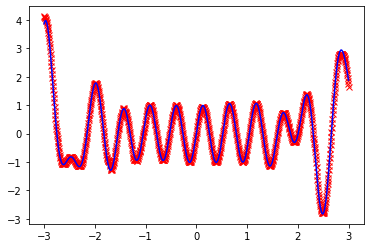

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.06671785637574974
